In [1]:
# GridBoard.py and Gridworld in the main repository have been directly copied from 
# Alexander Zai. “Deep Reinforcement Learning in Action MEAP V06”
# whereas the text in this notebook is my own implementation of the code in the book
# licenses are inherited from the ones used by A.Zai et al in the mentioned book
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from collections import OrderedDict
from torch.autograd import Variable
from Gridworld import *
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

In [2]:
def softmax_fn(av, tau = 1.12):
# This function receives average rewards and outputs the softmax probabilities 
# Arguments:
#   - av: expected averages
#   - tau: temperature. High val exaggerates differences; low value promotes homogenity
# Output:
#   - Softmaxed values

    softm = np.exp(av / tau) / np.sum( np.exp(av[:] / tau) )
    return softm

In [22]:

class QNet():
    def __init__(self, n_in, n_out, n_hidden1, n_hidden2, action_set, gridSize = 4, gamma = 0.9):
        self.n_in = n_in
        self.n_out = n_out
        self.action_set = action_set
        self.gridSize = gridSize
        self.newGridGame()
        self.gamma = gamma
       # self.one_hot_reward = np.ones(arms)

        # Neural network model definition 
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(n_in, n_hidden1)),
            ('ReLu1', nn.ReLU(inplace = True)),
            ('fc2', nn.Linear(n_hidden1, n_hidden2)),
            ('ReLu2', nn.ReLU(inplace = True)),
            ('fc3', nn.Linear(n_hidden2, n_out)),
            #('ReLu3', nn.ReLU(inplace = True))
        ])
        )
                                  
    def newGridGame(self):
        self.env = Gridworld(size=self.gridSize, mode='static') 
        self.refreshState()
                                  
    def refreshState(self):
        # Get state with some random noise
        state_ = self.env.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
        self.state = Variable(torch.from_numpy(state_).float())
        
    def forward(self):
        # Get reward prediction from the model
        qval = self.model(self.state)
        # Obtain the probability distribution of the reward prediction
        print("qval: ", qval.data.numpy())
        av_softmax = softmax_fn(qval.data.numpy(), tau=2.0)  
        print("av_softmax: ", av_softmax)

        av_softmax /= av_softmax.sum() 

        return av_softmax, qval
    
    def getQReward(self):
        cur_reward = self.env.reward()
        # The reward of a Q_learning algorithm takes into account propect
        # So ,we need to get new state and the expected reward (maxQval)
        new_state_ = self.env.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
        new_state_ = Variable(torch.from_numpy(state_).float())
        with torch.no_grad(): # we do not want this pred to be considered in grads
            fut_qval = self.model(new_state_.reshape(1,64))
        
        # Are we in the endgame?
        if cur_reward == -1: 
            QReward = cur_reward + self.gamma*torch.max(fut_qval)
        else:
            QReward = cur_reward
        
        return QReward, cur_reward, new_state_
        
    def actuate(self, av_softmax, y_pred, action_map = None):
        # This function returns the reward to be used for backpropagation and the cur_reward obtained 
        # The backprop reward is such that only modifies the nodes related with obtaining cur_reward
        # To do this, we copy the forward output and modify the value of the array corresponding with the 
        # choice made. The new value of this position is the cur_reward.
        
        # Probabilistically choose an action 
        choice = np.random.choice(self.n_out, p=av_softmax.squeeze()) 
        # convert the choice to the action using the action set of the game
        action = self.action_set[choice]
        # Make the action
        self.env.makeMove(action)
        # Execute action and get the reward for it
        Qreward, status_, new_state = self.getQReward()
        print("Qreward: ",Qreward)
        print("cur_reward: ",status_)

        # Copy qvals
        backprop_reward = y_pred.data.numpy().copy()
        # Update val corresponding to choice so it matches the QReward
        backprop_reward[0][choice] = Qreward
        self.state = new_state
        # Return reward
        return backprop_reward,status_
        

In [23]:
def train(Qmodel, loss_fn, optimizer, epochs = 1000):
    
    for epoch in range(epochs): # Episodic training, each epoch is a new game
        
        optimizer.zero_grad() # reset grads between epochs
        # Create a new game for each epoch
        Qmodel.newGridGame() # Also refreshes the model state
       
        # Track play status (has game ended?) 
        game_active = True
        while(game_active): # while current play is going on
            actions_prob, y_pred = Qmodel.forward() # get prob distribution and curr_reward
            # actuate based on prob - determines explore-exploit
            act_rewards, status = Qmodel.actuate(actions_prob, y_pred) 
            # Compute loss
            #print('in loss. y_pred {}, rewards: {}'.format(y_pred.data.numpy().size(),act_rewards.size())
            loss = loss_fn(y_pred, torch.Tensor([act_rewards]).detach()) # compute loss
            print('eph: {},  {}'.format(epoch, loss))
            losses.append(loss.item())
            loss.backward() # obtain backward propagation gradients
            optimizer.step() # apply backprop to network model
            
            if status == -1:
                game_active = True
            else:
                game_active = False           


In [20]:
# Set params 
action_map = {
    0:'u',
    1:'d',
    2:'l',
    3:'r'
}
gridSize = 4
learning_rate = 1e-4
gamma = 0.9 # decay ratio

n_out = len(action_map) # 4
n_in = 4*gridSize*gridSize
l2 = 164
l3 = 150
# Create RL object
Qnet = QNet(n_in, n_out, l2,l3, action_map, gridSize, gamma)
print(Qnet.model)

# Loss metric and optimization criterion for training
loss_fn = nn.MSELoss(size_average=False)
criterion = torch.optim.Adam(Qnet.model.parameters(), lr=learning_rate)


Sequential(
  (fc1): Linear(in_features=64, out_features=164, bias=True)
  (ReLu1): ReLU(inplace)
  (fc2): Linear(in_features=164, out_features=150, bias=True)
  (ReLu2): ReLU(inplace)
  (fc3): Linear(in_features=150, out_features=4, bias=True)
)


In [21]:
losses =[]
train(Qnet, loss_fn, criterion, epochs = 1000)

qval:  [[-0.06510315 -0.04173394  0.03976715 -0.12103879]]
av_softmax:  [[0.24764691 0.25055754 0.2609788  0.24081673]]
Qreward:  tensor(-0.9611)
cur_reward:  -1
eph: 0,  0.8028052449226379
qval:  [[-0.07034836 -0.04150057  0.04321318 -0.12404073]]
av_softmax:  [[0.2471294  0.2507198  0.26156762 0.24058318]]
Qreward:  tensor(-0.9643)
cur_reward:  -1
eph: 0,  0.7991498708724976
qval:  [[-0.06881545 -0.03831727  0.03970965 -0.11760831]]
av_softmax:  [[0.24709499 0.25089183 0.26087344 0.2411397 ]]
Qreward:  tensor(-0.9750)
cur_reward:  -1
eph: 0,  1.0297234058380127
qval:  [[-0.06568701 -0.05925053  0.02656359 -0.11879964]]
av_softmax:  [[0.24849524 0.24929625 0.2602256  0.24198297]]
Qreward:  tensor(-0.9788)
cur_reward:  -1
eph: 0,  0.8337558507919312
qval:  [[-0.07487863 -0.05170113  0.02236395 -0.12811232]]
av_softmax:  [[0.2478184  0.250707   0.26016536 0.24130926]]
Qreward:  tensor(-0.9812)
cur_reward:  -1
eph: 0,  0.8639013171195984
qval:  [[-0.06094795 -0.06178247  0.01968955 -0.11

eph: 0,  0.9742753505706787
qval:  [[-0.17563426 -0.12275064 -0.08380222 -0.22659233]]
av_softmax:  [[0.24699752 0.25361568 0.25860304 0.24078375]]
Qreward:  tensor(-1.0710)
cur_reward:  -1
eph: 0,  0.8016953468322754
qval:  [[-0.19027784 -0.12461844 -0.08247364 -0.22992977]]
av_softmax:  [[0.24575308 0.25395498 0.2593632  0.24092875]]
Qreward:  tensor(-1.0811)
cur_reward:  -1
eph: 0,  0.91493159532547
qval:  [[-0.18222752 -0.12321424 -0.09377693 -0.23768048]]
av_softmax:  [[0.24704665 0.25444478 0.25821754 0.240291  ]]
Qreward:  tensor(-1.0739)
cur_reward:  -1
eph: 0,  0.6991882920265198
qval:  [[-0.17044461 -0.11668136 -0.08581232 -0.23540625]]
av_softmax:  [[0.247616   0.25436258 0.258319   0.23970243]]
Qreward:  tensor(-1.0891)
cur_reward:  -1
eph: 0,  1.0066815614700317
qval:  [[-0.18861297 -0.12894893 -0.10293914 -0.24270259]]
av_softmax:  [[0.24707422 0.254556   0.25788808 0.24048169]]
Qreward:  tensor(-1.0754)
cur_reward:  -1
eph: 0,  0.6933218240737915
qval:  [[-0.17780586 -0.

Qreward:  tensor(-1.4319)
cur_reward:  -1
eph: 1,  0.5066874027252197
qval:  [[-0.54064023 -0.49687    -0.48507535 -0.7580037 ]]
av_softmax:  [[0.25333682 0.25894225 0.26047382 0.22724715]]
Qreward:  tensor(-1.4266)
cur_reward:  -1
eph: 1,  0.7850064039230347
qval:  [[-0.5166279  -0.4783556  -0.48902878 -0.7251899 ]]
av_softmax:  [[0.25418207 0.259093   0.257714   0.22901097]]
Qreward:  tensor(-1.4385)
cur_reward:  -1
eph: 1,  0.9219304919242859
qval:  [[-0.5374798  -0.4992272  -0.49278128 -0.75861466]]
av_softmax:  [[0.2539852  0.25888976 0.25972548 0.22739956]]
Qreward:  tensor(-1.4119)
cur_reward:  -1
eph: 1,  0.7645583748817444
qval:  [[-0.5010771  -0.46208274 -0.47275335 -0.7097174 ]]
av_softmax:  [[0.25413686 0.25914043 0.2577615  0.22896124]]
Qreward:  tensor(-1.4071)
cur_reward:  -1
eph: 1,  0.8730036020278931
qval:  [[-0.5360284  -0.45740008 -0.45849973 -0.7500294 ]]
av_softmax:  [[0.25137326 0.26145262 0.2613089  0.2258652 ]]
Qreward:  tensor(-1.4159)
cur_reward:  -1
eph: 1, 

qval:  [[-0.98897666 -0.91110396 -1.1119066  -1.4507747 ]]
av_softmax:  [[0.2649772  0.2754979  0.2491808  0.21034408]]
Qreward:  tensor(-1.8790)
cur_reward:  -1
eph: 1,  0.9367282390594482
qval:  [[-1.005719   -0.99365616 -1.173281   -1.4818631 ]]
av_softmax:  [[0.26926398 0.2708929  0.24762392 0.21221928]]
Qreward:  tensor(-1.8204)
cur_reward:  -1
eph: 1,  0.6636370420455933
qval:  [[-1.0065911  -0.92838836 -1.138655   -1.4692856 ]]
av_softmax:  [[0.26529133 0.27587008 0.24833947 0.2104991 ]]
Qreward:  tensor(-1.8862)
cur_reward:  -1
eph: 1,  0.7737247943878174
qval:  [[-1.0722198 -1.0032988 -1.2378026 -1.6251621]]
av_softmax:  [[0.26924714 0.2786873  0.24785362 0.204212  ]]
Qreward:  tensor(-1.8637)
cur_reward:  -1
eph: 1,  0.7402335405349731
qval:  [[-1.049323   -0.97754115 -1.1949022  -1.5393046 ]]
av_softmax:  [[0.26673418 0.2764814  0.24800849 0.20877598]]
Qreward:  tensor(-1.8407)
cur_reward:  -1
eph: 1,  0.4170171320438385
qval:  [[-1.0307946 -0.952193  -1.2058342 -1.4954083]]

qval:  [[-2.9463472 -2.9078302 -2.9130983 -3.4392812]]
av_softmax:  [[0.26193333 0.26702663 0.26632422 0.20471585]]
Qreward:  tensor(-3.5714)
cur_reward:  -1
eph: 3,  0.3907132148742676
qval:  [[-2.9648561 -2.8937201 -2.8774655 -3.4310734]]
av_softmax:  [[0.2582018  0.2675508  0.26973414 0.20451327]]
Qreward:  tensor(-3.7163)
cur_reward:  -1
eph: 3,  0.5646865367889404
qval:  [[-3.1310189 -3.0581818 -3.0389824 -3.6110702]]
av_softmax:  [[0.25834513 0.2679271  0.2705115  0.20321625]]
Qreward:  tensor(-3.6830)
cur_reward:  -1
eph: 3,  0.005175698548555374
qval:  [[-3.1041567 -3.0006452 -3.0182393 -3.552845 ]]
av_softmax:  [[0.25666997 0.2703039  0.26793647 0.20508961]]
Qreward:  tensor(-3.8200)
cur_reward:  -1
eph: 3,  0.6713672280311584
qval:  [[-3.2345135 -3.1522722 -3.18455   -3.7524395]]
av_softmax:  [[0.26047596 0.2714102  0.26706508 0.20104879]]
Qreward:  tensor(-3.5791)
cur_reward:  -1
eph: 3,  0.15567277371883392
qval:  [[-2.9230042 -2.8832812 -2.8840287 -3.3882947]]
av_softmax: 

eph: 4,  0.3265106678009033
qval:  [[-4.218864  -4.235571  -4.4304905 -4.7660756]]
av_softmax:  [[0.2738296  0.2715517  0.2463351  0.20828353]]
Qreward:  tensor(-4.7043)
cur_reward:  -1
eph: 4,  0.00381458573974669
qval:  [[-4.1513777 -4.138671  -4.379491  -4.6629457]]
av_softmax:  [[0.27226514 0.27400047 0.242917   0.2108174 ]]
Qreward:  tensor(-4.7278)
cur_reward:  -1
eph: 4,  0.12132550030946732
qval:  [[-4.160258  -4.177534  -4.367627  -4.6863604]]
av_softmax:  [[0.2731038  0.27075487 0.24620569 0.20993558]]
Qreward:  tensor(-4.7811)
cur_reward:  -1
eph: 4,  0.3854524493217468
qval:  [[-4.2201624 -4.2321186 -4.43038   -4.7404666]]
av_softmax:  [[0.27283633 0.27121016 0.24561454 0.2103389 ]]
Qreward:  tensor(-4.8104)
cur_reward:  -1
eph: 4,  0.34837257862091064
qval:  [[-4.2537594 -4.276765  -4.46911   -4.7847104]]
av_softmax:  [[0.27372336 0.27059284 0.24578144 0.20990236]]
Qreward:  tensor(-4.9344)
cur_reward:  -1
eph: 4,  0.46325165033340454
qval:  [[-4.3934636 -4.4284816 -4.6224

Qreward:  tensor(-5.6351)
cur_reward:  -1
eph: 6,  0.20010028779506683
qval:  [[-5.1947956 -5.3945107 -5.3537993 -5.547546 ]]
av_softmax:  [[0.27271396 0.24679692 0.25187212 0.22861704]]
Qreward:  tensor(-5.3301)
cur_reward:  -1
eph: 6,  0.0005635561537928879
qval:  [[-4.854428  -5.0239444 -4.942564  -5.184773 ]]
av_softmax:  [[0.26857385 0.24674803 0.25699532 0.22768277]]
Qreward:  tensor(-5.8030)
cur_reward:  -1
eph: 6,  0.6068711280822754
qval:  [[-5.386468  -5.648534  -5.517939  -5.7552524]]
av_softmax:  [[0.27433512 0.24064371 0.25688148 0.2281397 ]]
Qreward:  tensor(-5.6788)
cur_reward:  -1
eph: 6,  0.0009163655340671539
qval:  [[-5.247542  -5.5081387 -5.348291  -5.597866 ]]
av_softmax:  [[0.2726261  0.2393203  0.25923288 0.2288208 ]]
Qreward:  tensor(-5.8232)
cur_reward:  -1
eph: 6,  0.09926018863916397
qval:  [[-5.4101553 -5.6934843 -5.508838  -5.7664356]]
av_softmax:  [[0.27347857 0.23735544 0.26031223 0.22885375]]
Qreward:  tensor(-5.6336)
cur_reward:  -1
eph: 6,  0.049910169

Qreward:  tensor(-7.1809)
cur_reward:  -1
eph: 10,  0.2314673811197281
qval:  [[-7.040122  -6.8781934 -7.1446114 -7.465138 ]]
av_softmax:  [[0.26028228 0.28223246 0.24703303 0.21045224]]
Qreward:  tensor(-7.4967)
cur_reward:  -1
eph: 10,  0.38255906105041504
qval:  [[-7.3644733 -7.2309403 -7.5073934 -7.837053 ]]
av_softmax:  [[0.26387793 0.28209758 0.2456792  0.20834531]]
Qreward:  tensor(-7.4320)
cur_reward:  -1
eph: 10,  0.005684278439730406
qval:  [[-7.3102794 -7.1612697 -7.475923  -7.799793 ]]
av_softmax:  [[0.26449704 0.28495604 0.24347353 0.20707342]]
Qreward:  tensor(-7.4872)
cur_reward:  -1
eph: 10,  0.0001268527703359723
qval:  [[-7.3934703 -7.2235527 -7.590034  -7.898906 ]]
av_softmax:  [[0.26512876 0.2886383  0.24031094 0.20592202]]
Qreward:  tensor(-7.4714)
cur_reward:  -1
eph: 10,  0.014076568186283112
qval:  [[-7.409122 -7.206665 -7.603854 -7.903563]]
av_softmax:  [[0.26352394 0.29159698 0.23907518 0.20580389]]
Qreward:  tensor(-7.1724)
cur_reward:  -1
eph: 10,  0.5345561

qval:  [[-8.214934  -7.7452707 -8.6862755 -7.32983  ]]
av_softmax:  [[0.21685332 0.27425355 0.171323   0.33757013]]
Qreward:  tensor(-7.7905)
cur_reward:  -1
eph: 10,  0.2122102528810501
qval:  [[-8.417549  -7.9675264 -8.849442  -7.5061755]]
av_softmax:  [[0.21573243 0.27016968 0.17383258 0.34026533]]
Qreward:  tensor(-7.2344)
cur_reward:  -1
eph: 10,  2.6082258224487305
qval:  [[-7.780829 -7.354997 -8.178158 -6.89188 ]]
av_softmax:  [[0.21660139 0.2679967  0.17757522 0.33782673]]
Qreward:  tensor(-7.5156)
cur_reward:  -1
eph: 10,  0.07034527510404587
qval:  [[-8.119471  -7.731108  -8.513887  -7.2013326]]
av_softmax:  [[0.21654698 0.26295653 0.1777893  0.34270725]]
Qreward:  tensor(-7.0384)
cur_reward:  -1
eph: 10,  0.4798252284526825
qval:  [[-7.5759053 -7.1857758 -7.916225  -6.674205 ]]
av_softmax:  [[0.21604966 0.26258454 0.18224438 0.3391215 ]]
Qreward:  tensor(-7.3104)
cur_reward:  -1
eph: 10,  0.4046885073184967
qval:  [[-7.9156466 -7.547084  -8.220558  -6.9731026]]
av_softmax:  

Qreward:  tensor(-5.6802)
cur_reward:  -1
eph: 10,  0.34237736463546753
qval:  [[-5.90325   -6.255048  -5.1457977 -6.899602 ]]
av_softmax:  [[0.2559663  0.21467967 0.37381914 0.15553488]]
Qreward:  tensor(-5.7574)
cur_reward:  -1
eph: 10,  1.3046458959579468
qval:  [[-5.9924545 -6.354107  -5.2298145 -7.0758348]]
av_softmax:  [[0.25769472 0.21506697 0.37732077 0.14991756]]
Qreward:  tensor(-5.3594)
cur_reward:  -1
eph: 10,  0.9895200133323669
qval:  [[-5.568624  -5.917573  -4.788352  -6.5844483]]
av_softmax:  [[0.25517815 0.2143237  0.3769445  0.15355363]]
Qreward:  tensor(-5.5915)
cur_reward:  -1
eph: 10,  0.6450938582420349
qval:  [[-5.808332  -6.1735544 -5.047732  -6.908738 ]]
av_softmax:  [[0.25822124 0.21512206 0.37770626 0.14895044]]
Qreward:  tensor(-5.5357)
cur_reward:  -1
eph: 10,  0.23811739683151245
qval:  [[-5.77207   -6.123926  -4.9865766 -6.9156127]]
av_softmax:  [[0.25745022 0.21591792 0.38129494 0.14533697]]
Qreward:  tensor(-5.4084)
cur_reward:  -1
eph: 10,  0.511914849

Qreward:  tensor(-3.3722)
cur_reward:  -1
eph: 10,  0.9430219531059265
qval:  [[-2.9686394 -2.6183732 -3.5529625 -4.272808 ]]
av_softmax:  [[0.2890999  0.34443504 0.21585584 0.15060914]]
Qreward:  tensor(-3.2865)
cur_reward:  -1
eph: 10,  0.44641417264938354
qval:  [[-2.8909876 -2.5218086 -3.4677238 -4.1276255]]
av_softmax:  [[0.28644595 0.34451562 0.21468712 0.15435126]]
Qreward:  tensor(-3.3932)
cur_reward:  -1
eph: 10,  0.25225165486335754
qval:  [[-3.0116308 -2.642026  -3.6446152 -4.3188796]]
av_softmax:  [[0.28970072 0.34850436 0.21110511 0.15068987]]
Qreward:  tensor(-3.1098)
cur_reward:  -1
eph: 10,  1.4617544412612915
qval:  [[-2.6647496 -2.326589  -3.146685  -3.773585 ]]
av_softmax:  [[0.2821281  0.3341004  0.2217152  0.16205627]]
Qreward:  tensor(-3.2768)
cur_reward:  -1
eph: 10,  0.902924120426178
qval:  [[-2.8461864 -2.5115492 -3.469644  -4.046937 ]]
av_softmax:  [[0.28877392 0.34136856 0.21143451 0.15842302]]
Qreward:  tensor(-3.2866)
cur_reward:  -1
eph: 10,  0.6007271409

Qreward:  tensor(-2.9182)
cur_reward:  -1
eph: 11,  0.03746671974658966
qval:  [[-2.6125553 -2.1320128 -3.465892  -2.9369025]]
av_softmax:  [[0.26493102 0.33688468 0.17291515 0.22526912]]
Qreward:  tensor(-3.0036)
cur_reward:  -1
eph: 11,  0.004442465491592884
qval:  [[-2.6900082 -2.2270727 -3.5915887 -3.0531907]]
av_softmax:  [[0.26798767 0.33778468 0.1707415  0.2234862 ]]
Qreward:  tensor(-2.8226)
cur_reward:  -1
eph: 11,  0.053174544125795364
qval:  [[-2.430885  -2.0261903 -3.1640756 -2.7309613]]
av_softmax:  [[0.2646876  0.32404995 0.18345235 0.22781007]]
Qreward:  tensor(-2.9743)
cur_reward:  -1
eph: 11,  0.03600559011101723
qval:  [[-2.6272712 -2.1951249 -3.5270572 -2.9848676]]
av_softmax:  [[0.2691671  0.3340884  0.1716469  0.22509764]]
Qreward:  tensor(-2.9083)
cur_reward:  -1
eph: 11,  0.5085737705230713
qval:  [[-2.5671778 -2.1222098 -3.4194446 -2.8785324]]
av_softmax:  [[0.26609614 0.33240083 0.17376854 0.22773445]]
Qreward:  tensor(-2.9747)
cur_reward:  -1
eph: 11,  0.19777

Qreward:  tensor(-3.2341)
cur_reward:  -1
eph: 12,  0.1310722976922989
qval:  [[-2.9156663 -2.4894133 -3.5648851 -3.070216 ]]
av_softmax:  [[0.25733492 0.31846258 0.18600416 0.23819835]]
Qreward:  tensor(-3.1754)
cur_reward:  -1
eph: 12,  0.47059810161590576
qval:  [[-2.814418  -2.4234912 -3.5050173 -3.024439 ]]
av_softmax:  [[0.2614928  0.31794235 0.18513903 0.23542587]]
Qreward:  tensor(-3.2894)
cur_reward:  -1
eph: 12,  0.22556965053081512
qval:  [[-2.9683409 -2.5513911 -3.6376653 -3.1287203]]
av_softmax:  [[0.25837666 0.31826782 0.18488911 0.23846646]]
Qreward:  tensor(-3.1562)
cur_reward:  -1
eph: 12,  0.23176135122776031
qval:  [[-2.7819915 -2.4021394 -3.389868  -2.9463313]]
av_softmax:  [[0.25851938 0.31259134 0.1907631  0.23812619]]
Qreward:  -10
cur_reward:  -10
eph: 12,  43.69384765625
qval:  [[-2.905361  -2.4866052 -3.538258  -3.0582416]]
av_softmax:  [[0.25719824 0.3171025  0.18742873 0.23827057]]
Qreward:  tensor(-3.2333)
cur_reward:  -1
eph: 13,  0.0929933413863182
qval: 

Qreward:  tensor(-3.4421)
cur_reward:  -1
eph: 14,  0.7172181606292725
qval:  [[-3.0238922 -2.7261827 -3.61784   -3.220924 ]]
av_softmax:  [[0.26248446 0.3046144  0.19504261 0.23785852]]
Qreward:  tensor(-3.4411)
cur_reward:  -1
eph: 14,  0.04849310591816902
qval:  [[-3.0230715 -2.7258303 -3.6052644 -3.2139144]]
av_softmax:  [[0.26200876 0.30399114 0.19583678 0.2381633 ]]
Qreward:  tensor(-3.2546)
cur_reward:  -1
eph: 14,  0.053621795028448105
qval:  [[-2.8264172 -2.5186622 -3.2840598 -3.0119624]]
av_softmax:  [[0.25818315 0.3011314  0.20537713 0.2353083 ]]
Qreward:  tensor(-3.4520)
cur_reward:  -1
eph: 14,  0.8710893988609314
qval:  [[-3.0274994 -2.7390852 -3.5901082 -3.2220404]]
av_softmax:  [[0.2619699  0.30260757 0.19773452 0.23768805]]
Qreward:  tensor(-3.4426)
cur_reward:  -1
eph: 14,  0.4949307441711426
qval:  [[-3.0189543 -2.7295668 -3.563391  -3.2078009]]
av_softmax:  [[0.26128274 0.3019607  0.19901593 0.23774053]]
Qreward:  tensor(-3.3778)
cur_reward:  -1
eph: 14,  0.12878257

qval:  [[-4.068347  -3.9809203 -4.271751  -4.3830037]]
av_softmax:  [[0.26299146 0.27474266 0.23755984 0.22470607]]
Qreward:  tensor(-4.9198)
cur_reward:  -1
eph: 15,  0.8815681338310242
qval:  [[-4.46794   -4.3813024 -4.7061253 -4.8278804]]
av_softmax:  [[0.26544273 0.27719405 0.23564029 0.22172299]]
Qreward:  tensor(-4.6980)
cur_reward:  -1
eph: 15,  0.05293993651866913
qval:  [[-4.2166276 -4.1326256 -4.426465  -4.5463853]]
av_softmax:  [[0.2637625  0.27507672 0.23749115 0.22366965]]
Qreward:  tensor(-4.8823)
cur_reward:  -1
eph: 15,  0.11284983903169632
qval:  [[-4.451444  -4.336565  -4.6776104 -4.819375 ]]
av_softmax:  [[0.2642593  0.27988264 0.23600374 0.21985435]]
Qreward:  tensor(-4.9696)
cur_reward:  -1
eph: 15,  0.022568028420209885
qval:  [[-4.5446053 -4.4325495 -4.7662    -4.9193454]]
av_softmax:  [[0.26441845 0.27965614 0.23668626 0.21923909]]
Qreward:  tensor(-4.9125)
cur_reward:  -1
eph: 15,  0.13532577455043793
qval:  [[-4.485313  -4.368227  -4.63608   -4.8047214]]
av_so

qval:  [[-7.701899  -7.8481984 -7.8234844 -8.109757 ]]
av_softmax:  [[0.27129677 0.25215995 0.25529525 0.22124797]]
Qreward:  tensor(-7.4801)
cur_reward:  -1
eph: 17,  0.13549597561359406
qval:  [[-7.224509  -7.3770227 -7.3675075 -7.623639 ]]
av_softmax:  [[0.27198586 0.25201613 0.253218   0.22278005]]
Qreward:  tensor(-7.6424)
cur_reward:  -1
eph: 17,  0.07558545470237732
qval:  [[-7.4032316 -7.5697203 -7.54727   -7.8058662]]
av_softmax:  [[0.2726064  0.25083232 0.25366384 0.22289743]]
Qreward:  tensor(-7.2386)
cur_reward:  -1
eph: 17,  0.09526482969522476
qval:  [[-6.9511213 -7.093009  -7.0852365 -7.316496 ]]
av_softmax:  [[0.27029335 0.2517821  0.25276247 0.22516207]]
Qreward:  tensor(-7.9612)
cur_reward:  -1
eph: 17,  1.020293116569519
qval:  [[-7.75489   -7.904372  -7.8810534 -8.155156 ]]
av_softmax:  [[0.27133566 0.25179505 0.25474802 0.22212125]]
Qreward:  tensor(-7.4500)
cur_reward:  -1
eph: 17,  0.2064438909292221
qval:  [[-7.184599  -7.339507  -7.3151007 -7.5633082]]
av_softm

Qreward:  tensor(-8.2424)
cur_reward:  -1
eph: 21,  0.046016160398721695
qval:  [[-8.05678  -8.147439 -8.089483 -8.330885]]
av_softmax:  [[0.2623716  0.25074396 0.25811625 0.2287682 ]]
Qreward:  tensor(-8.7213)
cur_reward:  -1
eph: 21,  0.4416531026363373
qval:  [[-8.590741 -8.699027 -8.642462 -8.872275]]
av_softmax:  [[0.26382023 0.24991605 0.25708523 0.22917844]]
Qreward:  tensor(-8.5274)
cur_reward:  -1
eph: 21,  0.013235039077699184
qval:  [[-8.374345  -8.55143   -8.484344  -8.6614485]]
av_softmax:  [[0.26823848 0.2455091  0.25388393 0.23236853]]
Qreward:  tensor(-8.8807)
cur_reward:  -1
eph: 21,  0.1571091264486313
qval:  [[-8.768287 -8.95808  -8.890793 -9.056205]]
av_softmax:  [[0.26910836 0.24474509 0.25311932 0.23302716]]
Qreward:  tensor(-8.5756)
cur_reward:  -1
eph: 21,  0.0993359163403511
qval:  [[-8.429385 -8.628723 -8.552079 -8.704582]]
av_softmax:  [[0.26902822 0.24350739 0.2530202  0.23444423]]
Qreward:  tensor(-8.5265)
cur_reward:  -1
eph: 21,  0.010447477921843529
qval

Qreward:  tensor(-8.1746)
cur_reward:  -1
eph: 25,  0.04143798351287842
qval:  [[-8.0557575 -7.9968534 -7.973484  -8.054078 ]]
av_softmax:  [[0.24553588 0.252875   0.25584707 0.24574217]]
Qreward:  tensor(-8.9387)
cur_reward:  -1
eph: 25,  0.8870296478271484
qval:  [[-8.898879 -8.818974 -8.820873 -8.880793]]
av_softmax:  [[0.24452151 0.2544886  0.25424698 0.2467428 ]]
Qreward:  tensor(-8.3246)
cur_reward:  -1
eph: 25,  0.329809308052063
qval:  [[-8.249503 -8.154176 -8.141258 -8.208754]]
av_softmax:  [[0.24242331 0.25425792 0.25590542 0.24741329]]
Qreward:  tensor(-8.4637)
cur_reward:  -1
eph: 25,  0.09581783413887024
qval:  [[-8.414735 -8.288498 -8.295868 -8.352945]]
av_softmax:  [[0.24051382 0.25618404 0.25524172 0.24806042]]
Qreward:  tensor(-8.5774)
cur_reward:  -1
eph: 25,  0.08347444981336594
qval:  [[-8.571106 -8.418457 -8.451524 -8.473473]]
av_softmax:  [[0.23860909 0.25753382 0.25331092 0.2505462 ]]
Qreward:  tensor(-8.5879)
cur_reward:  -1
eph: 25,  0.028709035366773605
qval: 

Qreward:  tensor(-8.9540)
cur_reward:  -1
eph: 25,  0.1675107479095459
qval:  [[-9.355795 -8.990056 -8.84193  -8.94074 ]]
av_softmax:  [[0.21167396 0.25414795 0.27368546 0.26049268]]
Qreward:  tensor(-9.1619)
cur_reward:  -1
eph: 25,  0.04889020696282387
qval:  [[-9.603863 -9.244078 -9.073535 -9.202213]]
av_softmax:  [[0.21172339 0.2534517  0.27601206 0.2588129 ]]
Qreward:  tensor(-9.0050)
cur_reward:  -1
eph: 25,  0.004693366587162018
qval:  [[-9.412502 -9.098207 -8.902508 -9.068609]]
av_softmax:  [[0.21513517 0.2517443  0.2776229  0.2554976 ]]
Qreward:  tensor(-9.0273)
cur_reward:  -1
eph: 25,  0.005027751438319683
qval:  [[-9.396398 -9.116156 -8.929685 -9.093062]]
av_softmax:  [[0.21848287 0.25134552 0.27590707 0.25426453]]
Qreward:  tensor(-8.8489)
cur_reward:  -1
eph: 25,  0.29972976446151733
qval:  [[-9.215737 -8.935526 -8.728107 -8.948441]]
av_softmax:  [[0.2188426 0.2517555 0.2792668 0.2501351]]
Qreward:  -10
cur_reward:  -10
eph: 25,  1.6177107095718384
qval:  [[-9.175235 -8.8

Qreward:  tensor(-9.2702)
cur_reward:  -1
eph: 27,  0.021385926753282547
qval:  [[-9.409023 -9.174617 -9.383972 -9.2766  ]]
av_softmax:  [[0.23778921 0.26735783 0.2407864  0.2540666 ]]
Qreward:  tensor(-9.2446)
cur_reward:  -1
eph: 27,  0.027043074369430542
qval:  [[-9.334242 -9.146735 -9.365768 -9.21422 ]]
av_softmax:  [[0.2412838  0.2649993  0.23751017 0.25620675]]
Qreward:  tensor(-9.1874)
cur_reward:  -1
eph: 27,  0.021557532250881195
qval:  [[-9.290191 -9.083509 -9.276797 -9.187784]]
av_softmax:  [[0.23991604 0.2660355  0.24152808 0.25252047]]
Qreward:  tensor(-9.2156)
cur_reward:  -1
eph: 27,  0.0007711752550676465
qval:  [[-9.319272 -9.115195 -9.329484 -9.20101 ]]
av_softmax:  [[0.2401971  0.2660005  0.2389738  0.25482857]]
Qreward:  10
cur_reward:  10
eph: 27,  373.2342224121094
qval:  [[-8.747194 -8.503907 -8.734088 -8.58343 ]]
av_softmax:  [[0.23689643 0.26753932 0.23845394 0.25711027]]
Qreward:  tensor(-8.7054)
cur_reward:  -1
eph: 28,  0.040579553693532944
qval:  [[-8.74198

eph: 28,  0.36186483502388
qval:  [[-8.349815 -8.680598 -8.76076  -8.930757]]
av_softmax:  [[0.29327783 0.24857111 0.23880516 0.21934588]]
Qreward:  tensor(-8.3863)
cur_reward:  -1
eph: 28,  0.0013277269899845123
qval:  [[-8.198622 -8.487188 -8.554123 -8.745189]]
av_softmax:  [[0.28871107 0.24992056 0.2416948  0.21967362]]
Qreward:  tensor(-8.8054)
cur_reward:  -1
eph: 28,  0.368146151304245
qval:  [[-8.664217 -8.970508 -9.048356 -9.243942]]
av_softmax:  [[0.2914075  0.25002912 0.2404839  0.21807957]]
Qreward:  tensor(-8.4494)
cur_reward:  -1
eph: 28,  0.04614636301994324
qval:  [[-8.270177 -8.549284 -8.613319 -8.822094]]
av_softmax:  [[0.28810716 0.25058016 0.24268425 0.21862848]]
Qreward:  tensor(-8.2984)
cur_reward:  -1
eph: 28,  0.06295333802700043
qval:  [[-8.100681 -8.384892 -8.465264 -8.646387]]
av_softmax:  [[0.28884262 0.25057957 0.24070944 0.21986839]]
Qreward:  tensor(-8.2577)
cur_reward:  -1
eph: 28,  0.016182297840714455
qval:  [[-8.05858  -8.327696 -8.410892 -8.59527 ]]
a

qval:  [[-6.800097  -6.6082535 -6.978484  -6.2057548]]
av_softmax:  [[0.22928484 0.25236762 0.20971961 0.30862784]]
Qreward:  tensor(-6.5116)
cur_reward:  -1
eph: 28,  0.21799370646476746
qval:  [[-6.655863  -6.489216  -6.8321295 -6.09336  ]]
av_softmax:  [[0.23108998 0.25117016 0.21159497 0.30614492]]
Qreward:  tensor(-6.4918)
cur_reward:  -1
eph: 28,  0.15875130891799927
qval:  [[-6.6274724 -6.484339  -6.8378973 -6.072634 ]]
av_softmax:  [[0.2328808  0.25015816 0.20962374 0.30733728]]
Qreward:  tensor(-6.3132)
cur_reward:  -1
eph: 28,  0.057885657995939255
qval:  [[-6.401995  -6.363319  -6.626133  -5.8719063]]
av_softmax:  [[0.23713554 0.24176592 0.21199505 0.30910352]]
Qreward:  tensor(-6.1285)
cur_reward:  -1
eph: 28,  0.05512985587120056
qval:  [[-6.1703334 -6.157414  -6.410787  -5.6680417]]
av_softmax:  [[0.23930901 0.24085988 0.21219991 0.30763116]]
Qreward:  tensor(-6.4763)
cur_reward:  -1
eph: 28,  0.004298158455640078
qval:  [[-6.5750713 -6.5153866 -6.860973  -6.0569744]]
av_

Qreward:  tensor(-5.8615)
cur_reward:  -1
eph: 29,  0.011850710958242416
qval:  [[-5.4082375 -6.0416665 -6.111152  -5.6569605]]
av_softmax:  [[0.30163535 0.21975303 0.2122493  0.26636228]]
Qreward:  tensor(-5.8138)
cur_reward:  -1
eph: 29,  0.0246006827801466
qval:  [[-5.3556857 -5.9738393 -5.9965405 -5.619836 ]]
av_softmax:  [[0.29973876 0.22004555 0.21756202 0.26265365]]
Qreward:  tensor(-5.3619)
cur_reward:  -1
eph: 29,  0.37447279691696167
qval:  [[-4.853594  -5.4743342 -5.4886093 -5.1104703]]
av_softmax:  [[0.299347   0.21947388 0.21791296 0.2632661 ]]
Qreward:  tensor(-6.1090)
cur_reward:  -1
eph: 29,  0.38490912318229675
qval:  [[-5.68603   -6.330968  -6.4466147 -5.9880257]]
av_softmax:  [[0.30600977 0.22166075 0.20920709 0.26312238]]
Qreward:  tensor(-5.6850)
cur_reward:  -1
eph: 29,  0.09182631969451904
qval:  [[-5.214778  -5.851752  -5.879307  -5.4820957]]
av_softmax:  [[0.30125612 0.21908809 0.2160903  0.2635655 ]]
Qreward:  tensor(-5.6594)
cur_reward:  -1
eph: 29,  0.031429

Qreward:  tensor(-6.2685)
cur_reward:  -1
eph: 29,  0.2958484888076782
qval:  [[-5.9312    -5.8672667 -6.3331437 -6.1894364]]
av_softmax:  [[0.26814765 0.2768579  0.21932746 0.23566696]]
Qreward:  tensor(-6.7259)
cur_reward:  -1
eph: 29,  0.28784656524658203
qval:  [[-6.4270587 -6.3760195 -6.8524995 -6.7295117]]
av_softmax:  [[0.27071783 0.27771533 0.21884345 0.23272339]]
Qreward:  tensor(-6.6462)
cur_reward:  -1
eph: 29,  0.0069371615536510944
qval:  [[-6.350521  -6.286985  -6.7111335 -6.6425557]]
av_softmax:  [[0.2679934  0.2766437  0.22377835 0.23158455]]
Qreward:  tensor(-6.3532)
cur_reward:  -1
eph: 29,  0.08372592180967331
qval:  [[-6.043855  -5.960902  -6.3597045 -6.315433 ]]
av_softmax:  [[0.26530197 0.27653715 0.22654511 0.23161577]]
Qreward:  tensor(-6.3727)
cur_reward:  -1
eph: 29,  0.10816507786512375
qval:  [[-6.1027985 -5.98672   -6.4695005 -6.407939 ]]
av_softmax:  [[0.2666147  0.28254667 0.22195031 0.22888836]]
Qreward:  tensor(-6.9178)
cur_reward:  -1
eph: 29,  0.86697

Qreward:  tensor(-7.3768)
cur_reward:  -1
eph: 31,  0.0025700738187879324
qval:  [[-7.2806716 -7.1034546 -7.356212  -7.358977 ]]
av_softmax:  [[0.24893017 0.27199423 0.23970334 0.23937224]]
Qreward:  tensor(-7.5862)
cur_reward:  -1
eph: 31,  0.05289386585354805
qval:  [[-7.4455056 -7.336108  -7.587855  -7.5083003]]
av_softmax:  [[0.25274146 0.2669512  0.23537794 0.24492933]]
Qreward:  tensor(-7.5511)
cur_reward:  -1
eph: 31,  0.0013488339027389884
qval:  [[-7.4024773 -7.2972703 -7.5389566 -7.451946 ]]
av_softmax:  [[0.25229478 0.26592162 0.23565254 0.246131  ]]
Qreward:  tensor(-7.8110)
cur_reward:  -1
eph: 31,  0.16690045595169067
qval:  [[-7.6821256 -7.5871363 -7.771105  -7.759994 ]]
av_softmax:  [[0.25208348 0.26434496 0.24111418 0.24245739]]
Qreward:  10
cur_reward:  10
eph: 31,  312.6575622558594
qval:  [[-6.916812  -6.786986  -6.943227  -6.9539914]]
av_softmax:  [[0.24779907 0.264418   0.2445478  0.2432351 ]]
Qreward:  tensor(-7.3168)
cur_reward:  -1
eph: 32,  0.28068292140960693

qval:  [[-7.8246055 -8.001247  -7.9426546 -8.004892 ]]
av_softmax:  [[0.26511478 0.24270384 0.24991935 0.24226193]]
Qreward:  tensor(-7.9393)
cur_reward:  -1
eph: 34,  0.004300909582525492
qval:  [[-7.7307696 -7.8843565 -7.782783  -7.9160237]]
av_softmax:  [[0.2623334  0.242942   0.2555989  0.23912564]]
Qreward:  tensor(-7.8273)
cur_reward:  -1
eph: 34,  0.007876118645071983
qval:  [[-7.606306  -7.762518  -7.655986  -7.8136673]]
av_softmax:  [[0.26303014 0.24326774 0.256577   0.23712513]]
Qreward:  tensor(-7.8399)
cur_reward:  -1
eph: 34,  0.0006882306188344955
qval:  [[-7.621382  -7.781942  -7.6787767 -7.834226 ]]
av_softmax:  [[0.2636009  0.24326621 0.25614378 0.23698913]]
Qreward:  tensor(-7.8286)
cur_reward:  -1
eph: 34,  0.002180533716455102
qval:  [[-7.6098104 -7.841296  -7.7203393 -7.851019 ]]
av_softmax:  [[0.26857725 0.23922287 0.25413713 0.23806275]]
Qreward:  tensor(-7.8747)
cur_reward:  -1
eph: 34,  0.0005592628731392324
qval:  [[-7.66195   -7.8814154 -7.7671556 -7.905568 ]

qval:  [[-10.460533 -10.230696 -10.295423  -9.820232]]
av_softmax:  [[0.21809414 0.24465413 0.23686305 0.30038866]]
Qreward:  tensor(-9.5460)
cur_reward:  -1
eph: 34,  0.5616477131843567
qval:  [[-10.181629  -9.988017 -10.011615  -9.491533]]
av_softmax:  [[0.21727656 0.23936199 0.2365544  0.306807  ]]
Qreward:  tensor(-9.7118)
cur_reward:  -1
eph: 34,  0.07630030065774918
qval:  [[-10.438018 -10.249266 -10.249957  -9.673621]]
av_softmax:  [[0.21445104 0.2356759  0.23559445 0.31427857]]
Qreward:  tensor(-9.9878)
cur_reward:  -1
eph: 34,  0.06838443130254745
qval:  [[-10.800747 -10.580537 -10.602614  -9.975709]]
av_softmax:  [[0.21136497 0.23596688 0.2333764  0.31929177]]
Qreward:  tensor(-9.9008)
cur_reward:  -1
eph: 34,  0.49256521463394165
qval:  [[-10.728893 -10.501634 -10.503629  -9.879224]]
av_softmax:  [[0.20969217 0.23492597 0.23469172 0.32069013]]
Qreward:  tensor(-10.0428)
cur_reward:  -1
eph: 34,  0.21234118938446045
qval:  [[-11.00232  -10.746666 -10.761165 -10.039296]]
av_so

Qreward:  tensor(-7.8016)
cur_reward:  -1
eph: 35,  0.04870966076850891
qval:  [[-9.101462  -9.187637  -7.510276  -7.8530116]]
av_softmax:  [[0.16555242 0.15857069 0.36682364 0.30905315]]
Qreward:  tensor(-7.6484)
cur_reward:  -1
eph: 35,  0.04184763878583908
qval:  [[-8.899335  -8.969399  -7.3403387 -7.7082033]]
av_softmax:  [[0.16778499 0.16200885 0.36583462 0.3043715 ]]
Qreward:  tensor(-7.4982)
cur_reward:  -1
eph: 35,  1.9630990028381348
qval:  [[-8.744379  -8.791001  -7.1745877 -7.553597 ]]
av_softmax:  [[0.16714367 0.16329242 0.3664087  0.30315518]]
Qreward:  tensor(-7.6117)
cur_reward:  -1
eph: 35,  1.3906716108322144
qval:  [[-8.842451 -8.930891 -7.301172 -7.704122]]
av_softmax:  [[0.16993271 0.16258202 0.3672498  0.30023548]]
Qreward:  tensor(-7.3240)
cur_reward:  -1
eph: 35,  0.0005206216592341661
qval:  [[-8.446349  -8.563753  -6.9863787 -7.363613 ]]
av_softmax:  [[0.17432556 0.16438687 0.36173424 0.29955336]]
Qreward:  tensor(-7.3716)
cur_reward:  -1
eph: 35,  0.1483952254

Qreward:  tensor(-6.0543)
cur_reward:  -1
eph: 39,  0.10478999465703964
qval:  [[-5.6289434 -5.6571436 -5.9999657 -5.940229 ]]
av_softmax:  [[0.27229086 0.26847848 0.22618645 0.23304418]]
Qreward:  tensor(-6.1699)
cur_reward:  -1
eph: 39,  0.29265403747558594
qval:  [[-5.7589636 -5.7918487 -6.1423464 -6.075548 ]]
av_softmax:  [[0.27301118 0.26855886 0.22538753 0.23304239]]
Qreward:  tensor(-6.1157)
cur_reward:  -1
eph: 39,  0.12724266946315765
qval:  [[-5.6998043 -5.7307963 -6.0925274 -6.014892 ]]
av_softmax:  [[0.2731809  0.26898032 0.22447687 0.23336186]]
Qreward:  -10
cur_reward:  -10
eph: 39,  15.268342018127441
qval:  [[-5.4311433 -5.4248447 -5.774044  -5.705675 ]]
av_softmax:  [[0.26900995 0.26985845 0.22662531 0.23450631]]
Qreward:  tensor(-5.5811)
cur_reward:  -1
eph: 40,  0.015517421066761017
qval:  [[-5.115564  -5.104013  -5.42685   -5.3740644]]
av_softmax:  [[0.26735032 0.26889884 0.22881569 0.23493516]]
Qreward:  tensor(-5.8016)
cur_reward:  -1
eph: 40,  0.4865637719631195


Qreward:  tensor(-7.8204)
cur_reward:  -1
eph: 41,  0.08585220575332642
qval:  [[-7.6468616 -7.760822  -7.795764  -7.68782  ]]
av_softmax:  [[0.25956532 0.24518874 0.24094222 0.2543037 ]]
Qreward:  tensor(-7.9387)
cur_reward:  -1
eph: 41,  0.02043880894780159
qval:  [[-7.777997 -7.904215 -7.923624 -7.768787]]
av_softmax:  [[0.25818238 0.24239226 0.24005131 0.25937408]]
Qreward:  tensor(-7.9579)
cur_reward:  -1
eph: 41,  0.03234846144914627
qval:  [[-7.820608  -7.915928  -7.9143577 -7.775934 ]]
av_softmax:  [[0.25443652 0.24259456 0.24278508 0.2601838 ]]
Qreward:  tensor(-7.5888)
cur_reward:  -1
eph: 41,  0.03500121086835861
qval:  [[-7.4425483 -7.500019  -7.512977  -7.3671174]]
av_softmax:  [[0.2515402  0.24441497 0.24283652 0.26120833]]
Qreward:  tensor(-7.8149)
cur_reward:  -1
eph: 41,  0.20048697292804718
qval:  [[-7.7189207 -7.777866  -7.789934  -7.6200004]]
av_softmax:  [[0.25082916 0.24354443 0.2420793  0.26354712]]
Qreward:  tensor(-7.7772)
cur_reward:  -1
eph: 41,  4.9333925744

Qreward:  tensor(-8.4204)
cur_reward:  -1
eph: 43,  0.13012556731700897
qval:  [[-8.537285 -8.16398  -8.702979 -8.447557]]
av_softmax:  [[0.23971699 0.288909   0.22065754 0.25071648]]
Qreward:  tensor(-8.3485)
cur_reward:  -1
eph: 43,  0.009803072549402714
qval:  [[-8.47656  -8.082784 -8.649782 -8.436454]]
av_softmax:  [[0.24067989 0.2930537  0.22071153 0.24555494]]
Qreward:  tensor(-8.3779)
cur_reward:  -1
eph: 43,  0.0034242926631122828
qval:  [[-8.528832 -8.114014 -8.711825 -8.506989]]
av_softmax:  [[0.24072994 0.29621485 0.2196816  0.24337359]]
Qreward:  tensor(-8.4214)
cur_reward:  -1
eph: 43,  0.011544582433998585
qval:  [[-8.597891 -8.161982 -8.77118  -8.560283]]
av_softmax:  [[0.23926218 0.29752985 0.2194041  0.24380384]]
Qreward:  tensor(-8.4970)
cur_reward:  -1
eph: 43,  0.11223971843719482
qval:  [[-8.669532 -8.242882 -8.901964 -8.709637]]
av_softmax:  [[0.24341463 0.30129543 0.21670784 0.23858218]]
Qreward:  tensor(-8.4911)
cur_reward:  -1
eph: 43,  0.0615968182682991
qval:

Qreward:  tensor(-4.3499)
cur_reward:  -1
eph: 43,  0.07998053729534149
qval:  [[-3.7273772 -3.901192  -3.6710005 -4.0838704]]
av_softmax:  [[0.26440427 0.24239579 0.27196342 0.22123659]]
Qreward:  tensor(-4.3546)
cur_reward:  -1
eph: 43,  0.20559871196746826
qval:  [[-3.7342892 -3.920321  -3.6763756 -4.0956974]]
av_softmax:  [[0.26488373 0.24135649 0.27266604 0.22109376]]
Qreward:  tensor(-4.4266)
cur_reward:  -1
eph: 43,  0.2562783360481262
qval:  [[-3.8189037 -4.0318236 -3.7554297 -4.1868944]]
av_softmax:  [[0.2657315  0.2388956  0.27430028 0.2210726 ]]
Qreward:  tensor(-4.3249)
cur_reward:  -1
eph: 43,  0.019039660692214966
qval:  [[-3.7156827 -3.9327996 -3.6439357 -4.06177  ]]
av_softmax:  [[0.26491806 0.23766501 0.27459413 0.22282282]]
Qreward:  tensor(-4.1324)
cur_reward:  -1
eph: 43,  0.17362309992313385
qval:  [[-3.5679135 -3.7297702 -3.4329536 -3.870094 ]]
av_softmax:  [[0.2596163  0.23943366 0.2777398  0.22321032]]
Qreward:  tensor(-4.1226)
cur_reward:  -1
eph: 43,  0.475569

Qreward:  tensor(-4.7412)
cur_reward:  -1
eph: 44,  0.44936028122901917
qval:  [[-4.193812  -4.504312  -4.269826  -4.5285997]]
av_softmax:  [[0.27286816 0.23363    0.2626919  0.23081   ]]
Qreward:  tensor(-4.5415)
cur_reward:  -1
eph: 44,  0.0013828803785145283
qval:  [[-3.9722323 -4.283674  -4.123824  -4.2639246]]
av_softmax:  [[0.2741909  0.23465207 0.25417644 0.23698065]]
Qreward:  tensor(-4.7847)
cur_reward:  -1
eph: 44,  0.6601027846336365
qval:  [[-4.244328  -4.5486317 -4.349774  -4.5874977]]
av_softmax:  [[0.27398542 0.23531452 0.25991428 0.2307858 ]]
Qreward:  tensor(-4.7534)
cur_reward:  -1
eph: 44,  0.04192063584923744
qval:  [[-4.2117257 -4.5236454 -4.3942065 -4.530352 ]]
av_softmax:  [[0.2761576  0.23627864 0.25207615 0.23548764]]
Qreward:  tensor(-4.9104)
cur_reward:  -1
eph: 44,  0.14441350102424622
qval:  [[-4.3886056 -4.6492977 -4.515118  -4.7057643]]
av_softmax:  [[0.2724907  0.23919007 0.25578785 0.23253138]]
Qreward:  tensor(-4.8244)
cur_reward:  -1
eph: 44,  0.09567

eph: 44,  0.41175535321235657
qval:  [[ -9.910462  -9.246197 -10.487939  -9.774277]]
av_softmax:  [[0.23732613 0.3308179  0.1778067  0.25404924]]
Qreward:  tensor(-9.1478)
cur_reward:  -1
eph: 44,  0.009679204784333706
qval:  [[ -9.773603  -9.127857 -10.347602  -9.628118]]
av_softmax:  [[0.23769587 0.3282794  0.17839368 0.255631  ]]
Qreward:  tensor(-9.2968)
cur_reward:  -1
eph: 44,  0.10976902395486832
qval:  [[ -9.948131  -9.293426 -10.522434  -9.744291]]
av_softmax:  [[0.23557222 0.32680708 0.17677288 0.26084784]]
Qreward:  tensor(-9.5210)
cur_reward:  -1
eph: 44,  0.18242597579956055
qval:  [[-10.214376  -9.542116 -10.78531   -9.923153]]
av_softmax:  [[0.23212996 0.3248708  0.1744836  0.26851565]]
Qreward:  tensor(-9.4366)
cur_reward:  -1
eph: 44,  0.011136334389448166
qval:  [[-10.097626  -9.447974 -10.662342  -9.79403 ]]
av_softmax:  [[0.23246527 0.321683   0.17527963 0.2705721 ]]
Qreward:  tensor(-9.4441)
cur_reward:  -1
eph: 44,  0.12243151664733887
qval:  [[-10.111586  -9.4543

Qreward:  tensor(-6.9423)
cur_reward:  -1
eph: 45,  0.41997599601745605
qval:  [[-7.279391 -7.084276 -7.409097 -6.531312]]
av_softmax:  [[0.22255486 0.24536109 0.20857954 0.3235045 ]]
Qreward:  tensor(-7.1169)
cur_reward:  -1
eph: 45,  0.0010618537198752165
qval:  [[-7.466956  -7.3208904 -7.661206  -6.7274275]]
av_softmax:  [[0.22570296 0.24280354 0.2048125  0.326681  ]]
Qreward:  tensor(-6.9749)
cur_reward:  -1
eph: 45,  0.24209460616111755
qval:  [[-7.290365 -7.095646 -7.420484 -6.567059]]
av_softmax:  [[0.22346523 0.24631606 0.20938955 0.3208292 ]]
Qreward:  tensor(-6.8421)
cur_reward:  -1
eph: 45,  0.06426683813333511
qval:  [[-7.1099715 -6.9771757 -7.292618  -6.424573 ]]
av_softmax:  [[0.22778423 0.24342205 0.20790385 0.32088992]]
Qreward:  tensor(-6.7777)
cur_reward:  -1
eph: 45,  0.12466500699520111
qval:  [[-7.0063534 -6.8837247 -7.191369  -6.354222 ]]
av_softmax:  [[0.22933774 0.24383947 0.20907393 0.3177489 ]]
Qreward:  tensor(-6.8416)
cur_reward:  -1
eph: 45,  0.237530454993

eph: 45,  0.3864830732345581
qval:  [[-2.9150677 -3.0742686 -3.059165  -4.1002107]]
av_softmax:  [[0.29352415 0.27106524 0.27312002 0.16229057]]
Qreward:  tensor(-3.4860)
cur_reward:  -1
eph: 45,  0.37721309065818787
qval:  [[-2.7372484 -2.8965538 -2.8445196 -3.8838325]]
av_softmax:  [[0.29113087 0.26884106 0.27592728 0.16410081]]
Qreward:  tensor(-3.5479)
cur_reward:  -1
eph: 45,  0.42423325777053833
qval:  [[-2.8080416 -3.0244286 -2.9757497 -4.034805 ]]
av_softmax:  [[0.29774877 0.26721582 0.27379948 0.16123588]]
Qreward:  tensor(-3.5400)
cur_reward:  -1
eph: 45,  0.5358077883720398
qval:  [[-2.7967753 -2.9719238 -2.9151707 -4.0069094]]
av_softmax:  [[0.29371086 0.26908344 0.27682847 0.16037723]]
Qreward:  tensor(-3.3679)
cur_reward:  -1
eph: 45,  0.3261922299861908
qval:  [[-2.607385  -2.7313304 -2.724157  -3.7656527]]
av_softmax:  [[0.29039568 0.27294534 0.27392608 0.16273293]]
Qreward:  tensor(-3.5910)
cur_reward:  -1
eph: 45,  0.7513489723205566
qval:  [[-2.855014  -3.04555   -3.

eph: 46,  0.37013357877731323
qval:  [[-2.2071023 -2.768387  -2.5375614 -3.0422785]]
av_softmax:  [[0.3065951  0.23157075 0.25990036 0.20193377]]
Qreward:  tensor(-2.8555)
cur_reward:  -1
eph: 46,  0.42044028639793396
qval:  [[-2.0625253 -2.5744216 -2.315748  -2.8511443]]
av_softmax:  [[0.3003541  0.23252875 0.2646348  0.20248231]]
Qreward:  tensor(-2.9016)
cur_reward:  -1
eph: 46,  0.0025439844466745853
qval:  [[-2.114064  -2.65271   -2.387304  -2.9224806]]
av_softmax:  [[0.30269063 0.23122431 0.26403752 0.20204751]]
Qreward:  tensor(-2.8868)
cur_reward:  -1
eph: 46,  0.0012730152811855078
qval:  [[-2.0978782 -2.6228921 -2.360436  -2.8997974]]
av_softmax:  [[0.30158895 0.2319584  0.26448542 0.20196722]]
Qreward:  tensor(-2.8348)
cur_reward:  -1
eph: 46,  0.22501197457313538
qval:  [[-2.0402563 -2.5464258 -2.2893453 -2.8091893]]
av_softmax:  [[0.2993909  0.23244771 0.26433194 0.20382944]]
Qreward:  10
cur_reward:  10
eph: 46,  144.9677734375
qval:  [[-1.7679125 -2.1467266 -1.9351315 -2

qval:  [[-1.9015222 -2.2623475 -2.091926  -2.463821 ]]
av_softmax:  [[0.28579348 0.23861629 0.25984037 0.21574993]]
Qreward:  tensor(-2.9856)
cur_reward:  -1
eph: 50,  0.7986888289451599
qval:  [[-2.2125633 -2.6671946 -2.4621923 -2.8323493]]
av_softmax:  [[0.2930098  0.2334319  0.25862822 0.21493013]]
Qreward:  tensor(-2.9632)
cur_reward:  -1
eph: 50,  0.2510102391242981
qval:  [[-2.1870928 -2.6336067 -2.4297483 -2.7990656]]
av_softmax:  [[0.29222256 0.23375154 0.25883424 0.2151917 ]]
Qreward:  tensor(-2.9538)
cur_reward:  -1
eph: 50,  0.10249824821949005
qval:  [[-2.1759348 -2.6195633 -2.4124954 -2.7708607]]
av_softmax:  [[0.29135737 0.23339593 0.25885555 0.21639113]]
Qreward:  tensor(-2.7149)
cur_reward:  -1
eph: 50,  0.0031308478210121393
qval:  [[-1.9096805 -2.3084848 -2.0813625 -2.439714 ]]
av_softmax:  [[0.28537565 0.23378554 0.26190066 0.21893822]]
Qreward:  tensor(-2.9074)
cur_reward:  -1
eph: 50,  0.6822641491889954
qval:  [[-2.1235514 -2.5572755 -2.3432395 -2.6922665]]
av_sof

Qreward:  tensor(-3.2979)
cur_reward:  -1
eph: 52,  0.0697755515575409
qval:  [[-2.5581708 -2.7976885 -2.7574344 -2.9921243]]
av_softmax:  [[0.27798983 0.24661435 0.25162825 0.22376756]]
Qreward:  tensor(-3.4016)
cur_reward:  -1
eph: 52,  0.16767297685146332
qval:  [[-2.6732402 -2.937805  -2.8975065 -3.1403086]]
av_softmax:  [[0.2807609  0.24597284 0.25097927 0.222287  ]]
Qreward:  tensor(-3.6824)
cur_reward:  -1
eph: 52,  0.6160922646522522
qval:  [[-2.9850655 -3.3120022 -3.2501884 -3.4643242]]
av_softmax:  [[0.28474113 0.24180028 0.24939027 0.22406834]]
Qreward:  tensor(-3.7346)
cur_reward:  -1
eph: 52,  0.23463022708892822
qval:  [[-3.0428646 -3.3801978 -3.3187468 -3.5343862]]
av_softmax:  [[0.28587356 0.24150327 0.24903876 0.22358437]]
Qreward:  tensor(-3.3588)
cur_reward:  -1
eph: 52,  0.030825916677713394
qval:  [[-2.6248462 -2.8786433 -2.837571  -3.080124 ]]
av_softmax:  [[0.27961597 0.24629219 0.25140238 0.22268946]]
Qreward:  tensor(-3.6971)
cur_reward:  -1
eph: 52,  0.7388721

qval:  [[-3.2541077 -3.6068072 -3.4642231 -3.7212245]]
av_softmax:  [[0.28326136 0.237465   0.25501242 0.22426124]]
Qreward:  tensor(-3.9439)
cur_reward:  -1
eph: 55,  0.4757786691188812
qval:  [[-3.2900238 -3.5783947 -3.5121853 -3.7709174]]
av_softmax:  [[0.28193873 0.244082   0.25229752 0.22168177]]
Qreward:  tensor(-3.9101)
cur_reward:  -1
eph: 55,  0.019361766055226326
qval:  [[-3.2527585 -3.5376418 -3.466193  -3.7233882]]
av_softmax:  [[0.28118798 0.24385697 0.25272608 0.22222905]]
Qreward:  tensor(-3.8316)
cur_reward:  -1
eph: 55,  0.011703799478709698
qval:  [[-3.1651855 -3.4341    -3.3658154 -3.6212966]]
av_softmax:  [[0.27973416 0.24454089 0.2530342  0.22269076]]
Qreward:  tensor(-4.0284)
cur_reward:  -1
eph: 55,  0.1657463014125824
qval:  [[-3.3856077 -3.673654  -3.5920763 -3.8437748]]
av_softmax:  [[0.28065878 0.24301337 0.25313056 0.2231973 ]]
Qreward:  tensor(-4.0297)
cur_reward:  -1
eph: 55,  0.034570056945085526
qval:  [[-3.387518  -3.6644628 -3.5871565 -3.8418207]]
av_s

Qreward:  tensor(-5.2208)
cur_reward:  -1
eph: 56,  0.21232450008392334
qval:  [[-4.719446 -4.996165 -5.135296 -5.128001]]
av_softmax:  [[0.28585395 0.24891755 0.23219004 0.23303847]]
Qreward:  tensor(-5.2268)
cur_reward:  -1
eph: 56,  0.009759780019521713
qval:  [[-4.7261057 -4.9915686 -5.146155  -5.1216493]]
av_softmax:  [[0.2851585  0.24971336 0.23113929 0.2339888 ]]
Qreward:  tensor(-5.1367)
cur_reward:  -1
eph: 56,  0.00022733374498784542
qval:  [[-4.6252728 -4.8962035 -5.0354834 -5.024504 ]]
av_softmax:  [[0.2851508  0.24902488 0.23227288 0.23355146]]
Qreward:  tensor(-5.6848)
cur_reward:  -1
eph: 56,  0.4216221868991852
qval:  [[-5.237259  -5.5974793 -5.7504    -5.6643076]]
av_softmax:  [[0.29268768 0.24444637 0.22645257 0.23641334]]
Qreward:  tensor(-5.3030)
cur_reward:  -1
eph: 56,  0.13051873445510864
qval:  [[-4.811943  -5.0804935 -5.2481956 -5.202753 ]]
av_softmax:  [[0.28564286 0.24975169 0.22966368 0.23494168]]
Qreward:  tensor(-5.4352)
cur_reward:  -1
eph: 56,  0.1257864

qval:  [[-6.527916  -6.91224   -7.03353   -6.8223896]]
av_softmax:  [[0.28861028 0.23815343 0.22413982 0.2490965 ]]
Qreward:  -10
cur_reward:  -10
eph: 61,  8.799942970275879
qval:  [[-5.8991566 -6.2504992 -6.3612146 -6.1908956]]
av_softmax:  [[0.28596914 0.23989771 0.22697842 0.2471547 ]]
Qreward:  tensor(-6.1837)
cur_reward:  -1
eph: 62,  0.08094927668571472
qval:  [[-5.7636395 -6.1026645 -6.210289  -6.0402718]]
av_softmax:  [[0.28451487 0.24015224 0.22757067 0.24776219]]
Qreward:  tensor(-6.1295)
cur_reward:  -1
eph: 62,  0.007953666150569916
qval:  [[-5.7031584 -6.0350103 -6.1367197 -5.978847 ]]
av_softmax:  [[0.28381276 0.24042031 0.22849952 0.24726741]]
Qreward:  tensor(-6.4523)
cur_reward:  -1
eph: 62,  0.5612525939941406
qval:  [[-6.0622854 -6.411172  -6.540029  -6.3367395]]
av_softmax:  [[0.28577858 0.24003243 0.22505514 0.24913383]]
Qreward:  tensor(-6.4891)
cur_reward:  -1
eph: 62,  0.1822068989276886
qval:  [[-6.1034293 -6.4666033 -6.5968914 -6.385234 ]]
av_softmax:  [[0.28

Qreward:  tensor(-7.2064)
cur_reward:  -1
eph: 62,  0.0029968800954520702
qval:  [[-6.9201846 -7.0629344 -7.321015  -6.960467 ]]
av_softmax:  [[0.26812786 0.24965724 0.2194334  0.26278147]]
Qreward:  tensor(-7.6910)
cur_reward:  -1
eph: 62,  0.1368667483329773
qval:  [[-7.4606814 -7.539695  -7.8639846 -7.451637 ]]
av_softmax:  [[0.2643282  0.25408906 0.21605648 0.26552626]]
Qreward:  tensor(-7.7070)
cur_reward:  -1
eph: 62,  0.02464003674685955
qval:  [[-7.478946  -7.6334105 -7.959452  -7.5175815]]
av_softmax:  [[0.27078465 0.25065857 0.21295287 0.2656039 ]]
Qreward:  tensor(-7.5244)
cur_reward:  -1
eph: 62,  0.011876887641847134
qval:  [[-7.2756896 -7.3491516 -7.6897087 -7.2714043]]
av_softmax:  [[0.2646138  0.25507063 0.21513417 0.26518142]]
Qreward:  tensor(-7.4852)
cur_reward:  -1
eph: 62,  0.018515242263674736
qval:  [[-7.2319713 -7.3071303 -7.6536345 -7.2242556]]
av_softmax:  [[0.26476786 0.25500265 0.21443824 0.26579127]]
Qreward:  tensor(-7.5785)
cur_reward:  -1
eph: 62,  0.125

qval:  [[-10.061081  -9.896607 -10.421428  -9.788234]]
av_softmax:  [[0.24588116 0.26695633 0.20534159 0.28182092]]
Qreward:  tensor(-9.8293)
cur_reward:  -1
eph: 62,  0.0016856470610946417
qval:  [[-10.106897  -9.969167 -10.471584  -9.865745]]
av_softmax:  [[0.24796952 0.26564774 0.20663673 0.27974606]]
Qreward:  tensor(-9.6886)
cur_reward:  -1
eph: 62,  0.6130934953689575
qval:  [[ -9.954949   -9.808369  -10.3152485  -9.707483 ]]
av_softmax:  [[0.24734709 0.26615608 0.20657076 0.27992606]]
Qreward:  tensor(-10.1260)
cur_reward:  -1
eph: 62,  0.035807978361845016
qval:  [[-10.463215 -10.320814 -10.843656 -10.195215]]
av_softmax:  [[0.247282   0.2655305  0.20444706 0.2827404 ]]
Qreward:  tensor(-10.0330)
cur_reward:  -1
eph: 62,  0.65721195936203
qval:  [[-10.337127 -10.204355 -10.716067 -10.090435]]
av_softmax:  [[0.2483046  0.26534796 0.20544657 0.28090096]]
Qreward:  tensor(-10.2879)
cur_reward:  -1
eph: 62,  0.006978606805205345
qval:  [[-10.628155 -10.491503 -11.007822 -10.374698]

Qreward:  tensor(-8.3048)
cur_reward:  -1
eph: 63,  0.23231330513954163
qval:  [[-8.669232 -8.048395 -8.770258 -8.222127]]
av_softmax:  [[0.2190461  0.298778   0.20825627 0.27391967]]
Qreward:  tensor(-8.8033)
cur_reward:  -1
eph: 63,  0.001090573612600565
qval:  [[-9.2688465 -8.596839  -9.371666  -8.770639 ]]
av_softmax:  [[0.2158844  0.30209658 0.2050663  0.27695268]]
Qreward:  -10
cur_reward:  -10
eph: 63,  0.3948036730289459
qval:  [[-8.754704 -8.092335 -8.872743 -8.280156]]
av_softmax:  [[0.21724515 0.30253935 0.20479456 0.27542093]]
Qreward:  tensor(-8.0022)
cur_reward:  -1
eph: 64,  0.5663144588470459
qval:  [[-8.382295 -7.720685 -8.490689 -7.916923]]
av_softmax:  [[0.21732904 0.30254117 0.2058639  0.27426597]]
Qreward:  tensor(-8.3887)
cur_reward:  -1
eph: 64,  0.44618481397628784
qval:  [[-8.879621 -8.152306 -9.035944 -8.404831]]
av_softmax:  [[0.21592034 0.31061897 0.19968635 0.2737744 ]]
Qreward:  tensor(-8.2777)
cur_reward:  -1
eph: 64,  0.5749173760414124
qval:  [[-8.71263

Qreward:  tensor(-6.3415)
cur_reward:  -1
eph: 64,  0.412710577249527
qval:  [[-6.291799  -6.932179  -6.5804605 -5.9047213]]
av_softmax:  [[0.2628018  0.19079702 0.2274816  0.31891957]]
Qreward:  tensor(-6.4818)
cur_reward:  -1
eph: 64,  0.20284543931484222
qval:  [[-6.4337683 -7.1297126 -6.7902174 -6.060142 ]]
av_softmax:  [[0.26678938 0.18838494 0.22323722 0.32158846]]
Qreward:  tensor(-6.4623)
cur_reward:  -1
eph: 64,  0.10755808651447296
qval:  [[-6.4399595 -7.0555744 -6.758405  -6.0405536]]
av_softmax:  [[0.26254275 0.19298385 0.22389813 0.32057524]]
Qreward:  tensor(-6.3719)
cur_reward:  -1
eph: 64,  0.46735647320747375
qval:  [[-6.325311 -6.943826 -6.637867 -5.940661]]
av_softmax:  [[0.2630625  0.1930857  0.22500302 0.31884873]]
Qreward:  tensor(-6.4952)
cur_reward:  -1
eph: 64,  0.30750739574432373
qval:  [[-6.4164906 -7.146372  -6.786206  -6.075288 ]]
av_softmax:  [[0.26943442 0.18705158 0.22396    0.31955403]]
Qreward:  tensor(-6.1082)
cur_reward:  -1
eph: 64,  0.095029793679

qval:  [[-6.11844   -6.622753  -6.5127234 -6.5006294]]
av_softmax:  [[0.2920346  0.22694685 0.2397821  0.24123646]]
Qreward:  tensor(-6.5129)
cur_reward:  -1
eph: 67,  0.15561389923095703
qval:  [[-6.1391096 -6.629112  -6.4896502 -6.534268 ]]
av_softmax:  [[0.290474   0.22735506 0.24377453 0.23839642]]
Qreward:  tensor(-6.4197)
cur_reward:  -1
eph: 67,  0.004886748269200325
qval:  [[-6.035577  -6.5080023 -6.370655  -6.442673 ]]
av_softmax:  [[0.28975534 0.2287945  0.24505873 0.23639137]]
Qreward:  tensor(-6.3592)
cur_reward:  -1
eph: 67,  0.022136300802230835
qval:  [[-5.9685273 -6.4226913 -6.345831  -6.375396 ]]
av_softmax:  [[0.29062554 0.23158653 0.24065967 0.2371283 ]]
Qreward:  tensor(-6.4331)
cur_reward:  -1
eph: 67,  0.2158585637807846
qval:  [[-6.051114  -6.5044155 -6.3872843 -6.4820557]]
av_softmax:  [[0.28996918 0.23116317 0.24510568 0.23376207]]
Qreward:  tensor(-6.3739)
cur_reward:  -1
eph: 67,  0.011706533841788769
qval:  [[-5.9853926 -6.4135413 -6.3067937 -6.415163 ]]
av_

eph: 70,  0.056715480983257294
qval:  [[-6.5232606 -6.816249  -6.775401  -6.5544486]]
av_softmax:  [[0.26811013 0.23157497 0.23635328 0.26396167]]
Qreward:  tensor(-6.5738)
cur_reward:  -1
eph: 70,  0.0025538066402077675
qval:  [[-6.2026563 -6.4538827 -6.3862987 -6.229464 ]]
av_softmax:  [[0.2644866  0.23326553 0.24128273 0.26096514]]
Qreward:  tensor(-7.0948)
cur_reward:  -1
eph: 70,  0.5019302368164062
qval:  [[-6.808678  -7.04214   -7.034783  -6.7881355]]
av_softmax:  [[0.26362598 0.23458089 0.23544541 0.26634774]]
Qreward:  tensor(-7.2838)
cur_reward:  -1
eph: 70,  0.06198655068874359
qval:  [[-7.0468674 -7.2430706 -7.2513137 -6.9991536]]
av_softmax:  [[0.26085627 0.23648103 0.23550837 0.2671543 ]]
Qreward:  tensor(-7.0088)
cur_reward:  -1
eph: 70,  9.348621824756265e-05
qval:  [[-6.7070365 -6.9326057 -6.9184647 -6.6942015]]
av_softmax:  [[0.26319507 0.23512352 0.23679185 0.26488957]]
Qreward:  tensor(-7.0099)
cur_reward:  -1
eph: 70,  0.008369422517716885
qval:  [[-6.7223625 -6.90

Qreward:  tensor(-7.2059)
cur_reward:  -1
eph: 74,  0.1809093952178955
qval:  [[-6.8981657 -7.0373178 -7.1405725 -7.3128705]]
av_softmax:  [[0.27537772 0.25686935 0.24394436 0.2238086 ]]
Qreward:  tensor(-7.5953)
cur_reward:  -1
eph: 74,  0.48604172468185425
qval:  [[-7.3311415 -7.5011015 -7.5725565 -7.7346168]]
av_softmax:  [[0.27608043 0.25358832 0.24468818 0.2256431 ]]
Qreward:  tensor(-7.6723)
cur_reward:  -1
eph: 74,  0.11636725068092346
qval:  [[-7.417121  -7.586931  -7.6593857 -7.817558 ]]
av_softmax:  [[0.27600917 0.25354186 0.24452114 0.22592784]]
Qreward:  tensor(-7.6218)
cur_reward:  -1
eph: 74,  0.03830453008413315
qval:  [[-7.3614063 -7.525269  -7.6006484 -7.7474985]]
av_softmax:  [[0.2752519  0.2535993  0.24421908 0.22692977]]
Qreward:  tensor(-7.3400)
cur_reward:  -1
eph: 74,  0.16608327627182007
qval:  [[-7.0482364 -7.194917  -7.2685223 -7.415179 ]]
av_softmax:  [[0.27342078 0.2540857  0.24490467 0.22758886]]
Qreward:  tensor(-7.6403)
cur_reward:  -1
eph: 74,  0.0507020

qval:  [[-8.607891 -8.652679 -8.663374 -8.498774]]
av_softmax:  [[0.2495901  0.24406286 0.24276127 0.26358575]]
Qreward:  tensor(-9.1325)
cur_reward:  -1
eph: 76,  0.22011207044124603
qval:  [[-9.178931 -9.190072 -9.220205 -9.043967]]
av_softmax:  [[0.24729028 0.2459166  0.24223925 0.26455387]]
Qreward:  tensor(-8.8606)
cur_reward:  -1
eph: 76,  0.10135694593191147
qval:  [[-8.869511 -8.90347  -8.908364 -8.741668]]
av_softmax:  [[0.24814308 0.24396525 0.24336897 0.26452267]]
Qreward:  tensor(-8.5105)
cur_reward:  -1
eph: 76,  0.1544577181339264
qval:  [[-8.409827 -8.484892 -8.476533 -8.353224]]
av_softmax:  [[0.2525848  0.2432804  0.24429932 0.2598355 ]]
Qreward:  tensor(-8.8598)
cur_reward:  -1
eph: 76,  0.20243975520133972
qval:  [[-8.851334 -8.902299 -8.903354 -8.740939]]
av_softmax:  [[0.24963096 0.24335006 0.24322176 0.26379728]]
Qreward:  tensor(-8.4692)
cur_reward:  -1
eph: 76,  0.18849842250347137
qval:  [[-8.350906 -8.475697 -8.462509 -8.307257]]
av_softmax:  [[0.255931   0.24

qval:  [[-8.143667 -8.305609 -8.637512 -7.653542]]
av_softmax:  [[0.2511854  0.23164836 0.19622634 0.32093993]]
Qreward:  tensor(-7.8669)
cur_reward:  -1
eph: 78,  0.19248715043067932
qval:  [[-8.088868  -8.238886  -8.607331  -7.6025124]]
av_softmax:  [[0.2515929  0.23341158 0.19414021 0.32085526]]
Qreward:  tensor(-7.8058)
cur_reward:  -1
eph: 78,  0.0801554024219513
qval:  [[-8.079832 -8.239496 -8.567267 -7.537688]]
av_softmax:  [[0.24885835 0.22976379 0.1950325  0.32634532]]
Qreward:  tensor(-8.0763)
cur_reward:  -1
eph: 78,  0.2901407778263092
qval:  [[-8.427468  -8.586683  -8.962154  -7.8402023]]
av_softmax:  [[0.24812783 0.22914079 0.18991962 0.33281174]]
Qreward:  tensor(-7.9147)
cur_reward:  -1
eph: 78,  0.2629019618034363
qval:  [[-8.25833   -8.4206505 -8.778809  -7.663774 ]]
av_softmax:  [[0.24757971 0.2282799  0.19085109 0.33328927]]
Qreward:  tensor(-7.9143)
cur_reward:  -1
eph: 78,  0.06275560706853867
qval:  [[-8.282869 -8.440785 -8.819328 -7.66567 ]]
av_softmax:  [[0.246

eph: 79,  0.10619967430830002
qval:  [[-6.9736485 -6.8799334 -7.2017355 -7.262408 ]]
av_softmax:  [[0.26276022 0.27536556 0.2344397  0.2274345 ]]
Qreward:  tensor(-7.4806)
cur_reward:  -1
eph: 79,  0.07776321470737457
qval:  [[-7.296588  -7.1825833 -7.522893  -7.595413 ]]
av_softmax:  [[0.2622685  0.2776527  0.23420958 0.22586921]]
Qreward:  tensor(-7.4610)
cur_reward:  -1
eph: 79,  0.02703883871436119
qval:  [[-7.2976174 -7.161221  -7.4695396 -7.608084 ]]
av_softmax:  [[0.26011708 0.2784755  0.23869123 0.22271623]]
Qreward:  tensor(-7.2395)
cur_reward:  -1
eph: 79,  0.003381567308679223
qval:  [[-7.064292  -6.916563  -7.2051015 -7.3776116]]
av_softmax:  [[0.25882113 0.2786626  0.24122557 0.22129074]]
Qreward:  tensor(-7.0920)
cur_reward:  -1
eph: 79,  0.08157835900783539
qval:  [[-6.907362  -6.7523084 -7.037854  -7.2274976]]
av_softmax:  [[0.25842905 0.27926132 0.24210584 0.22020377]]
Qreward:  tensor(-6.9642)
cur_reward:  -1
eph: 79,  0.04489605128765106
qval:  [[-6.786557  -6.613015

qval:  [[-6.8951745 -6.418127  -6.314847  -6.0762825]]
av_softmax:  [[0.19561802 0.2483124  0.2614721  0.29459745]]
Qreward:  tensor(-6.6340)
cur_reward:  -1
eph: 81,  0.10184270143508911
qval:  [[-7.1458063 -6.711785  -6.579106  -6.251229 ]]
av_softmax:  [[0.19478016 0.24198659 0.2585843  0.304649  ]]
Qreward:  tensor(-6.3841)
cur_reward:  -1
eph: 81,  0.01766272634267807
qval:  [[-6.790965  -6.335354  -6.229719  -5.9755154]]
av_softmax:  [[0.19672689 0.24705775 0.26045743 0.29575795]]
Qreward:  tensor(-6.2392)
cur_reward:  -1
eph: 81,  0.009248933754861355
qval:  [[-6.628117  -6.2597795 -6.0774    -5.8156557]]
av_softmax:  [[0.19918849 0.23946813 0.26233178 0.29901156]]
Qreward:  tensor(-6.2509)
cur_reward:  -1
eph: 81,  0.18947726488113403
qval:  [[-6.6434426 -6.278139  -6.10296   -5.830191 ]]
av_softmax:  [[0.19950448 0.23948444 0.26140684 0.29960427]]
Qreward:  tensor(-6.6814)
cur_reward:  -1
eph: 81,  0.1626022756099701
qval:  [[-7.183558  -6.813925  -6.6548486 -6.3093376]]
av_so

Qreward:  tensor(-7.3731)
cur_reward:  -1
eph: 83,  0.0325198695063591
qval:  [[-7.088595  -7.303574  -7.2127395 -7.4826727]]
av_softmax:  [[0.27329427 0.24544172 0.25684604 0.22441797]]
Qreward:  tensor(-7.4668)
cur_reward:  -1
eph: 83,  0.14301472902297974
qval:  [[-7.19393   -7.412586  -7.2639546 -7.5941734]]
av_softmax:  [[0.27169034 0.24355309 0.26234245 0.22241418]]
Qreward:  tensor(-7.4703)
cur_reward:  -1
eph: 83,  0.003331234445795417
qval:  [[-7.1981688 -7.428329  -7.3257685 -7.590544 ]]
av_softmax:  [[0.27387163 0.24410035 0.2569444  0.22508357]]
Qreward:  tensor(-7.7500)
cur_reward:  -1
eph: 83,  0.10345873981714249
qval:  [[-7.5108    -7.721162  -7.6223583 -7.9028625]]
av_softmax:  [[0.27263588 0.24541634 0.2578448  0.22410299]]
Qreward:  tensor(-7.5154)
cur_reward:  -1
eph: 83,  2.1055286197224632e-05
qval:  [[-7.2497025 -7.50099   -7.3897805 -7.653635 ]]
av_softmax:  [[0.27537522 0.24286139 0.2567481  0.22501528]]
Qreward:  tensor(-7.5212)
cur_reward:  -1
eph: 83,  0.017

Qreward:  tensor(-7.9260)
cur_reward:  -1
eph: 84,  0.9301745891571045
qval:  [[-8.329939  -8.794974  -8.648948  -7.7074895]]
av_softmax:  [[0.24936426 0.19763008 0.21259953 0.34040615]]
Qreward:  tensor(-8.3479)
cur_reward:  -1
eph: 84,  0.00032217035186477005
qval:  [[-8.849063 -9.341939 -9.202038 -8.175112]]
av_softmax:  [[0.24872565 0.19439894 0.20848416 0.3483912 ]]
Qreward:  tensor(-8.0992)
cur_reward:  -1
eph: 84,  0.005757782142609358
qval:  [[-8.528279  -8.997463  -8.867139  -7.8952146]]
av_softmax:  [[0.24953833 0.19735824 0.2106468  0.3424566 ]]
Qreward:  tensor(-8.1176)
cur_reward:  -1
eph: 84,  0.5618378520011902
qval:  [[-8.5428505 -9.024448  -8.891845  -7.9154434]]
av_softmax:  [[0.25035283 0.19677722 0.21026616 0.34260383]]
Qreward:  tensor(-8.2516)
cur_reward:  -1
eph: 84,  0.08480669558048248
qval:  [[-8.707286 -9.204575 -9.05774  -8.062535]]
av_softmax:  [[0.2500296  0.19498742 0.20984143 0.34514156]]
Qreward:  tensor(-8.1169)
cur_reward:  -1
eph: 84,  0.002951009664

Qreward:  tensor(-7.8077)
cur_reward:  -1
eph: 87,  0.10118850320577621
qval:  [[-7.7586355 -7.9634037 -7.735977  -7.5581093]]
av_softmax:  [[0.2487848  0.22457375 0.25161934 0.2750221 ]]
Qreward:  tensor(-8.0027)
cur_reward:  -1
eph: 87,  0.07115624845027924
qval:  [[-7.968111  -8.172335  -7.938592  -7.7750406]]
av_softmax:  [[0.2488091  0.22465684 0.2525086  0.27402547]]
Qreward:  tensor(-7.6580)
cur_reward:  -1
eph: 87,  0.09617803245782852
qval:  [[-7.561668  -7.7268977 -7.477995  -7.3936224]]
av_softmax:  [[0.24684754 0.22727393 0.25739387 0.26848462]]
Qreward:  tensor(-7.6135)
cur_reward:  -1
eph: 87,  0.048366762697696686
qval:  [[-7.4782653 -7.6276517 -7.391457  -7.3441973]]
av_softmax:  [[0.24741943 0.2296122  0.25839493 0.26457348]]
Qreward:  tensor(-8.1423)
cur_reward:  -1
eph: 87,  0.2648791968822479
qval:  [[-8.034896  -8.185179  -7.9726524 -7.9322248]]
av_softmax:  [[0.2492585  0.23121522 0.2571378  0.26238847]]
Qreward:  tensor(-7.6276)
cur_reward:  -1
eph: 87,  0.119064

qval:  [[-7.653947  -7.9674354 -7.908937  -8.271014 ]]
av_softmax:  [[0.2882057  0.24639362 0.25370684 0.2116938 ]]
Qreward:  tensor(-7.8165)
cur_reward:  -1
eph: 88,  0.20662245154380798
qval:  [[-7.577462  -7.9126782 -7.832251  -8.192377 ]]
av_softmax:  [[0.28890163 0.24431986 0.25434506 0.21243347]]
Qreward:  tensor(-7.6452)
cur_reward:  -1
eph: 88,  0.2994416356086731
qval:  [[-7.39245   -7.7126193 -7.651432  -7.953168 ]]
av_softmax:  [[0.28685132 0.24441786 0.25201103 0.21671975]]
Qreward:  tensor(-7.4170)
cur_reward:  -1
eph: 88,  0.2874358296394348
qval:  [[-7.1357265 -7.5321965 -7.4254    -7.7006063]]
av_softmax:  [[0.29075834 0.23847331 0.25155354 0.21921489]]
Qreward:  tensor(-7.8585)
cur_reward:  -1
eph: 88,  0.10650166124105453
qval:  [[-7.626531 -8.070526 -7.96326  -8.196485]]
av_softmax:  [[0.29429123 0.23570295 0.24868953 0.22131634]]
Qreward:  tensor(-7.4980)
cur_reward:  -1
eph: 88,  0.48783785104751587
qval:  [[-7.225393  -7.663032  -7.5509844 -7.7439423]]
av_softmax:

Qreward:  tensor(-7.0909)
cur_reward:  -1
eph: 91,  1.2888867786386982e-05
qval:  [[-6.7630973 -7.093579  -6.951729  -6.82497  ]]
av_softmax:  [[0.2682963  0.22743198 0.2441484  0.2601233 ]]
Qreward:  tensor(-7.5276)
cur_reward:  -1
eph: 91,  0.4936467707157135
qval:  [[-7.248561 -7.607829 -7.458794 -7.31286 ]]
av_softmax:  [[0.26996696 0.22557788 0.24302952 0.26142564]]
Qreward:  tensor(-7.3960)
cur_reward:  -1
eph: 91,  0.044889990240335464
qval:  [[-7.1032763 -7.459548  -7.3444924 -7.2257376]]
av_softmax:  [[0.27293947 0.22840357 0.24192841 0.25672856]]
Qreward:  tensor(-7.4157)
cur_reward:  -1
eph: 91,  0.09762495756149292
qval:  [[-7.1255617 -7.491325  -7.3330097 -7.218539 ]]
av_softmax:  [[0.27108234 0.22577547 0.24437371 0.2587685 ]]
Qreward:  tensor(-7.2816)
cur_reward:  -1
eph: 91,  0.00397257087752223
qval:  [[-6.977236  -7.330464  -7.1687746 -7.072184 ]]
av_softmax:  [[0.2702402  0.22648916 0.2455601  0.25771052]]
Qreward:  tensor(-7.3014)
cur_reward:  -1
eph: 91,  0.0008462

Qreward:  tensor(-8.0161)
cur_reward:  -1
eph: 93,  0.00033036983222700655
qval:  [[-8.019074  -8.119723  -7.8307047 -7.8145013]]
av_softmax:  [[0.24053586 0.22873056 0.26429185 0.2664418 ]]
Qreward:  tensor(-8.1923)
cur_reward:  -1
eph: 93,  0.1307765692472458
qval:  [[-8.244692 -8.302139 -8.019474 -8.012463]]
av_softmax:  [[0.23730403 0.23058474 0.26558927 0.266522  ]]
Qreward:  tensor(-8.5121)
cur_reward:  -1
eph: 93,  0.04407718777656555
qval:  [[-8.582301 -8.669849 -8.366671 -8.387816]]
av_softmax:  [[0.23962773 0.22936451 0.26690742 0.2641003 ]]
Qreward:  tensor(-8.3731)
cur_reward:  -1
eph: 93,  0.0880877748131752
qval:  [[-8.430529 -8.505109 -8.212516 -8.232973]]
av_softmax:  [[0.2390979  0.2303461  0.26663467 0.2639213 ]]
Qreward:  tensor(-8.2422)
cur_reward:  -1
eph: 93,  0.0008784848032519221
qval:  [[-8.292997 -8.342215 -8.074966 -8.066991]]
av_softmax:  [[0.2375011  0.23172785 0.2648564  0.26591468]]
Qreward:  tensor(-8.4520)
cur_reward:  -1
eph: 93,  0.14825235307216644
q

Qreward:  tensor(-9.2491)
cur_reward:  -1
eph: 94,  0.3308364748954773
qval:  [[-9.292605 -9.171275 -9.425291 -9.547092]]
av_softmax:  [[0.2578069  0.27393094 0.24125826 0.22700393]]
Qreward:  tensor(-9.6758)
cur_reward:  -1
eph: 94,  0.1468639373779297
qval:  [[-9.753628 -9.645288 -9.879632 -9.977923]]
av_softmax:  [[0.25716746 0.27148235 0.24146518 0.2298851 ]]
Qreward:  tensor(-10.0020)
cur_reward:  -1
eph: 94,  0.1272144466638565
qval:  [[-10.119138  -10.0069475 -10.281994  -10.369466 ]]
av_softmax:  [[0.2589433  0.27388388 0.23869367 0.22847919]]
Qreward:  tensor(-10.3538)
cur_reward:  -1
eph: 94,  0.12031644582748413
qval:  [[-10.415519 -10.398035 -10.600037 -10.645741]]
av_softmax:  [[0.26233524 0.2646386  0.23921539 0.23381074]]
Qreward:  tensor(-10.0496)
cur_reward:  -1
eph: 94,  0.1214364692568779
qval:  [[-10.050532 -10.066107 -10.276445 -10.291825]]
av_softmax:  [[0.26512685 0.26307026 0.23680851 0.23499444]]
Qreward:  tensor(-10.0518)
cur_reward:  -1
eph: 94,  1.6970770957

Qreward:  tensor(-8.2420)
cur_reward:  -1
eph: 98,  0.09139478951692581
qval:  [[-8.725945 -8.998438 -8.962549 -8.041174]]
av_softmax:  [[0.23984502 0.20929542 0.213085   0.33777457]]
Qreward:  tensor(-7.9738)
cur_reward:  -1
eph: 98,  1.0497983694076538
qval:  [[-8.355233  -8.635483  -8.585484  -7.7431293]]
av_softmax:  [[0.24280348 0.21105687 0.21639973 0.32974   ]]
Qreward:  tensor(-8.0468)
cur_reward:  -1
eph: 98,  0.09512006491422653
qval:  [[-8.476917  -8.734918  -8.7039795 -7.823321 ]]
av_softmax:  [[0.24049029 0.21138467 0.21468002 0.333445  ]]
Qreward:  tensor(-8.0574)
cur_reward:  -1
eph: 98,  0.45906150341033936
qval:  [[-8.430415 -8.713364 -8.67984  -7.834439]]
av_softmax:  [[0.24402304 0.21183091 0.2154115  0.3287346 ]]
Qreward:  tensor(-7.8407)
cur_reward:  -1
eph: 98,  0.34776827692985535
qval:  [[-8.214481  -8.444687  -8.417129  -7.5927486]]
av_softmax:  [[0.24041225 0.21427332 0.21724625 0.3280682 ]]
Qreward:  tensor(-8.0454)
cur_reward:  -1
eph: 98,  0.138178825378417

Qreward:  tensor(-5.4859)
cur_reward:  -1
eph: 98,  0.5041136145591736
qval:  [[-5.2752094 -4.9582863 -5.2569356 -5.8042374]]
av_softmax:  [[0.253263   0.29675    0.25558767 0.19439934]]
Qreward:  tensor(-5.7314)
cur_reward:  -1
eph: 98,  0.2251463532447815
qval:  [[-5.4913    -5.2326913 -5.538722  -6.094839 ]]
av_softmax:  [[0.25946307 0.29527843 0.25338334 0.19187516]]
Qreward:  tensor(-5.6430)
cur_reward:  -1
eph: 98,  0.16834238171577454
qval:  [[-5.424483  -5.1342235 -5.4386683 -6.015748 ]]
av_softmax:  [[0.25685927 0.296978   0.2550439  0.1911189 ]]
Qreward:  tensor(-5.6604)
cur_reward:  -1
eph: 98,  0.05564112588763237
qval:  [[-5.4003863 -5.1552057 -5.443876  -6.0207615]]
av_softmax:  [[0.26026618 0.29421037 0.25466782 0.19085562]]
Qreward:  tensor(-5.5921)
cur_reward:  -1
eph: 98,  0.036748699843883514
qval:  [[-5.3119884 -5.0802035 -5.2963552 -5.935053 ]]
av_softmax:  [[0.2588631  0.29067087 0.26089442 0.18957163]]
Qreward:  tensor(-5.6263)
cur_reward:  -1
eph: 98,  0.1088713

Qreward:  tensor(-5.9136)
cur_reward:  -1
eph: 101,  0.019821954891085625
qval:  [[-5.4772973 -5.774571  -5.6421914 -6.086729 ]]
av_softmax:  [[0.28408486 0.24484763 0.2616024  0.20946509]]
Qreward:  10
cur_reward:  10
eph: 101,  239.54672241210938
qval:  [[-5.2377048 -5.462564  -5.3598647 -5.795898 ]]
av_softmax:  [[0.2784837  0.2488698  0.26198298 0.21066366]]
Qreward:  tensor(-5.8517)
cur_reward:  -1
eph: 102,  0.24191538989543915
qval:  [[-5.4020967 -5.6569033 -5.5491457 -5.9720097]]
av_softmax:  [[0.2807775  0.2471905  0.26087415 0.21115787]]
Qreward:  tensor(-5.8127)
cur_reward:  -1
eph: 102,  0.024265427142381668
qval:  [[-5.357543  -5.644211  -5.5344954 -5.918    ]]
av_softmax:  [[0.28269345 0.24494389 0.25875634 0.21360627]]
Qreward:  tensor(-6.0096)
cur_reward:  -1
eph: 102,  0.22575584053993225
qval:  [[-5.5761204 -5.881746  -5.776473  -6.1443267]]
av_softmax:  [[0.28444183 0.24413371 0.25732824 0.21409623]]
Qreward:  tensor(-5.8162)
cur_reward:  -1
eph: 102,  0.057630334049

Qreward:  tensor(-6.7397)
cur_reward:  -1
eph: 104,  0.10201746970415115
qval:  [[-6.395327  -6.6107183 -6.634482  -6.4953637]]
av_softmax:  [[0.2676367  0.24031122 0.2374728  0.25457925]]
Qreward:  tensor(-6.8885)
cur_reward:  -1
eph: 104,  0.0771392434835434
qval:  [[-6.55923   -6.7871184 -6.836929  -6.6884017]]
av_softmax:  [[0.27026135 0.24115625 0.2352244  0.25335798]]
Qreward:  tensor(-6.7333)
cur_reward:  -1
eph: 104,  0.002017160877585411
qval:  [[-6.384926  -6.6041627 -6.653298  -6.5137734]]
av_softmax:  [[0.26967183 0.24167341 0.23580843 0.25284633]]
Qreward:  tensor(-6.7236)
cur_reward:  -1
eph: 104,  0.014254657551646233
qval:  [[-6.3726873 -6.6751432 -6.6377797 -6.483419 ]]
av_softmax:  [[0.2716171  0.23349611 0.23789923 0.25698754]]
Qreward:  tensor(-7.0132)
cur_reward:  -1
eph: 104,  0.11426354199647903
qval:  [[-6.694088  -7.0153036 -7.011973  -6.8048935]]
av_softmax:  [[0.2739144  0.23327263 0.23366144 0.25915152]]
Qreward:  tensor(-7.1452)
cur_reward:  -1
eph: 104,  0

Qreward:  tensor(-7.3392)
cur_reward:  -1
eph: 106,  0.0017591813812032342
qval:  [[-7.050828  -7.393647  -7.28716   -7.3219943]]
av_softmax:  [[0.27745163 0.23374648 0.24652927 0.2422726 ]]
Qreward:  tensor(-7.5677)
cur_reward:  -1
eph: 106,  0.030309787020087242
qval:  [[-7.304229  -7.6136937 -7.5321527 -7.6002855]]
av_softmax:  [[0.27690533 0.23720938 0.24708039 0.238805  ]]
Qreward:  tensor(-7.5303)
cur_reward:  -1
eph: 106,  0.006959260907024145
qval:  [[-7.2623115 -7.573619  -7.4876056 -7.550736 ]]
av_softmax:  [[0.27662322 0.23674951 0.24715343 0.2394738 ]]
Qreward:  tensor(-7.3042)
cur_reward:  -1
eph: 106,  0.060794468969106674
qval:  [[-7.0112753 -7.396689  -7.263389  -7.339325 ]]
av_softmax:  [[0.2812932  0.23198919 0.24797817 0.23873945]]
Qreward:  tensor(-7.6687)
cur_reward:  -1
eph: 106,  0.16426897048950195
qval:  [[-7.416114  -7.7292457 -7.640673  -7.716452 ]]
av_softmax:  [[0.27705193 0.2369002  0.2476274  0.23842046]]
Qreward:  tensor(-7.5028)
cur_reward:  -1
eph: 106

Qreward:  tensor(-8.9246)
cur_reward:  -1
eph: 106,  2.2393072867998853e-05
qval:  [[-9.207433 -9.260611 -9.064705 -8.835337]]
av_softmax:  [[0.23517163 0.22900106 0.25256774 0.28325954]]
Qreward:  tensor(-8.8525)
cur_reward:  -1
eph: 106,  0.16651614010334015
qval:  [[-9.128413 -9.143684 -8.943927 -8.753417]]
av_softmax:  [[0.23281516 0.23104426 0.25531244 0.28082818]]
Qreward:  tensor(-8.8813)
cur_reward:  -1
eph: 106,  0.06107720360159874
qval:  [[-9.148673  -9.189665  -8.9935665 -8.785661 ]]
av_softmax:  [[0.23477624 0.23001328 0.25370857 0.28150186]]
Qreward:  tensor(-8.7578)
cur_reward:  -1
eph: 106,  0.15280179679393768
qval:  [[-8.993969 -9.04179  -8.788409 -8.647324]]
av_softmax:  [[0.23397996 0.22845173 0.25930768 0.27826062]]
Qreward:  10
cur_reward:  10
eph: 106,  360.7708435058594
qval:  [[-8.870052 -8.834205 -8.623243 -8.505992]]
av_softmax:  [[0.22993378 0.23409224 0.26013374 0.27584016]]
Qreward:  tensor(-8.8827)
cur_reward:  -1
eph: 107,  0.14191612601280212
qval:  [[-

qval:  [[-8.133015 -7.867845 -8.28629  -8.529093]]
av_softmax:  [[0.25717923 0.29364106 0.23820592 0.21097386]]
Qreward:  tensor(-8.1130)
cur_reward:  -1
eph: 108,  0.00040085799992084503
qval:  [[-8.152133  -7.8929577 -8.315162  -8.546914 ]]
av_softmax:  [[0.25766897 0.29331976 0.23749849 0.21151271]]
Qreward:  tensor(-7.9809)
cur_reward:  -1
eph: 108,  0.029312636703252792
qval:  [[-8.008789 -7.746458 -8.162169 -8.402083]]
av_softmax:  [[0.25721398 0.29326418 0.23822561 0.21129625]]
Qreward:  tensor(-8.1686)
cur_reward:  -1
eph: 108,  0.054492637515068054
qval:  [[-8.211632  -7.9544644 -8.381023  -8.597647 ]]
av_softmax:  [[0.2576998  0.29306048 0.23677246 0.21246727]]
Qreward:  tensor(-8.0320)
cur_reward:  -1
eph: 108,  0.31996530294418335
qval:  [[-8.049221 -7.802381 -8.21705  -8.424069]]
av_softmax:  [[0.2577345  0.29159036 0.23698947 0.21368562]]
Qreward:  tensor(-8.1946)
cur_reward:  -1
eph: 108,  0.02114228345453739
qval:  [[-8.244265 -7.982327 -8.425691 -8.616585]]
av_softmax:

Qreward:  tensor(-8.1118)
cur_reward:  -1
eph: 109,  0.08866244554519653
qval:  [[-8.009092  -8.675996  -8.026442  -7.9045367]]
av_softmax:  [[0.26585293 0.19046941 0.26355675 0.28012085]]
Qreward:  tensor(-8.0858)
cur_reward:  -1
eph: 109,  0.34832191467285156
qval:  [[-7.968448  -8.6609535 -8.033823  -7.8770924]]
av_softmax:  [[0.2686791  0.1900458  0.26003867 0.2812364 ]]
Qreward:  tensor(-8.2330)
cur_reward:  -1
eph: 109,  0.03967823088169098
qval:  [[-8.176258 -8.808154 -8.20915  -8.038833]]
av_softmax:  [[0.2642766  0.19268337 0.2599658  0.28307417]]
Qreward:  tensor(-8.1176)
cur_reward:  -1
eph: 109,  0.4768156409263611
qval:  [[-8.048496  -8.682685  -8.078248  -7.9102573]]
av_softmax:  [[0.26419657 0.19240434 0.2602955  0.2831036 ]]
Qreward:  tensor(-8.0253)
cur_reward:  -1
eph: 109,  0.0028019759338349104
qval:  [[-7.9119573 -8.560554  -7.9417753 -7.8080688]]
av_softmax:  [[0.26584762 0.19221704 0.26191348 0.28002182]]
Qreward:  tensor(-7.9670)
cur_reward:  -1
eph: 109,  0.352

Qreward:  tensor(-8.1852)
cur_reward:  -1
eph: 113,  0.007982525043189526
qval:  [[-8.096629  -8.280249  -7.9869103 -8.109729 ]]
av_softmax:  [[0.25238872 0.23024887 0.26662147 0.25074103]]
Qreward:  tensor(-8.2956)
cur_reward:  -1
eph: 113,  0.034563321620225906
qval:  [[-8.225688  -8.4011345 -8.109051  -8.246365 ]]
av_softmax:  [[0.2521571  0.23097952 0.2672998  0.24956365]]
Qreward:  tensor(-8.2751)
cur_reward:  -1
eph: 113,  0.027556754648685455
qval:  [[-8.201802 -8.367066 -8.087831 -8.209234]]
av_softmax:  [[0.251533   0.23158386 0.26628312 0.25060004]]
Qreward:  -10
cur_reward:  -10
eph: 113,  3.6563920974731445
qval:  [[-7.647983  -7.786336  -7.5207915 -7.6786327]]
av_softmax:  [[0.25102824 0.23425002 0.26751116 0.2472106 ]]
Qreward:  tensor(-8.5623)
cur_reward:  -1
eph: 114,  0.6020724177360535
qval:  [[-8.506872 -8.650843 -8.408261 -8.559556]]
av_softmax:  [[0.25283888 0.23527788 0.26561767 0.24626559]]
Qreward:  tensor(-8.3188)
cur_reward:  -1
eph: 114,  0.0353582426905632
q

Qreward:  tensor(-9.1032)
cur_reward:  -1
eph: 115,  0.011474600061774254
qval:  [[-9.125288 -9.125734 -9.018672 -9.343115]]
av_softmax:  [[0.25307873 0.25302228 0.26693594 0.22696306]]
Qreward:  tensor(-9.0902)
cur_reward:  -1
eph: 115,  0.0012284631375223398
qval:  [[-9.105806 -9.104284 -9.004357 -9.327683]]
av_softmax:  [[0.25330642 0.25349927 0.26648673 0.22670765]]
Qreward:  tensor(-8.9623)
cur_reward:  -1
eph: 115,  0.020606305450201035
qval:  [[-8.956889 -8.944682 -8.862279 -9.170668]]
av_softmax:  [[0.25296032 0.25450897 0.26521417 0.22731651]]
Qreward:  tensor(-8.9355)
cur_reward:  -1
eph: 115,  0.005362462252378464
qval:  [[-8.92281  -8.90547  -8.83025  -9.109673]]
av_softmax:  [[0.25208756 0.25428262 0.26402834 0.22960146]]
Qreward:  tensor(-9.4159)
cur_reward:  -1
eph: 115,  0.26057711243629456
qval:  [[-9.406499 -9.411064 -9.369406 -9.618161]]
av_softmax:  [[0.25536156 0.2547793  0.26014182 0.22971727]]
Qreward:  tensor(-9.0291)
cur_reward:  -1
eph: 115,  0.115809664130210

Qreward:  tensor(-9.4714)
cur_reward:  -1
eph: 116,  0.00320448842830956
qval:  [[-9.41541  -9.548324 -9.43941  -9.467429]]
av_softmax:  [[0.25653517 0.24004084 0.25347513 0.24994886]]
Qreward:  tensor(-9.4668)
cur_reward:  -1
eph: 116,  0.0007481501088477671
qval:  [[-9.409134 -9.53551  -9.423418 -9.432827]]
av_softmax:  [[0.25511023 0.23948906 0.25329474 0.25210592]]
Qreward:  tensor(-9.2941)
cur_reward:  -1
eph: 116,  0.019243115559220314
qval:  [[-9.218678 -9.351913 -9.220261 -9.277994]]
av_softmax:  [[0.25604656 0.2395451  0.2558441  0.24856426]]
Qreward:  tensor(-9.5744)
cur_reward:  -1
eph: 116,  0.12540790438652039
qval:  [[-9.528927 -9.654906 -9.516946 -9.572539]]
av_softmax:  [[0.25488153 0.23932181 0.256413   0.24938369]]
Qreward:  tensor(-9.5422)
cur_reward:  -1
eph: 116,  0.00017635614494793117
qval:  [[-9.493526 -9.68517  -9.510456 -9.554989]]
av_softmax:  [[0.25840238 0.23479109 0.2562243  0.25058216]]
Qreward:  tensor(-9.3693)
cur_reward:  -1
eph: 116,  0.01542939711362

Qreward:  tensor(-8.9643)
cur_reward:  -1
eph: 123,  0.0030160185415297747
qval:  [[-8.842599 -9.153099 -8.933577 -9.106918]]
av_softmax:  [[0.27115464 0.2321629  0.2590965  0.237586  ]]
Qreward:  tensor(-9.1952)
cur_reward:  -1
eph: 123,  0.007793141528964043
qval:  [[-9.098588 -9.420481 -9.202378 -9.373188]]
av_softmax:  [[0.27229595 0.23181581 0.25852552 0.23736274]]
Qreward:  tensor(-9.1248)
cur_reward:  -1
eph: 123,  0.06168868765234947
qval:  [[-9.01994  -9.331171 -9.11709  -9.289951]]
av_softmax:  [[0.27157784 0.23244032 0.25870124 0.23728058]]
Qreward:  10
cur_reward:  10
eph: 123,  361.7580871582031
qval:  [[-9.026069 -9.255823 -9.083018 -9.288193]]
av_softmax:  [[0.26733923 0.2383264  0.25983414 0.23450018]]
Qreward:  tensor(-9.2121)
cur_reward:  -1
eph: 124,  0.0019121270161122084
qval:  [[-9.099823 -9.338913 -9.201818 -9.407168]]
av_softmax:  [[0.27062446 0.24013159 0.2571692  0.23207471]]
Qreward:  tensor(-8.9410)
cur_reward:  -1
eph: 124,  0.2173530012369156
qval:  [[-8.8

Qreward:  tensor(-7.4745)
cur_reward:  -1
eph: 125,  0.046794358640909195
qval:  [[-8.038982 -7.528003 -7.549223 -7.170255]]
av_softmax:  [[0.19559743 0.25253457 0.24986938 0.30199853]]
Qreward:  tensor(-7.4644)
cur_reward:  -1
eph: 125,  0.004051521420478821
qval:  [[-8.013483  -7.5035844 -7.5576243 -7.1630893]]
av_softmax:  [[0.19699447 0.25420094 0.24742438 0.3013802 ]]
Qreward:  tensor(-7.7990)
cur_reward:  -1
eph: 125,  0.08727815002202988
qval:  [[-8.439038  -7.881786  -7.9408298 -7.534427 ]]
av_softmax:  [[0.19319485 0.25527096 0.247845   0.3036892 ]]
Qreward:  tensor(-7.2756)
cur_reward:  -1
eph: 125,  1.353633165359497
qval:  [[-7.7880387 -7.247989  -7.256259  -6.952592 ]]
av_softmax:  [[0.19481447 0.25520635 0.25415328 0.2958259 ]]
Qreward:  tensor(-7.3731)
cur_reward:  -1
eph: 125,  0.013652227818965912
qval:  [[-7.9495883 -7.365204  -7.4279613 -7.0646873]]
av_softmax:  [[0.19253492 0.25787365 0.24990755 0.29968387]]
Qreward:  tensor(-7.5773)
cur_reward:  -1
eph: 125,  0.262

Qreward:  tensor(-6.8128)
cur_reward:  -1
eph: 129,  0.10340322554111481
qval:  [[-6.848407  -6.463422  -6.4993668 -6.697038 ]]
av_softmax:  [[0.2231364  0.27050096 0.26568282 0.24067983]]
Qreward:  tensor(-6.9068)
cur_reward:  -1
eph: 129,  0.1965954452753067
qval:  [[-6.9392715 -6.5678573 -6.6331234 -6.7841077]]
av_softmax:  [[0.22471143 0.2705682  0.26188123 0.24283907]]
Qreward:  tensor(-6.8083)
cur_reward:  -1
eph: 129,  0.017150267958641052
qval:  [[-6.8344436 -6.4591136 -6.505125  -6.6869936]]
av_softmax:  [[0.22411819 0.27038273 0.2642334  0.24126564]]
Qreward:  tensor(-6.7622)
cur_reward:  -1
eph: 129,  0.09184655547142029
qval:  [[-6.7681637 -6.4076834 -6.486721  -6.624574 ]]
av_softmax:  [[0.22608866 0.2707423  0.26025152 0.24291752]]
Qreward:  tensor(-6.7437)
cur_reward:  -1
eph: 129,  0.014189602807164192
qval:  [[-6.778529  -6.3877215 -6.487749  -6.673842 ]]
av_softmax:  [[0.22593611 0.27469355 0.261293   0.2380774 ]]
Qreward:  tensor(-6.8990)
cur_reward:  -1
eph: 129,  0

Qreward:  tensor(-8.8769)
cur_reward:  -1
eph: 130,  0.0898170992732048
qval:  [[-8.7915535 -9.578146  -9.526285  -8.8947525]]
av_softmax:  [[0.30146867 0.20343974 0.208784   0.28630754]]
Qreward:  tensor(-8.9723)
cur_reward:  -1
eph: 130,  0.0060120695270597935
qval:  [[-8.896183 -9.623308 -9.573247 -8.970118]]
av_softmax:  [[0.29658464 0.20618422 0.21141025 0.28582087]]
Qreward:  tensor(-9.3241)
cur_reward:  -1
eph: 130,  0.06209629774093628
qval:  [[ -9.2878   -10.140668 -10.059452  -9.391481]]
av_softmax:  [[0.30467355 0.19890094 0.20714411 0.28928146]]
Qreward:  tensor(-9.4333)
cur_reward:  -1
eph: 130,  0.0017451297026127577
qval:  [[ -9.407976 -10.195942 -10.124709  -9.476782]]
av_softmax:  [[0.29945818 0.20194428 0.20926642 0.28933114]]
Qreward:  tensor(-9.0925)
cur_reward:  -1
eph: 130,  0.14766907691955566
qval:  [[-9.026941 -9.851845 -9.726025 -9.112342]]
av_softmax:  [[0.30073065 0.19909124 0.21201846 0.28815967]]
Qreward:  tensor(-9.0234)
cur_reward:  -1
eph: 130,  1.28785

qval:  [[-8.66871  -8.554779 -8.736735 -8.491653]]
av_softmax:  [[0.24285147 0.25708723 0.2347303  0.265331  ]]
Qreward:  tensor(-8.4120)
cur_reward:  -1
eph: 133,  0.06590151786804199
qval:  [[-8.390699 -8.275281 -8.455913 -8.222664]]
av_softmax:  [[0.24301489 0.25745165 0.2352188  0.2643147 ]]
Qreward:  tensor(-8.5515)
cur_reward:  -1
eph: 133,  0.02585878036916256
qval:  [[-8.542994 -8.427605 -8.612396 -8.378367]]
av_softmax:  [[0.24324504 0.25769165 0.23494887 0.2641144 ]]
Qreward:  tensor(-8.4630)
cur_reward:  -1
eph: 133,  0.006391140632331371
qval:  [[-8.447198 -8.325323 -8.511794 -8.281072]]
av_softmax:  [[0.24285635 0.2581156  0.23513786 0.2638902 ]]
Qreward:  tensor(-8.6388)
cur_reward:  -1
eph: 133,  0.1280020773410797
qval:  [[-8.645641 -8.530926 -8.729569 -8.477267]]
av_softmax:  [[0.2435596  0.25793806 0.23355033 0.264952  ]]
Qreward:  tensor(-8.2646)
cur_reward:  -1
eph: 133,  0.045229073613882065
qval:  [[-8.210864 -8.099927 -8.282632 -8.062938]]
av_softmax:  [[0.243988

Qreward:  tensor(-8.8764)
cur_reward:  -1
eph: 134,  0.06839291006326675
qval:  [[-8.750572 -9.094949 -8.979531 -9.068442]]
av_softmax:  [[0.2788076  0.234706   0.24864905 0.23783733]]
Qreward:  tensor(-9.1030)
cur_reward:  -1
eph: 134,  0.015244681388139725
qval:  [[-9.00151  -9.309923 -9.265404 -9.280611]]
av_softmax:  [[0.2775287  0.2378684  0.24322265 0.24138029]]
Qreward:  tensor(-8.8780)
cur_reward:  -1
eph: 134,  0.16206088662147522
qval:  [[-8.751171 -9.054251 -8.969504 -9.033792]]
av_softmax:  [[0.27592415 0.2371247  0.24738833 0.23956282]]
Qreward:  tensor(-8.9338)
cur_reward:  -1
eph: 134,  0.03336436301469803
qval:  [[-8.813356  -9.007483  -9.029186  -9.0848465]]
av_softmax:  [[0.2718671  0.24671906 0.2440562  0.2373577 ]]
Qreward:  tensor(-9.0023)
cur_reward:  -1
eph: 134,  0.000722958822734654
qval:  [[-8.888421 -9.091408 -9.108834 -9.096269]]
av_softmax:  [[0.27023885 0.24415734 0.24203917 0.24356465]]
Qreward:  tensor(-8.6943)
cur_reward:  -1
eph: 134,  0.16157443821430

Qreward:  -10
cur_reward:  -10
eph: 137,  1.273053765296936
qval:  [[-9.031017 -8.952039 -8.83793  -8.674905]]
av_softmax:  [[0.23059914 0.23988752 0.25397217 0.2755412 ]]
Qreward:  tensor(-8.6900)
cur_reward:  -1
eph: 138,  0.11628983169794083
qval:  [[-8.883918 -8.809415 -8.677872 -8.536949]]
av_softmax:  [[0.23063195 0.23938535 0.2556594  0.27432334]]
Qreward:  tensor(-8.7034)
cur_reward:  -1
eph: 138,  0.032586801797151566
qval:  [[-8.892719 -8.830905 -8.679028 -8.552014]]
av_softmax:  [[0.23095354 0.23820312 0.25699648 0.27384686]]
Qreward:  tensor(-8.4917)
cur_reward:  -1
eph: 138,  0.003634924767538905
qval:  [[-8.650262 -8.602097 -8.433261 -8.317193]]
av_softmax:  [[0.2314716  0.23711371 0.25799948 0.2734152 ]]
Qreward:  tensor(-8.6653)
cur_reward:  -1
eph: 138,  0.12115946412086487
qval:  [[-8.849891 -8.812105 -8.625584 -8.51077 ]]
av_softmax:  [[0.23134543 0.23575774 0.25880256 0.27409434]]
Qreward:  tensor(-8.6060)
cur_reward:  -1
eph: 138,  0.059477586299180984
qval:  [[-8.

Qreward:  tensor(-8.2824)
cur_reward:  -1
eph: 141,  0.10327508300542831
qval:  [[-8.091073 -8.249755 -8.488071 -8.389004]]
av_softmax:  [[0.2773706  0.25621417 0.22743292 0.23898223]]
Qreward:  tensor(-8.3087)
cur_reward:  -1
eph: 141,  0.04734264686703682
qval:  [[-8.120293 -8.297745 -8.498403 -8.391617]]
av_softmax:  [[0.2765506  0.2530704  0.22891226 0.24146673]]
Qreward:  tensor(-8.3930)
cur_reward:  -1
eph: 141,  0.009076220914721489
qval:  [[-8.214804 -8.385243 -8.615705 -8.505891]]
av_softmax:  [[0.27768332 0.25499946 0.2272455  0.24007173]]
Qreward:  tensor(-8.0928)
cur_reward:  -1
eph: 141,  0.014876025728881359
qval:  [[-7.8811646 -8.054121  -8.241859  -8.137777 ]]
av_softmax:  [[0.27535164 0.2525403  0.22991315 0.24219486]]
Qreward:  tensor(-8.3712)
cur_reward:  -1
eph: 141,  0.05449753627181053
qval:  [[-8.190873 -8.376884 -8.568868 -8.445866]]
av_softmax:  [[0.27629852 0.25176    0.22871682 0.2432247 ]]
Qreward:  tensor(-8.2674)
cur_reward:  -1
eph: 141,  0.09089266508817

Qreward:  tensor(-8.9513)
cur_reward:  -1
eph: 144,  0.011377349495887756
qval:  [[-8.839129 -8.858092 -9.082772 -8.98654 ]]
av_softmax:  [[0.26282483 0.26034465 0.23268053 0.24414997]]
Qreward:  tensor(-8.7488)
cur_reward:  -1
eph: 144,  0.008157463744282722
qval:  [[-8.637176 -8.625321 -8.847944 -8.734745]]
av_softmax:  [[0.25918087 0.26072162 0.23325723 0.24684025]]
Qreward:  tensor(-8.8577)
cur_reward:  -1
eph: 144,  0.015129504725337029
qval:  [[-8.734481 -8.799288 -8.97605  -8.846945]]
av_softmax:  [[0.2631814  0.25479013 0.23323786 0.24879059]]
Qreward:  tensor(-8.9057)
cur_reward:  -1
eph: 144,  0.011332431808114052
qval:  [[-8.788816 -8.824799 -9.03878  -8.911337]]
av_softmax:  [[0.26279405 0.25810838 0.23191914 0.24717842]]
Qreward:  tensor(-8.6165)
cur_reward:  -1
eph: 144,  0.08693504333496094
qval:  [[-8.467545 -8.594393 -8.731486 -8.632821]]
av_softmax:  [[0.2676949  0.2512438  0.23459885 0.24646243]]
Qreward:  tensor(-8.7803)
cur_reward:  -1
eph: 144,  0.0345743149518966

Qreward:  tensor(-8.5906)
cur_reward:  -1
eph: 145,  0.011697351932525635
qval:  [[-8.5506115 -9.115071  -8.985695  -8.4040985]]
av_softmax:  [[0.27513337 0.20747817 0.22134316 0.2960453 ]]
Qreward:  tensor(-8.5032)
cur_reward:  -1
eph: 145,  0.009828961454331875
qval:  [[-8.402557 -8.90985  -8.805366 -8.306453]]
av_softmax:  [[0.2745161  0.21301521 0.22443941 0.28802928]]
Qreward:  tensor(-8.3661)
cur_reward:  -1
eph: 145,  0.0013282829895615578
qval:  [[-8.268899 -8.759158 -8.638117 -8.154577]]
av_softmax:  [[0.27226746 0.21307738 0.22637118 0.2882839 ]]
Qreward:  tensor(-8.2840)
cur_reward:  -1
eph: 145,  0.01674886792898178
qval:  [[-8.167819 -8.63222  -8.518725 -8.063206]]
av_softmax:  [[0.27132902 0.21510611 0.22766584 0.28589907]]
Qreward:  tensor(-7.9854)
cur_reward:  -1
eph: 145,  0.03328567370772362
qval:  [[-7.8233643 -8.244684  -8.151538  -7.732863 ]]
av_softmax:  [[0.26990494 0.21863635 0.22905979 0.28239885]]
Qreward:  tensor(-8.1211)
cur_reward:  -1
eph: 145,  0.08861729

qval:  [[-6.584475  -6.337751  -6.2935753 -6.901168 ]]
av_softmax:  [[0.2414638  0.27316654 0.2792673  0.20610242]]
Qreward:  tensor(-6.4581)
cur_reward:  -1
eph: 146,  0.015973463654518127
qval:  [[-6.3822675 -6.078975  -6.097684  -6.6809216]]
av_softmax:  [[0.2393519  0.27854538 0.27595192 0.20615079]]
Qreward:  tensor(-6.5896)
cur_reward:  -1
eph: 146,  0.008331600576639175
qval:  [[-6.5096226 -6.226405  -6.237297  -6.7901134]]
av_softmax:  [[0.23997279 0.27647883 0.27497724 0.20857112]]
Qreward:  tensor(-6.5222)
cur_reward:  -1
eph: 146,  0.08750679343938828
qval:  [[-6.4129057 -6.2313905 -6.1410246 -6.6530304]]
av_softmax:  [[0.24227844 0.26529574 0.27755752 0.21486829]]
Qreward:  tensor(-6.6601)
cur_reward:  -1
eph: 146,  5.0472455768613145e-05
qval:  [[-6.5629425 -6.3954425 -6.2947183 -6.77803  ]]
av_softmax:  [[0.24219434 0.2633517  0.27695432 0.21749955]]
Qreward:  tensor(-6.5318)
cur_reward:  -1
eph: 146,  0.06062223017215729
qval:  [[-6.414247  -6.2707863 -6.152276  -6.60533

Qreward:  tensor(-6.3130)
cur_reward:  -1
eph: 147,  0.02541990950703621
qval:  [[-6.11523   -7.7440844 -6.6741323 -5.8980665]]
av_softmax:  [[0.3017695  0.13365158 0.22819768 0.33638126]]
Qreward:  tensor(-6.2182)
cur_reward:  -1
eph: 147,  0.10247122496366501
qval:  [[-5.9857426 -7.580498  -6.5293045 -5.7939205]]
av_softmax:  [[0.30182382 0.13597427 0.22999614 0.33220577]]
Qreward:  tensor(-6.3597)
cur_reward:  -1
eph: 147,  0.13984787464141846
qval:  [[-6.123412  -7.7897425 -6.697725  -5.951801 ]]
av_softmax:  [[0.3053752  0.13273783 0.22915183 0.33273512]]
Qreward:  tensor(-6.2974)
cur_reward:  -1
eph: 147,  0.11945823580026627
qval:  [[-6.0410895 -7.6852407 -6.6003985 -5.884268 ]]
av_softmax:  [[0.30514503 0.13411687 0.23070334 0.33003476]]
Qreward:  tensor(-6.3651)
cur_reward:  -1
eph: 147,  1.7427617311477661
qval:  [[-6.093175 -7.75764  -6.674914 -5.958187]]
av_softmax:  [[0.30745447 0.13376634 0.22985706 0.3289221 ]]
Qreward:  tensor(-6.2971)
cur_reward:  -1
eph: 147,  0.04159

Qreward:  tensor(-7.5614)
cur_reward:  -1
eph: 150,  0.05382593348622322
qval:  [[-7.4696546 -7.5414896 -7.2922564 -7.825955 ]]
av_softmax:  [[0.25678632 0.24772687 0.28060374 0.2148831 ]]
Qreward:  tensor(-7.4749)
cur_reward:  -1
eph: 150,  0.12323636561632156
qval:  [[-7.3675528 -7.444023  -7.1956077 -7.723085 ]]
av_softmax:  [[0.257109   0.24746393 0.2801913  0.21523575]]
Qreward:  tensor(-7.3960)
cur_reward:  -1
eph: 150,  0.04014443978667259
qval:  [[-7.3011208 -7.298409  -7.1076474 -7.6063876]]
av_softmax:  [[0.25243783 0.25278032 0.278078   0.21670383]]
Qreward:  tensor(-7.8626)
cur_reward:  -1
eph: 150,  0.569963276386261
qval:  [[-7.8164496 -7.8304887 -7.626908  -8.156014 ]]
av_softmax:  [[0.25404823 0.25227118 0.2793024  0.2143782 ]]
Qreward:  tensor(-7.7262)
cur_reward:  -1
eph: 150,  0.01088426448404789
qval:  [[-7.6646905 -7.684032  -7.475789  -7.992352 ]]
av_softmax:  [[0.2539156  0.25147188 0.2790672  0.21554531]]
Qreward:  tensor(-7.7690)
cur_reward:  -1
eph: 150,  0.01

Qreward:  tensor(-7.8365)
cur_reward:  -1
eph: 151,  0.04653354734182358
qval:  [[-7.662429  -8.487636  -8.928293  -7.6059284]]
av_softmax:  [[0.31040376 0.20546395 0.16483447 0.3192978 ]]
Qreward:  tensor(-7.8193)
cur_reward:  -1
eph: 151,  0.02459305338561535
qval:  [[-7.636573 -8.457464 -8.89424  -7.58626 ]]
av_softmax:  [[0.31036207 0.20588008 0.16548917 0.31826872]]
Qreward:  tensor(-7.8448)
cur_reward:  -1
eph: 151,  0.06683561205863953
qval:  [[-7.659683 -8.457895 -8.904629 -7.611822]]
av_softmax:  [[0.30942944 0.20760228 0.16604476 0.3169236 ]]
Qreward:  tensor(-7.7752)
cur_reward:  -1
eph: 151,  0.4660528004169464
qval:  [[-7.5643826 -8.364151  -8.806957  -7.535908 ]]
av_softmax:  [[0.3103673  0.2080695  0.16674556 0.31481764]]
Qreward:  tensor(-7.6312)
cur_reward:  -1
eph: 151,  1.3822978734970093
qval:  [[-7.412207  -8.222181  -8.6417055 -7.3744993]]
av_softmax:  [[0.30990505 0.20670217 0.16758937 0.3158034 ]]
Qreward:  tensor(-7.9236)
cur_reward:  -1
eph: 151,  0.3014709353

qval:  [[-7.187342 -6.387273 -6.249223 -7.718903]]
av_softmax:  [[0.20588952 0.30716172 0.32911235 0.15783644]]
Qreward:  tensor(-6.6714)
cur_reward:  -1
eph: 151,  0.08075213432312012
qval:  [[-7.2755055 -6.416296  -6.2738976 -7.782771 ]]
av_softmax:  [[0.20150428 0.30964154 0.33249158 0.15636262]]
Qreward:  tensor(-6.7312)
cur_reward:  -1
eph: 151,  0.29623764753341675
qval:  [[-7.3311276 -6.4972982 -6.340616  -7.8665037]]
av_softmax:  [[0.20311426 0.3081798  0.33329377 0.15541215]]
Qreward:  tensor(-6.2822)
cur_reward:  -1
eph: 151,  1.100353479385376
qval:  [[-6.818092  -6.0499697 -5.8427157 -7.347671 ]]
av_softmax:  [[0.2055858  0.3018483  0.33480605 0.15775983]]
Qreward:  10
cur_reward:  10
eph: 151,  282.8482360839844
qval:  [[-6.60409   -5.7701626 -5.6039114 -7.073093 ]]
av_softmax:  [[0.20172754 0.3060908  0.33262223 0.15955946]]
Qreward:  tensor(-6.1411)
cur_reward:  -1
eph: 152,  0.8685621023178101
qval:  [[-6.703709  -5.8621707 -5.679667  -7.1819105]]
av_softmax:  [[0.20083

Qreward:  tensor(-6.5235)
cur_reward:  -1
eph: 153,  0.2459477037191391
qval:  [[-6.4129467 -6.1562734 -6.198997  -6.590614 ]]
av_softmax:  [[0.24010529 0.27298427 0.2672147  0.21969582]]
Qreward:  tensor(-6.8167)
cur_reward:  -1
eph: 153,  0.3815869987010956
qval:  [[-6.7246785 -6.484152  -6.551943  -6.9429092]]
av_softmax:  [[0.24303533 0.27409375 0.2649589  0.21791203]]
Qreward:  tensor(-6.5842)
cur_reward:  -1
eph: 153,  0.12866109609603882
qval:  [[-6.4518614 -6.225531  -6.3023853 -6.6372814]]
av_softmax:  [[0.24337554 0.27253604 0.26226193 0.22182651]]
Qreward:  tensor(-6.4295)
cur_reward:  -1
eph: 153,  0.043161582201719284
qval:  [[-6.1910357 -6.0540314 -6.0915103 -6.412489 ]]
av_softmax:  [[0.24893528 0.26658556 0.26163638 0.22284277]]
Qreward:  tensor(-6.4721)
cur_reward:  -1
eph: 153,  0.14486505091190338
qval:  [[-6.2992363 -6.102188  -6.2198787 -6.4855504]]
av_softmax:  [[0.24660498 0.2721387  0.25658667 0.22466956]]
Qreward:  tensor(-6.7316)
cur_reward:  -1
eph: 153,  0.2

Qreward:  tensor(-7.6625)
cur_reward:  -1
eph: 154,  0.04357706382870674
qval:  [[-7.4627643 -7.464462  -7.6891823 -7.426227 ]]
av_softmax:  [[0.25571838 0.25550142 0.2283473  0.26043293]]
Qreward:  tensor(-7.9609)
cur_reward:  -1
eph: 154,  0.07381436228752136
qval:  [[-7.826895  -7.8359313 -8.025776  -7.7594943]]
av_softmax:  [[0.25412244 0.2529769  0.23006822 0.26283243]]
Qreward:  tensor(-7.6621)
cur_reward:  -1
eph: 154,  0.009483174420893192
qval:  [[-7.4738617 -7.457921  -7.6242642 -7.426708 ]]
av_softmax:  [[0.25256252 0.25458354 0.23426607 0.25858787]]
Qreward:  tensor(-7.6918)
cur_reward:  -1
eph: 154,  0.07029975205659866
qval:  [[-7.510338  -7.491907  -7.6186104 -7.459735 ]]
av_softmax:  [[0.2511184  0.25344324 0.23788522 0.25755313]]
Qreward:  tensor(-7.9792)
cur_reward:  -1
eph: 154,  0.13004577159881592
qval:  [[-7.8544984 -7.843973  -7.941611  -7.780877 ]]
av_softmax:  [[0.24999052 0.25130957 0.23933561 0.2593643 ]]
Qreward:  -10
cur_reward:  -10
eph: 154,  4.2369661331

Qreward:  tensor(-9.1203)
cur_reward:  -1
eph: 160,  0.005613390356302261
qval:  [[-9.029913 -9.091772 -9.059866 -9.145614]]
av_softmax:  [[0.25651088 0.24869855 0.25269789 0.24209271]]
Qreward:  tensor(-8.9064)
cur_reward:  -1
eph: 160,  0.01525928545743227
qval:  [[-8.8029175 -8.85823   -8.795058  -8.911308 ]]
av_softmax:  [[0.254848   0.24789649 0.25585145 0.24140401]]
Qreward:  tensor(-9.0343)
cur_reward:  -1
eph: 160,  0.05722604691982269
qval:  [[-8.935515 -8.972832 -8.961688 -9.011305]]
av_softmax:  [[0.254367   0.24966496 0.25105995 0.24490815]]
Qreward:  tensor(-9.1137)
cur_reward:  -1
eph: 160,  0.019849756732583046
qval:  [[-9.027326 -9.023716 -9.058816 -9.106089]]
av_softmax:  [[0.25332052 0.2537781  0.24936317 0.24353825]]
Qreward:  tensor(-8.9702)
cur_reward:  -1
eph: 160,  0.01846531592309475
qval:  [[-8.863798 -8.942252 -8.907237 -8.980126]]
av_softmax:  [[0.2574969  0.2475916  0.2519645  0.24294706]]
Qreward:  tensor(-9.1119)
cur_reward:  -1
eph: 160,  0.06157457083463

qval:  [[-8.8076105 -9.66497   -9.808214  -8.722107 ]]
av_softmax:  [[0.30290228 0.19730097 0.18366407 0.3161327 ]]
Qreward:  tensor(-9.0008)
cur_reward:  -1
eph: 160,  0.03732739016413689
qval:  [[-8.921761 -9.785162 -9.930401 -8.85576 ]]
av_softmax:  [[0.30424073 0.19757506 0.18373586 0.31444833]]
Qreward:  tensor(-8.8569)
cur_reward:  -1
eph: 160,  0.8616999983787537
qval:  [[-8.751695 -9.630775 -9.784998 -8.694281]]
av_softmax:  [[0.30581322 0.19704539 0.18242203 0.3147194 ]]
Qreward:  tensor(-8.9842)
cur_reward:  -1
eph: 160,  0.05404342710971832
qval:  [[-8.87851  -9.758663 -9.917083 -8.832435]]
av_softmax:  [[0.30653805 0.19740659 0.1823733  0.313682  ]]
Qreward:  tensor(-9.0095)
cur_reward:  -1
eph: 160,  0.01715039275586605
qval:  [[-8.890811 -9.79031  -9.957424 -8.85779 ]]
av_softmax:  [[0.30853748 0.19678149 0.18100718 0.31367385]]
Qreward:  tensor(-8.8186)
cur_reward:  -1
eph: 160,  0.00521667068824172
qval:  [[-8.673352 -9.543917 -9.720256 -8.645433]]
av_softmax:  [[0.3073

Qreward:  tensor(-6.6572)
cur_reward:  -1
eph: 162,  0.005535848904401064
qval:  [[-6.9770193 -6.223485  -6.7838    -6.5414896]]
av_softmax:  [[0.208234   0.30351457 0.22935522 0.25889623]]
Qreward:  tensor(-6.6783)
cur_reward:  -1
eph: 162,  0.08921732753515244
qval:  [[-6.9818306 -6.2424927 -6.7718935 -6.56789  ]]
av_softmax:  [[0.20886083 0.30227497 0.23197664 0.2568875 ]]
Qreward:  tensor(-6.4369)
cur_reward:  -1
eph: 162,  0.03779518976807594
qval:  [[-6.7846456 -5.9815564 -6.52632   -6.3615527]]
av_softmax:  [[0.20544034 0.3069547  0.23376548 0.25383946]]
Qreward:  tensor(-6.7937)
cur_reward:  -1
eph: 162,  0.07148785889148712
qval:  [[-7.254905  -6.371276  -6.966974  -6.8157654]]
av_softmax:  [[0.20177917 0.31387305 0.23302357 0.25132424]]
Qreward:  tensor(-6.5770)
cur_reward:  -1
eph: 162,  0.04233129322528839
qval:  [[-7.017477 -6.134436 -6.704009 -6.601618]]
av_softmax:  [[0.20178048 0.31378275 0.23601949 0.2484173 ]]
Qreward:  tensor(-6.5495)
cur_reward:  -1
eph: 162,  0.023

qval:  [[-5.2673473 -4.2350554 -4.27479   -5.0465894]]
av_softmax:  [[0.18399753 0.3082984  0.30223384 0.20547023]]
Qreward:  tensor(-4.6827)
cur_reward:  -1
eph: 163,  0.16635428369045258
qval:  [[-5.068023  -4.0747685 -4.1281037 -4.834084 ]]
av_softmax:  [[0.18631741 0.30615118 0.29809475 0.20943666]]
Qreward:  tensor(-4.8492)
cur_reward:  -1
eph: 163,  0.5199265480041504
qval:  [[-5.3591886 -4.2639    -4.3432336 -5.0795565]]
av_softmax:  [[0.1804675  0.31205988 0.29992375 0.20754886]]
Qreward:  tensor(-4.7905)
cur_reward:  -1
eph: 163,  0.08353838324546814
qval:  [[-5.2209625 -4.1987023 -4.2330174 -4.977787 ]]
av_softmax:  [[0.18398328 0.30673218 0.3015143  0.2077702 ]]
Qreward:  tensor(-4.7976)
cur_reward:  -1
eph: 163,  0.31871500611305237
qval:  [[-5.2781563 -4.2104836 -4.2781887 -5.01378  ]]
av_softmax:  [[0.18196772 0.31033915 0.3000092  0.20768394]]
Qreward:  tensor(-4.9886)
cur_reward:  -1
eph: 163,  0.5046764612197876
qval:  [[-5.4827356 -4.422669  -4.4763293 -5.235615 ]]
av

Qreward:  tensor(-5.5122)
cur_reward:  -1
eph: 164,  0.5707036256790161
qval:  [[-5.46243   -5.0553417 -5.0467863 -5.420975 ]]
av_softmax:  [[0.22333011 0.2737445  0.274918   0.22800748]]
Qreward:  tensor(-5.8205)
cur_reward:  -1
eph: 164,  0.5854852795600891
qval:  [[-5.7585096 -5.4049993 -5.391188  -5.764255 ]]
av_softmax:  [[0.22768265 0.27170256 0.2735853  0.22702952]]
Qreward:  tensor(-5.5869)
cur_reward:  -1
eph: 164,  0.029433587566018105
qval:  [[-5.5171657 -5.142802  -5.1330776 -5.4932027]]
av_softmax:  [[0.22575279 0.27222323 0.27355    0.2284739 ]]
Qreward:  tensor(-5.5576)
cur_reward:  -1
eph: 164,  0.0016377151478081942
qval:  [[-5.4763565 -5.1011033 -5.1049743 -5.473315 ]]
av_softmax:  [[0.22665688 0.273435   0.27290627 0.22700185]]
Qreward:  -10
cur_reward:  -10
eph: 164,  23.96127700805664
qval:  [[-5.3000655 -4.939886  -4.949357  -5.318693 ]]
av_softmax:  [[0.228325   0.27337915 0.27208763 0.22620828]]
Qreward:  tensor(-5.6982)
cur_reward:  -1
eph: 165,  0.560739696025

Qreward:  tensor(-7.3675)
cur_reward:  -1
eph: 167,  0.030308956280350685
qval:  [[-7.098077 -7.337186 -7.292992 -7.50404 ]]
av_softmax:  [[0.27695078 0.24574277 0.25123334 0.22607309]]
Qreward:  10
cur_reward:  10
eph: 167,  292.3442077636719
qval:  [[-7.0963635 -7.249016  -7.254365  -7.461542 ]]
av_softmax:  [[0.27146888 0.2515197  0.25084788 0.22616349]]
Qreward:  tensor(-7.4810)
cur_reward:  -1
eph: 168,  0.05136881768703461
qval:  [[-7.2096643 -7.39024   -7.393236  -7.5745726]]
av_softmax:  [[0.27328444 0.24969125 0.24931751 0.22770683]]
Qreward:  tensor(-7.2992)
cur_reward:  -1
eph: 168,  0.008020486682653427
qval:  [[-7.0069413 -7.174506  -7.1914587 -7.3611846]]
av_softmax:  [[0.2725406  0.25063685 0.24852136 0.22830121]]
Qreward:  tensor(-7.2154)
cur_reward:  -1
eph: 168,  0.04346584901213646
qval:  [[-6.913232  -7.0857496 -7.097288  -7.263325 ]]
av_softmax:  [[0.27256468 0.250039   0.24860065 0.22879565]]
Qreward:  -10
cur_reward:  -10
eph: 168,  8.425736427307129
qval:  [[-7.

eph: 170,  0.0022767391055822372
qval:  [[-9.556155 -9.30236  -9.324362 -9.030181]]
av_softmax:  [[0.2193468  0.24902463 0.2463001  0.2853285 ]]
Qreward:  tensor(-8.8588)
cur_reward:  -1
eph: 170,  0.029377657920122147
qval:  [[-9.325343 -8.99126  -9.043425 -8.752143]]
av_softmax:  [[0.21435893 0.25333014 0.2468081  0.28550282]]
Qreward:  tensor(-9.0038)
cur_reward:  -1
eph: 170,  0.10339157283306122
qval:  [[-9.522595  -9.177286  -9.2378235 -8.913175 ]]
av_softmax:  [[0.21286967 0.25298616 0.24544336 0.28870073]]
Qreward:  tensor(-8.5649)
cur_reward:  -1
eph: 170,  0.12126969546079636
qval:  [[-8.981737 -8.701311 -8.729423 -8.423171]]
av_softmax:  [[0.21705341 0.24972403 0.24623853 0.28698403]]
Qreward:  tensor(-8.7466)
cur_reward:  -1
eph: 170,  0.0020479022059589624
qval:  [[-9.253698 -8.90799  -8.971198 -8.624477]]
av_softmax:  [[0.21230833 0.2523693  0.24451819 0.29080418]]
Qreward:  tensor(-8.6505)
cur_reward:  -1
eph: 170,  0.36384904384613037
qval:  [[-9.137902 -8.828907 -8.869

qval:  [[-5.311638  -5.0769305 -5.4512243 -5.033415 ]]
av_softmax:  [[0.23773548 0.2673376  0.22170894 0.27321804]]
Qreward:  tensor(-5.6340)
cur_reward:  -1
eph: 172,  0.1038953959941864
qval:  [[-5.41254   -5.1728387 -5.5541534 -5.1294403]]
av_softmax:  [[0.2374717  0.2677086  0.2212386  0.27358115]]
Qreward:  tensor(-5.5009)
cur_reward:  -1
eph: 172,  0.002835138700902462
qval:  [[-5.263049  -5.044672  -5.405727  -4.9844165]]
av_softmax:  [[0.23832186 0.26581767 0.2219125  0.273948  ]]
Qreward:  tensor(-5.3324)
cur_reward:  -1
eph: 172,  0.08279690891504288
qval:  [[-5.050196  -4.865617  -5.2042503 -4.8011737]]
av_softmax:  [[0.24066566 0.2639338  0.22282386 0.27257666]]
Qreward:  tensor(-5.5003)
cur_reward:  -1
eph: 172,  0.08765637129545212
qval:  [[-5.259073  -5.070941  -5.4146028 -4.989699 ]]
av_softmax:  [[0.23992369 0.26358786 0.221973   0.2745155 ]]
Qreward:  tensor(-5.4175)
cur_reward:  -1
eph: 172,  8.549573976779357e-06
qval:  [[-5.1420097 -4.9574556 -5.3062744 -4.900575 ]

cur_reward:  -1
eph: 174,  0.08765468001365662
qval:  [[-6.046237  -6.2026277 -6.334345  -6.430407 ]]
av_softmax:  [[0.2765593  0.25575754 0.23945639 0.22822687]]
Qreward:  tensor(-6.4552)
cur_reward:  -1
eph: 174,  0.014608316123485565
qval:  [[-6.0767975 -6.234328  -6.357609  -6.4670463]]
av_softmax:  [[0.27654907 0.25560242 0.24032271 0.22752586]]
Qreward:  tensor(-6.5170)
cur_reward:  -1
eph: 174,  0.19381201267242432
qval:  [[-6.146574  -6.3591127 -6.4456825 -6.556708 ]]
av_softmax:  [[0.27973068 0.25152892 0.24087378 0.22786662]]
Qreward:  tensor(-6.5570)
cur_reward:  -1
eph: 174,  1.0115604709426407e-07
qval:  [[-6.193585  -6.349457  -6.4398417 -6.5608845]]
av_softmax:  [[0.27461958 0.2540296  0.24280493 0.22854587]]
Qreward:  tensor(-6.4421)
cur_reward:  -1
eph: 174,  0.014109967276453972
qval:  [[-6.064638  -6.2573104 -6.3161407 -6.443878 ]]
av_softmax:  [[0.27645186 0.25106215 0.2437847  0.22870126]]
Qreward:  tensor(-6.4657)
cur_reward:  -1
eph: 174,  0.0004774689441546798
q

qval:  [[-8.290494  -8.53424   -8.0666065 -8.272432 ]]
av_softmax:  [[0.24920364 0.22061023 0.27872178 0.25146434]]
Qreward:  tensor(-8.5121)
cur_reward:  -1
eph: 177,  0.0574297271668911
qval:  [[-8.608621 -8.836088 -8.35127  -8.580343]]
av_softmax:  [[0.24727651 0.22069319 0.28123277 0.2507975 ]]
Qreward:  tensor(-8.3128)
cur_reward:  -1
eph: 177,  0.27385106682777405
qval:  [[-8.376825 -8.597608 -8.129169 -8.357883]]
av_softmax:  [[0.24771969 0.22182897 0.28037438 0.25007698]]
Qreward:  tensor(-8.4733)
cur_reward:  -1
eph: 177,  0.009304781444370747
qval:  [[-8.567562 -8.794021 -8.307442 -8.512215]]
av_softmax:  [[0.2463113  0.21994267 0.28052318 0.25322285]]
Qreward:  tensor(-8.3111)
cur_reward:  -1
eph: 177,  1.3438999303616583e-05
qval:  [[-8.323466 -8.606722 -8.126724 -8.31658 ]]
av_softmax:  [[0.25158718 0.21836364 0.27759427 0.25245494]]
Qreward:  tensor(-8.2468)
cur_reward:  -1
eph: 177,  0.014426305890083313
qval:  [[-8.247452  -8.515268  -8.0549755 -8.240454 ]]
av_softmax: 

Qreward:  tensor(-8.1983)
cur_reward:  -1
eph: 178,  0.10897675156593323
qval:  [[-8.351033 -7.991879 -8.708353 -8.583478]]
av_softmax:  [[0.25488237 0.30502054 0.21318114 0.22691597]]
Qreward:  tensor(-7.9944)
cur_reward:  -1
eph: 178,  0.5097976922988892
qval:  [[-8.049597 -7.765131 -8.443808 -8.334182]]
av_softmax:  [[0.26032737 0.30011716 0.21375588 0.22579952]]
Qreward:  tensor(-8.0696)
cur_reward:  -1
eph: 178,  0.0700150728225708
qval:  [[-8.1966915 -7.849664  -8.5388775 -8.443321 ]]
av_softmax:  [[0.25534922 0.303732   0.21519382 0.22572495]]
Qreward:  tensor(-7.9349)
cur_reward:  -1
eph: 178,  0.3647913336753845
qval:  [[-7.9639254 -7.6999574 -8.35305   -8.263657 ]]
av_softmax:  [[0.2614305  0.29831573 0.21520822 0.22504556]]
Qreward:  tensor(-7.8116)
cur_reward:  -1
eph: 178,  0.012466891668736935
qval:  [[-7.8660035 -7.5646696 -8.22309   -8.143399 ]]
av_softmax:  [[0.25842544 0.30044785 0.21616973 0.22495702]]
Qreward:  tensor(-7.9476)
cur_reward:  -1
eph: 178,  0.0383502729

qval:  [[-7.343269  -7.8342733 -6.9356103 -7.18009  ]]
av_softmax:  [[0.24429508 0.19111486 0.29952747 0.26506266]]
Qreward:  tensor(-7.1251)
cur_reward:  -1
eph: 178,  0.5028576254844666
qval:  [[-7.1992    -7.6917286 -6.8028007 -7.0284023]]
av_softmax:  [[0.24449442 0.19112511 0.29808903 0.26629144]]
Qreward:  tensor(-7.1208)
cur_reward:  -1
eph: 178,  0.008531694300472736
qval:  [[-7.18945   -7.702354  -6.797832  -7.0268598]]
av_softmax:  [[0.24541217 0.189898   0.29849347 0.26619634]]
Qreward:  tensor(-7.3735)
cur_reward:  -1
eph: 178,  0.33133694529533386
qval:  [[-7.496119  -8.053311  -7.076903  -7.2837725]]
av_softmax:  [[0.24378027 0.18450399 0.3006285  0.2710872 ]]
Qreward:  tensor(-7.2431)
cur_reward:  -1
eph: 178,  0.6563803553581238
qval:  [[-7.292539  -7.900957  -6.932137  -7.1136007]]
av_softmax:  [[0.24821542 0.18311019 0.2972276  0.27144682]]
Qreward:  tensor(-7.5911)
cur_reward:  -1
eph: 178,  0.09598410874605179
qval:  [[-7.7062926 -8.31768   -7.3192706 -7.520907 ]]
a

qval:  [[-7.221835  -7.570644  -7.418969  -7.5489626]]
av_softmax:  [[0.27814832 0.23363267 0.2520399  0.23617919]]
Qreward:  tensor(-7.4076)
cur_reward:  -1
eph: 180,  0.026582561433315277
qval:  [[-7.1265497 -7.4810686 -7.3396015 -7.4563565]]
av_softmax:  [[0.27897972 0.23366293 0.2507893  0.236568  ]]
Qreward:  tensor(-7.2990)
cur_reward:  -1
eph: 180,  0.02474628947675228
qval:  [[-7.006609  -7.3462296 -7.217523  -7.3247375]]
av_softmax:  [[0.27803424 0.23461218 0.25020662 0.23714694]]
Qreward:  tensor(-7.2449)
cur_reward:  -1
eph: 180,  0.0007477588951587677
qval:  [[-6.9469175 -7.302464  -7.1567454 -7.2437167]]
av_softmax:  [[0.27780703 0.23256122 0.250138   0.23949371]]
Qreward:  tensor(-7.5064)
cur_reward:  -1
eph: 180,  0.3129759430885315
qval:  [[-7.2384753 -7.577853  -7.440999  -7.546952 ]]
av_softmax:  [[0.27741626 0.23411915 0.25070006 0.23776452]]
Qreward:  tensor(-7.3228)
cur_reward:  -1
eph: 180,  0.06506543606519699
qval:  [[-7.0358233 -7.374181  -7.2400966 -7.327402 ]

Qreward:  tensor(-9.0178)
cur_reward:  -1
eph: 180,  0.027518456801772118
qval:  [[-9.59759  -8.930158 -9.447519 -9.238146]]
av_softmax:  [[0.214089   0.29889974 0.23077136 0.25623992]]
Qreward:  tensor(-9.2513)
cur_reward:  -1
eph: 180,  0.10312618315219879
qval:  [[-9.885128 -9.190955 -9.717709 -9.492332]]
av_softmax:  [[0.21189748 0.299822   0.23039894 0.25788155]]
Qreward:  tensor(-9.1316)
cur_reward:  -1
eph: 180,  0.13010837137699127
qval:  [[-9.757837 -9.057916 -9.584898 -9.342853]]
av_softmax:  [[0.21097408 0.29937476 0.23002891 0.25962225]]
Qreward:  tensor(-9.1501)
cur_reward:  -1
eph: 180,  0.36935651302337646
qval:  [[-9.812084 -9.081907 -9.602116 -9.365476]]
av_softmax:  [[0.2082667  0.30003765 0.23132041 0.26037523]]
Qreward:  tensor(-9.1555)
cur_reward:  -1
eph: 180,  0.005410898011177778
qval:  [[-9.795634 -9.084089 -9.609437 -9.345617]]
av_softmax:  [[0.20932826 0.2987706  0.2297524  0.26214877]]
Qreward:  tensor(-9.0814)
cur_reward:  -1
eph: 180,  0.06983652710914612


eph: 182,  0.017023364081978798
qval:  [[-8.087097  -8.289605  -7.5948143 -7.3044095]]
av_softmax:  [[0.21451168 0.19385494 0.2743777  0.31725568]]
Qreward:  tensor(-7.4133)
cur_reward:  -1
eph: 182,  0.45402055978775024
qval:  [[-7.8281574 -7.988934  -7.3477573 -7.098446 ]]
av_softmax:  [[0.21576984 0.19910334 0.27435213 0.31077465]]
Qreward:  tensor(-7.5292)
cur_reward:  -1
eph: 182,  0.21137723326683044
qval:  [[-7.9868774 -8.161855  -7.5098057 -7.225085 ]]
av_softmax:  [[0.2150901  0.19707185 0.27303305 0.314805  ]]
Qreward:  tensor(-7.4530)
cur_reward:  -1
eph: 182,  0.2850179076194763
qval:  [[-7.8635354 -8.004711  -7.3910437 -7.140075 ]]
av_softmax:  [[0.21578962 0.20108266 0.27329448 0.3098332 ]]
Qreward:  -10
cur_reward:  -10
eph: 182,  6.806653022766113
qval:  [[-8.217615  -8.35204   -7.7524505 -7.48271  ]]
av_softmax:  [[0.21547534 0.20146868 0.2718985  0.31115746]]
Qreward:  tensor(-7.4297)
cur_reward:  -1
eph: 183,  0.10418331623077393
qval:  [[-7.8224864 -7.954735  -7.377

qval:  [[-7.612314  -7.5068197 -7.542533  -7.972054 ]]
av_softmax:  [[0.25477394 0.26857328 0.26382002 0.21283276]]
Qreward:  tensor(-7.4489)
cur_reward:  -1
eph: 186,  0.026694785803556442
qval:  [[-7.269551  -7.1666174 -7.2081265 -7.6285973]]
av_softmax:  [[0.25512344 0.26859757 0.2630804  0.21319863]]
Qreward:  -10
cur_reward:  -10
eph: 186,  7.794557571411133
qval:  [[-7.8803453 -7.73555   -7.8267303 -8.277259 ]]
av_softmax:  [[0.25495583 0.2740986  0.261883   0.20906255]]
Qreward:  tensor(-7.8935)
cur_reward:  -1
eph: 187,  0.14730100333690643
qval:  [[-7.7977567 -7.6611724 -7.749798  -8.207618 ]]
av_softmax:  [[0.2557773  0.27385512 0.2619848  0.20838276]]
Qreward:  tensor(-7.5229)
cur_reward:  -1
eph: 187,  0.051461800932884216
qval:  [[-7.3756185 -7.2495017 -7.323729  -7.7627683]]
av_softmax:  [[0.25540295 0.27202687 0.26211601 0.2104541 ]]
Qreward:  -10
cur_reward:  -10
eph: 187,  7.162426471710205
qval:  [[-7.5896997 -7.4470263 -7.5477057 -8.008029 ]]
av_softmax:  [[0.2559886

Qreward:  tensor(-8.1892)
cur_reward:  -1
eph: 189,  0.02399979531764984
qval:  [[-8.358995 -8.430773 -8.291822 -8.008468]]
av_softmax:  [[0.238637   0.2302245  0.24678811 0.28435045]]
Qreward:  tensor(-8.0066)
cur_reward:  -1
eph: 189,  0.17995621263980865
qval:  [[-8.122356  -8.200948  -8.079248  -7.8043637]]
av_softmax:  [[0.24063982 0.2313671  0.24588287 0.28211015]]
Qreward:  tensor(-8.1429)
cur_reward:  -1
eph: 189,  0.11459421366453171
qval:  [[-8.306268  -8.39484   -8.254597  -7.9577456]]
av_softmax:  [[0.2396232  0.22924274 0.24589467 0.2852394 ]]
Qreward:  tensor(-8.2980)
cur_reward:  -1
eph: 189,  0.11575644463300705
qval:  [[-8.450208 -8.619722 -8.416299 -8.135145]]
av_softmax:  [[0.24351925 0.2237297  0.24768317 0.28506783]]
Qreward:  tensor(-8.0275)
cur_reward:  -1
eph: 189,  0.1511533111333847
qval:  [[-8.187788  -8.2918415 -8.140076  -7.8313165]]
av_softmax:  [[0.23989138 0.22772974 0.24568307 0.2866959 ]]
Qreward:  tensor(-8.2311)
cur_reward:  -1
eph: 189,  0.003693924

eph: 191,  0.004876087419688702
qval:  [[-8.84869  -8.99914  -8.791721 -8.820867]]
av_softmax:  [[0.25186142 0.23361024 0.25913867 0.2553897 ]]
Qreward:  tensor(-8.5828)
cur_reward:  -1
eph: 191,  0.17332936823368073
qval:  [[-8.461461 -8.559587 -8.400429 -8.453647]]
av_softmax:  [[0.25081372 0.23880512 0.25858557 0.25179562]]
Qreward:  tensor(-9.0124)
cur_reward:  -1
eph: 191,  0.3122113347053528
qval:  [[-8.928334 -9.100299 -8.876458 -8.980529]]
av_softmax:  [[0.25522393 0.23419616 0.26193053 0.24864943]]
Qreward:  tensor(-8.7901)
cur_reward:  -1
eph: 191,  0.019115004688501358
qval:  [[-8.70676  -8.829205 -8.629545 -8.749812]]
av_softmax:  [[0.2526094  0.23760802 0.26255274 0.24722987]]
Qreward:  tensor(-8.6750)
cur_reward:  -1
eph: 191,  0.005596968345344067
qval:  [[-8.5758295 -8.698301  -8.502006  -8.652425 ]]
av_softmax:  [[0.25376657 0.23869318 0.2633086  0.24423166]]
Qreward:  tensor(-8.6754)
cur_reward:  -1
eph: 191,  0.00991423986852169
qval:  [[-8.592321 -8.630937 -8.500876

Qreward:  tensor(-7.3250)
cur_reward:  -1
eph: 191,  0.06340567022562027
qval:  [[-7.099661  -6.9990916 -7.118937  -7.6567626]]
av_softmax:  [[0.26323697 0.2768122  0.26071206 0.19923875]]
Qreward:  tensor(-7.3723)
cur_reward:  -1
eph: 191,  0.08094438910484314
qval:  [[-7.1450157 -7.0500007 -7.1774096 -7.672239 ]]
av_softmax:  [[0.2630984  0.2758992  0.25887135 0.2021311 ]]
Qreward:  tensor(-7.1593)
cur_reward:  -1
eph: 191,  0.00020518236851785332
qval:  [[-6.9837823 -6.81624   -6.9908557 -7.4308815]]
av_softmax:  [[0.25749803 0.2799982  0.25658894 0.20591478]]
Qreward:  tensor(-7.3640)
cur_reward:  -1
eph: 191,  0.13926644623279572
qval:  [[-7.188455  -7.0437207 -7.204044  -7.5927763]]
av_softmax:  [[0.25744998 0.2767716  0.2554511  0.2103273 ]]
Qreward:  tensor(-7.3892)
cur_reward:  -1
eph: 191,  0.03428587317466736
qval:  [[-7.209633  -7.071035  -7.225793  -7.5786285]]
av_softmax:  [[0.25672418 0.27514583 0.25465822 0.21347174]]
Qreward:  tensor(-7.3468)
cur_reward:  -1
eph: 191, 

Qreward:  tensor(-4.3716)
cur_reward:  -1
eph: 191,  0.0524987131357193
qval:  [[-4.664102  -4.892552  -4.8800635 -3.7192793]]
av_softmax:  [[0.22760588 0.20303749 0.20430927 0.3650473 ]]
Qreward:  tensor(-4.2864)
cur_reward:  -1
eph: 191,  0.36741626262664795
qval:  [[-4.5263367 -4.786421  -4.761994  -3.6258357]]
av_softmax:  [[0.23064795 0.2025224  0.20501105 0.3618186 ]]
Qreward:  tensor(-4.4148)
cur_reward:  -1
eph: 191,  0.12053784728050232
qval:  [[-4.7141304 -5.0070214 -4.9647293 -3.7660928]]
av_softmax:  [[0.22975604 0.198457   0.20269829 0.36908865]]
Qreward:  tensor(-4.3012)
cur_reward:  -1
eph: 191,  0.2863069772720337
qval:  [[-4.525195  -4.8039665 -4.781998  -3.641267 ]]
av_softmax:  [[0.23227982 0.20205845 0.20429014 0.3613716 ]]
Qreward:  tensor(-4.3219)
cur_reward:  -1
eph: 191,  0.46324482560157776
qval:  [[-4.556615  -4.843505  -4.818463  -3.6646118]]
av_softmax:  [[0.23224992 0.20121399 0.20374922 0.36278683]]
Qreward:  tensor(-4.3215)
cur_reward:  -1
eph: 191,  0.24

Qreward:  tensor(-3.6065)
cur_reward:  -1
eph: 191,  0.6007847785949707
qval:  [[-2.8995423 -3.283473  -3.3366535 -3.7019532]]
av_softmax:  [[0.30316564 0.25021335 0.24364781 0.2029732 ]]
Qreward:  tensor(-3.6258)
cur_reward:  -1
eph: 191,  0.11719454824924469
qval:  [[-2.9203396 -3.3388805 -3.378881  -3.7705753]]
av_softmax:  [[0.30675018 0.2488283  0.24390113 0.20052035]]
Qreward:  tensor(-3.5504)
cur_reward:  -1
eph: 191,  0.3969557285308838
qval:  [[-2.8382764 -3.2124157 -3.2642941 -3.6776454]]
av_softmax:  [[0.3035096  0.25172657 0.24528094 0.19948292]]
Qreward:  tensor(-3.6532)
cur_reward:  -1
eph: 191,  0.1942514181137085
qval:  [[-2.9519482 -3.3659708 -3.4154673 -3.8630223]]
av_softmax:  [[0.3086177  0.25090942 0.24477609 0.19569676]]
Qreward:  tensor(-3.5246)
cur_reward:  -1
eph: 191,  0.025169041007757187
qval:  [[-2.807174  -3.2430885 -3.2445967 -3.6659546]]
av_softmax:  [[0.30687845 0.24677931 0.24659328 0.19974898]]
Qreward:  tensor(-3.8644)
cur_reward:  -1
eph: 191,  0.38

Qreward:  tensor(-4.6323)
cur_reward:  -1
eph: 192,  0.3469948470592499
qval:  [[-4.0344253 -4.576246  -4.557889  -6.2590985]]
av_softmax:  [[0.34950465 0.26656196 0.2690198  0.11491358]]
Qreward:  tensor(-4.5208)
cur_reward:  -1
eph: 192,  0.001376044237986207
qval:  [[-3.9105546 -4.4410167 -4.418504  -6.053328 ]]
av_softmax:  [[0.3465876  0.26584265 0.26885194 0.11871776]]
Qreward:  tensor(-4.1146)
cur_reward:  -1
eph: 192,  0.10657761245965958
qval:  [[-3.4604182 -3.913492  -3.894198  -5.349298 ]]
av_softmax:  [[0.33431333 0.26654464 0.26912844 0.13001356]]
Qreward:  tensor(-4.5436)
cur_reward:  -1
eph: 192,  1.1732457876205444
qval:  [[-3.9362473 -4.4800954 -4.437272  -6.0590477]]
av_softmax:  [[0.34646612 0.26397675 0.2696899  0.11986725]]
Qreward:  tensor(-4.1626)
cur_reward:  -1
eph: 192,  0.05122927948832512
qval:  [[-3.5133817 -3.997506  -3.9278202 -5.4455023]]
av_softmax:  [[0.3357475 0.2635643 0.2729095 0.1277786]]
Qreward:  tensor(-4.2842)
cur_reward:  -1
eph: 192,  1.34861

Qreward:  tensor(-4.1139)
cur_reward:  -1
eph: 194,  0.19921904802322388
qval:  [[-3.4702241 -3.8944025 -3.811585  -4.6800904]]
av_softmax:  [[0.31268618 0.25292954 0.2636229  0.17076135]]
Qreward:  tensor(-4.1108)
cur_reward:  -1
eph: 194,  0.04683418199419975
qval:  [[-3.4669607 -3.8863177 -3.8157127 -4.6689095]]
av_softmax:  [[0.31258762 0.25346005 0.26256767 0.17138463]]
Qreward:  tensor(-4.1156)
cur_reward:  -1
eph: 194,  0.08991558849811554
qval:  [[-3.4725497 -3.9156904 -3.836794  -4.6583624]]
av_softmax:  [[0.3137277  0.2513773  0.2614919  0.17340311]]
Qreward:  tensor(-4.0840)
cur_reward:  -1
eph: 194,  0.06111491844058037
qval:  [[-3.4375086 -3.8680584 -3.801037  -4.6063547]]
av_softmax:  [[0.31273994 0.2521684  0.26076192 0.1743298 ]]
Qreward:  tensor(-4.1560)
cur_reward:  -1
eph: 194,  0.08292991667985916
qval:  [[-3.5178647 -3.9560456 -3.8966029 -4.7042828]]
av_softmax:  [[0.31414127 0.25233367 0.25994596 0.17357916]]
Qreward:  tensor(-4.1193)
cur_reward:  -1
eph: 194,  0.

Qreward:  tensor(-4.8612)
cur_reward:  -1
eph: 197,  0.35211166739463806
qval:  [[-4.3073335 -4.550007  -4.8004937 -5.2055373]]
av_softmax:  [[0.30253476 0.26796582 0.23642145 0.19307801]]
Qreward:  tensor(-4.5545)
cur_reward:  -1
eph: 197,  0.4238637387752533
qval:  [[-3.9664943 -4.2099094 -4.4344363 -4.8166547]]
av_softmax:  [[0.30025437 0.2658474  0.23761675 0.1962815 ]]
Qreward:  tensor(-5.1038)
cur_reward:  -1
eph: 197,  0.7991295456886292
qval:  [[-4.578473  -4.8289843 -5.099386  -5.553704 ]]
av_softmax:  [[0.3060856  0.27005056 0.23590006 0.1879638 ]]
Qreward:  tensor(-4.9618)
cur_reward:  -1
eph: 197,  0.01763206720352173
qval:  [[-4.4206023 -4.669298  -4.920019  -5.353165 ]]
av_softmax:  [[0.30400392 0.26845753 0.23682755 0.190711  ]]
Qreward:  tensor(-5.1662)
cur_reward:  -1
eph: 197,  0.2469528168439865
qval:  [[-4.649325  -4.892402  -5.1575594 -5.6148176]]
av_softmax:  [[0.30504134 0.27013144 0.23659033 0.18823685]]
Qreward:  tensor(-4.7134)
cur_reward:  -1
eph: 197,  0.004

qval:  [[-5.2538247 -5.5424886 -5.5288672 -5.796041 ]]
av_softmax:  [[0.28574285 0.24733913 0.24902941 0.21788864]]
Qreward:  tensor(-5.8201)
cur_reward:  -1
eph: 199,  0.3206993639469147
qval:  [[-5.3734665 -5.6603665 -5.6587863 -5.923607 ]]
av_softmax:  [[0.28629243 0.2480335  0.24822955 0.2174445 ]]
Qreward:  tensor(-5.8448)
cur_reward:  -1
eph: 199,  0.034594710916280746
qval:  [[-5.4016304 -5.7123322 -5.7116413 -5.952996 ]]
av_softmax:  [[0.28805336 0.24660672 0.24669193 0.21864799]]
Qreward:  tensor(-5.7643)
cur_reward:  -1
eph: 199,  0.035612985491752625
qval:  [[-5.3133097 -5.584433  -5.5860844 -5.8362036]]
av_softmax:  [[0.28444108 0.24838117 0.24817616 0.21900165]]
Qreward:  tensor(-5.9334)
cur_reward:  -1
eph: 199,  0.12060805410146713
qval:  [[-5.5020714 -5.804838  -5.8073215 -6.035624 ]]
av_softmax:  [[0.28704172 0.24671756 0.24641141 0.21982929]]
Qreward:  tensor(-5.9442)
cur_reward:  -1
eph: 199,  0.008351720869541168
qval:  [[-5.515544  -5.779483  -5.7836313 -6.031113 ]

eph: 201,  0.2895015776157379
qval:  [[-6.9622154 -6.82687   -6.8500576 -6.867738 ]]
av_softmax:  [[0.23945966 0.25622547 0.25327197 0.2510429 ]]
Qreward:  tensor(-7.4917)
cur_reward:  -1
eph: 201,  0.2803480327129364
qval:  [[-7.375601  -7.233347  -7.274316  -7.2918997]]
av_softmax:  [[0.23990002 0.25758487 0.25236204 0.25015303]]
Qreward:  tensor(-7.3440)
cur_reward:  -1
eph: 201,  0.000995458336547017
qval:  [[-7.204587  -7.0695634 -7.107662  -7.1336284]]
av_softmax:  [[0.24063827 0.25744513 0.25258738 0.24932922]]
Qreward:  tensor(-7.0805)
cur_reward:  -1
eph: 201,  0.00011906005966011435
qval:  [[-6.9209404 -6.77727   -6.788673  -6.813226 ]]
av_softmax:  [[0.23819834 0.25593898 0.25448388 0.25137877]]
Qreward:  tensor(-7.3175)
cur_reward:  -1
eph: 201,  0.15729591250419617
qval:  [[-7.1870494 -7.0414476 -7.0833735 -7.107356 ]]
av_softmax:  [[0.23984423 0.25795642 0.25260517 0.2495942 ]]
Qreward:  -10
cur_reward:  -10
eph: 201,  8.506710052490234
qval:  [[-7.1745043 -6.994506  -7.0

Qreward:  tensor(-7.9774)
cur_reward:  -1
eph: 208,  0.00047113426262512803
qval:  [[-7.7678194 -8.233141  -8.359998  -8.175584 ]]
av_softmax:  [[0.2983559  0.23642386 0.22189358 0.24332666]]
Qreward:  tensor(-8.1315)
cur_reward:  -1
eph: 208,  0.0019434475107118487
qval:  [[-7.939663 -8.436707 -8.567615 -8.375679]]
av_softmax:  [[0.30169478 0.2353077  0.22039911 0.24259849]]
Qreward:  tensor(-8.1866)
cur_reward:  -1
eph: 208,  0.06252861022949219
qval:  [[-8.002238  -8.547959  -8.655541  -8.4622345]]
av_softmax:  [[0.30515072 0.2322804  0.22011591 0.24245296]]
Qreward:  tensor(-8.2586)
cur_reward:  -1
eph: 208,  0.06574003398418427
qval:  [[-8.081693 -8.658058 -8.76986  -8.574068]]
av_softmax:  [[0.3086163  0.23134635 0.21876869 0.24126865]]
Qreward:  tensor(-8.3867)
cur_reward:  -1
eph: 208,  0.14682957530021667
qval:  [[-8.223757 -8.855192 -8.977928 -8.755846]]
av_softmax:  [[0.31431445 0.2292186  0.21557486 0.24089214]]
Qreward:  tensor(-8.1497)
cur_reward:  -1
eph: 208,  0.0054852

Qreward:  tensor(-7.1861)
cur_reward:  -1
eph: 216,  0.06043640524148941
qval:  [[-6.849692  -7.135069  -7.083593  -6.9683833]]
av_softmax:  [[0.27034083 0.23439202 0.24050312 0.25476405]]
Qreward:  tensor(-7.7388)
cur_reward:  -1
eph: 216,  0.36451950669288635
qval:  [[-7.460811  -7.7728148 -7.7507076 -7.615692 ]]
av_softmax:  [[0.27426517 0.23464964 0.23725775 0.25382748]]
Qreward:  tensor(-7.3545)
cur_reward:  -1
eph: 216,  0.011296014301478863
qval:  [[-7.0346565 -7.280271  -7.2352138 -7.113656 ]]
av_softmax:  [[0.26664606 0.23583087 0.24120411 0.2563189 ]]
Qreward:  tensor(-7.8604)
cur_reward:  -1
eph: 216,  0.3366056978702545
qval:  [[-7.5950046 -7.861007  -7.8361044 -7.700541 ]]
av_softmax:  [[0.26950568 0.23594253 0.2388987  0.25565305]]
Qreward:  tensor(-7.9141)
cur_reward:  -1
eph: 216,  0.0028196722269058228
qval:  [[-7.653934  -7.9090858 -7.8838596 -7.7486567]]
av_softmax:  [[0.2684298  0.23627906 0.23927814 0.25601295]]
Qreward:  tensor(-7.7791)
cur_reward:  -1
eph: 216,  

qval:  [[-7.2864366 -6.384777  -6.272719  -6.4408693]]
av_softmax:  [[0.1737352  0.27269718 0.28841233 0.26515535]]
Qreward:  tensor(-6.7515)
cur_reward:  -1
eph: 216,  0.13447950780391693
qval:  [[-7.462561  -6.5302553 -6.422784  -6.598602 ]]
av_softmax:  [[0.17193964 0.27404612 0.28917503 0.2648393 ]]
Qreward:  tensor(-6.7432)
cur_reward:  -1
eph: 216,  0.5174106955528259
qval:  [[-7.445462  -6.509312  -6.413846  -6.5589733]]
av_softmax:  [[0.17153654 0.27392966 0.28732225 0.2672116 ]]
Qreward:  tensor(-6.6280)
cur_reward:  -1
eph: 216,  0.004770250525325537
qval:  [[-7.2735023 -6.3949685 -6.286004  -6.45114  ]]
av_softmax:  [[0.17548122 0.27227128 0.28751674 0.26473072]]
Qreward:  tensor(-6.9987)
cur_reward:  -1
eph: 216,  0.36444351077079773
qval:  [[-7.7580647 -6.7914596 -6.699869  -6.894687 ]]
av_softmax:  [[0.170687   0.27675542 0.28972417 0.2628334 ]]
Qreward:  tensor(-6.5542)
cur_reward:  -1
eph: 216,  1.449377179145813
qval:  [[-7.160834  -6.2994113 -6.204558  -6.367368 ]]
av

Qreward:  tensor(-8.7588)
cur_reward:  -1
eph: 216,  0.012672821059823036
qval:  [[-9.056099 -8.683263 -8.690793 -8.991019]]
av_softmax:  [[0.2253065  0.2714776  0.2704574  0.23275852]]
Qreward:  tensor(-8.7951)
cur_reward:  -1
eph: 216,  0.03837455436587334
qval:  [[-9.058986 -8.72923  -8.727705 -9.028765]]
av_softmax:  [[0.22859113 0.26956588 0.2697715  0.23207147]]
Qreward:  tensor(-8.8272)
cur_reward:  -1
eph: 216,  0.009590275585651398
qval:  [[-9.033127 -8.753017 -8.796485 -9.09241 ]]
av_softmax:  [[0.235475   0.27087554 0.2650519  0.22859757]]
Qreward:  tensor(-9.0957)
cur_reward:  -1
eph: 216,  1.1103144061053172e-05
qval:  [[-9.312414 -9.054416 -9.105532 -9.41502 ]]
av_softmax:  [[0.23828468 0.2710939  0.26425308 0.22636828]]
Qreward:  tensor(-8.9194)
cur_reward:  -1
eph: 216,  0.018217595294117928
qval:  [[-9.070531 -8.857001 -8.910525 -9.211059]]
av_softmax:  [[0.24224158 0.26953554 0.2624179  0.22580495]]
Qreward:  tensor(-8.9185)
cur_reward:  -1
eph: 216,  6.35642209090292

Qreward:  tensor(-9.5089)
cur_reward:  -1
eph: 217,  0.08997207880020142
qval:  [[ -9.435549  -10.2492485 -10.263978  -10.515094 ]]
av_softmax:  [[0.34370354 0.22881863 0.2271396  0.2003382 ]]
Qreward:  tensor(-9.5439)
cur_reward:  -1
eph: 217,  0.011733893305063248
qval:  [[ -9.469994  -10.2025585 -10.310628  -10.55409  ]]
av_softmax:  [[0.34109885 0.2364862  0.22404684 0.19836809]]
Qreward:  tensor(-9.5052)
cur_reward:  -1
eph: 217,  0.6487919092178345
qval:  [[ -9.427609 -10.118826 -10.269355 -10.469952]]
av_softmax:  [[0.33805618 0.2392727  0.22192499 0.20074612]]
Qreward:  tensor(-8.8977)
cur_reward:  -1
eph: 217,  1.4912432432174683
qval:  [[-8.7523775 -9.44695   -9.560675  -9.716968 ]]
av_softmax:  [[0.33427906 0.23620258 0.22314629 0.20637214]]
Qreward:  tensor(-9.5175)
cur_reward:  -1
eph: 217,  0.004979719873517752
qval:  [[ -9.43616  -10.147036 -10.307115 -10.474371]]
av_softmax:  [[0.33980379 0.23815711 0.21983802 0.20220113]]
Qreward:  tensor(-8.8979)
cur_reward:  -1
eph: 

qval:  [[-6.79209   -6.0081067 -6.75705   -6.4367037]]
av_softmax:  [[0.2131261  0.31541067 0.21689294 0.2545703 ]]
Qreward:  tensor(-6.5017)
cur_reward:  -1
eph: 217,  0.08433051407337189
qval:  [[-6.827692 -6.037395 -6.76972  -6.418583]]
av_softmax:  [[0.21092626 0.31314212 0.21712963 0.25880197]]
Qreward:  tensor(-6.4407)
cur_reward:  -1
eph: 217,  0.16263112425804138
qval:  [[-6.8137712 -5.9666615 -6.729405  -6.4002857]]
av_softmax:  [[0.20832752 0.31819564 0.21730343 0.25617334]]
Qreward:  tensor(-6.3427)
cur_reward:  -1
eph: 217,  0.22193147242069244
qval:  [[-6.695936  -5.863975  -6.589821  -6.2360296]]
av_softmax:  [[0.207087   0.31391418 0.21837127 0.26062754]]
Qreward:  tensor(-6.3183)
cur_reward:  -1
eph: 217,  0.206375852227211
qval:  [[-6.709133 -5.833364 -6.584881 -6.251903]]
av_softmax:  [[0.20532276 0.31813246 0.21848325 0.2580616 ]]
Qreward:  tensor(-6.2472)
cur_reward:  -1
eph: 217,  0.17124484479427338
qval:  [[-6.624845  -5.7564583 -6.489404  -6.1529355]]
av_softmax

Qreward:  tensor(-3.7111)
cur_reward:  -1
eph: 217,  0.43423062562942505
qval:  [[-3.8682547 -3.0990248 -3.1599212 -2.988785 ]]
av_softmax:  [[0.18360963 0.2697315  0.26164243 0.28501645]]
Qreward:  tensor(-3.6799)
cur_reward:  -1
eph: 217,  0.33743616938591003
qval:  [[-3.8308163 -3.0661585 -3.123779  -2.955061 ]]
av_softmax:  [[0.18385127 0.2694697  0.261817   0.284862  ]]
Qreward:  tensor(-3.7198)
cur_reward:  -1
eph: 217,  0.3551881015300751
qval:  [[-3.9102826 -3.0822618 -3.1697142 -2.9996908]]
av_softmax:  [[0.18058172 0.27319717 0.2615087  0.28471234]]
Qreward:  tensor(-3.7705)
cur_reward:  -1
eph: 217,  0.019536927342414856
qval:  [[-4.0427103 -3.209549  -3.2618358 -3.058158 ]]
av_softmax:  [[0.17760637 0.26938736 0.2624359  0.29057038]]
Qreward:  tensor(-3.6773)
cur_reward:  -1
eph: 217,  0.1726035326719284
qval:  [[-3.919284  -3.090891  -3.1552098 -2.9543686]]
av_softmax:  [[0.17862014 0.27027988 0.26172614 0.2893738 ]]
Qreward:  tensor(-3.6966)
cur_reward:  -1
eph: 217,  0.3

Qreward:  tensor(-3.5303)
cur_reward:  -1
eph: 217,  0.07821584492921829
qval:  [[-3.790305  -3.4677618 -3.0798495 -2.825095 ]]
av_softmax:  [[0.19150488 0.22501901 0.27318275 0.31029338]]
Qreward:  tensor(-3.5884)
cur_reward:  -1
eph: 217,  0.014561383053660393
qval:  [[-3.8783903 -3.528464  -3.1527753 -2.8911588]]
av_softmax:  [[0.18986896 0.22617234 0.27290988 0.3110488 ]]
Qreward:  tensor(-3.6144)
cur_reward:  -1
eph: 217,  0.06969798356294632
qval:  [[-3.92064   -3.608741  -3.2074971 -2.9195635]]
av_softmax:  [[0.19059236 0.2227581  0.27224663 0.31440285]]
Qreward:  tensor(-3.5808)
cur_reward:  -1
eph: 217,  0.0007804856868460774
qval:  [[-3.8551075 -3.5220647 -3.1475728 -2.8829083]]
av_softmax:  [[0.19114704 0.22578076 0.2722744  0.3107978 ]]
Qreward:  tensor(-3.6505)
cur_reward:  -1
eph: 217,  0.5892643928527832
qval:  [[-3.9408271 -3.6053357 -3.2107925 -2.960084 ]]
av_softmax:  [[0.19025522 0.22500263 0.27407005 0.3106721 ]]
Qreward:  tensor(-3.7084)
cur_reward:  -1
eph: 217,  

Qreward:  tensor(-4.0984)
cur_reward:  -1
eph: 217,  0.3873346149921417
qval:  [[-4.261462  -4.25953   -3.9553964 -3.4648848]]
av_softmax:  [[0.21479492 0.21500252 0.25031412 0.31988847]]
Qreward:  tensor(-4.0881)
cur_reward:  -1
eph: 217,  0.0176014993339777
qval:  [[-4.231791  -4.237413  -3.9433873 -3.4535716]]
av_softmax:  [[0.21607712 0.2154706  0.24959442 0.3188578 ]]
Qreward:  tensor(-4.4882)
cur_reward:  -1
eph: 217,  0.06287320703268051
qval:  [[-4.800075  -4.859435  -4.4980574 -3.902605 ]]
av_softmax:  [[0.21276176 0.20653978 0.2474434  0.33325502]]
Qreward:  tensor(-4.4304)
cur_reward:  -1
eph: 217,  0.1840450018644333
qval:  [[-4.6621413 -4.717782  -4.4071608 -3.8387003]]
av_softmax:  [[0.21654633 0.21060497 0.24599096 0.32685772]]
Qreward:  tensor(-4.4494)
cur_reward:  -1
eph: 217,  0.001780404825694859
qval:  [[-4.674291  -4.7456837 -4.4287    -3.859453 ]]
av_softmax:  [[0.21746124 0.20983559 0.24587327 0.32682985]]
Qreward:  tensor(-4.3829)
cur_reward:  -1
eph: 217,  0.27

qval:  [[-5.809965  -6.6408086 -7.1867466 -6.593698 ]]
av_softmax:  [[0.35233104 0.23256026 0.17700544 0.23810332]]
Qreward:  tensor(-6.3084)
cur_reward:  -1
eph: 217,  0.11051438748836517
qval:  [[-5.9176173 -6.794788  -7.385413  -6.7885156]]
av_softmax:  [[0.36075604 0.23266897 0.17317523 0.2333998 ]]
Qreward:  tensor(-6.5709)
cur_reward:  -1
eph: 217,  0.6633944511413574
qval:  [[-6.210072  -7.0927544 -7.7749486 -7.1393447]]
av_softmax:  [[0.3664579  0.23569591 0.1675774  0.23026879]]
Qreward:  tensor(-6.7114)
cur_reward:  -1
eph: 217,  0.2513684928417206
qval:  [[-6.364742  -7.275198  -7.952085  -7.2939215]]
av_softmax:  [[0.3683407  0.23363973 0.16655686 0.23146266]]
Qreward:  tensor(-6.1205)
cur_reward:  -1
eph: 217,  1.3768796920776367
qval:  [[-5.7061086 -6.5121694 -7.1081386 -6.5535574]]
av_softmax:  [[0.35473853 0.23706885 0.17597923 0.23221333]]
Qreward:  tensor(-6.7450)
cur_reward:  -1
eph: 217,  0.1318475306034088
qval:  [[-6.400937  -7.3069057 -8.020104  -7.3797336]]
av_s

Qreward:  tensor(-6.7346)
cur_reward:  -1
eph: 218,  0.25428879261016846
qval:  [[-6.368032  -6.3759756 -7.239829  -7.5077257]]
av_softmax:  [[0.3116885  0.310453   0.20156378 0.17629477]]
Qreward:  tensor(-6.9491)
cur_reward:  -1
eph: 218,  0.3285229802131653
qval:  [[-6.6052074 -6.619168  -7.5130215 -7.7764697]]
av_softmax:  [[0.31397763 0.31179363 0.1994203  0.17480841]]
Qreward:  tensor(-6.8741)
cur_reward:  -1
eph: 218,  0.0723092183470726
qval:  [[-6.5208735 -6.563811  -7.390764  -7.6381617]]
av_softmax:  [[0.3126911  0.3060496  0.20240498 0.17885435]]
Qreward:  tensor(-6.2772)
cur_reward:  -1
eph: 218,  0.05939411744475365
qval:  [[-5.860637 -5.867767 -6.616733 -6.851019]]
av_softmax:  [[0.30385032 0.3027691  0.20819753 0.18518299]]
Qreward:  tensor(-6.5948)
cur_reward:  -1
eph: 218,  0.5390510559082031
qval:  [[-6.209413  -6.2246532 -7.0160375 -7.2427816]]
av_softmax:  [[0.30703032 0.3046996  0.20512801 0.18314207]]
Qreward:  tensor(-6.0459)
cur_reward:  -1
eph: 218,  1.4326093

cur_reward:  -1
eph: 218,  0.00847146101295948
qval:  [[-5.804848  -6.608831  -5.874112  -5.2761025]]
av_softmax:  [[0.2539643  0.1698987  0.24531959 0.3308174 ]]
Qreward:  tensor(-5.6483)
cur_reward:  -1
eph: 218,  0.13853178918361664
qval:  [[-5.6965356 -6.4754267 -5.7341986 -5.1452303]]
av_softmax:  [[0.2514985 0.1703732 0.2468067 0.3313216]]
Qreward:  tensor(-5.5832)
cur_reward:  -1
eph: 218,  0.1918032467365265
qval:  [[-5.6408424 -6.420852  -5.663373  -5.0734987]]
av_softmax:  [[0.25038505 0.1695241  0.24758023 0.33251065]]
Qreward:  tensor(-5.9011)
cur_reward:  -1
eph: 218,  0.27009060978889465
qval:  [[-6.066211  -6.947421  -6.087149  -5.4259715]]
av_softmax:  [[0.24934389 0.16048944 0.24674714 0.34341955]]
Qreward:  tensor(-6.2476)
cur_reward:  -1
eph: 218,  0.02573593519628048
qval:  [[-6.525219  -7.4852023 -6.5485654 -5.805975 ]]
av_softmax:  [[0.24752653 0.15316658 0.2446539  0.35465297]]
Qreward:  tensor(-5.6948)
cur_reward:  -1
eph: 218,  0.012369119562208652
qval:  [[-5.

Qreward:  tensor(-5.6474)
cur_reward:  -1
eph: 223,  0.1312716007232666
qval:  [[-5.852209 -6.702925 -5.741493 -5.168557]]
av_softmax:  [[0.24283808 0.15870337 0.25666016 0.34179834]]
Qreward:  tensor(-5.3931)
cur_reward:  -1
eph: 223,  0.05042838305234909
qval:  [[-5.5240684 -6.308607  -5.4010553 -4.8850474]]
av_softmax:  [[0.24298897 0.16414443 0.25840357 0.3344631 ]]
Qreward:  tensor(-5.6187)
cur_reward:  -1
eph: 223,  0.04738270491361618
qval:  [[-5.7993937 -6.6521325 -5.6980076 -5.135976 ]]
av_softmax:  [[0.24400824 0.15930691 0.25669664 0.3399882 ]]
Qreward:  tensor(-5.4442)
cur_reward:  -1
eph: 223,  1.4590398073196411
qval:  [[-5.5589747 -6.389797  -5.464193  -4.941081 ]]
av_softmax:  [[0.24566461 0.16215554 0.25758716 0.33459276]]
Qreward:  tensor(-5.4854)
cur_reward:  -1
eph: 223,  0.005418056156486273
qval:  [[-5.627787  -6.443176  -5.5279155 -4.9867477]]
av_softmax:  [[0.24424621 0.16246822 0.2567525  0.33653307]]
Qreward:  tensor(-5.6592)
cur_reward:  -1
eph: 223,  0.61458

qval:  [[-5.8397174 -6.6698833 -5.90469   -5.391662 ]]
av_softmax:  [[0.25777003 0.17020182 0.24953061 0.32249752]]
Qreward:  tensor(-5.9958)
cur_reward:  -1
eph: 227,  0.45441392064094543
qval:  [[-5.969228  -6.846196  -6.075227  -5.5544233]]
av_softmax:  [[0.26151508 0.16868073 0.24801578 0.32178837]]
Qreward:  tensor(-5.8075)
cur_reward:  -1
eph: 227,  0.02616347372531891
qval:  [[-5.7782006 -6.6090364 -5.8492255 -5.3448396]]
av_softmax:  [[0.25859022 0.17068619 0.2495682  0.32115543]]
Qreward:  tensor(-5.8121)
cur_reward:  -1
eph: 227,  0.2183130830526352
qval:  [[-5.782108  -6.6055174 -5.8504205 -5.349915 ]]
av_softmax:  [[0.2583871  0.17118657 0.24971056 0.32071576]]
Qreward:  tensor(-5.7939)
cur_reward:  -1
eph: 227,  0.19716542959213257
qval:  [[-5.75492   -6.580946  -5.828119  -5.3297534]]
av_softmax:  [[0.25889397 0.17129815 0.2495899  0.32021797]]
Qreward:  tensor(-5.3900)
cur_reward:  -1
eph: 227,  0.1331663578748703
qval:  [[-5.2712107 -5.983763  -5.3213906 -4.8807707]]
av

eph: 231,  0.027183933183550835
qval:  [[-6.3696513 -6.945585  -6.8636065 -6.3542924]]
av_softmax:  [[0.28259334 0.21188468 0.2207501  0.28477186]]
Qreward:  tensor(-6.7422)
cur_reward:  -1
eph: 231,  0.014737004414200783
qval:  [[-6.406296  -6.9813294 -6.8901734 -6.384387 ]]
av_softmax:  [[0.28198862 0.21152641 0.22139046 0.2850946 ]]
Qreward:  tensor(-6.5888)
cur_reward:  -1
eph: 231,  0.04179537296295166
qval:  [[-6.2260118 -6.794845  -6.7108836 -6.2139006]]
av_softmax:  [[0.28222752 0.21236296 0.22146788 0.28394175]]
Qreward:  tensor(-6.9150)
cur_reward:  -1
eph: 231,  0.04168178141117096
qval:  [[-6.6062136 -7.1921306 -7.102052  -6.576911 ]]
av_softmax:  [[0.28238732 0.21067594 0.22038154 0.28655514]]
Qreward:  tensor(-6.7654)
cur_reward:  -1
eph: 231,  0.18207868933677673
qval:  [[-6.437456  -7.0085497 -6.917314  -6.410516 ]]
av_softmax:  [[0.28154355 0.21160902 0.22148575 0.28536165]]
Qreward:  tensor(-6.9834)
cur_reward:  -1
eph: 231,  0.00436273543164134
qval:  [[-6.69236   -7

qval:  [[-7.1959105 -7.0527062 -7.0670342 -6.7601075]]
av_softmax:  [[0.22808908 0.24501964 0.24327059 0.2836207 ]]
Qreward:  tensor(-7.3648)
cur_reward:  -1
eph: 231,  0.0886547788977623
qval:  [[-7.5731044 -7.414667  -7.4395604 -7.096716 ]]
av_softmax:  [[0.2262214  0.2448713  0.24184236 0.2870649 ]]
Qreward:  tensor(-7.0209)
cur_reward:  -1
eph: 231,  0.3049483597278595
qval:  [[-7.155889  -6.962275  -7.0136724 -6.7148824]]
av_softmax:  [[0.2261395  0.24912608 0.24280544 0.28192902]]
Qreward:  tensor(-7.3430)
cur_reward:  -1
eph: 231,  0.14498884975910187
qval:  [[-7.560969  -7.377557  -7.403546  -7.0731015]]
av_softmax:  [[0.22450748 0.24606976 0.24289288 0.28652984]]
Qreward:  tensor(-7.7125)
cur_reward:  -1
eph: 231,  0.1121988296508789
qval:  [[-7.973702  -7.750933  -7.8203917 -7.4848247]]
av_softmax:  [[0.22349373 0.24982676 0.24129938 0.2853801 ]]
Qreward:  tensor(-7.4484)
cur_reward:  -1
eph: 231,  0.0013257469981908798
qval:  [[-7.6497846 -7.4620795 -7.497541  -7.190528 ]]
a

Qreward:  tensor(-9.2655)
cur_reward:  -1
eph: 231,  0.132435142993927
qval:  [[-9.1933    -9.601191  -9.605018  -9.4300375]]
av_softmax:  [[0.28426665 0.23182146 0.2313783  0.25253356]]
Qreward:  tensor(-9.5484)
cur_reward:  -1
eph: 231,  0.0027909816708415747
qval:  [[-9.507993  -9.944415  -9.956776  -9.7729225]]
av_softmax:  [[0.28744787 0.23109534 0.22967151 0.25178528]]
Qreward:  tensor(-9.4817)
cur_reward:  -1
eph: 231,  0.21409295499324799
qval:  [[-9.432743 -9.886168 -9.903068 -9.713816]]
av_softmax:  [[0.28931126 0.23062451 0.22868392 0.25138026]]
Qreward:  tensor(-9.4049)
cur_reward:  -1
eph: 231,  0.000774940534029156
qval:  [[-9.348257 -9.801179 -9.809178 -9.615577]]
av_softmax:  [[0.28848326 0.23002228 0.22910409 0.25239044]]
Qreward:  tensor(-8.9796)
cur_reward:  -1
eph: 231,  0.13587713241577148
qval:  [[-8.875084 -9.29226  -9.326106 -9.148695]]
av_softmax:  [[0.28719312 0.23312312 0.22921118 0.25047255]]
Qreward:  tensor(-8.9514)
cur_reward:  -1
eph: 231,  0.00581989297

Qreward:  tensor(-8.2716)
cur_reward:  -1
eph: 233,  0.006490331143140793
qval:  [[-8.04529  -8.521507 -8.463627 -8.210674]]
av_softmax:  [[0.2840901  0.22389625 0.23047052 0.26154315]]
Qreward:  tensor(-8.2686)
cur_reward:  -1
eph: 233,  0.00335312238894403
qval:  [[-8.041683 -8.505091 -8.436394 -8.202882]]
av_softmax:  [[0.282754   0.22427511 0.23211247 0.26085845]]
Qreward:  tensor(-8.3170)
cur_reward:  -1
eph: 233,  0.013026096858084202
qval:  [[-8.094566 -8.551261 -8.477271 -8.241557]]
av_softmax:  [[0.28162432 0.2241301  0.23257706 0.26166853]]
Qreward:  tensor(-8.0221)
cur_reward:  -1
eph: 233,  0.048172950744628906
qval:  [[-7.7681055 -8.192113  -8.119454  -7.8983107]]
av_softmax:  [[0.27895373 0.22566289 0.23401178 0.26137167]]
Qreward:  tensor(-8.0931)
cur_reward:  -1
eph: 233,  0.009812895208597183
qval:  [[-7.845459 -8.310791 -8.209456 -7.990223]]
av_softmax:  [[0.28119934 0.22282748 0.23440845 0.26156476]]
Qreward:  tensor(-8.1080)
cur_reward:  -1
eph: 233,  0.010294805280

Qreward:  tensor(-6.5916)
cur_reward:  -1
eph: 236,  0.0048963529989123344
qval:  [[-6.517962 -6.582785 -6.386004 -6.21733 ]]
av_softmax:  [[0.23817952 0.23058352 0.2544244  0.27681258]]
Qreward:  tensor(-6.6162)
cur_reward:  -1
eph: 236,  0.15908396244049072
qval:  [[-6.5474496 -6.604071  -6.4160266 -6.245021 ]]
av_softmax:  [[0.23791109 0.23127009 0.2540697  0.2767491 ]]
Qreward:  tensor(-6.7680)
cur_reward:  -1
eph: 236,  0.12391658872365952
qval:  [[-6.726414  -6.7985983 -6.6107526 -6.4144526]]
av_softmax:  [[0.23849891 0.2300445  0.25269812 0.27875847]]
Qreward:  -10
cur_reward:  -10
eph: 236,  11.486997604370117
qval:  [[-6.5026903 -6.5540986 -6.373215  -6.197951 ]]
av_softmax:  [[0.23775032 0.23171702 0.2536508  0.2768818 ]]
Qreward:  tensor(-6.5521)
cur_reward:  -1
eph: 237,  0.12539371848106384
qval:  [[-6.471669  -6.5279484 -6.3516483 -6.174416 ]]
av_softmax:  [[0.23841654 0.23180111 0.25316203 0.27662033]]
Qreward:  tensor(-6.7131)
cur_reward:  -1
eph: 237,  0.13066314160823

Qreward:  tensor(-7.8007)
cur_reward:  -1
eph: 242,  0.10128773003816605
qval:  [[-7.7151294 -7.8637724 -7.9687915 -7.55847  ]]
av_softmax:  [[0.25702086 0.23861125 0.22640516 0.27796274]]
Qreward:  tensor(-7.7795)
cur_reward:  -1
eph: 242,  0.03584606945514679
qval:  [[-7.6980333 -7.852365  -7.9609184 -7.5346375]]
av_softmax:  [[0.2572219  0.23811965 0.2255398  0.2791187 ]]
Qreward:  tensor(-7.4605)
cur_reward:  -1
eph: 242,  0.056431710720062256
qval:  [[-7.3207674 -7.4918356 -7.596719  -7.180024 ]]
av_softmax:  [[0.25892994 0.23770334 0.22555901 0.27780768]]
Qreward:  tensor(-7.9420)
cur_reward:  -1
eph: 242,  0.20266981422901154
qval:  [[-7.8867383 -8.052078  -8.161034  -7.7152457]]
av_softmax:  [[0.25759742 0.23715833 0.22458413 0.28066006]]
Qreward:  tensor(-7.8605)
cur_reward:  -1
eph: 242,  0.036717262119054794
qval:  [[-7.7948756 -7.949123  -8.062587  -7.624616 ]]
av_softmax:  [[0.25711235 0.23802829 0.22490038 0.27995893]]
Qreward:  tensor(-7.7370)
cur_reward:  -1
eph: 242,  

qval:  [[-7.2358084 -7.3892684 -7.4484115 -7.15305  ]]
av_softmax:  [[0.25856224 0.2394648  0.23248714 0.2694858 ]]
Qreward:  -10
cur_reward:  -10
eph: 245,  6.510603904724121
qval:  [[-7.3055005 -7.465742  -7.5157065 -7.2342386]]
av_softmax:  [[0.25910026 0.23915078 0.23325028 0.2684987 ]]
Qreward:  tensor(-7.2901)
cur_reward:  -1
eph: 246,  0.0031241278629750013
qval:  [[-7.060765  -7.209039  -7.262822  -6.9936757]]
av_softmax:  [[0.25862747 0.24014707 0.23377523 0.26745018]]
Qreward:  tensor(-7.1806)
cur_reward:  -1
eph: 246,  0.03493094816803932
qval:  [[-6.9392066 -7.0868597 -7.130756  -6.871404 ]]
av_softmax:  [[0.25826553 0.23988548 0.23467782 0.2671711 ]]
Qreward:  tensor(-7.2839)
cur_reward:  -1
eph: 246,  0.03883625566959381
qval:  [[-7.0340095 -7.214017  -7.2553406 -6.986138 ]]
av_softmax:  [[0.2608657  0.2384124  0.2335369  0.26718503]]
Qreward:  tensor(-7.3749)
cur_reward:  -1
eph: 246,  0.014300352893769741
qval:  [[-7.1369963 -7.322446  -7.367927  -7.0869527]]
av_softmax

qval:  [[-8.576251 -8.854079 -8.813826 -8.454816]]
av_softmax:  [[0.26171854 0.22777438 0.2324052  0.27810183]]
Qreward:  tensor(-8.8588)
cur_reward:  -1
eph: 248,  2.184588083764538e-05
qval:  [[-8.853777 -9.120261 -9.090695 -8.749443]]
av_softmax:  [[0.2619795  0.22929837 0.23271324 0.2760089 ]]
Qreward:  tensor(-8.8167)
cur_reward:  -1
eph: 248,  0.07504735141992569
qval:  [[-8.8068285 -9.098795  -9.064889  -8.702386 ]]
av_softmax:  [[0.26338464 0.2276097  0.23150125 0.2775044 ]]
Qreward:  tensor(-8.6316)
cur_reward:  -1
eph: 248,  0.005008025094866753
qval:  [[-8.593486 -8.860248 -8.820251 -8.496477]]
av_softmax:  [[0.2619419  0.22923365 0.23386402 0.2749604 ]]
Qreward:  tensor(-8.6654)
cur_reward:  -1
eph: 248,  0.023991521447896957
qval:  [[-8.647806 -8.929343 -8.886807 -8.533902]]
av_softmax:  [[0.26214665 0.22772425 0.23261935 0.27750975]]
Qreward:  tensor(-8.8311)
cur_reward:  -1
eph: 248,  0.0031009302474558353
qval:  [[-8.832298 -9.122333 -9.0799   -8.718641]]
av_softmax:  [

Qreward:  tensor(-8.7569)
cur_reward:  -1
eph: 248,  0.028279216960072517
qval:  [[-8.622908 -9.283201 -8.931757 -8.786895]]
av_softmax:  [[0.28595906 0.20555258 0.24504063 0.26344776]]
Qreward:  tensor(-8.4516)
cur_reward:  -1
eph: 248,  0.029357392340898514
qval:  [[-8.283725 -8.880721 -8.567616 -8.443227]]
av_softmax:  [[0.28304988 0.21000367 0.24559338 0.26135305]]
Qreward:  tensor(-8.5342)
cur_reward:  -1
eph: 248,  0.12008499354124069
qval:  [[-8.374677 -9.023068 -8.678405 -8.549547]]
av_softmax:  [[0.28583744 0.20669152 0.24556442 0.26190662]]
Qreward:  tensor(-8.9566)
cur_reward:  -1
eph: 248,  0.16565798223018646
qval:  [[-8.84369  -9.534137 -9.175805 -9.040206]]
av_softmax:  [[0.28889424 0.20455506 0.24469267 0.26185805]]
Qreward:  tensor(-9.1135)
cur_reward:  -1
eph: 248,  0.0038766232319176197
qval:  [[-9.016927 -9.743564 -9.373061 -9.218897]]
av_softmax:  [[0.29101932 0.20236465 0.24355005 0.26306593]]
Qreward:  tensor(-8.8592)
cur_reward:  -1
eph: 248,  0.1293753236532211

Qreward:  tensor(-8.2849)
cur_reward:  -1
eph: 252,  0.05242400988936424
qval:  [[-8.090192 -8.637616 -8.505617 -8.475207]]
av_softmax:  [[0.29430118 0.22383106 0.23910221 0.24276552]]
Qreward:  tensor(-8.1604)
cur_reward:  -1
eph: 252,  0.09912022203207016
qval:  [[-7.952611 -8.49159  -8.358417 -8.329189]]
av_softmax:  [[0.293384   0.22407775 0.23950626 0.24303201]]
Qreward:  tensor(-8.2246)
cur_reward:  -1
eph: 252,  0.010940751060843468
qval:  [[-8.024557 -8.574249 -8.436594 -8.407549]]
av_softmax:  [[0.29418424 0.22348855 0.23941246 0.2429147 ]]
Qreward:  tensor(-8.1715)
cur_reward:  -1
eph: 252,  0.0702570304274559
qval:  [[-7.9663777 -8.510069  -8.377497  -8.333915 ]]
av_softmax:  [[0.2934021  0.22356416 0.23888554 0.24414822]]
Qreward:  tensor(-8.0731)
cur_reward:  -1
eph: 252,  0.06804070621728897
qval:  [[-7.857088 -8.383434 -8.25237  -8.224615]]
av_softmax:  [[0.29227751 0.22464709 0.2398618  0.24321364]]
Qreward:  tensor(-8.3597)
cur_reward:  -1
eph: 252,  0.0182472132146358

qval:  [[-7.8115034 -7.931578  -7.939919  -7.8743143]]
av_softmax:  [[0.25983325 0.24469261 0.24367426 0.25179988]]
Qreward:  tensor(-8.2410)
cur_reward:  -1
eph: 255,  0.09066882729530334
qval:  [[-8.048851 -8.140399 -8.182414 -8.098606]]
av_softmax:  [[0.25865948 0.24708648 0.24194996 0.25230402]]
Qreward:  tensor(-8.1620)
cur_reward:  -1
eph: 255,  0.0004180317046120763
qval:  [[-7.9620214 -8.081064  -8.128825  -8.04451  ]]
av_softmax:  [[0.2616574  0.2465376  0.24071991 0.25108504]]
Qreward:  tensor(-8.1924)
cur_reward:  -1
eph: 255,  0.021866120398044586
qval:  [[-7.996734 -8.084016 -8.121493 -8.038485]]
av_softmax:  [[0.25798696 0.24697031 0.24238549 0.25265723]]
Qreward:  tensor(-8.1954)
cur_reward:  -1
eph: 255,  0.01241009496152401
qval:  [[-8.000753 -8.080214 -8.123103 -8.069599]]
av_softmax:  [[0.2585402  0.24846977 0.24319811 0.24979195]]
Qreward:  tensor(-8.0824)
cur_reward:  -1
eph: 255,  0.006672917399555445
qval:  [[-7.8761    -7.973521  -7.9932365 -7.913175 ]]
av_softm

Qreward:  tensor(-7.9247)
cur_reward:  -1
eph: 258,  0.01597973145544529
qval:  [[-7.8650093 -7.9553685 -7.8411255 -7.695323 ]]
av_softmax:  [[0.2465249  0.23563485 0.24948652 0.26835376]]
Qreward:  tensor(-8.4094)
cur_reward:  -1
eph: 258,  0.2061367779970169
qval:  [[-8.399455 -8.516583 -8.397652 -8.234659]]
av_softmax:  [[0.24814464 0.23402959 0.24836849 0.26945725]]
Qreward:  tensor(-8.3995)
cur_reward:  -1
eph: 258,  0.01371659804135561
qval:  [[-8.363368 -8.542432 -8.389462 -8.223227]]
av_softmax:  [[0.25163686 0.23008646 0.24837503 0.2699017 ]]
Qreward:  tensor(-8.1042)
cur_reward:  -1
eph: 258,  0.0671728253364563
qval:  [[-8.043222 -8.166479 -8.048384 -7.895583]]
av_softmax:  [[0.24911144 0.2342226  0.24846938 0.26819652]]
Qreward:  tensor(-8.1067)
cur_reward:  -1
eph: 258,  0.004034845158457756
qval:  [[-8.0606    -8.158961  -8.053889  -7.8979273]]
av_softmax:  [[0.24751824 0.23563966 0.24835019 0.26849192]]
Qreward:  tensor(-8.2362)
cur_reward:  -1
eph: 258,  0.0308501161634

Qreward:  tensor(-8.3541)
cur_reward:  -1
eph: 260,  0.04836445674300194
qval:  [[-8.175002 -8.643779 -8.63995  -8.397457]]
av_softmax:  [[0.28749177 0.22742169 0.2278575  0.257229  ]]
Qreward:  tensor(-8.0127)
cur_reward:  -1
eph: 260,  0.02635463885962963
qval:  [[-7.7961197 -8.18951   -8.2090225 -7.9876103]]
av_softmax:  [[0.28219873 0.23180957 0.22955902 0.25643268]]
Qreward:  tensor(-8.1785)
cur_reward:  -1
eph: 260,  0.036422912031412125
qval:  [[-7.9808393 -8.375381  -8.403335  -8.178273 ]]
av_softmax:  [[0.2827622  0.23213871 0.22891676 0.25618228]]
Qreward:  tensor(-8.2277)
cur_reward:  -1
eph: 260,  0.030858492478728294
qval:  [[-8.035402 -8.430117 -8.463794 -8.235001]]
av_softmax:  [[0.28303698 0.23234433 0.22846474 0.2561539 ]]
Qreward:  tensor(-8.1896)
cur_reward:  -1
eph: 260,  0.023777516558766365
qval:  [[-7.9934936 -8.356586  -8.403933  -8.162475 ]]
av_softmax:  [[0.28031397 0.23377612 0.2283069  0.25760305]]
Qreward:  -10
cur_reward:  -10
eph: 260,  2.547431230545044


Qreward:  tensor(-8.1263)
cur_reward:  -1
eph: 262,  0.08528979122638702
qval:  [[-7.9280148 -7.99328   -7.9682975 -7.936614 ]]
av_softmax:  [[0.25357133 0.2454302  0.24851514 0.2524834 ]]
Qreward:  tensor(-8.1529)
cur_reward:  -1
eph: 262,  0.046794772148132324
qval:  [[-7.9580393 -8.017891  -7.996111  -7.968071 ]]
av_softmax:  [[0.2533789  0.24590866 0.24860124 0.2521112 ]]
Qreward:  tensor(-8.2847)
cur_reward:  -1
eph: 262,  0.1002735123038292
qval:  [[-8.105367 -8.172114 -8.145811 -8.115783]]
av_softmax:  [[0.2536807  0.24535412 0.24860224 0.25236297]]
Qreward:  tensor(-8.1549)
cur_reward:  -1
eph: 262,  0.0015293826581910253
qval:  [[-7.961377  -8.024891  -7.995474  -7.9721656]]
av_softmax:  [[0.25339174 0.24547124 0.24910845 0.25202858]]
Qreward:  tensor(-8.4217)
cur_reward:  -1
eph: 262,  0.21190722286701202
qval:  [[-8.259124  -8.317717  -8.2911415 -8.263382 ]]
av_softmax:  [[0.25296474 0.24566129 0.24894731 0.25242674]]
Qreward:  tensor(-8.3443)
cur_reward:  -1
eph: 262,  0.00

qval:  [[-10.30209  -10.557717 -10.702809 -10.465192]]
av_softmax:  [[0.2762325  0.24308936 0.22607869 0.2545995 ]]
Qreward:  tensor(-10.1536)
cur_reward:  -1
eph: 262,  0.09705992788076401
qval:  [[-10.192993 -10.460911 -10.610712 -10.367985]]
av_softmax:  [[0.27759594 0.24279265 0.22527169 0.2543397 ]]
Qreward:  tensor(-10.0082)
cur_reward:  -1
eph: 262,  0.034162022173404694
qval:  [[-10.029613 -10.277431 -10.414985 -10.16657 ]]
av_softmax:  [[0.27457333 0.2425746  0.22645183 0.25640026]]
Qreward:  tensor(-10.0644)
cur_reward:  -1
eph: 262,  0.12290247529745102
qval:  [[-10.09193  -10.354915 -10.505136 -10.228324]]
av_softmax:  [[0.27592254 0.24192508 0.22441962 0.25773278]]
Qreward:  tensor(-10.5257)
cur_reward:  -1
eph: 262,  0.00042194052366539836
qval:  [[-10.603728 -10.864317 -11.059657 -10.740928]]
av_softmax:  [[0.27718565 0.24332386 0.2206821  0.25880837]]
Qreward:  tensor(-10.4902)
cur_reward:  -1
eph: 262,  0.13994276523590088
qval:  [[-10.563357  -10.822417  -11.0261965 -

Qreward:  tensor(-8.5515)
cur_reward:  -1
eph: 262,  0.016591751947999
qval:  [[-8.344213  -8.5263195 -8.396205  -8.541347 ]]
av_softmax:  [[0.2636128  0.24067028 0.2568482  0.23886877]]
Qreward:  tensor(-8.4318)
cur_reward:  -1
eph: 262,  0.011995665729045868
qval:  [[-8.213545 -8.389242 -8.24203  -8.409819]]
av_softmax:  [[0.26258552 0.24050196 0.25887212 0.2380403 ]]
Qreward:  tensor(-8.4247)
cur_reward:  -1
eph: 262,  0.04456868767738342
qval:  [[-8.205689 -8.37528  -8.223599 -8.394553]]
av_softmax:  [[0.2618024  0.24051791 0.25946844 0.2382113 ]]
Qreward:  tensor(-8.3772)
cur_reward:  -1
eph: 262,  0.023605186492204666
qval:  [[-8.152435  -8.320057  -8.16969   -8.3261595]]
av_softmax:  [[0.2612454  0.24024266 0.25900126 0.23951072]]
Qreward:  tensor(-8.5189)
cur_reward:  -1
eph: 262,  0.03952943906188011
qval:  [[-8.308775 -8.510188 -8.331163 -8.510211]]
av_softmax:  [[0.26334816 0.23811896 0.26041663 0.23811625]]
Qreward:  tensor(-8.2855)
cur_reward:  -1
eph: 262,  0.000543120200

Qreward:  tensor(-8.6340)
cur_reward:  -1
eph: 264,  0.004204266704618931
qval:  [[-8.496363 -8.613649 -8.596448 -8.510195]]
av_softmax:  [[0.25724533 0.24259341 0.24468888 0.25547233]]
Qreward:  tensor(-8.5763)
cur_reward:  -1
eph: 264,  0.006385347805917263
qval:  [[-8.433008 -8.576329 -8.566755 -8.461705]]
av_softmax:  [[0.2596112  0.24165827 0.24281785 0.25591278]]
Qreward:  tensor(-8.6782)
cur_reward:  -1
eph: 264,  0.010371389798820019
qval:  [[-8.546496 -8.651868 -8.645892 -8.542852]]
av_softmax:  [[0.25627762 0.24312496 0.24385247 0.25674498]]
Qreward:  tensor(-8.7285)
cur_reward:  -1
eph: 264,  0.0068313684314489365
qval:  [[-8.606104 -8.708768 -8.710779 -8.597732]]
av_softmax:  [[0.25620225 0.24338269 0.24313806 0.25727698]]
Qreward:  tensor(-8.9099)
cur_reward:  -1
eph: 264,  0.04045592620968819
qval:  [[-8.810788 -8.921185 -8.930717 -8.799748]]
av_softmax:  [[0.2568297  0.24303733 0.24188165 0.2582513 ]]
Qreward:  tensor(-8.5805)
cur_reward:  -1
eph: 264,  0.116081789135932

eph: 265,  0.17223051190376282
qval:  [[-9.139922 -9.038297 -9.384723 -8.711153]]
av_softmax:  [[0.23946251 0.2519447  0.21187502 0.29671776]]
Qreward:  tensor(-8.7793)
cur_reward:  -1
eph: 265,  0.004650084301829338
qval:  [[-9.066288 -8.951305 -9.284357 -8.635854]]
av_softmax:  [[0.23832184 0.25242478 0.21370305 0.29555032]]
Qreward:  tensor(-8.8219)
cur_reward:  -1
eph: 265,  0.03463143855333328
qval:  [[-9.109832 -8.996952 -9.323683 -8.682824]]
av_softmax:  [[0.23839812 0.25224024 0.2142228  0.29513887]]
Qreward:  tensor(-8.8574)
cur_reward:  -1
eph: 265,  0.030468720942735672
qval:  [[-9.157036 -9.039193 -9.350688 -8.722021]]
av_softmax:  [[0.23745184 0.2518632  0.21553832 0.29514658]]
Qreward:  tensor(-8.7644)
cur_reward:  -1
eph: 265,  0.07549319416284561
qval:  [[-9.027007 -8.965313 -9.229295 -8.617901]]
av_softmax:  [[0.24026291 0.2477898  0.21715033 0.29479697]]
Qreward:  tensor(-8.9617)
cur_reward:  -1
eph: 265,  0.004264960531145334
qval:  [[-9.26954  -9.156834 -9.445035 -8

qval:  [[-7.021806  -7.3404136 -6.788011  -7.7756867]]
av_softmax:  [[0.27302277 0.23281667 0.3068787  0.18728185]]
Qreward:  tensor(-7.2035)
cur_reward:  -1
eph: 266,  0.32736897468566895
qval:  [[-7.111047  -7.4369893 -6.8724213 -7.881607 ]]
av_softmax:  [[0.27347827 0.23235139 0.30813408 0.18603633]]
Qreward:  tensor(-7.1509)
cur_reward:  -1
eph: 266,  0.0775492787361145
qval:  [[-7.0341926 -7.3764796 -6.8156486 -7.8149204]]
av_softmax:  [[0.2751049  0.23183107 0.30687007 0.1861939 ]]
Qreward:  tensor(-7.1236)
cur_reward:  -1
eph: 266,  0.00799983087927103
qval:  [[-7.0185847 -7.3253646 -6.7885084 -7.777281 ]]
av_softmax:  [[0.27292436 0.2341132  0.30619827 0.18676417]]
Qreward:  tensor(-6.8875)
cur_reward:  -1
eph: 266,  0.017172256484627724
qval:  [[-6.7532954 -7.04899   -6.527973  -7.489941 ]]
av_softmax:  [[0.27220446 0.23479347 0.30466554 0.18833657]]
Qreward:  tensor(-7.1226)
cur_reward:  -1
eph: 266,  0.1364031881093979
qval:  [[-7.02451   -7.332099  -6.7899137 -7.7959566]]
a

Qreward:  tensor(-6.9411)
cur_reward:  -1
eph: 269,  1.3012419003644027e-05
qval:  [[-6.697509  -6.963393  -6.6042714 -7.3398695]]
av_softmax:  [[0.274083   0.23996393 0.28716287 0.1987903 ]]
Qreward:  tensor(-7.1290)
cur_reward:  -1
eph: 269,  0.27535730600357056
qval:  [[-6.900927  -7.175794  -6.8135295 -7.563591 ]]
av_softmax:  [[0.27516168 0.23982881 0.28745252 0.19755696]]
Qreward:  tensor(-7.1746)
cur_reward:  -1
eph: 269,  0.15129275619983673
qval:  [[-6.959871  -7.22783   -6.864332  -7.6218467]]
av_softmax:  [[0.27459323 0.24016142 0.28802872 0.19721666]]
Qreward:  tensor(-6.8863)
cur_reward:  -1
eph: 269,  0.005405427888035774
qval:  [[-6.658925  -6.883654  -6.5441074 -7.2657456]]
av_softmax:  [[0.2709217  0.24212773 0.2869301  0.20002045]]
Qreward:  tensor(-7.0927)
cur_reward:  -1
eph: 269,  0.04370436817407608
qval:  [[-6.86363   -7.1349363 -6.773667  -7.515827 ]]
av_softmax:  [[0.27465826 0.23981659 0.2872949  0.1982302 ]]
Qreward:  tensor(-6.7774)
cur_reward:  -1
eph: 269,

Qreward:  tensor(-7.5048)
cur_reward:  -1
eph: 270,  0.0001216862874571234
qval:  [[-7.242839  -7.378767  -7.316783  -7.3935995]]
av_softmax:  [[0.2614114  0.24423511 0.25192297 0.24243051]]
Qreward:  tensor(-7.5425)
cur_reward:  -1
eph: 270,  0.022183150053024292
qval:  [[-7.2854705 -7.4183555 -7.359289  -7.4264755]]
av_softmax:  [[0.2610008  0.24422282 0.25154305 0.2432333 ]]
Qreward:  tensor(-7.5211)
cur_reward:  -1
eph: 270,  0.010560760274529457
qval:  [[-7.2625413 -7.427141  -7.3437314 -7.3971753]]
av_softmax:  [[0.2620468  0.24134398 0.25162202 0.24498723]]
Qreward:  tensor(-7.7024)
cur_reward:  -1
eph: 270,  0.07575282454490662
qval:  [[-7.464768  -7.655169  -7.5788984 -7.6290865]]
av_softmax:  [[0.26491132 0.24085487 0.25021735 0.2440165 ]]
Qreward:  tensor(-7.7325)
cur_reward:  -1
eph: 270,  0.005984519608318806
qval:  [[-7.498734  -7.686626  -7.6101604 -7.651799 ]]
av_softmax:  [[0.26437786 0.24067162 0.25005132 0.24489923]]
Qreward:  tensor(-7.5406)
cur_reward:  -1
eph: 270

Qreward:  tensor(-8.7834)
cur_reward:  -1
eph: 270,  0.031728312373161316
qval:  [[-9.375234  -9.0598545 -9.159313  -8.658053 ]]
av_softmax:  [[0.21203889 0.2482557  0.23621204 0.30349338]]
Qreward:  tensor(-8.8258)
cur_reward:  -1
eph: 270,  0.11123237013816833
qval:  [[-9.413359  -9.113914  -9.2275095 -8.70357  ]]
av_softmax:  [[0.21345079 0.24792567 0.23423642 0.30438718]]
Qreward:  tensor(-9.0071)
cur_reward:  -1
eph: 270,  0.011413387954235077
qval:  [[-9.591569  -9.2634735 -9.422188  -8.905245 ]]
av_softmax:  [[0.21385579 0.25198    0.23275642 0.30140775]]
Qreward:  tensor(-8.9644)
cur_reward:  -1
eph: 270,  0.39337998628616333
qval:  [[-9.545011 -9.258712 -9.38346  -8.856677]]
av_softmax:  [[0.21510726 0.24821272 0.23320365 0.3034763 ]]
Qreward:  tensor(-8.9306)
cur_reward:  -1
eph: 270,  0.20505183935165405
qval:  [[-9.4903345 -9.211926  -9.350058  -8.817947 ]]
av_softmax:  [[0.2163741  0.24869142 0.23209512 0.30283934]]
Qreward:  tensor(-8.8053)
cur_reward:  -1
eph: 270,  0.00

Qreward:  tensor(-8.8176)
cur_reward:  -1
eph: 273,  0.01849902607500553
qval:  [[-8.689074 -8.728853 -8.904685 -8.789902]]
av_softmax:  [[0.2611686 0.2560253 0.2344777 0.2483284]]
Qreward:  tensor(-8.7455)
cur_reward:  -1
eph: 273,  0.025355178862810135
qval:  [[-8.608958 -8.64112  -8.811547 -8.708788]]
av_softmax:  [[0.26048282 0.25632754 0.2353897  0.24780002]]
Qreward:  tensor(-8.7311)
cur_reward:  -1
eph: 273,  0.0004963867831975222
qval:  [[-8.594135 -8.601677 -8.764381 -8.675767]]
av_softmax:  [[0.2580884  0.25711703 0.2370282  0.24776639]]
Qreward:  tensor(-8.7997)
cur_reward:  -1
eph: 273,  0.042258333414793015
qval:  [[-8.692718 -8.66495  -8.836123 -8.748356]]
av_softmax:  [[0.25527447 0.25884333 0.23761135 0.24827084]]
Qreward:  tensor(-8.6313)
cur_reward:  -1
eph: 273,  0.0011349180713295937
qval:  [[-8.483817 -8.48864  -8.63616  -8.559398]]
av_softmax:  [[0.25725698 0.2566374  0.23838906 0.24771656]]
Qreward:  tensor(-8.7109)
cur_reward:  -1
eph: 273,  0.005581852979958057

Qreward:  tensor(-9.0207)
cur_reward:  -1
eph: 277,  0.027159253135323524
qval:  [[-8.928199 -8.993514 -8.915115 -8.951781]]
av_softmax:  [[0.25235248 0.24424437 0.2540087  0.2493944 ]]
Qreward:  tensor(-8.9608)
cur_reward:  -1
eph: 277,  0.00106222671456635
qval:  [[-8.87984  -8.915123 -8.84848  -8.885053]]
av_softmax:  [[0.25026816 0.24589178 0.25422326 0.24961674]]
Qreward:  tensor(-8.8190)
cur_reward:  -1
eph: 277,  0.0043595233000814915
qval:  [[-8.72444   -8.755602  -8.69084   -8.7288475]]
av_softmax:  [[0.250045   0.24617921 0.25428122 0.24949451]]
Qreward:  tensor(-8.8552)
cur_reward:  -1
eph: 277,  0.009925637394189835
qval:  [[-8.744924 -8.808704 -8.731187 -8.770165]]
av_softmax:  [[0.25233644 0.24441628 0.25407556 0.24917173]]
Qreward:  tensor(-8.8268)
cur_reward:  -1
eph: 277,  0.003205136163160205
qval:  [[-8.708938 -8.781729 -8.69954  -8.737743]]
av_softmax:  [[0.25286564 0.24382792 0.2540566  0.24924977]]
Qreward:  tensor(-8.9225)
cur_reward:  -1
eph: 277,  0.04561321437

qval:  [[-9.756322  -9.5916815 -9.62521   -9.5588665]]
av_softmax:  [[0.23488946 0.2550438  0.25080383 0.25926295]]
Qreward:  tensor(-9.5528)
cur_reward:  -1
eph: 279,  3.674243635032326e-05
qval:  [[-9.713528 -9.53784  -9.576334 -9.50924 ]]
av_softmax:  [[0.23417203 0.25567317 0.25079927 0.25935552]]
Qreward:  tensor(-9.7658)
cur_reward:  -1
eph: 279,  0.002729056403040886
qval:  [[-9.97101  -9.771516 -9.819161 -9.745252]]
av_softmax:  [[0.23238146 0.2567563  0.25071195 0.2601503 ]]
Qreward:  tensor(-9.5670)
cur_reward:  -1
eph: 279,  0.1631907969713211
qval:  [[-9.743935  -9.5498085 -9.592201  -9.523664 ]]
av_softmax:  [[0.2327109  0.25643107 0.25105286 0.25980517]]
Qreward:  tensor(-9.4292)
cur_reward:  -1
eph: 279,  0.00892584677785635
qval:  [[-9.578582 -9.393444 -9.434083 -9.369808]]
av_softmax:  [[0.2335389  0.25618955 0.25103644 0.2592351 ]]
Qreward:  tensor(-9.4503)
cur_reward:  -1
eph: 279,  0.0002645164495334029
qval:  [[-9.612699 -9.425092 -9.473591 -9.393098]]
av_softmax: 

qval:  [[-9.695187 -9.687944 -9.659578 -9.664355]]
av_softmax:  [[0.24770096 0.24859953 0.25215054 0.251549  ]]
Qreward:  tensor(-9.5295)
cur_reward:  -1
eph: 279,  0.02744920738041401
qval:  [[-9.525092  -9.4947605 -9.476617  -9.478975 ]]
av_softmax:  [[0.24611498 0.24987595 0.2521531  0.25185594]]
Qreward:  -10
cur_reward:  -10
eph: 279,  0.2739299237728119
qval:  [[-9.676091 -9.635532 -9.614011 -9.630998]]
av_softmax:  [[0.24540986 0.25043744 0.2531469  0.2510059 ]]
Qreward:  tensor(-9.7330)
cur_reward:  -1
eph: 280,  0.009505290538072586
qval:  [[-9.736139 -9.742067 -9.702641 -9.723817]]
av_softmax:  [[0.24874935 0.24801314 0.25295085 0.25028667]]
Qreward:  tensor(-9.6178)
cur_reward:  -1
eph: 280,  0.015436979942023754
qval:  [[-9.589509 -9.637473 -9.574684 -9.58194 ]]
av_softmax:  [[0.2507815  0.24483877 0.2526473  0.2517324 ]]
Qreward:  tensor(-9.5280)
cur_reward:  -1
eph: 280,  0.0029102242551743984
qval:  [[-9.484548 -9.548157 -9.47494  -9.490772]]
av_softmax:  [[0.25186357 0.

Qreward:  tensor(-9.5298)
cur_reward:  -1
eph: 282,  0.000205592397833243
qval:  [[-9.472608 -9.735996 -9.827191 -9.661532]]
av_softmax:  [[0.2759377  0.24188945 0.23110756 0.25106522]]
Qreward:  tensor(-9.2202)
cur_reward:  -1
eph: 282,  0.19476960599422455
qval:  [[-9.128622  -9.379365  -9.458507  -9.3178005]]
av_softmax:  [[0.27473596 0.2423636  0.23296036 0.2499401 ]]
Qreward:  tensor(-9.5273)
cur_reward:  -1
eph: 282,  0.15898355841636658
qval:  [[-9.469923 -9.726729 -9.808109 -9.66267 ]]
av_softmax:  [[0.27532634 0.24214914 0.23249388 0.25003067]]
Qreward:  tensor(-9.5499)
cur_reward:  -1
eph: 282,  0.006389006040990353
qval:  [[-9.49513  -9.744331 -9.838331 -9.688426]]
av_softmax:  [[0.2752516  0.24300563 0.23184863 0.24989413]]
Qreward:  tensor(-9.4546)
cur_reward:  -1
eph: 282,  0.054665084928274155
qval:  [[-9.389478  -9.632685  -9.723221  -9.5732155]]
av_softmax:  [[0.27442124 0.24299985 0.23224498 0.25033388]]
Qreward:  tensor(-9.2227)
cur_reward:  -1
eph: 282,  0.250522881

Qreward:  tensor(-9.2573)
cur_reward:  -1
eph: 286,  0.031806159764528275
qval:  [[-9.207918 -9.209396 -9.256553 -9.175488]]
av_softmax:  [[0.25052708 0.250342   0.24450843 0.25462246]]
Qreward:  tensor(-9.2349)
cur_reward:  -1
eph: 286,  0.0035300126764923334
qval:  [[-9.1951885 -9.179698  -9.22854   -9.150995 ]]
av_softmax:  [[0.24915409 0.25109136 0.24503367 0.25472084]]
Qreward:  tensor(-9.3092)
cur_reward:  -1
eph: 286,  0.01300912257283926
qval:  [[-9.275491 -9.262282 -9.311884 -9.23412 ]]
av_softmax:  [[0.24940799 0.2510606  0.24491066 0.25462076]]
Qreward:  tensor(-9.2939)
cur_reward:  -1
eph: 286,  0.0003222045779693872
qval:  [[-9.273342 -9.251768 -9.308331 -9.21746 ]]
av_softmax:  [[0.24864252 0.25133914 0.24433053 0.25568786]]
Qreward:  tensor(-9.5271)
cur_reward:  -1
eph: 286,  0.06437736749649048
qval:  [[-9.532615 -9.502688 -9.567709 -9.476959]]
av_softmax:  [[0.24839166 0.25213632 0.24407111 0.25540093]]
Qreward:  tensor(-9.2196)
cur_reward:  -1
eph: 286,  0.06621281057

Qreward:  tensor(-9.2599)
cur_reward:  -1
eph: 289,  0.0006474472465924919
qval:  [[-9.513661 -9.177067 -9.32832  -9.220561]]
av_softmax:  [[0.22531545 0.26661316 0.24719372 0.26087767]]
Qreward:  tensor(-9.0877)
cur_reward:  -1
eph: 289,  0.18145212531089783
qval:  [[-9.352636 -8.985947 -9.158232 -9.063623]]
av_softmax:  [[0.22427656 0.2694074  0.24717145 0.25914463]]
Qreward:  tensor(-9.3408)
cur_reward:  -1
eph: 289,  0.07681062072515488
qval:  [[-9.653909 -9.267307 -9.455578 -9.350886]]
av_softmax:  [[0.22316012 0.27074847 0.24642432 0.2596672 ]]
Qreward:  tensor(-9.1362)
cur_reward:  -1
eph: 289,  0.2680164575576782
qval:  [[-9.434514 -9.039724 -9.223934 -9.12438 ]]
av_softmax:  [[0.22237077 0.27089763 0.2470612  0.25967038]]
Qreward:  tensor(-9.2246)
cur_reward:  -1
eph: 289,  0.03418035805225372
qval:  [[-9.513132 -9.138303 -9.320204 -9.221262]]
av_softmax:  [[0.22398831 0.2701584  0.24667163 0.2591816 ]]
Qreward:  tensor(-9.1616)
cur_reward:  -1
eph: 289,  0.12357942759990692
q

Qreward:  tensor(-8.7846)
cur_reward:  -1
eph: 290,  0.3400304615497589
qval:  [[-8.651387 -8.792296 -8.736131 -8.841524]]
av_softmax:  [[0.26317215 0.24526855 0.25225404 0.23930524]]
Qreward:  tensor(-8.9112)
cur_reward:  -1
eph: 290,  0.014146126806735992
qval:  [[-8.792667 -8.939194 -8.909192 -9.013955]]
av_softmax:  [[0.26539165 0.2466434  0.25037113 0.23759387]]
Qreward:  tensor(-8.8534)
cur_reward:  -1
eph: 290,  0.0036844247952103615
qval:  [[-8.728352 -8.848721 -8.808392 -8.905775]]
av_softmax:  [[0.2619536  0.2466531  0.25167722 0.23971617]]
Qreward:  tensor(-8.8843)
cur_reward:  -1
eph: 290,  0.0004593681951519102
qval:  [[-8.762941 -8.86719  -8.83262  -8.923266]]
av_softmax:  [[0.2605566  0.24732313 0.25163534 0.24048497]]
Qreward:  tensor(-8.9141)
cur_reward:  -1
eph: 290,  0.0021969974040985107
qval:  [[-8.796668 -8.915867 -8.901855 -8.990756]]
av_softmax:  [[0.26326713 0.24803497 0.24977873 0.23891914]]
Qreward:  tensor(-9.0329)
cur_reward:  -1
eph: 290,  0.05581087246537

eph: 291,  0.00010401129839010537
qval:  [[-9.306872 -9.30544  -9.302961 -9.126182]]
av_softmax:  [[0.24406755 0.24424243 0.24454531 0.2671447 ]]
Qreward:  tensor(-9.1970)
cur_reward:  -1
eph: 291,  0.0050196400843560696
qval:  [[-9.274073  -9.314229  -9.286987  -9.1093445]]
av_softmax:  [[0.24633352 0.24143694 0.244748   0.26748154]]
Qreward:  tensor(-9.0178)
cur_reward:  -1
eph: 291,  0.06565937399864197
qval:  [[-9.103587 -9.127254 -9.094656 -8.908952]]
av_softmax:  [[0.24420486 0.24133217 0.24529782 0.26916516]]
Qreward:  tensor(-9.3757)
cur_reward:  -1
eph: 291,  0.07404332607984543
qval:  [[-9.513422 -9.497151 -9.498767 -9.307049]]
av_softmax:  [[0.24247003 0.24445064 0.24425325 0.2688261 ]]
Qreward:  tensor(-9.1636)
cur_reward:  -1
eph: 291,  0.11233431100845337
qval:  [[-9.26548   -9.273835  -9.2787895 -9.072217 ]]
av_softmax:  [[0.24445976 0.24344063 0.24283834 0.26926127]]
Qreward:  tensor(-9.3099)
cur_reward:  -1
eph: 291,  0.0012986287474632263
qval:  [[-9.44159  -9.490495 

Qreward:  tensor(-8.4299)
cur_reward:  -1
eph: 292,  0.010466592386364937
qval:  [[-8.536083 -8.234877 -8.709042 -8.560726]]
av_softmax:  [[0.24585465 0.28581473 0.22548674 0.24284396]]
Qreward:  tensor(-8.1932)
cur_reward:  -1
eph: 292,  0.13506068289279938
qval:  [[-8.266309 -7.97247  -8.432577 -8.295814]]
av_softmax:  [[0.24607241 0.28501603 0.22644265 0.24246891]]
Qreward:  tensor(-8.3438)
cur_reward:  -1
eph: 292,  0.137908473610878
qval:  [[-8.440518 -8.139692 -8.610074 -8.470309]]
av_softmax:  [[0.24592711 0.2858446  0.22593726 0.24229106]]
Qreward:  tensor(-8.4692)
cur_reward:  -1
eph: 292,  0.01983390562236309
qval:  [[-8.611321 -8.278822 -8.78826  -8.632065]]
av_softmax:  [[0.24474524 0.28901184 0.22402291 0.24221995]]
Qreward:  tensor(-8.1868)
cur_reward:  -1
eph: 292,  0.008460667915642262
qval:  [[-8.286447  -7.9657593 -8.451947  -8.31104  ]]
av_softmax:  [[0.24496152 0.2875638  0.22550692 0.24196774]]
Qreward:  tensor(-8.4779)
cur_reward:  -1
eph: 292,  0.0366695821285247

Qreward:  tensor(-8.1796)
cur_reward:  -1
eph: 294,  0.028813840821385384
qval:  [[-7.9768825 -8.353826  -8.189444  -8.289432 ]]
av_softmax:  [[0.27911747 0.2311718  0.2509747  0.23873597]]
Qreward:  tensor(-8.3604)
cur_reward:  -1
eph: 294,  0.02921442501246929
qval:  [[-8.177527 -8.563464 -8.400771 -8.480515]]
av_softmax:  [[0.27946123 0.23041803 0.2499452  0.24017553]]
Qreward:  tensor(-8.4640)
cur_reward:  -1
eph: 294,  0.004001113586127758
qval:  [[-8.293005 -8.720337 -8.569133 -8.648854]]
av_softmax:  [[0.28444105 0.22971976 0.2477604  0.23807874]]
Qreward:  tensor(-8.1430)
cur_reward:  -1
eph: 294,  0.1815691441297531
qval:  [[-7.9361253 -8.343026  -8.196245  -8.279173 ]]
av_softmax:  [[0.28277874 0.23072219 0.24829184 0.23820722]]
Qreward:  tensor(-8.4016)
cur_reward:  -1
eph: 294,  0.014997708611190319
qval:  [[-8.223256 -8.624712 -8.457556 -8.537862]]
av_softmax:  [[0.2807386  0.22968209 0.2497035  0.23987578]]
Qreward:  tensor(-8.4057)
cur_reward:  -1
eph: 294,  0.0026881590

Qreward:  tensor(-8.0193)
cur_reward:  -1
eph: 294,  0.1762647032737732
qval:  [[-8.295426  -7.8763843 -8.076865  -7.808654 ]]
av_softmax:  [[0.21625717 0.266664   0.24122955 0.27584928]]
Qreward:  tensor(-8.1282)
cur_reward:  -1
eph: 294,  0.10209546238183975
qval:  [[-8.425415  -8.0117855 -8.198483  -7.92992  ]]
av_softmax:  [[0.21593401 0.26554587 0.24187927 0.2766409 ]]
Qreward:  tensor(-8.3503)
cur_reward:  -1
eph: 294,  0.11462423205375671
qval:  [[-8.705262 -8.260524 -8.462855 -8.17779 ]]
av_softmax:  [[0.21369019 0.266906   0.24122514 0.27817866]]
Qreward:  tensor(-7.8881)
cur_reward:  -1
eph: 294,  0.13866457343101501
qval:  [[-8.156939  -7.743044  -7.9294806 -7.6640716]]
av_softmax:  [[0.21599111 0.26565132 0.24200688 0.2763507 ]]
Qreward:  tensor(-8.0460)
cur_reward:  -1
eph: 294,  0.013573559932410717
qval:  [[-8.391927 -7.894578 -8.12482  -7.841288]]
av_softmax:  [[0.21087445 0.27040946 0.2410047  0.27771133]]
Qreward:  tensor(-8.2011)
cur_reward:  -1
eph: 294,  0.12949918

qval:  [[-9.744705 -9.359851 -8.985935 -9.402717]]
av_softmax:  [[0.20575888 0.24941848 0.30069306 0.24412961]]
Qreward:  tensor(-8.9652)
cur_reward:  -1
eph: 296,  0.0004315147816669196
qval:  [[-9.569568 -9.220708 -8.839697 -9.251373]]
av_softmax:  [[0.20818414 0.24785723 0.29987282 0.2440859 ]]
Qreward:  tensor(-8.9475)
cur_reward:  -1
eph: 296,  0.3869204521179199
qval:  [[-9.565608 -9.199697 -8.8202   -9.231931]]
av_softmax:  [[0.2068689  0.24840017 0.3003022  0.24442877]]
Qreward:  -10
cur_reward:  -10
eph: 296,  1.3919280767440796
qval:  [[-9.56459  -9.204778 -8.811035 -9.2429  ]]
av_softmax:  [[0.2070741  0.24788952 0.30182713 0.24320923]]
Qreward:  tensor(-8.9350)
cur_reward:  -1
eph: 297,  0.07278956472873688
qval:  [[-9.540929 -9.22139  -8.808496 -9.247966]]
av_softmax:  [[0.20950037 0.24579433 0.3021555  0.24254979]]
Qreward:  tensor(-8.6331)
cur_reward:  -1
eph: 297,  0.8240691423416138
qval:  [[-9.1932125 -8.868275  -8.472925  -8.9053545]]
av_softmax:  [[0.20987463 0.2468

qval:  [[-7.037436  -7.398258  -7.9500294 -7.295203 ]]
av_softmax:  [[0.2987189  0.24940844 0.18927601 0.2625967 ]]
Qreward:  tensor(-7.3219)
cur_reward:  -1
eph: 298,  0.08090179413557053
qval:  [[-6.9918284 -7.343599  -7.929484  -7.245722 ]]
av_softmax:  [[0.2989331  0.25071946 0.18705301 0.2632945 ]]
Qreward:  tensor(-7.3730)
cur_reward:  -1
eph: 298,  0.0008669900125823915
qval:  [[-7.052251  -7.4508753 -8.054132  -7.341101 ]]
av_softmax:  [[0.3038799  0.24896698 0.18413913 0.26301402]]
Qreward:  tensor(-7.3913)
cur_reward:  -1
eph: 298,  0.002520038513466716
qval:  [[-7.0730824 -7.468658  -8.101264  -7.3569474]]
av_softmax:  [[0.30429655 0.2496887  0.18198277 0.26403198]]
Qreward:  tensor(-7.1919)
cur_reward:  -1
eph: 298,  0.014109627343714237
qval:  [[-6.8508515 -7.2146544 -7.853539  -7.1118617]]
av_softmax:  [[0.30147254 0.25133267 0.1826068  0.264588  ]]
Qreward:  tensor(-7.2804)
cur_reward:  -1
eph: 298,  0.3285163938999176
qval:  [[-6.949389  -7.3178573 -8.010342  -7.210269 

qval:  [[-6.577574  -6.9127164 -7.7633047 -6.747694 ]]
av_softmax:  [[0.301485   0.2549708  0.16664316 0.27690104]]
Qreward:  tensor(-6.8714)
cur_reward:  -1
eph: 300,  0.08632229268550873
qval:  [[-6.522059  -6.828229  -7.6809006 -6.7083197]]
av_softmax:  [[0.30035853 0.2577247  0.1682677  0.27364907]]
Qreward:  tensor(-6.8379)
cur_reward:  -1
eph: 300,  9.34032432269305e-05
qval:  [[-6.4854517 -6.8287816 -7.6437135 -6.6595926]]
av_softmax:  [[0.30127203 0.2537498  0.1688284  0.27614975]]
Qreward:  tensor(-6.9848)
cur_reward:  -1
eph: 300,  0.10577338933944702
qval:  [[-6.64835   -6.9969935 -7.821916  -6.8421884]]
av_softmax:  [[0.3026846  0.25426307 0.16832694 0.27472538]]
Qreward:  tensor(-6.9914)
cur_reward:  -1
eph: 300,  0.022264044731855392
qval:  [[-6.6560993 -6.996943  -7.81631   -6.8467884]]
av_softmax:  [[0.30191338 0.25460628 0.169023   0.27445728]]
Qreward:  tensor(-6.7432)
cur_reward:  -1
eph: 300,  0.06436212360858917
qval:  [[-6.381377  -6.725848  -7.5119047 -6.5949354]

Qreward:  tensor(-7.2213)
cur_reward:  -1
eph: 301,  0.0001492095907451585
qval:  [[-6.997012  -6.9925327 -7.173073  -6.935238 ]]
av_softmax:  [[0.25320658 0.25377432 0.23186964 0.26114944]]
Qreward:  tensor(-7.2811)
cur_reward:  -1
eph: 301,  0.08329186588525772
qval:  [[-7.043215  -7.0724616 -7.2223997 -7.003132 ]]
av_softmax:  [[0.25510007 0.25139678 0.23323894 0.26026422]]
Qreward:  tensor(-7.3318)
cur_reward:  -1
eph: 301,  0.011963099241256714
qval:  [[-7.104926  -7.121409  -7.271503  -7.0607457]]
av_softmax:  [[0.25418034 0.25209418 0.23386772 0.25985774]]
Qreward:  tensor(-7.4551)
cur_reward:  -1
eph: 301,  0.15553227066993713
qval:  [[-7.25015   -7.2469554 -7.392667  -7.1985207]]
av_softmax:  [[0.2525909  0.25299472 0.23521802 0.25919634]]
Qreward:  tensor(-7.4405)
cur_reward:  -1
eph: 301,  0.058574896305799484
qval:  [[-7.238056  -7.2275524 -7.3628697 -7.183674 ]]
av_softmax:  [[0.2517414  0.253067   0.2365112  0.25868046]]
Qreward:  tensor(-7.4853)
cur_reward:  -1
eph: 301,

qval:  [[-8.423084 -8.525323 -8.500067 -8.447433]]
av_softmax:  [[0.25639024 0.24361311 0.24670897 0.2532877 ]]
Qreward:  tensor(-8.7953)
cur_reward:  -1
eph: 302,  0.08714774996042252
qval:  [[-8.661585  -8.7911415 -8.778976  -8.6887   ]]
av_softmax:  [[0.25861156 0.24239022 0.24386907 0.25512913]]
Qreward:  tensor(-8.4834)
cur_reward:  -1
eph: 302,  0.03174428269267082
qval:  [[-8.315278 -8.47588  -8.458003 -8.355865]]
av_softmax:  [[0.26083273 0.24070656 0.24286772 0.25559297]]
Qreward:  tensor(-8.7249)
cur_reward:  -1
eph: 302,  0.062025971710681915
qval:  [[-8.5841465 -8.79698   -8.76767   -8.649689 ]]
av_softmax:  [[0.264611   0.2378985  0.2414106  0.25607994]]
Qreward:  tensor(-8.8682)
cur_reward:  -1
eph: 302,  0.047758981585502625
qval:  [[-8.742786 -8.969989 -8.947235 -8.81572 ]]
av_softmax:  [[0.26598352 0.23742057 0.2401371  0.25645873]]
Qreward:  tensor(-8.8101)
cur_reward:  -1
eph: 302,  0.025563953444361687
qval:  [[-8.678412  -8.962697  -8.9125395 -8.756593 ]]
av_softma

Qreward:  tensor(-7.4462)
cur_reward:  -1
eph: 304,  0.04208344593644142
qval:  [[-7.4622903 -7.3793716 -7.1564603 -7.4778137]]
av_softmax:  [[0.23810513 0.24818431 0.2774463  0.23626418]]
Qreward:  tensor(-7.5214)
cur_reward:  -1
eph: 304,  0.1331959366798401
qval:  [[-7.5525527 -7.4398727 -7.2416453 -7.556103 ]]
av_softmax:  [[0.2367216  0.25044134 0.2765353  0.23630175]]
Qreward:  tensor(-7.3557)
cur_reward:  -1
eph: 304,  0.012999661266803741
qval:  [[-7.3229766 -7.246152  -7.058737  -7.3586917]]
av_softmax:  [[0.24022837 0.2496356  0.27415946 0.23597656]]
Qreward:  tensor(-7.2052)
cur_reward:  -1
eph: 304,  0.013869819231331348
qval:  [[-7.185696  -7.103895  -6.893375  -7.2247596]]
av_softmax:  [[0.23924656 0.24923474 0.2768997  0.234619  ]]
Qreward:  tensor(-7.4305)
cur_reward:  -1
eph: 304,  0.10668754577636719
qval:  [[-7.413898  -7.3252625 -7.144891  -7.4488487]]
av_softmax:  [[0.23969552 0.25055715 0.27420416 0.23554312]]
Qreward:  tensor(-7.3449)
cur_reward:  -1
eph: 304,  0

Qreward:  tensor(-8.3020)
cur_reward:  -1
eph: 307,  0.14313088357448578
qval:  [[-8.120754 -8.34679  -8.228316 -8.270443]]
av_softmax:  [[0.26534617 0.23698983 0.2514525  0.24621148]]
Qreward:  tensor(-8.1950)
cur_reward:  -1
eph: 307,  0.0011071389308199286
qval:  [[-8.002214 -8.234626 -8.111733 -8.14703 ]]
av_softmax:  [[0.2654522  0.23632999 0.251307   0.24691081]]
Qreward:  tensor(-8.0684)
cur_reward:  -1
eph: 307,  0.004374775104224682
qval:  [[-7.8618784 -8.0539055 -7.9559183 -7.9818363]]
av_softmax:  [[0.26286015 0.23879577 0.25078654 0.24755757]]
Qreward:  tensor(-8.0689)
cur_reward:  -1
eph: 307,  0.04284851253032684
qval:  [[-7.86314   -8.051268  -7.9522014 -7.975823 ]]
av_softmax:  [[0.26233724 0.23878583 0.2509115  0.24796544]]
Qreward:  tensor(-8.0885)
cur_reward:  -1
eph: 307,  0.012702791020274162
qval:  [[-7.886036 -8.074043 -7.970764 -8.001742]]
av_softmax:  [[0.262289   0.23875627 0.2514094  0.24754533]]
Qreward:  tensor(-8.2245)
cur_reward:  -1
eph: 307,  0.11455321

Qreward:  10
cur_reward:  10
eph: 309,  363.5874938964844
qval:  [[-9.122004 -8.925999 -8.937487 -9.010171]]
av_softmax:  [[0.23490043 0.25908706 0.25760314 0.24840936]]
Qreward:  tensor(-9.3934)
cur_reward:  -1
eph: 310,  0.2184552550315857
qval:  [[-9.4896145 -9.322477  -9.332005  -9.407327 ]]
av_softmax:  [[0.23746455 0.2581619  0.25693503 0.24743854]]
Qreward:  tensor(-9.1091)
cur_reward:  -1
eph: 310,  0.04968841001391411
qval:  [[-9.144604 -9.008743 -9.00654  -9.074427]]
av_softmax:  [[0.23937921 0.25620532 0.2564877  0.24792777]]
Qreward:  tensor(-9.1731)
cur_reward:  -1
eph: 310,  0.0008137501426972449
qval:  [[-9.251714 -9.079269 -9.099726 -9.162944]]
av_softmax:  [[0.2372823  0.25864923 0.25601718 0.24805132]]
Qreward:  tensor(-9.0286)
cur_reward:  -1
eph: 310,  0.049767524003982544
qval:  [[-9.0705805 -8.919105  -8.932992  -8.99385  ]]
av_softmax:  [[0.23872006 0.25750256 0.2557207  0.2480566 ]]
Qreward:  tensor(-9.2046)
cur_reward:  -1
eph: 310,  0.044423848390579224
qval: 

Qreward:  tensor(-9.3966)
cur_reward:  -1
eph: 312,  0.015383705496788025
qval:  [[-9.34119  -9.429734 -9.334901 -9.462634]]
av_softmax:  [[0.25634924 0.2452477  0.25715667 0.2412464 ]]
Qreward:  tensor(-9.3208)
cur_reward:  -1
eph: 312,  0.011863172054290771
qval:  [[-9.25465  -9.347068 -9.250539 -9.376375]]
av_softmax:  [[0.2565515  0.24496627 0.25707942 0.24140279]]
Qreward:  tensor(-9.0798)
cur_reward:  -1
eph: 312,  0.030570684000849724
qval:  [[-8.98084  -9.095962 -9.007851 -9.11356 ]]
av_softmax:  [[0.2586356  0.24416865 0.25516608 0.24202962]]
Qreward:  tensor(-9.3504)
cur_reward:  -1
eph: 312,  0.0647544264793396
qval:  [[-9.280491 -9.368033 -9.283782 -9.41136 ]]
av_softmax:  [[0.2569248  0.24592145 0.25650236 0.2406513 ]]
Qreward:  tensor(-9.2100)
cur_reward:  -1
eph: 312,  0.024974847212433815
qval:  [[-9.124124 -9.212445 -9.128076 -9.254572]]
av_softmax:  [[0.2569582  0.24585763 0.25645095 0.2407332 ]]
Qreward:  tensor(-9.2130)
cur_reward:  -1
eph: 312,  0.00789330992847681

qval:  [[-9.088074 -9.273238 -8.910312 -8.781619]]
av_softmax:  [[0.23980156 0.21859692 0.26209125 0.27951026]]
Qreward:  tensor(-8.8685)
cur_reward:  -1
eph: 315,  0.16383789479732513
qval:  [[-9.0546   -9.273939 -8.887693 -8.735958]]
av_softmax:  [[0.24062301 0.21562952 0.26156548 0.282182  ]]
Qreward:  tensor(-8.9316)
cur_reward:  -1
eph: 315,  0.11717022955417633
qval:  [[-9.102898 -9.298922 -8.943898 -8.805882]]
av_softmax:  [[0.24099377 0.21849412 0.26093486 0.27957726]]
Qreward:  tensor(-9.0388)
cur_reward:  -1
eph: 315,  0.008998977020382881
qval:  [[-9.239497  -9.431659  -9.0637455 -8.925071 ]]
av_softmax:  [[0.23978007 0.21781397 0.2618045  0.28060144]]
Qreward:  tensor(-9.1134)
cur_reward:  -1
eph: 315,  0.002466941252350807
qval:  [[-9.330062 -9.529867 -9.170119 -9.007718]]
av_softmax:  [[0.24020745 0.21736984 0.26020613 0.28221658]]
Qreward:  tensor(-8.9675)
cur_reward:  -1
eph: 315,  0.04104115813970566
qval:  [[-9.167305 -9.362373 -9.010306 -8.845546]]
av_softmax:  [[0.2

qval:  [[-7.964271 -7.674971 -8.305278 -8.459708]]
av_softmax:  [[0.26458842 0.30576766 0.22311161 0.20653231]]
Qreward:  tensor(-7.9774)
cur_reward:  -1
eph: 315,  0.00017221405869349837
qval:  [[-8.011311  -7.7352057 -8.366426  -8.491909 ]]
av_softmax:  [[0.2651296  0.30437827 0.2219963  0.20849593]]
Qreward:  tensor(-7.8311)
cur_reward:  -1
eph: 315,  0.4366282522678375
qval:  [[-7.8253145 -7.5716352 -8.175044  -8.321957 ]]
av_softmax:  [[0.2663176  0.3023331  0.22359243 0.20775689]]
Qreward:  tensor(-7.7336)
cur_reward:  -1
eph: 315,  0.008410303853452206
qval:  [[-7.7458773 -7.462492  -8.088006  -8.2534485]]
av_softmax:  [[0.26519236 0.3055606  0.22349545 0.20575163]]
Qreward:  tensor(-7.7038)
cur_reward:  -1
eph: 315,  0.1476188749074936
qval:  [[-7.7114534 -7.4285517 -8.053614  -8.219465 ]]
av_softmax:  [[0.2652249  0.3055242  0.22351936 0.20573156]]
Qreward:  tensor(-7.6349)
cur_reward:  -1
eph: 315,  0.00586348120123148
qval:  [[-7.6599874 -7.351438  -7.995452  -8.15421  ]]
av

qval:  [[-7.56867   -7.8246174 -7.785744  -7.8614   ]]
av_softmax:  [[0.27466008 0.24166693 0.24641006 0.23726296]]
Qreward:  tensor(-7.5893)
cur_reward:  -1
eph: 320,  0.03859531879425049
qval:  [[-7.3233485 -7.5939517 -7.5648584 -7.6358204]]
av_softmax:  [[0.2766205  0.24161486 0.24515523 0.23660938]]
Qreward:  tensor(-7.5641)
cur_reward:  -1
eph: 320,  0.057974718511104584
qval:  [[-7.2955713 -7.55386   -7.4953823 -7.6069813]]
av_softmax:  [[0.27475685 0.24146923 0.24863379 0.2351401 ]]
Qreward:  tensor(-7.5122)
cur_reward:  -1
eph: 320,  0.00028138901689089835
qval:  [[-7.238106  -7.4934735 -7.431083  -7.5410023]]
av_softmax:  [[0.2741518  0.24128966 0.24893536 0.23562315]]
Qreward:  tensor(-7.9120)
cur_reward:  -1
eph: 320,  0.17512783408164978
qval:  [[-7.6829886 -7.9605427 -7.9190593 -7.9906464]]
av_softmax:  [[0.27651003 0.24068044 0.2457247  0.23708488]]
Qreward:  tensor(-7.8160)
cur_reward:  -1
eph: 320,  0.020880460739135742
qval:  [[-7.5766234 -7.8193364 -7.7718043 -7.86381

eph: 321,  0.018070638179779053
qval:  [[-8.169096 -8.208302 -8.097019 -8.174944]]
av_softmax:  [[0.24910544 0.24426985 0.25824654 0.24837813]]
Qreward:  tensor(-8.2739)
cur_reward:  -1
eph: 321,  0.00978891458362341
qval:  [[-8.170269 -8.19588  -8.102245 -8.18156 ]]
av_softmax:  [[0.24898887 0.24582079 0.2576031  0.24758723]]
Qreward:  tensor(-8.3818)
cur_reward:  -1
eph: 321,  0.034566156566143036
qval:  [[-8.2498255 -8.294028  -8.223645  -8.296457 ]]
av_softmax:  [[0.2519989  0.24649046 0.25531927 0.2461913 ]]
Qreward:  tensor(-8.4180)
cur_reward:  -1
eph: 321,  0.03776460513472557
qval:  [[-8.297732 -8.289461 -8.264972 -8.330643]]
av_softmax:  [[0.24972911 0.25076404 0.25385344 0.2456534 ]]
Qreward:  tensor(-8.5606)
cur_reward:  -1
eph: 321,  0.06912562251091003
qval:  [[-8.459912 -8.471872 -8.423156 -8.477045]]
av_softmax:  [[0.24974674 0.24825771 0.2543791  0.24761644]]
Qreward:  tensor(-8.6134)
cur_reward:  -1
eph: 321,  0.020029401406645775
qval:  [[-8.503586 -8.482949 -8.48411

qval:  [[-9.557087 -9.880163 -9.487475 -9.371437]]
av_softmax:  [[0.25103414 0.21358839 0.2599254  0.27545214]]
Qreward:  10
cur_reward:  10
eph: 321,  382.4796447753906
qval:  [[ -9.944694  -10.245949   -9.8345175  -9.711473 ]]
av_softmax:  [[0.24749517 0.21288742 0.2615117  0.27810568]]
Qreward:  tensor(-9.4386)
cur_reward:  -1
eph: 322,  0.1567230373620987
qval:  [[-9.593319 -9.907716 -9.487545 -9.358395]]
av_softmax:  [[0.24792464 0.21186015 0.26138955 0.27882576]]
Qreward:  tensor(-9.7078)
cur_reward:  -1
eph: 322,  0.03996140509843826
qval:  [[ -9.877312  -10.264884   -9.7827635  -9.656746 ]]
av_softmax:  [[0.25069964 0.20653489 0.26283583 0.27992967]]
Qreward:  tensor(-9.6028)
cur_reward:  -1
eph: 322,  0.07534129172563553
qval:  [[ -9.78989  -10.157628  -9.675622  -9.543104]]
av_softmax:  [[0.24862191 0.2068646  0.26324034 0.2812732 ]]
Qreward:  tensor(-9.6662)
cur_reward:  -1
eph: 322,  0.015155792236328125
qval:  [[ -9.852978 -10.256692  -9.7323    -9.613661]]
av_softmax:  [[

Qreward:  tensor(-9.1157)
cur_reward:  -1
eph: 326,  0.09545625746250153
qval:  [[-9.020485 -9.51096  -9.024743 -9.088718]]
av_softmax:  [[0.26689082 0.20884708 0.26632318 0.25793895]]
Qreward:  tensor(-9.0315)
cur_reward:  -1
eph: 326,  4.549958975985646e-05
qval:  [[-8.927038  -9.391654  -8.929649  -8.9795685]]
av_softmax:  [[0.2655708  0.21051851 0.2652243  0.25868636]]
Qreward:  tensor(-9.0029)
cur_reward:  -1
eph: 326,  0.005366933066397905
qval:  [[-8.895354 -9.369544 -8.923972 -8.974396]]
av_softmax:  [[0.26766884 0.21116835 0.26386607 0.25729668]]
Qreward:  tensor(-8.8233)
cur_reward:  -1
eph: 326,  0.010143831372261047
qval:  [[-8.695729 -9.176167 -8.732975 -8.783211]]
av_softmax:  [[0.26844144 0.21111734 0.26348853 0.2569527 ]]
Qreward:  tensor(-9.0698)
cur_reward:  -1
eph: 326,  0.11343269795179367
qval:  [[-8.970009 -9.439918 -8.996084 -9.050692]]
av_softmax:  [[0.26751447 0.2114988  0.26404932 0.25693735]]
Qreward:  tensor(-8.8367)
cur_reward:  -1
eph: 326,  0.025408964604

qval:  [[-8.94129  -9.085014 -8.883062 -9.004291]]
av_softmax:  [[0.25450528 0.23685768 0.2620238  0.24661323]]
Qreward:  tensor(-9.0245)
cur_reward:  -1
eph: 329,  0.02000187709927559
qval:  [[-8.974991 -9.117557 -8.918247 -9.033638]]
av_softmax:  [[0.25438312 0.23688115 0.26170376 0.24703199]]
Qreward:  tensor(-8.8926)
cur_reward:  -1
eph: 329,  0.0006560659967362881
qval:  [[-8.825017 -8.965168 -8.771898 -8.887592]]
av_softmax:  [[0.2545543  0.23732692 0.26140568 0.24671318]]
Qreward:  tensor(-9.1339)
cur_reward:  -1
eph: 329,  0.06066403165459633
qval:  [[-9.104611  -9.235422  -9.0401535 -9.159201 ]]
av_softmax:  [[0.25364512 0.23758626 0.261953   0.2468156 ]]
Qreward:  tensor(-9.2188)
cur_reward:  -1
eph: 329,  0.031913403421640396
qval:  [[-9.191009 -9.328746 -9.134835 -9.241804]]
av_softmax:  [[0.25400978 0.23710527 0.26124522 0.24763975]]
Qreward:  tensor(-8.9202)
cur_reward:  -1
eph: 329,  0.16692110896110535
qval:  [[-8.855732 -9.009845 -8.802345 -8.89096 ]]
av_softmax:  [[0.

Qreward:  tensor(-8.8058)
cur_reward:  -1
eph: 331,  8.594528480898589e-05
qval:  [[-8.843929 -8.668326 -8.692363 -8.765891]]
av_softmax:  [[0.2375133  0.25931022 0.2562124  0.24696404]]
Qreward:  tensor(-8.7104)
cur_reward:  -1
eph: 331,  0.0003236784541513771
qval:  [[-8.724104  -8.562208  -8.5751915 -8.653501 ]]
av_softmax:  [[0.2382345  0.25832108 0.25664958 0.24679479]]
Qreward:  tensor(-8.7143)
cur_reward:  -1
eph: 331,  0.003692417638376355
qval:  [[-8.709866 -8.566571 -8.562796 -8.6504  ]]
av_softmax:  [[0.23919088 0.25695708 0.25744262 0.24640945]]
Qreward:  tensor(-8.5702)
cur_reward:  -1
eph: 331,  5.479582250700332e-05
qval:  [[-8.541752 -8.415035 -8.396333 -8.491215]]
av_softmax:  [[0.24001437 0.25571337 0.2581158  0.24615645]]
Qreward:  tensor(-8.5672)
cur_reward:  -1
eph: 331,  0.029204320162534714
qval:  [[-8.531986 -8.423466 -8.393135 -8.49404 ]]
av_softmax:  [[0.24114946 0.2545958  0.25848624 0.24576855]]
Qreward:  tensor(-8.7293)
cur_reward:  -1
eph: 331,  0.11303155

eph: 334,  3.1066744327545166
qval:  [[-8.087891  -8.5929365 -8.186901  -8.286636 ]]
av_softmax:  [[0.27518314 0.21377283 0.26189187 0.2491522 ]]
Qreward:  tensor(-8.4096)
cur_reward:  -1
eph: 335,  0.033618129789829254
qval:  [[-8.222574 -8.744116 -8.33378  -8.434204]]
av_softmax:  [[0.27655149 0.21307117 0.2615941  0.24878328]]
Qreward:  tensor(-8.3743)
cur_reward:  -1
eph: 335,  0.001638062414713204
qval:  [[-8.18719  -8.702007 -8.298474 -8.386736]]
av_softmax:  [[0.27594027 0.21331625 0.2610057  0.24973778]]
Qreward:  tensor(-8.3711)
cur_reward:  -1
eph: 335,  0.03381986543536186
qval:  [[-8.1829   -8.650695 -8.279422 -8.356979]]
av_softmax:  [[0.2731517  0.21618403 0.26028225 0.25038204]]
Qreward:  tensor(-8.0365)
cur_reward:  -1
eph: 335,  0.021431416273117065
qval:  [[-7.8121905 -8.256023  -7.899523  -7.9745317]]
av_softmax:  [[0.27171755 0.21764095 0.260108   0.25053346]]
Qreward:  tensor(-8.3354)
cur_reward:  -1
eph: 335,  0.13026079535484314
qval:  [[-8.145215 -8.584055 -8.21

Qreward:  tensor(-8.6329)
cur_reward:  -1
eph: 337,  0.001535729505121708
qval:  [[-8.486003 -8.734373 -8.589591 -8.628702]]
av_softmax:  [[0.2656835  0.234656   0.25227296 0.24738754]]
Qreward:  tensor(-8.7581)
cur_reward:  -1
eph: 337,  0.02840251661837101
qval:  [[-8.625535 -8.870854 -8.730189 -8.767204]]
av_softmax:  [[0.26559022 0.2349317  0.25204998 0.24742807]]
Qreward:  tensor(-8.6123)
cur_reward:  -1
eph: 337,  0.024005703628063202
qval:  [[-8.463492  -8.6718445 -8.548858  -8.599728 ]]
av_softmax:  [[0.26361346 0.2375333  0.2525985  0.24625468]]
Qreward:  tensor(-8.5510)
cur_reward:  -1
eph: 337,  4.723770871351007e-06
qval:  [[-8.395631 -8.63232  -8.507096 -8.536661]]
av_softmax:  [[0.265527   0.23589146 0.2511333  0.24744825]]
Qreward:  tensor(-8.3200)
cur_reward:  -1
eph: 337,  0.005716175306588411
qval:  [[-8.138977 -8.38272  -8.264802 -8.279399]]
av_softmax:  [[0.26620632 0.23566239 0.24997458 0.24815676]]
Qreward:  tensor(-8.5984)
cur_reward:  -1
eph: 337,  0.10176115483

eph: 338,  0.25969669222831726
qval:  [[-9.154947 -9.347554 -9.368982 -9.293861]]
av_softmax:  [[0.26740837 0.24285717 0.24026908 0.24946533]]
Qreward:  tensor(-9.0062)
cur_reward:  -1
eph: 338,  0.11655405908823013
qval:  [[-8.895442 -9.084163 -9.099886 -9.028237]]
av_softmax:  [[0.26677033 0.24274893 0.24084802 0.24963266]]
Qreward:  tensor(-8.8607)
cur_reward:  -1
eph: 338,  0.04993573948740959
qval:  [[-8.733558  -8.914292  -8.925192  -8.8618965]]
av_softmax:  [[0.26595238 0.24297291 0.24165235 0.24942239]]
Qreward:  tensor(-9.0236)
cur_reward:  -1
eph: 338,  0.026155298575758934
qval:  [[-8.914452 -9.091172 -9.111641 -9.042334]]
av_softmax:  [[0.26598567 0.24349152 0.24101226 0.24951062]]
Qreward:  tensor(-8.9321)
cur_reward:  -1
eph: 338,  0.012158742174506187
qval:  [[-8.812562  -8.9978075 -9.0094185 -8.94198  ]]
av_softmax:  [[0.26630178 0.24274403 0.24133885 0.24961533]]
Qreward:  tensor(-8.8840)
cur_reward:  -1
eph: 338,  0.01571764424443245
qval:  [[-8.759407 -8.89284  -8.94

Qreward:  tensor(-8.8179)
cur_reward:  -1
eph: 339,  0.0046840934082865715
qval:  [[-8.711661 -8.77388  -8.696128 -9.011726]]
av_softmax:  [[0.2605628  0.25258166 0.2625944  0.2242612 ]]
Qreward:  tensor(-9.2917)
cur_reward:  -1
eph: 339,  0.26810532808303833
qval:  [[-9.221465 -9.323777 -9.22313  -9.528773]]
av_softmax:  [[0.26268324 0.24958332 0.2624646  0.22526887]]
Qreward:  tensor(-9.0615)
cur_reward:  -1
eph: 339,  0.026117371395230293
qval:  [[-8.961482 -9.061963 -8.967805 -9.246076]]
av_softmax:  [[0.26210886 0.24926572 0.26128155 0.22734375]]
Qreward:  tensor(-8.8988)
cur_reward:  -1
eph: 339,  0.003934673499315977
qval:  [[-8.780668 -8.893762 -8.797826 -9.063456]]
av_softmax:  [[0.2628378  0.24838762 0.26059264 0.22818199]]
Qreward:  tensor(-9.0591)
cur_reward:  -1
eph: 339,  0.02733461745083332
qval:  [[-8.959192 -9.07439  -8.983236 -9.278006]]
av_softmax:  [[0.26421976 0.24943095 0.26106235 0.22528689]]
Qreward:  tensor(-9.0481)
cur_reward:  -1
eph: 339,  0.0079004280269145

Qreward:  tensor(-7.7902)
cur_reward:  -1
eph: 339,  0.017401088029146194
qval:  [[-7.860771  -7.9541497 -8.1041765 -7.502612 ]]
av_softmax:  [[0.24777551 0.23647296 0.2193833  0.2963682 ]]
Qreward:  tensor(-7.8886)
cur_reward:  -1
eph: 339,  0.004302973859012127
qval:  [[-7.956489 -8.04921  -8.219947 -7.608338]]
av_softmax:  [[0.24866825 0.23740308 0.21797727 0.2959514 ]]
Qreward:  tensor(-7.8358)
cur_reward:  -1
eph: 339,  0.051738444715738297
qval:  [[-7.9007907 -7.9640555 -8.151617  -7.5505834]]
av_softmax:  [[0.24737994 0.2396772  0.21822186 0.29472098]]
Qreward:  tensor(-7.7426)
cur_reward:  -1
eph: 339,  0.1673312485218048
qval:  [[-7.821397  -7.8151493 -8.0445595 -7.4486413]]
av_softmax:  [[0.24375828 0.2445209  0.21802196 0.29369885]]
Qreward:  tensor(-7.5866)
cur_reward:  -1
eph: 339,  0.0551220178604126
qval:  [[-7.664313  -7.673379  -7.8641453 -7.2731724]]
av_softmax:  [[0.24293105 0.24183232 0.21983153 0.29540518]]
Qreward:  tensor(-7.6552)
cur_reward:  -1
eph: 339,  0.000

Qreward:  tensor(-6.7079)
cur_reward:  -1
eph: 341,  0.0006441754521802068
qval:  [[-6.5723042 -6.3605757 -6.528208  -6.648087 ]]
av_softmax:  [[0.24409404 0.2713523  0.24953565 0.23501801]]
Qreward:  tensor(-6.7686)
cur_reward:  -1
eph: 341,  0.01453348994255066
qval:  [[-6.6275997 -6.426454  -6.589651  -6.7100325]]
av_softmax:  [[0.24482314 0.27072644 0.24951287 0.23493756]]
Qreward:  tensor(-6.7194)
cur_reward:  -1
eph: 341,  8.758869080338627e-05
qval:  [[-6.566625  -6.370309  -6.532065  -6.6497498]]
av_softmax:  [[0.24510661 0.27038622 0.24937889 0.23512822]]
Qreward:  tensor(-6.6879)
cur_reward:  -1
eph: 341,  0.10086900740861893
qval:  [[-6.4914737 -6.334124  -6.4827614 -6.603794 ]]
av_softmax:  [[0.24804014 0.26834285 0.249123   0.23449409]]
Qreward:  tensor(-6.6226)
cur_reward:  -1
eph: 341,  0.0171820055693388
qval:  [[-6.4297886 -6.2602525 -6.4132075 -6.5301013]]
av_softmax:  [[0.2470435  0.26889807 0.24910012 0.23495829]]
Qreward:  tensor(-6.6988)
cur_reward:  -1
eph: 341, 

qval:  [[-8.543112 -8.674393 -8.760639 -8.985765]]
av_softmax:  [[0.2751134  0.2576348  0.24676087 0.22049093]]
Qreward:  tensor(-8.6141)
cur_reward:  -1
eph: 343,  0.005042639095336199
qval:  [[-8.470534 -8.594195 -8.683426 -8.901818]]
av_softmax:  [[0.27434167 0.25789273 0.24663967 0.22112592]]
Qreward:  tensor(-8.5734)
cur_reward:  -1
eph: 343,  0.010578898712992668
qval:  [[-8.42516  -8.538887 -8.630919 -8.846289]]
av_softmax:  [[0.27344176 0.25832677 0.24670891 0.22152257]]
Qreward:  -10
cur_reward:  -10
eph: 343,  1.8743815422058105
qval:  [[-8.725405 -8.85998  -8.941284 -9.181283]]
av_softmax:  [[0.27557465 0.257642   0.2473783  0.21940503]]
Qreward:  tensor(-9.0286)
cur_reward:  -1
eph: 344,  0.09189945459365845
qval:  [[-8.930721 -9.055543 -9.145216 -9.384013]]
av_softmax:  [[0.2751029  0.2584583  0.2471259  0.21931286]]
Qreward:  tensor(-8.5029)
cur_reward:  -1
eph: 344,  0.3054172396659851
qval:  [[-8.345476 -8.486668 -8.561887 -8.79252 ]]
av_softmax:  [[0.27555957 0.2567770

Qreward:  tensor(-8.5264)
cur_reward:  -1
eph: 345,  0.008432445116341114
qval:  [[-8.35777  -8.707767 -8.708334 -8.482384]]
av_softmax:  [[0.27637494 0.23200527 0.23193945 0.25968036]]
Qreward:  tensor(-8.6794)
cur_reward:  -1
eph: 345,  0.0008069631294347346
qval:  [[-8.524033 -8.878254 -8.872005 -8.642697]]
av_softmax:  [[0.2762134  0.2313804  0.23210442 0.2603017 ]]
Qreward:  tensor(-8.8371)
cur_reward:  -1
eph: 345,  0.0016967067494988441
qval:  [[-8.698572 -9.081104 -9.069069 -8.82044 ]]
av_softmax:  [[0.27795565 0.22956714 0.23095277 0.26152438]]
Qreward:  tensor(-8.7635)
cur_reward:  -1
eph: 345,  0.0032432586885988712
qval:  [[-8.618005 -8.980066 -8.962371 -8.722042]]
av_softmax:  [[0.27582055 0.23014733 0.23219264 0.2618395 ]]
Qreward:  tensor(-8.5543)
cur_reward:  -1
eph: 345,  0.16654804348945618
qval:  [[-8.383808 -8.782134 -8.755914 -8.496157]]
av_softmax:  [[0.27816254 0.22793093 0.23093882 0.26296774]]
Qreward:  tensor(-8.5456)
cur_reward:  -1
eph: 345,  0.0261824503540

eph: 345,  0.008254912681877613
qval:  [[-7.5808244 -7.45032   -7.114004  -7.696351 ]]
av_softmax:  [[0.23396184 0.2497375  0.29547027 0.22083034]]
Qreward:  tensor(-7.3568)
cur_reward:  -1
eph: 345,  0.050167232751846313
qval:  [[-7.5383267 -7.3560095 -7.043699  -7.6336484]]
av_softmax:  [[0.23097457 0.2530194  0.29578167 0.22022435]]
Qreward:  -10
cur_reward:  -10
eph: 345,  8.739716529846191
qval:  [[-7.5732327 -7.37185   -7.0640454 -7.690801 ]]
av_softmax:  [[0.23047939 0.25489527 0.29730397 0.21732138]]
Qreward:  tensor(-7.6263)
cur_reward:  -1
eph: 346,  0.31611931324005127
qval:  [[-7.8838844 -7.649044  -7.3474445 -7.9988995]]
av_softmax:  [[0.22850135 0.2569708  0.29879633 0.21573152]]
Qreward:  tensor(-7.3450)
cur_reward:  -1
eph: 346,  0.09241565316915512
qval:  [[-7.542992  -7.334252  -7.0348973 -7.691943 ]]
av_softmax:  [[0.23108166 0.25650322 0.29791808 0.21449697]]
Qreward:  tensor(-7.3870)
cur_reward:  -1
eph: 346,  0.0027781992685049772
qval:  [[-7.5961285 -7.397369  -7

Qreward:  tensor(-7.5169)
cur_reward:  -1
eph: 350,  0.06758325546979904
qval:  [[-7.406241 -7.259808 -7.30664  -7.546517]]
av_softmax:  [[0.24634852 0.26506197 0.25892738 0.22966214]]
Qreward:  tensor(-7.5514)
cur_reward:  -1
eph: 350,  0.02105778083205223
qval:  [[-7.41828   -7.298443  -7.3500857 -7.5668836]]
av_softmax:  [[0.2484579 0.2638002 0.2570757 0.2306662]]
Qreward:  tensor(-7.4819)
cur_reward:  -1
eph: 350,  0.004042663611471653
qval:  [[-7.3193974 -7.2219543 -7.243568  -7.4610167]]
av_softmax:  [[0.24874322 0.26116246 0.25835532 0.23173895]]
Qreward:  tensor(-7.3929)
cur_reward:  -1
eph: 350,  0.022301768884062767
qval:  [[-7.229672  -7.124223  -7.1585417 -7.360245 ]]
av_softmax:  [[0.248315   0.26175854 0.25730526 0.23262121]]
Qreward:  10
cur_reward:  10
eph: 350,  296.861572265625
qval:  [[-7.7233725 -7.5356817 -7.620273  -7.8135233]]
av_softmax:  [[0.2434739  0.26742926 0.256354   0.23274289]]
Qreward:  tensor(-7.6860)
cur_reward:  -1
eph: 351,  0.022604290395975113
qva

qval:  [[-8.811061 -9.15479  -8.994384 -8.919463]]
av_softmax:  [[0.2701426  0.22748527 0.2464819  0.2558903 ]]
Qreward:  tensor(-9.1484)
cur_reward:  -1
eph: 351,  0.05243012309074402
qval:  [[-9.090194 -9.405624 -9.236234 -9.160139]]
av_softmax:  [[0.26671597 0.22780022 0.24793443 0.25754943]]
Qreward:  tensor(-9.1415)
cur_reward:  -1
eph: 351,  0.008977278135716915
qval:  [[-9.080408  -9.415356  -9.254384  -9.1791935]]
av_softmax:  [[0.26923016 0.22771454 0.24680008 0.25625524]]
Qreward:  tensor(-9.0965)
cur_reward:  -1
eph: 351,  0.006835782900452614
qval:  [[-9.032054 -9.31385  -9.148871 -9.076591]]
av_softmax:  [[0.2638648  0.22918707 0.24889424 0.2580539 ]]
Qreward:  tensor(-9.3045)
cur_reward:  -1
eph: 351,  8.790135325398296e-05
qval:  [[-9.26626  -9.520007 -9.370179 -9.312387]]
av_softmax:  [[0.26264554 0.23135003 0.24934709 0.2566573 ]]
Qreward:  tensor(-9.1448)
cur_reward:  -1
eph: 351,  0.0508064366877079
qval:  [[-9.085865 -9.355997 -9.20332  -9.137903]]
av_softmax:  [[0.

Qreward:  tensor(-9.6989)
cur_reward:  -1
eph: 351,  0.00192214862909168
qval:  [[-10.302565  -9.616918  -9.705458 -10.231386]]
av_softmax:  [[0.20863508 0.29395014 0.2812208  0.21619394]]
Qreward:  tensor(-9.4699)
cur_reward:  -1
eph: 351,  0.6933825612068176
qval:  [[-10.052833  -9.361322  -9.449958  -9.977009]]
av_softmax:  [[0.20818168 0.2941725  0.28142008 0.21622577]]
Qreward:  tensor(-9.4420)
cur_reward:  -1
eph: 351,  0.006516941823065281
qval:  [[-9.984381 -9.330721 -9.390069 -9.917969]]
av_softmax:  [[0.20980397 0.29090697 0.2824014  0.21688767]]
Qreward:  tensor(-9.0975)
cur_reward:  -1
eph: 351,  0.085595041513443
qval:  [[-9.573919 -8.942299 -8.998218 -9.495062]]
av_softmax:  [[0.21074174 0.2890049  0.2810364  0.219217  ]]
Qreward:  tensor(-9.0439)
cur_reward:  -1
eph: 351,  0.0020895428024232388
qval:  [[-9.4647455 -8.88117   -8.92996   -9.420438 ]]
av_softmax:  [[0.21423493 0.28682172 0.27990937 0.21903403]]
Qreward:  tensor(-8.8623)
cur_reward:  -1
eph: 351,  0.31154027

qval:  [[-7.484181  -7.5424843 -7.268166  -7.5507293]]
av_softmax:  [[0.24675526 0.23966576 0.27489918 0.23867977]]
Qreward:  tensor(-7.3628)
cur_reward:  -1
eph: 355,  0.008950912393629551
qval:  [[-7.264934  -7.333362  -7.0740924 -7.331091 ]]
av_softmax:  [[0.24789605 0.23955798 0.27271584 0.23983018]]
Qreward:  tensor(-7.3328)
cur_reward:  -1
eph: 355,  3.4175991459051147e-07
qval:  [[-7.215061  -7.3038077 -7.041424  -7.299629 ]]
av_softmax:  [[0.24963222 0.2387974  0.2722736  0.23929681]]
Qreward:  tensor(-7.2971)
cur_reward:  -1
eph: 355,  0.06534792482852936
qval:  [[-7.1666546 -7.2489014 -7.002274  -7.255269 ]]
av_softmax:  [[0.249873   0.23980579 0.27127773 0.2390435 ]]
Qreward:  tensor(-7.3886)
cur_reward:  -1
eph: 355,  0.14924028515815735
qval:  [[-7.2677717 -7.3492355 -7.105112  -7.3528705]]
av_softmax:  [[0.24980275 0.23983225 0.2709682  0.23939677]]
Qreward:  tensor(-7.4235)
cur_reward:  -1
eph: 355,  0.024251464754343033
qval:  [[-7.3133464 -7.362763  -7.1444793 -7.37529

Qreward:  tensor(-7.6467)
cur_reward:  -1
eph: 359,  0.04820100590586662
qval:  [[-7.425431  -7.4614587 -7.401536  -7.562471 ]]
av_softmax:  [[0.25458628 0.25004125 0.25764617 0.23772626]]
Qreward:  tensor(-7.5821)
cur_reward:  -1
eph: 359,  0.024559713900089264
qval:  [[-7.350477  -7.3948126 -7.330906  -7.475295 ]]
av_softmax:  [[0.25462082 0.24903856 0.2571247  0.23921591]]
Qreward:  tensor(-7.9492)
cur_reward:  -1
eph: 359,  0.2246149629354477
qval:  [[-7.7597985 -7.8238535 -7.7397366 -7.90392  ]]
av_softmax:  [[0.25581756 0.24775419 0.25839657 0.23803166]]
Qreward:  tensor(-7.4365)
cur_reward:  -1
eph: 359,  0.0919552594423294
qval:  [[-7.1972985 -7.2418356 -7.170155  -7.3164454]]
av_softmax:  [[0.25420663 0.24860835 0.25768015 0.2395049 ]]
Qreward:  tensor(-7.4113)
cur_reward:  -1
eph: 359,  0.0581548847258091
qval:  [[-7.14583   -7.2171006 -7.1468997 -7.289304 ]]
av_softmax:  [[0.25672403 0.24773668 0.25658676 0.23895252]]
Qreward:  tensor(-7.4377)
cur_reward:  -1
eph: 359,  0.08

Qreward:  tensor(-9.0987)
cur_reward:  -1
eph: 360,  0.03735540062189102
qval:  [[-9.022458 -9.087609 -8.990215 -8.972258]]
av_softmax:  [[0.24940026 0.2414068  0.25345352 0.25573948]]
Qreward:  tensor(-8.9197)
cur_reward:  -1
eph: 360,  0.028194602578878403
qval:  [[-8.793701  -8.90312   -8.7967825 -8.775052 ]]
av_softmax:  [[0.25287077 0.23940799 0.2524815  0.25523973]]
Qreward:  tensor(-8.7168)
cur_reward:  -1
eph: 360,  0.006404413376003504
qval:  [[-8.61305   -8.671913  -8.600123  -8.5497465]]
av_softmax:  [[0.24939893 0.24216574 0.25101614 0.25741917]]
Qreward:  tensor(-8.7452)
cur_reward:  -1
eph: 360,  0.021040624007582664
qval:  [[-8.673344 -8.711152 -8.633993 -8.582158]]
av_softmax:  [[0.24704829 0.24242191 0.25195718 0.25857264]]
Qreward:  tensor(-8.8638)
cur_reward:  -1
eph: 360,  0.0792953372001648
qval:  [[-8.822507 -8.863575 -8.788627 -8.713575]]
av_softmax:  [[0.24674688 0.24173185 0.2509624  0.26055887]]
Qreward:  tensor(-9.1064)
cur_reward:  -1
eph: 360,  0.1543040871

eph: 362,  4.7976907808333635e-05
qval:  [[-7.972217  -7.851881  -7.8697314 -8.063403 ]]
av_softmax:  [[0.2456988  0.2609358  0.25861728 0.23474817]]
Qreward:  tensor(-8.0033)
cur_reward:  -1
eph: 362,  0.01784762181341648
qval:  [[-7.8846583 -7.789405  -7.8055463 -7.9833703]]
av_softmax:  [[0.24746534 0.25953647 0.25745025 0.23554796]]
Qreward:  tensor(-7.9839)
cur_reward:  -1
eph: 362,  0.03782912343740463
qval:  [[-7.854508  -7.7686133 -7.7814813 -7.9546647]]
av_softmax:  [[0.24800198 0.25888503 0.2572247  0.23588829]]
Qreward:  tensor(-8.0207)
cur_reward:  -1
eph: 362,  0.02763073705136776
qval:  [[-7.879842  -7.810601  -7.8297644 -7.990953 ]]
av_softmax:  [[0.24959189 0.25838414 0.25592023 0.2361038 ]]
Qreward:  tensor(-8.1274)
cur_reward:  -1
eph: 362,  0.018618160858750343
qval:  [[-8.013206  -7.9300237 -7.9394693 -8.108891 ]]
av_softmax:  [[0.24793546 0.25846478 0.25724694 0.23635288]]
Qreward:  tensor(-8.2445)
cur_reward:  -1
eph: 362,  0.0989200547337532
qval:  [[-8.165698 -8

qval:  [[-9.12948  -9.090737 -9.118161 -9.173746]]
av_softmax:  [[0.24979101 0.25467703 0.25120872 0.24432316]]
Qreward:  tensor(-9.1165)
cur_reward:  -1
eph: 364,  0.00016745412722229958
qval:  [[-9.0530205 -9.009023  -9.036462  -9.096209 ]]
av_softmax:  [[0.24942671 0.2549746  0.25150037 0.2440983 ]]
Qreward:  tensor(-8.9970)
cur_reward:  -1
eph: 364,  0.009847313165664673
qval:  [[-8.91117  -8.877183 -8.899838 -8.962949]]
av_softmax:  [[0.25017112 0.25445876 0.25159258 0.24377748]]
Qreward:  tensor(-8.9575)
cur_reward:  -1
eph: 364,  2.996566763613373e-05
qval:  [[-8.866616 -8.834335 -8.854451 -8.923186]]
av_softmax:  [[0.25034526 0.25441873 0.25187263 0.24336344]]
Qreward:  tensor(-9.1886)
cur_reward:  -1
eph: 364,  0.07042497396469116
qval:  [[-9.133976 -9.09173  -9.119958 -9.191874]]
av_softmax:  [[0.25000954 0.25534663 0.25176802 0.2428758 ]]
Qreward:  tensor(-8.9609)
cur_reward:  -1
eph: 364,  0.02996344305574894
qval:  [[-8.880343  -8.8396635 -8.863642  -8.938651 ]]
av_softmax

Qreward:  tensor(-9.8624)
cur_reward:  -1
eph: 365,  0.03717387840151787
qval:  [[ -9.847047 -10.034852 -10.031163  -9.95514 ]]
av_softmax:  [[0.26526526 0.24148992 0.24193573 0.2513091 ]]
Qreward:  tensor(-9.7760)
cur_reward:  -1
eph: 365,  0.03208126500248909
qval:  [[-9.750363 -9.926995 -9.929586 -9.854194]]
av_softmax:  [[0.26460856 0.24224162 0.24192798 0.25122187]]
Qreward:  tensor(-9.7019)
cur_reward:  -1
eph: 365,  0.02320745587348938
qval:  [[-9.667315 -9.839647 -9.844366 -9.768887]]
av_softmax:  [[0.26432624 0.24250391 0.24193242 0.25123736]]
Qreward:  tensor(-9.6398)
cur_reward:  -1
eph: 365,  0.016655199229717255
qval:  [[-9.5976515 -9.760291  -9.770714  -9.691675 ]]
av_softmax:  [[0.26363787 0.24304745 0.24178414 0.2515306 ]]
Qreward:  tensor(-9.8062)
cur_reward:  -1
eph: 365,  0.0021033412776887417
qval:  [[-9.781879 -9.95087  -9.965969 -9.882143]]
av_softmax:  [[0.26440027 0.24297754 0.24115004 0.25147218]]
Qreward:  tensor(-9.6340)
cur_reward:  -1
eph: 365,  0.021872324

qval:  [[-9.517267  -9.4748125 -9.653171  -9.483801 ]]
av_softmax:  [[0.25172216 0.25712267 0.23518543 0.2559697 ]]
Qreward:  tensor(-9.2697)
cur_reward:  -1
eph: 366,  0.1470576971769333
qval:  [[-9.208975 -9.181698 -9.349754 -9.186766]]
av_softmax:  [[0.25272125 0.25619158 0.23554389 0.25554326]]
Qreward:  tensor(-9.3148)
cur_reward:  -1
eph: 366,  0.0012242550728842616
qval:  [[-9.285705 -9.232437 -9.423287 -9.245947]]
av_softmax:  [[0.251219   0.2579998  0.23451832 0.25626293]]
Qreward:  tensor(-9.2545)
cur_reward:  -1
eph: 366,  7.366907084360719e-05
qval:  [[-9.1989355 -9.166438  -9.336162  -9.177417 ]]
av_softmax:  [[0.25246873 0.25660452 0.235727   0.2551998 ]]
Qreward:  tensor(-9.1169)
cur_reward:  -1
eph: 366,  0.0480700246989727
qval:  [[-9.068825 -9.013985 -9.197343 -9.032147]]
av_softmax:  [[0.25099966 0.2579773  0.23537794 0.25564513]]
Qreward:  tensor(-9.1891)
cur_reward:  -1
eph: 366,  0.024627314880490303
qval:  [[-9.129432 -9.094764 -9.25991  -9.109615]]
av_softmax:  

qval:  [[-9.247771 -9.413476 -9.244264 -9.474705]]
av_softmax:  [[0.2621248  0.2412825  0.26258495 0.23400773]]
Qreward:  tensor(-9.3288)
cur_reward:  -1
eph: 369,  0.02129453606903553
qval:  [[-9.25071  -9.450836 -9.256273 -9.499657]]
av_softmax:  [[0.2642033  0.2390459  0.26346934 0.23328137]]
Qreward:  tensor(-9.2413)
cur_reward:  -1
eph: 369,  8.840277587296441e-05
qval:  [[-9.183328 -9.351038 -9.156878 -9.389039]]
av_softmax:  [[0.26074708 0.23977374 0.26421824 0.23526093]]
Qreward:  tensor(-9.1260)
cur_reward:  -1
eph: 369,  0.06918982416391373
qval:  [[-9.046894 -9.21955  -9.028846 -9.252694]]
av_softmax:  [[0.26119375 0.23959127 0.2635615  0.23565349]]
Qreward:  tensor(-9.2300)
cur_reward:  -1
eph: 369,  0.0005166471819393337
qval:  [[-9.15845  -9.337405 -9.144447 -9.367982]]
av_softmax:  [[0.26164517 0.23925065 0.2634835  0.23562074]]
Qreward:  tensor(-9.0760)
cur_reward:  -1
eph: 369,  0.0046885330229997635
qval:  [[-8.9707575 -9.168353  -8.9733515 -9.186042 ]]
av_softmax:  [

Qreward:  tensor(-8.9135)
cur_reward:  -1
eph: 371,  0.008286482654511929
qval:  [[-8.7893   -8.86579  -8.927088 -8.954844]]
av_softmax:  [[0.2620227  0.2521908  0.24457873 0.24120781]]
Qreward:  tensor(-8.9400)
cur_reward:  -1
eph: 371,  0.00021915505931247026
qval:  [[-8.818606 -8.892949 -8.968854 -8.992241]]
av_softmax:  [[0.2626061  0.2530239  0.24360096 0.24076901]]
Qreward:  tensor(-9.1314)
cur_reward:  -1
eph: 371,  0.0568593367934227
qval:  [[-9.031363 -9.095214 -9.179546 -9.204679]]
av_softmax:  [[0.26218122 0.25394312 0.24345791 0.24041773]]
Qreward:  tensor(-8.9456)
cur_reward:  -1
eph: 371,  0.05472887307405472
qval:  [[-8.825146 -8.888979 -8.962244 -9.00195 ]]
av_softmax:  [[0.26193595 0.25370783 0.24458204 0.23977421]]
Qreward:  tensor(-8.7958)
cur_reward:  -1
eph: 371,  0.0008587539778091013
qval:  [[-8.659678 -8.72779  -8.793817 -8.822512]]
av_softmax:  [[0.26154333 0.25278625 0.2445772  0.24109316]]
Qreward:  tensor(-8.9938)
cur_reward:  -1
eph: 371,  0.070748791098594

qval:  [[-8.985582  -8.8387985 -8.850218  -8.994509 ]]
av_softmax:  [[0.24144532 0.2598319  0.25835258 0.24037011]]
Qreward:  tensor(-9.0721)
cur_reward:  -1
eph: 375,  0.054443228989839554
qval:  [[-9.079052 -8.966853 -8.962714 -9.120683]]
av_softmax:  [[0.24408126 0.25816545 0.25870025 0.23905312]]
Qreward:  tensor(-8.9400)
cur_reward:  -1
eph: 375,  0.019346443936228752
qval:  [[-8.956965 -8.820549 -8.831627 -8.970285]]
av_softmax:  [[0.2422114  0.25930867 0.25787634 0.24060364]]
Qreward:  -10
cur_reward:  -10
eph: 375,  1.3650957345962524
qval:  [[-9.074614 -8.939704 -8.941082 -9.095179]]
av_softmax:  [[0.24221301 0.2591151  0.2589366  0.2397352 ]]
Qreward:  tensor(-9.1694)
cur_reward:  -1
eph: 376,  0.005505308974534273
qval:  [[-9.19852  -9.081528 -9.074565 -9.227495]]
av_softmax:  [[0.24332109 0.25797892 0.25887862 0.23982133]]
Qreward:  tensor(-8.9587)
cur_reward:  -1
eph: 376,  0.07227024435997009
qval:  [[-8.960617 -8.841986 -8.84076  -8.988958]]
av_softmax:  [[0.24338004 0.2

qval:  [[-8.879715  -8.863533  -8.9451275 -8.943419 ]]
av_softmax:  [[0.25351137 0.25557083 0.24535407 0.24556372]]
Qreward:  tensor(-9.2129)
cur_reward:  -1
eph: 379,  0.07169505208730698
qval:  [[-9.152328  -9.130108  -9.227661  -9.2103815]]
av_softmax:  [[0.25344715 0.2562786  0.24407817 0.24619608]]
Qreward:  tensor(-9.0388)
cur_reward:  -1
eph: 379,  0.029438167810440063
qval:  [[-8.961883 -8.937601 -9.021533 -9.019227]]
av_softmax:  [[0.25287232 0.2559611  0.2454417  0.24572486]]
Qreward:  tensor(-9.2409)
cur_reward:  -1
eph: 379,  0.07786829769611359
qval:  [[-9.18844  -9.162813 -9.2512   -9.248697]]
av_softmax:  [[0.25301567 0.25627857 0.2451994  0.24550638]]
Qreward:  tensor(-9.0924)
cur_reward:  -1
eph: 379,  0.025229597464203835
qval:  [[-9.02241  -8.9969   -9.099943 -9.078853]]
av_softmax:  [[0.2533579  0.25661027 0.24372406 0.24630779]]
Qreward:  -10
cur_reward:  -10
eph: 379,  0.8101022839546204
qval:  [[-9.14492  -9.115883 -9.206699 -9.20118 ]]
av_softmax:  [[0.2527506  

qval:  [[-8.9748955 -9.099908  -8.963059  -9.060664 ]]
av_softmax:  [[0.2561892  0.24066599 0.25770983 0.24543492]]
Qreward:  tensor(-9.1894)
cur_reward:  -1
eph: 384,  0.01657775044441223
qval:  [[-9.146438 -9.249194 -9.097575 -9.202519]]
av_softmax:  [[0.253357   0.2406687  0.25962302 0.24635132]]
Qreward:  tensor(-9.1456)
cur_reward:  -1
eph: 384,  0.0032429329585283995
qval:  [[-9.096518 -9.214018 -9.048993 -9.158535]]
av_softmax:  [[0.2540356  0.23954092 0.26014432 0.24627917]]
Qreward:  tensor(-9.0126)
cur_reward:  -1
eph: 384,  0.0013213406782597303
qval:  [[-8.946893 -9.041086 -8.901419 -8.988461]]
av_softmax:  [[0.25275356 0.24112564 0.25856623 0.24755457]]
Qreward:  tensor(-9.2491)
cur_reward:  -1
eph: 384,  0.09131984412670135
qval:  [[-9.214266 -9.305461 -9.164304 -9.246996]]
av_softmax:  [[0.25223923 0.24099603 0.25861982 0.24814494]]
Qreward:  tensor(-9.0446)
cur_reward:  -1
eph: 384,  0.06806757301092148
qval:  [[-8.985739 -9.063964 -8.937399 -9.025053]]
av_softmax:  [[0

eph: 385,  0.036928996443748474
qval:  [[-9.459571 -9.456253 -9.465829 -9.775305]]
av_softmax:  [[0.25957176 0.2600027  0.2587608  0.22166477]]
Qreward:  tensor(-9.6535)
cur_reward:  -1
eph: 385,  0.037626106292009354
qval:  [[-9.661021 -9.621096 -9.660377 -9.974124]]
av_softmax:  [[0.25802633 0.263229   0.25810954 0.22063513]]
Qreward:  -10
cur_reward:  -10
eph: 385,  0.1153440922498703
qval:  [[-9.357465 -9.313881 -9.348762 -9.685202]]
av_softmax:  [[0.25804812 0.2637332  0.2591735  0.2190451 ]]
Qreward:  tensor(-9.5230)
cur_reward:  -1
eph: 386,  0.04371393844485283
qval:  [[-9.490339 -9.474774 -9.50769  -9.867467]]
av_softmax:  [[0.26127926 0.2633206  0.25902233 0.21637781]]
Qreward:  tensor(-9.4959)
cur_reward:  -1
eph: 386,  3.1210369343170896e-05
qval:  [[-9.483662 -9.445486 -9.48559  -9.85479 ]]
av_softmax:  [[0.2598116  0.26481846 0.2595612  0.21580878]]
Qreward:  tensor(-9.5033)
cur_reward:  -1
eph: 386,  0.1235211044549942
qval:  [[-9.506548 -9.453357 -9.505978 -9.885363]]
a

Qreward:  tensor(-8.3206)
cur_reward:  -1
eph: 387,  0.037092652171850204
qval:  [[-8.362128 -8.383041 -8.231592 -8.121123]]
av_softmax:  [[0.23894255 0.23645705 0.25505805 0.26954237]]
Qreward:  tensor(-8.5157)
cur_reward:  -1
eph: 387,  0.023583505302667618
qval:  [[-8.597843  -8.57942   -8.444832  -8.3402605]]
av_softmax:  [[0.23661833 0.23880802 0.25543144 0.26914218]]
Qreward:  tensor(-8.3815)
cur_reward:  -1
eph: 387,  0.0016981998924165964
qval:  [[-8.429767 -8.397111 -8.273498 -8.191126]]
av_softmax:  [[0.2367166  0.24061342 0.25595412 0.26671588]]
Qreward:  tensor(-8.3911)
cur_reward:  -1
eph: 387,  0.01383794005960226
qval:  [[-8.429332 -8.382111 -8.279878 -8.200824]]
av_softmax:  [[0.2368255  0.24248363 0.2552008  0.2654901 ]]
Qreward:  tensor(-8.2402)
cur_reward:  -1
eph: 387,  0.035762157291173935
qval:  [[-8.235504 -8.184315 -8.093385 -8.033715]]
av_softmax:  [[0.23777083 0.24393505 0.25528154 0.26301256]]
Qreward:  tensor(-8.2619)
cur_reward:  -1
eph: 387,  0.00069885427

Qreward:  tensor(-8.3466)
cur_reward:  -1
eph: 391,  0.04395993798971176
qval:  [[-8.187565 -8.195064 -8.255879 -8.217073]]
av_softmax:  [[0.2532908  0.2523429  0.24478519 0.24958111]]
Qreward:  tensor(-8.3663)
cur_reward:  -1
eph: 391,  0.012192836962640285
qval:  [[-8.210037 -8.213019 -8.270952 -8.227561]]
av_softmax:  [[0.25253874 0.25216246 0.244963   0.2503357 ]]
Qreward:  tensor(-8.5203)
cur_reward:  -1
eph: 391,  0.0944453626871109
qval:  [[-8.38278  -8.391418 -8.450067 -8.397058]]
av_softmax:  [[0.25281298 0.25172338 0.244449   0.25101462]]
Qreward:  tensor(-8.5968)
cur_reward:  -1
eph: 391,  0.021542971953749657
qval:  [[-8.468383 -8.489931 -8.544093 -8.482055]]
av_softmax:  [[0.25346464 0.25074846 0.24404904 0.2517379 ]]
Qreward:  tensor(-8.4323)
cur_reward:  -1
eph: 391,  0.002476518740877509
qval:  [[-8.312057 -8.289015 -8.349323 -8.299076]]
av_softmax:  [[0.25002265 0.2529198  0.24540702 0.25165063]]
Qreward:  tensor(-8.5578)
cur_reward:  -1
eph: 391,  0.04345352202653885


Qreward:  tensor(-8.5380)
cur_reward:  -1
eph: 393,  0.7492775917053223
qval:  [[-8.760962 -8.632743 -8.344858 -8.843382]]
av_softmax:  [[0.23490095 0.2504535  0.2892281  0.22541739]]
Qreward:  tensor(-8.7387)
cur_reward:  -1
eph: 393,  0.0004937979392707348
qval:  [[-9.006384 -8.832426 -8.560542 -9.0942  ]]
av_softmax:  [[0.232686   0.25383103 0.29079273 0.22269024]]
Qreward:  tensor(-8.7607)
cur_reward:  -1
eph: 393,  0.040045712143182755
qval:  [[-9.038712 -8.864213 -8.589577 -9.137896]]
av_softmax:  [[0.23285232 0.25408116 0.29148015 0.22158636]]
Qreward:  tensor(-8.8642)
cur_reward:  -1
eph: 393,  0.0754036009311676
qval:  [[-9.171617 -8.980202 -8.704318 -9.277439]]
av_softmax:  [[0.23190543 0.25519732 0.29294327 0.21995398]]
Qreward:  tensor(-8.9430)
cur_reward:  -1
eph: 393,  0.05225121229887009
qval:  [[-9.296496 -9.04459  -8.789145 -9.372939]]
av_softmax:  [[0.22802506 0.25863266 0.2938681  0.21947408]]
Qreward:  tensor(-8.7567)
cur_reward:  -1
eph: 393,  0.08290890604257584
q

Qreward:  tensor(-7.2561)
cur_reward:  -1
eph: 394,  0.04463857784867287
qval:  [[-7.3635063 -6.911276  -6.980661  -7.400845 ]]
av_softmax:  [[0.2249114  0.28197595 0.27236125 0.2207514 ]]
Qreward:  tensor(-7.0951)
cur_reward:  -1
eph: 394,  0.03378111869096756
qval:  [[-7.1502266 -6.7360086 -6.804723  -7.2098417]]
av_softmax:  [[0.22782572 0.2802522  0.2707871  0.22113499]]
Qreward:  tensor(-7.3163)
cur_reward:  -1
eph: 394,  0.027584467083215714
qval:  [[-7.432914  -6.9857326 -7.0704985 -7.4695644]]
av_softmax:  [[0.2256794  0.28222537 0.27051377 0.22158141]]
Qreward:  tensor(-7.0339)
cur_reward:  -1
eph: 394,  0.002315536607056856
qval:  [[-7.065148  -6.675379  -6.7470465 -7.130774 ]]
av_softmax:  [[0.22960596 0.27901044 0.26918945 0.22219415]]
Qreward:  tensor(-7.1692)
cur_reward:  -1
eph: 394,  0.24381646513938904
qval:  [[-7.2136526 -6.8310785 -6.888788  -7.2642193]]
av_softmax:  [[0.22924165 0.2775674  0.26967266 0.22351831]]
Qreward:  tensor(-7.1327)
cur_reward:  -1
eph: 394,  

qval:  [[-7.066775 -6.943998 -7.023307 -7.155155]]
av_softmax:  [[0.24739887 0.26306215 0.25283468 0.23670429]]
Qreward:  tensor(-6.9967)
cur_reward:  -1
eph: 395,  0.0027799084782600403
qval:  [[-6.750477  -6.6829076 -6.754498  -6.8823295]]
av_softmax:  [[0.251981   0.26063955 0.2514749  0.23590457]]
Qreward:  tensor(-7.0016)
cur_reward:  -1
eph: 395,  0.014221316203474998
qval:  [[-6.754685  -6.6896687 -6.7583084 -6.8782897]]
av_softmax:  [[0.25180668 0.26012692 0.25135085 0.23671554]]
Qreward:  tensor(-7.3547)
cur_reward:  -1
eph: 395,  0.36001476645469666
qval:  [[-7.1860785 -7.0844707 -7.16103   -7.268248 ]]
av_softmax:  [[0.24848008 0.26143    0.2516117  0.2384782 ]]
Qreward:  tensor(-7.3115)
cur_reward:  -1
eph: 395,  0.0018732104217633605
qval:  [[-7.118704  -7.0374537 -7.099224  -7.2007356]]
av_softmax:  [[0.24931048 0.25964728 0.2517506  0.23929167]]
Qreward:  tensor(-7.2452)
cur_reward:  -1
eph: 395,  0.016001317650079727
qval:  [[-7.062418  -6.9660487 -7.043811  -7.1426835]

qval:  [[-8.326468 -8.80523  -8.643174 -8.42161 ]]
av_softmax:  [[0.2782255  0.2189955  0.23747899 0.2653    ]]
Qreward:  tensor(-8.7080)
cur_reward:  -1
eph: 395,  0.14559774100780487
qval:  [[-8.614924 -9.089314 -8.917198 -8.682743]]
av_softmax:  [[0.27660784 0.21819861 0.23780806 0.26738548]]
Qreward:  tensor(-8.5371)
cur_reward:  -1
eph: 395,  0.30492204427719116
qval:  [[-8.427154 -8.934953 -8.766576 -8.542311]]
av_softmax:  [[0.2806052  0.21768501 0.23680514 0.2649047 ]]
Qreward:  tensor(-8.7404)
cur_reward:  -1
eph: 395,  0.03786029294133186
qval:  [[-8.654545 -9.1582   -8.998208 -8.768002]]
av_softmax:  [[0.28055602 0.21809827 0.23626211 0.26508355]]
Qreward:  tensor(-8.6494)
cur_reward:  -1
eph: 395,  0.2589002847671509
qval:  [[-8.551368 -9.074397 -8.903091 -8.68041 ]]
av_softmax:  [[0.2819972  0.2171053  0.2365206  0.26437694]]
Qreward:  tensor(-8.8231)
cur_reward:  -1
eph: 395,  0.0063987672328948975
qval:  [[-8.745771  -9.218115  -9.0841255 -8.841678 ]]
av_softmax:  [[0.27

Qreward:  tensor(-10.1251)
cur_reward:  -1
eph: 397,  0.11028211563825607
qval:  [[-10.47476  -10.304486 -10.112375 -10.526846]]
av_softmax:  [[0.23464236 0.25549412 0.28125307 0.22861047]]
Qreward:  tensor(-10.0637)
cur_reward:  -1
eph: 397,  0.16893218457698822
qval:  [[-10.419889 -10.227973 -10.045181 -10.444891]]
av_softmax:  [[0.23286442 0.25631693 0.28084713 0.22997156]]
Qreward:  tensor(-10.2057)
cur_reward:  -1
eph: 397,  0.05720004439353943
qval:  [[-10.5769205 -10.385     -10.204385  -10.60386  ]]
av_softmax:  [[0.23298725 0.2564526  0.2806902  0.22987   ]]
Qreward:  tensor(-10.1377)
cur_reward:  -1
eph: 397,  0.0044492692686617374
qval:  [[-10.484071 -10.301895 -10.131699 -10.508068]]
av_softmax:  [[0.23385805 0.25615996 0.27891314 0.23106883]]
Qreward:  tensor(-10.0994)
cur_reward:  -1
eph: 397,  0.16697722673416138
qval:  [[-10.437582 -10.270808 -10.089286 -10.472899]]
av_softmax:  [[0.23475884 0.255174   0.27941746 0.23064971]]
Qreward:  tensor(-9.9683)
cur_reward:  -1
ep

Qreward:  tensor(-9.4237)
cur_reward:  -1
eph: 401,  0.03552737087011337
qval:  [[-9.504732 -9.357218 -9.366979 -9.397683]]
av_softmax:  [[0.23793478 0.2561476  0.25490052 0.2510171 ]]
Qreward:  tensor(-9.4448)
cur_reward:  -1
eph: 401,  0.006061417981982231
qval:  [[-9.497571  -9.3811245 -9.381704  -9.406991 ]]
av_softmax:  [[0.24004258 0.25443354 0.25435978 0.25116405]]
Qreward:  tensor(-9.5988)
cur_reward:  -1
eph: 401,  0.010242425836622715
qval:  [[-9.70881   -9.551441  -9.58164   -9.6030035]]
av_softmax:  [[0.23799096 0.25747356 0.25361502 0.25092044]]
Qreward:  tensor(-9.6488)
cur_reward:  -1
eph: 401,  0.0036038279067724943
qval:  [[-9.798197 -9.606924 -9.658032 -9.66001 ]]
av_softmax:  [[0.23559947 0.25924397 0.25270313 0.25245336]]
Qreward:  tensor(-9.4554)
cur_reward:  -1
eph: 401,  0.11751063168048859
qval:  [[-9.575347 -9.391979 -9.439482 -9.441523]]
av_softmax:  [[0.23609892 0.2587687  0.25269505 0.2524373 ]]
Qreward:  tensor(-9.3395)
cur_reward:  -1
eph: 401,  0.05564652

Qreward:  tensor(-9.3056)
cur_reward:  -1
eph: 402,  0.026134943589568138
qval:  [[-9.365852 -9.379181 -9.228838 -9.358684]]
av_softmax:  [[0.2458297  0.24419686 0.26326105 0.2467124 ]]
Qreward:  tensor(-9.3211)
cur_reward:  -1
eph: 402,  0.0020038620568811893
qval:  [[-9.409459 -9.375238 -9.246584 -9.36879 ]]
av_softmax:  [[0.24256268 0.24674873 0.26314303 0.2475456 ]]
Qreward:  -10
cur_reward:  -10
eph: 402,  0.5676357746124268
qval:  [[-9.5930605 -9.563764  -9.419477  -9.562386 ]]
av_softmax:  [[0.24266656 0.2462474  0.26466897 0.24641715]]
Qreward:  tensor(-9.4751)
cur_reward:  -1
eph: 403,  0.007613851223140955
qval:  [[-9.589231  -9.562664  -9.41729   -9.5677595]]
av_softmax:  [[0.24307601 0.24632639 0.26489794 0.2456996 ]]
Qreward:  tensor(-9.4626)
cur_reward:  -1
eph: 403,  0.010011905804276466
qval:  [[-9.556143 -9.557984 -9.403599 -9.562696]]
av_softmax:  [[0.24539492 0.24516903 0.26484394 0.2445921 ]]
Qreward:  tensor(-9.5490)
cur_reward:  -1
eph: 403,  5.080498885945417e-05

qval:  [[-9.172613 -9.300749 -9.21175  -8.955454]]
av_softmax:  [[0.24793859 0.23255187 0.24313399 0.27637556]]
Qreward:  -10
cur_reward:  -10
eph: 405,  0.6213380098342896
qval:  [[-9.050738 -9.186903 -9.089291 -8.85093 ]]
av_softmax:  [[0.24874651 0.2323749  0.24399756 0.27488104]]
Qreward:  tensor(-8.8070)
cur_reward:  -1
eph: 406,  0.14429862797260284
qval:  [[-8.839726 -8.998729 -8.893683 -8.670397]]
av_softmax:  [[0.25092143 0.23174524 0.24424246 0.27309087]]
Qreward:  tensor(-8.8234)
cur_reward:  -1
eph: 406,  0.004936340264976025
qval:  [[-8.855646 -9.02346  -8.917628 -8.688719]]
av_softmax:  [[0.2515061  0.23126405 0.24383119 0.27339864]]
Qreward:  tensor(-8.8971)
cur_reward:  -1
eph: 406,  0.043439608067274094
qval:  [[-8.944422 -9.110458 -8.996528 -8.770945]]
av_softmax:  [[0.2509266  0.23093635 0.24447364 0.27366343]]
Qreward:  tensor(-8.7810)
cur_reward:  -1
eph: 406,  0.0464521199464798
qval:  [[-8.811558 -8.982892 -8.866936 -8.642377]]
av_softmax:  [[0.25132817 0.2306940

qval:  [[-8.631112 -8.433468 -8.606117 -9.094547]]
av_softmax:  [[0.2557796  0.2823474  0.25899625 0.20287673]]
Qreward:  tensor(-8.7940)
cur_reward:  -1
eph: 407,  0.1299591213464737
qval:  [[-8.828601  -8.658547  -8.842953  -9.3459835]]
av_softmax:  [[0.25949377 0.28252283 0.2576383  0.2003451 ]]
Qreward:  tensor(-8.7125)
cur_reward:  -1
eph: 407,  0.017019258812069893
qval:  [[-8.789202 -8.567366 -8.788073 -9.268014]]
av_softmax:  [[0.25608435 0.28612387 0.25622895 0.20156275]]
Qreward:  tensor(-8.7981)
cur_reward:  -1
eph: 407,  0.05321919545531273
qval:  [[-8.886924 -8.662952 -8.882994 -9.366899]]
av_softmax:  [[0.2559442  0.28627276 0.2564476  0.20133539]]
Qreward:  tensor(-8.6532)
cur_reward:  -1
eph: 407,  0.05460846424102783
qval:  [[-8.678657 -8.502483 -8.676754 -9.156185]]
av_softmax:  [[0.2576898  0.2814186  0.25793508 0.20295662]]
Qreward:  tensor(-8.8246)
cur_reward:  -1
eph: 407,  0.021861888468265533
qval:  [[-8.889446 -8.693259 -8.889524 -9.365854]]
av_softmax:  [[0.25

Qreward:  tensor(-8.6686)
cur_reward:  -1
eph: 409,  0.03429435193538666
qval:  [[-8.702547 -9.281249 -8.681799 -8.511536]]
av_softmax:  [[0.25910813 0.19400704 0.26181012 0.28507465]]
Qreward:  tensor(-8.4820)
cur_reward:  -1
eph: 409,  0.03992099687457085
qval:  [[-8.5035515 -9.06028   -8.47667   -8.305362 ]]
av_softmax:  [[0.25808293 0.19537422 0.26157513 0.28496772]]
Qreward:  tensor(-8.4516)
cur_reward:  -1
eph: 409,  0.3704875707626343
qval:  [[-8.459483  -9.055549  -8.4428215 -8.272241 ]]
av_softmax:  [[0.25982216 0.19286002 0.26199573 0.2853221 ]]
Qreward:  tensor(-8.4581)
cur_reward:  -1
eph: 409,  0.00023268515360541642
qval:  [[-8.482734 -9.064949 -8.468887 -8.279639]]
av_softmax:  [[0.2589825  0.19357266 0.26078174 0.28666314]]
Qreward:  tensor(-8.1236)
cur_reward:  -1
eph: 409,  0.11924441158771515
qval:  [[-8.075018 -8.667088 -8.098719 -7.908653]]
av_softmax:  [[0.26186776 0.19476716 0.25878286 0.28458223]]
Qreward:  tensor(-8.4148)
cur_reward:  -1
eph: 409,  0.2561769783

qval:  [[-8.233379 -8.279246 -8.304096 -8.595523]]
av_softmax:  [[0.26476303 0.25876018 0.255565   0.22091179]]
Qreward:  tensor(-8.2931)
cur_reward:  -1
eph: 414,  0.0001914323220262304
qval:  [[-8.103872 -8.154754 -8.169876 -8.4592  ]]
av_softmax:  [[0.26457542 0.25792933 0.25598645 0.22150886]]
Qreward:  tensor(-8.4034)
cur_reward:  -1
eph: 414,  0.06181855872273445
qval:  [[-8.2273855 -8.257528  -8.313062  -8.59094  ]]
av_softmax:  [[0.26476777 0.26080725 0.2536651  0.22075987]]
Qreward:  tensor(-8.2965)
cur_reward:  -1
eph: 414,  0.08670125156641006
qval:  [[-8.10947  -8.173127 -8.209862 -8.497231]]
av_softmax:  [[0.26713163 0.25876313 0.25405374 0.22005147]]
Qreward:  tensor(-8.2938)
cur_reward:  -1
eph: 414,  0.014550279825925827
qval:  [[-8.1070595 -8.174885  -8.216908  -8.500384 ]]
av_softmax:  [[0.26776052 0.2588323  0.25345048 0.21995668]]
Qreward:  tensor(-8.3029)
cur_reward:  -1
eph: 414,  0.03900671750307083
qval:  [[-8.117706 -8.180996 -8.229476 -8.50867 ]]
av_softmax:  

qval:  [[-9.511339 -9.551057 -9.322742 -8.931874]]
av_softmax:  [[0.22648545 0.22203207 0.24888204 0.3026004 ]]
Qreward:  tensor(-8.8632)
cur_reward:  -1
eph: 414,  0.0047146896831691265
qval:  [[-9.295162 -9.323817 -9.085631 -8.732445]]
av_softmax:  [[0.2261853  0.22296773 0.25116748 0.29967943]]
Qreward:  tensor(-8.9741)
cur_reward:  -1
eph: 414,  0.12227006256580353
qval:  [[-9.431445 -9.470416 -9.196072 -8.855026]]
av_softmax:  [[0.22524393 0.22089742 0.25337502 0.30048364]]
Qreward:  tensor(-8.9136)
cur_reward:  -1
eph: 414,  0.07977838069200516
qval:  [[-9.330952 -9.381043 -9.099744 -8.783276]]
av_softmax:  [[0.22661255 0.22100733 0.2543842  0.29799592]]
Qreward:  tensor(-9.1915)
cur_reward:  -1
eph: 414,  0.16660955548286438
qval:  [[-9.682845  -9.692975  -9.396219  -9.0941725]]
av_softmax:  [[0.22265399 0.22152908 0.25696293 0.298854  ]]
Qreward:  tensor(-8.9712)
cur_reward:  -1
eph: 414,  0.5063790678977966
qval:  [[-9.399771 -9.399627 -9.114292 -8.848809]]
av_softmax:  [[0.22

qval:  [[-7.8197813 -7.683075  -7.552553  -7.5828757]]
av_softmax:  [[0.23044401 0.2467464  0.26338637 0.2594232 ]]
Qreward:  tensor(-7.8878)
cur_reward:  -1
eph: 417,  0.1123589277267456
qval:  [[-7.893441  -7.7590823 -7.6503973 -7.6401405]]
av_softmax:  [[0.23074856 0.24678268 0.26056454 0.26190424]]
Qreward:  tensor(-7.7475)
cur_reward:  -1
eph: 417,  0.00013501435751095414
qval:  [[-7.711148  -7.6098685 -7.4964385 -7.4774384]]
av_softmax:  [[0.23314214 0.24525242 0.2595639  0.2620415 ]]
Qreward:  tensor(-7.7382)
cur_reward:  -1
eph: 417,  0.06798773258924484
qval:  [[-7.7067995 -7.600274  -7.499315  -7.4624977]]
av_softmax:  [[0.23288602 0.24562645 0.25834388 0.26314363]]
Qreward:  tensor(-7.7564)
cur_reward:  -1
eph: 417,  0.0863906741142273
qval:  [[-7.7292767 -7.6366153 -7.5467763 -7.483303 ]]
av_softmax:  [[0.23398198 0.24507758 0.25633734 0.2646031 ]]
Qreward:  tensor(-7.8061)
cur_reward:  -1
eph: 417,  0.005902541801333427
qval:  [[-7.8226857 -7.6972337 -7.631746  -7.538354 ]

Qreward:  tensor(-7.9030)
cur_reward:  -1
eph: 419,  0.08711396902799606
qval:  [[-7.674718 -7.774692 -7.804501 -8.034296]]
av_softmax:  [[0.26853874 0.25544527 0.25166622 0.22434975]]
Qreward:  tensor(-8.1755)
cur_reward:  -1
eph: 419,  0.16064846515655518
qval:  [[-7.978711 -8.095003 -8.102634 -8.341402]]
av_softmax:  [[0.2689923  0.25379753 0.25283098 0.22437917]]
Qreward:  tensor(-7.8794)
cur_reward:  -1
eph: 419,  0.0498422272503376
qval:  [[-7.6493664 -7.7819157 -7.7801437 -8.020908 ]]
av_softmax:  [[0.27004832 0.25273117 0.25295517 0.22426535]]
Qreward:  tensor(-8.0613)
cur_reward:  -1
eph: 419,  0.0016342048766091466
qval:  [[-7.8522625 -7.9803824 -7.9726853 -8.226065 ]]
av_softmax:  [[0.26961154 0.2528818  0.2538569  0.22364973]]
Qreward:  tensor(-8.0070)
cur_reward:  -1
eph: 419,  0.023947227746248245
qval:  [[-7.792137 -7.897063 -7.911347 -8.171467]]
av_softmax:  [[0.2689428  0.25519702 0.2533809  0.22247925]]
Qreward:  tensor(-8.0842)
cur_reward:  -1
eph: 419,  0.0852850601

qval:  [[-8.523287  -8.379295  -8.445465  -8.4524145]]
av_softmax:  [[0.24094063 0.25892702 0.25050065 0.24963172]]
Qreward:  tensor(-8.5685)
cur_reward:  -1
eph: 424,  0.015143115073442459
qval:  [[-8.557094 -8.423454 -8.493351 -8.492924]]
av_softmax:  [[0.24189106 0.25860637 0.24972461 0.24977797]]
Qreward:  tensor(-8.6111)
cur_reward:  -1
eph: 424,  0.0029213475063443184
qval:  [[-8.602248 -8.469548 -8.535249 -8.534311]]
av_softmax:  [[0.2417082  0.25828955 0.24994253 0.25005972]]
Qreward:  tensor(-8.4486)
cur_reward:  -1
eph: 424,  0.0004377577279228717
qval:  [[-8.392397 -8.287247 -8.336829 -8.350587]]
av_softmax:  [[0.24370745 0.2568632  0.25057352 0.24885578]]
Qreward:  tensor(-8.4399)
cur_reward:  -1
eph: 424,  0.010626820847392082
qval:  [[-8.386703 -8.276642 -8.32933  -8.346734]]
av_softmax:  [[0.24355435 0.25733286 0.25064215 0.24847057]]
Qreward:  tensor(-8.3365)
cur_reward:  -1
eph: 424,  5.165138281881809e-05
qval:  [[-8.263076 -8.160838 -8.210112 -8.228065]]
av_softmax: 

qval:  [[-9.179738 -9.222301 -9.139085 -9.132992]]
av_softmax:  [[0.2485629  0.24332905 0.25366703 0.25444102]]
Qreward:  tensor(-9.2911)
cur_reward:  -1
eph: 427,  0.012399260886013508
qval:  [[-9.31149  -9.311769 -9.229234 -9.217618]]
av_softmax:  [[0.24450469 0.24447063 0.25477037 0.25625435]]
Qreward:  tensor(-9.0894)
cur_reward:  -1
eph: 427,  0.0195667315274477
qval:  [[-9.075561 -9.090743 -9.001876 -8.992773]]
av_softmax:  [[0.24556573 0.24370866 0.2547817  0.25594392]]
Qreward:  tensor(-9.1761)
cur_reward:  -1
eph: 427,  0.007283489219844341
qval:  [[-9.172533 -9.165304 -9.111797 -9.088927]]
av_softmax:  [[0.24526975 0.24615785 0.25283232 0.25574008]]
Qreward:  tensor(-9.2191)
cur_reward:  -1
eph: 427,  0.002169814659282565
qval:  [[-9.2314    -9.230603  -9.1493845 -9.136489 ]]
av_softmax:  [[0.24444753 0.24454488 0.2546801  0.2563275 ]]
Qreward:  tensor(-9.3686)
cur_reward:  -1
eph: 427,  0.04804535582661629
qval:  [[-9.399682 -9.403653 -9.330339 -9.302448]]
av_softmax:  [[0.2

Qreward:  tensor(-9.2311)
cur_reward:  -1
eph: 431,  0.0669471025466919
qval:  [[-9.146629 -9.279097 -9.222661 -9.226875]]
av_softmax:  [[0.2591156  0.24250945 0.24945    0.24892493]]
Qreward:  tensor(-9.0104)
cur_reward:  -1
eph: 431,  0.0468781553208828
qval:  [[-8.901159 -9.027739 -8.981562 -8.977334]]
av_softmax:  [[0.25894013 0.24305974 0.2487369  0.24926323]]
Qreward:  tensor(-9.1364)
cur_reward:  -1
eph: 431,  0.023983841761946678
qval:  [[-9.041093 -9.15564  -9.110009 -9.112067]]
av_softmax:  [[0.25802457 0.24366185 0.24928497 0.24902856]]
Qreward:  tensor(-9.1429)
cur_reward:  -1
eph: 431,  0.010363426990807056
qval:  [[-9.048219 -9.175108 -9.122526 -9.108789]]
av_softmax:  [[0.25824958 0.24237397 0.24883069 0.25054565]]
Qreward:  tensor(-9.0698)
cur_reward:  -1
eph: 431,  0.0015173971187323332
qval:  [[-8.96792  -9.110447 -9.039808 -9.037066]]
av_softmax:  [[0.25893798 0.24112737 0.249796   0.2501387 ]]
Qreward:  tensor(-9.2910)
cur_reward:  -1
eph: 431,  0.06311854720115662


Qreward:  tensor(-9.3179)
cur_reward:  -1
eph: 433,  0.023824304342269897
qval:  [[-9.399302 -9.24101  -9.426577 -9.284523]]
av_softmax:  [[0.24225481 0.26220745 0.23897347 0.2565643 ]]
Qreward:  tensor(-9.1394)
cur_reward:  -1
eph: 433,  0.02106553129851818
qval:  [[-9.195791 -9.043153 -9.223714 -9.080898]]
av_softmax:  [[0.24244943 0.26167738 0.23908804 0.25678512]]
Qreward:  tensor(-9.2311)
cur_reward:  -1
eph: 433,  0.0012435507960617542
qval:  [[-9.265939 -9.146305 -9.278445 -9.156789]]
av_softmax:  [[0.24322022 0.25821283 0.24170406 0.25686288]]
Qreward:  tensor(-9.2441)
cur_reward:  -1
eph: 433,  0.0011810637079179287
qval:  [[-9.281804 -9.160698 -9.284833 -9.165384]]
av_softmax:  [[0.24266851 0.25781682 0.24230129 0.2572134 ]]
Qreward:  tensor(-9.1096)
cur_reward:  -1
eph: 433,  0.030691860243678093
qval:  [[-9.105714 -9.010727 -9.131491 -9.012104]]
av_softmax:  [[0.2448729  0.25678334 0.24173713 0.2566066 ]]
Qreward:  tensor(-9.1193)
cur_reward:  -1
eph: 433,  0.01148379594087

eph: 436,  0.0872829407453537
qval:  [[-8.015822  -8.356861  -7.9567018 -8.09482  ]]
av_softmax:  [[0.26079026 0.21990532 0.26861438 0.25069013]]
Qreward:  tensor(-8.3809)
cur_reward:  -1
eph: 436,  0.0005794005119241774
qval:  [[-8.238898 -8.577927 -8.208079 -8.314884]]
av_softmax:  [[0.261621   0.2208277  0.26568365 0.2518677 ]]
Qreward:  tensor(-8.4464)
cur_reward:  -1
eph: 436,  0.05677931755781174
qval:  [[-8.31024  -8.635223 -8.281602 -8.380284]]
av_softmax:  [[0.2610946  0.22193646 0.26486012 0.25210878]]
Qreward:  tensor(-8.6107)
cur_reward:  -1
eph: 436,  0.10830972343683243
qval:  [[-8.495995 -8.809224 -8.465582 -8.550541]]
av_softmax:  [[0.26018283 0.222465   0.26416948 0.2531827 ]]
Qreward:  tensor(-8.6160)
cur_reward:  -1
eph: 436,  0.004288285505026579
qval:  [[-8.526163 -8.812267 -8.472989 -8.556611]]
av_softmax:  [[0.2578287  0.22346246 0.26477557 0.25393328]]
Qreward:  tensor(-8.6235)
cur_reward:  -1
eph: 436,  0.02265780419111252
qval:  [[-8.485609 -8.797149 -8.482456

qval:  [[-8.627711 -8.757612 -9.254185 -9.013828]]
av_softmax:  [[0.28631765 0.26831225 0.2093202  0.23604992]]
Qreward:  tensor(-8.5872)
cur_reward:  -1
eph: 438,  0.44492948055267334
qval:  [[-8.419283  -8.535011  -9.029341  -8.7866955]]
av_softmax:  [[0.2846521  0.26864842 0.20981765 0.23688185]]
Qreward:  -10
cur_reward:  -10
eph: 438,  0.9421793818473816
qval:  [[-8.367375 -8.485218 -8.951767 -8.736121]]
av_softmax:  [[0.2840079  0.26775724 0.21204665 0.23618825]]
Qreward:  tensor(-8.6863)
cur_reward:  -1
eph: 439,  0.0704507902264595
qval:  [[-8.53145  -8.647209 -9.12886  -8.897029]]
av_softmax:  [[0.28421322 0.2682301  0.21082313 0.23673357]]
Qreward:  tensor(-8.6355)
cur_reward:  -1
eph: 439,  0.00013619153469335288
qval:  [[-8.475033 -8.622514 -9.071542 -8.865071]]
av_softmax:  [[0.28621772 0.2658713  0.21240573 0.23550531]]
Qreward:  tensor(-8.5950)
cur_reward:  -1
eph: 439,  0.07291827350854874
qval:  [[-8.431158 -8.586675 -9.015732 -8.82299 ]]
av_softmax:  [[0.2862194  0.26

Qreward:  tensor(-9.0318)
cur_reward:  -1
eph: 441,  0.034231506288051605
qval:  [[-9.015376 -9.005773 -8.931173 -8.993794]]
av_softmax:  [[0.24638657 0.24757253 0.25698125 0.24905969]]
Qreward:  tensor(-8.9300)
cur_reward:  -1
eph: 441,  0.0057486677542328835
qval:  [[-8.919176 -8.908454 -8.818177 -8.889782]]
av_softmax:  [[0.24558093 0.24690104 0.2583011  0.24921691]]
Qreward:  tensor(-8.8005)
cur_reward:  -1
eph: 441,  0.00031194795155897737
qval:  [[-8.801207 -8.757456 -8.677345 -8.742191]]
av_softmax:  [[0.24295714 0.24833049 0.25847933 0.25023305]]
Qreward:  tensor(-8.7516)
cur_reward:  -1
eph: 441,  0.005515503231436014
qval:  [[-8.774745 -8.729574 -8.623139 -8.707672]]
av_softmax:  [[0.2417972  0.24732043 0.2608387  0.25004372]]
Qreward:  tensor(-8.8512)
cur_reward:  -1
eph: 441,  0.020605210214853287
qval:  [[-8.887108 -8.85137  -8.734932 -8.817716]]
av_softmax:  [[0.24199058 0.24635357 0.26112175 0.25053406]]
Qreward:  tensor(-8.8824)
cur_reward:  -1
eph: 441,  0.021736290305

qval:  [[-8.701506 -8.94627  -8.686657 -8.848418]]
av_softmax:  [[0.26168153 0.23153847 0.26363158 0.2431484 ]]
Qreward:  tensor(-8.9413)
cur_reward:  -1
eph: 443,  2.4658991605974734e-05
qval:  [[-8.834213 -9.108856 -8.826028 -8.995224]]
av_softmax:  [[0.2632659  0.22948624 0.2643456  0.24290228]]
Qreward:  tensor(-8.9202)
cur_reward:  -1
eph: 443,  0.035578079521656036
qval:  [[-8.798759 -9.056208 -8.815645 -8.97559 ]]
av_softmax:  [[0.26411775 0.23221669 0.26189724 0.2417683 ]]
Qreward:  tensor(-9.0801)
cur_reward:  -1
eph: 443,  0.06991367042064667
qval:  [[-8.976446  -9.232696  -8.9852295 -9.163608 ]]
av_softmax:  [[0.26412916 0.23236597 0.26297176 0.24053307]]
Qreward:  tensor(-8.8783)
cur_reward:  -1
eph: 443,  0.01143764890730381
qval:  [[-8.752461 -9.042484 -8.794921 -8.958497]]
av_softmax:  [[0.26694307 0.23090906 0.26133567 0.24081226]]
Qreward:  tensor(-8.7823)
cur_reward:  -1
eph: 443,  0.0008899983367882669
qval:  [[-8.646156 -8.933295 -8.710395 -8.865173]]
av_softmax:  [

Qreward:  tensor(-8.4276)
cur_reward:  -1
eph: 445,  0.04949939250946045
qval:  [[-8.351973 -8.247987 -8.444291 -8.684508]]
av_softmax:  [[0.25939816 0.2732418  0.24769667 0.2196634 ]]
Qreward:  tensor(-8.6847)
cur_reward:  -1
eph: 445,  0.19068428874015808
qval:  [[-8.605969 -8.535128 -8.706194 -8.942227]]
av_softmax:  [[0.26093152 0.2703396  0.24817789 0.22055103]]
Qreward:  tensor(-8.4586)
cur_reward:  -1
eph: 445,  0.005855159368366003
qval:  [[-8.32685  -8.284985 -8.449633 -8.678333]]
av_softmax:  [[0.2631272  0.2686932  0.24745932 0.22072022]]
Qreward:  tensor(-8.6109)
cur_reward:  -1
eph: 445,  0.10623759031295776
qval:  [[-8.47974  -8.455581 -8.613232 -8.838973]]
av_softmax:  [[0.26432812 0.26754048 0.24726126 0.2208701 ]]
Qreward:  tensor(-8.7410)
cur_reward:  -1
eph: 445,  0.009602608159184456
qval:  [[-8.631166 -8.601271 -8.762657 -8.988453]]
av_softmax:  [[0.26400316 0.2679791  0.24720444 0.22081335]]
Qreward:  tensor(-8.6856)
cur_reward:  -1
eph: 445,  0.007116630207747221

eph: 449,  0.0457889549434185
qval:  [[-8.70906   -8.866432  -8.7070465 -8.758238 ]]
av_softmax:  [[0.2563414  0.236944   0.25659955 0.25011507]]
Qreward:  tensor(-8.7896)
cur_reward:  -1
eph: 449,  0.000981814693659544
qval:  [[-8.672756 -8.823738 -8.663561 -8.715638]]
av_softmax:  [[0.25570977 0.23711663 0.25688815 0.25028548]]
Qreward:  tensor(-8.6323)
cur_reward:  -1
eph: 449,  0.0009745369898155332
qval:  [[-8.494395 -8.637714 -8.488665 -8.528394]]
av_softmax:  [[0.25530642 0.23765142 0.25603902 0.25100312]]
Qreward:  -10
cur_reward:  -10
eph: 449,  2.28413462638855
qval:  [[-8.389656 -8.542709 -8.38034  -8.434446]]
av_softmax:  [[0.25582966 0.23698224 0.25702414 0.250164  ]]
Qreward:  tensor(-8.7572)
cur_reward:  -1
eph: 450,  0.0460149347782135
qval:  [[-8.628017 -8.797436 -8.630127 -8.688638]]
av_softmax:  [[0.25721025 0.2363195  0.2569391  0.24953115]]
Qreward:  tensor(-8.6897)
cur_reward:  -1
eph: 450,  0.0038029910065233707
qval:  [[-8.554004 -8.715617 -8.551904 -8.604537]]


qval:  [[ -9.960377  -9.888678 -10.067354 -10.029944]]
av_softmax:  [[0.25314978 0.26238972 0.23996489 0.24449563]]
Qreward:  tensor(-9.6332)
cur_reward:  -1
eph: 451,  0.10706915706396103
qval:  [[-9.654631 -9.597347 -9.765108 -9.727857]]
av_softmax:  [[0.25384805 0.26122382 0.24020608 0.24472201]]
Qreward:  tensor(-9.4434)
cur_reward:  -1
eph: 451,  0.02371285669505596
qval:  [[-9.382112 -9.385327 -9.517385 -9.495831]]
av_softmax:  [[0.2578835  0.25746918 0.24101795 0.24362947]]
Qreward:  tensor(-9.8652)
cur_reward:  -1
eph: 451,  0.13641269505023956
qval:  [[-9.84918  -9.854137 -9.992397 -9.967696]]
av_softmax:  [[0.258339   0.25769946 0.24048653 0.2434751 ]]
Qreward:  tensor(-9.7989)
cur_reward:  -1
eph: 451,  0.002532261423766613
qval:  [[-9.793068 -9.780141 -9.922799 -9.89025 ]]
av_softmax:  [[0.25665715 0.25832143 0.24053739 0.24448404]]
Qreward:  tensor(-9.5482)
cur_reward:  -1
eph: 451,  0.14030760526657104
qval:  [[-9.521548 -9.500141 -9.652678 -9.607393]]
av_softmax:  [[0.25

eph: 452,  0.1779036968946457
qval:  [[-8.732228 -8.719555 -8.795884 -9.011432]]
av_softmax:  [[0.26009598 0.26174936 0.251948   0.22620666]]
Qreward:  tensor(-8.8685)
cur_reward:  -1
eph: 452,  0.02044099010527134
qval:  [[-8.735419 -8.70979  -8.797855 -9.015544]]
av_softmax:  [[0.25964144 0.26299006 0.25166118 0.22570737]]
Qreward:  tensor(-8.7837)
cur_reward:  -1
eph: 452,  0.0537312775850296
qval:  [[-8.655125 -8.615972 -8.709561 -8.928037]]
av_softmax:  [[0.25870794 0.26382244 0.2517613  0.22570837]]
Qreward:  tensor(-9.0144)
cur_reward:  -1
eph: 452,  0.1587357223033905
qval:  [[-8.942516 -8.870161 -9.019873 -9.214878]]
av_softmax:  [[0.25829214 0.26780763 0.24849263 0.22540762]]
Qreward:  tensor(-8.8942)
cur_reward:  -1
eph: 452,  0.01578562706708908
qval:  [[-8.813495  -8.737578  -8.8905735 -9.083613 ]]
av_softmax:  [[0.2580948  0.2680799  0.2483372  0.22548814]]
Qreward:  tensor(-8.9293)
cur_reward:  -1
eph: 452,  0.03675948828458786
qval:  [[-8.899497 -8.777478 -8.939072 -9.1

Qreward:  tensor(-8.5959)
cur_reward:  -1
eph: 456,  0.07375244796276093
qval:  [[-8.46007  -8.572238 -8.451991 -8.470561]]
av_softmax:  [[0.25353202 0.23970428 0.25455818 0.25220555]]
Qreward:  tensor(-8.5901)
cur_reward:  -1
eph: 456,  0.0003173272998537868
qval:  [[-8.45068   -8.567281  -8.44617   -8.4705105]]
av_softmax:  [[0.25408068 0.23969118 0.25465426 0.25157383]]
Qreward:  tensor(-8.6541)
cur_reward:  -1
eph: 456,  0.04323234409093857
qval:  [[-8.529183 -8.626371 -8.517306 -8.537944]]
av_softmax:  [[0.25289863 0.2409031  0.25440496 0.25179332]]
Qreward:  tensor(-8.6331)
cur_reward:  -1
eph: 456,  0.009058240801095963
qval:  [[-8.506503 -8.626972 -8.496243 -8.536132]]
av_softmax:  [[0.25432467 0.23945779 0.2556328  0.25058478]]
Qreward:  tensor(-8.6805)
cur_reward:  -1
eph: 456,  0.020834458991885185
qval:  [[-8.549862  -8.6866045 -8.549629  -8.595028 ]]
av_softmax:  [[0.25564334 0.23874879 0.25567308 0.24993484]]
Qreward:  tensor(-8.5233)
cur_reward:  -1
eph: 456,  0.02667889

qval:  [[-8.813571 -9.027931 -8.995413 -9.614581]]
av_softmax:  [[0.28723785 0.25804412 0.262274   0.19244407]]
Qreward:  tensor(-8.7217)
cur_reward:  -1
eph: 458,  0.09376487880945206
qval:  [[-8.568865 -8.755147 -8.715958 -9.326645]]
av_softmax:  [[0.28370577 0.25847438 0.26358905 0.19423088]]
Qreward:  tensor(-8.9049)
cur_reward:  -1
eph: 458,  0.022421561181545258
qval:  [[-8.773121 -8.950984 -8.91673  -9.539833]]
av_softmax:  [[0.28351173 0.2593872  0.263868   0.19323312]]
Qreward:  tensor(-8.8232)
cur_reward:  -1
eph: 458,  0.0025125278625637293
qval:  [[-8.682863 -8.901179 -8.860271 -9.47539 ]]
av_softmax:  [[0.2869824  0.25730518 0.26262227 0.19309017]]
Qreward:  tensor(-9.1882)
cur_reward:  -1
eph: 458,  0.08249916136264801
qval:  [[-9.088963 -9.232657 -9.205259 -9.86044 ]]
av_softmax:  [[0.28136274 0.26185668 0.26546857 0.19131206]]
Qreward:  tensor(-8.9850)
cur_reward:  -1
eph: 458,  0.0107991648837924
qval:  [[-8.863857 -9.003121 -8.978691 -9.619595]]
av_softmax:  [[0.28072

Qreward:  tensor(-8.5961)
cur_reward:  -1
eph: 459,  0.08390704542398453
qval:  [[-8.478183 -8.506471 -8.525557 -8.466687]]
av_softmax:  [[0.25199634 0.24845722 0.24609748 0.25344893]]
Qreward:  tensor(-8.5256)
cur_reward:  -1
eph: 459,  1.6043486539274454e-09
qval:  [[-8.411595 -8.406754 -8.445524 -8.38875 ]]
av_softmax:  [[0.25018197 0.25078836 0.24597356 0.25305608]]
Qreward:  tensor(-8.5582)
cur_reward:  -1
eph: 459,  0.028696756809949875
qval:  [[-8.410211 -8.456133 -8.455861 -8.436836]]
av_softmax:  [[0.25370994 0.24795082 0.24798453 0.2503547 ]]
Qreward:  tensor(-8.8101)
cur_reward:  -1
eph: 459,  0.13930773735046387
qval:  [[-8.69176  -8.723081 -8.7292   -8.721923]]
av_softmax:  [[0.25310385 0.24917103 0.24840978 0.24931532]]
Qreward:  tensor(-8.5961)
cur_reward:  -1
eph: 459,  0.016120243817567825
qval:  [[-8.453934 -8.490319 -8.487976 -8.504989]]
av_softmax:  [[0.2538142  0.24923836 0.24953054 0.24741696]]
Qreward:  tensor(-8.4456)
cur_reward:  -1
eph: 459,  6.890296936035156

Qreward:  tensor(-8.7944)
cur_reward:  -1
eph: 463,  0.043171290308237076
qval:  [[-8.643189 -8.871189 -8.750292 -8.743894]]
av_softmax:  [[0.26378193 0.23536156 0.25002766 0.2508288 ]]
Qreward:  tensor(-8.8911)
cur_reward:  -1
eph: 463,  0.0003969722893089056
qval:  [[-8.750483 -8.963846 -8.875215 -8.827734]]
av_softmax:  [[0.26312596 0.23650067 0.24721706 0.2531563 ]]
Qreward:  tensor(-8.9629)
cur_reward:  -1
eph: 463,  9.388313628733158e-07
qval:  [[-8.830003  -9.0567665 -8.959553  -8.887037 ]]
av_softmax:  [[0.26302132 0.23482797 0.24652416 0.25562662]]
Qreward:  tensor(-8.8703)
cur_reward:  -1
eph: 463,  0.0016265035374090075
qval:  [[-8.727051 -8.952081 -8.826029 -8.743379]]
av_softmax:  [[0.26060882 0.23287587 0.24802548 0.25848988]]
Qreward:  tensor(-8.5708)
cur_reward:  -1
eph: 463,  0.06515498459339142
qval:  [[-8.399821 -8.589077 -8.486809 -8.369937]]
av_softmax:  [[0.25758561 0.23432858 0.2466224  0.2614634 ]]
Qreward:  tensor(-8.6837)
cur_reward:  -1
eph: 463,  0.098456583

qval:  [[-7.682389  -7.7631326 -7.6760116 -7.650547 ]]
av_softmax:  [[0.25127685 0.24133438 0.25207934 0.2553094 ]]
Qreward:  tensor(-8.0726)
cur_reward:  -1
eph: 465,  0.09580042213201523
qval:  [[-7.8745685 -7.966662  -7.901446  -7.871863 ]]
av_softmax:  [[0.25361383 0.24220054 0.2502284  0.25395715]]
Qreward:  tensor(-7.9280)
cur_reward:  -1
eph: 465,  0.0007046395330689847
qval:  [[-7.7075386 -7.7740836 -7.714037  -7.711445 ]]
av_softmax:  [[0.2523927  0.24413314 0.25157398 0.25190023]]
Qreward:  tensor(-7.9504)
cur_reward:  -1
eph: 465,  0.05896909162402153
qval:  [[-7.7419357 -7.810441  -7.7405763 -7.737642 ]]
av_softmax:  [[0.2519427  0.2434591  0.25211403 0.25248417]]
Qreward:  tensor(-7.9153)
cur_reward:  -1
eph: 465,  0.010998783633112907
qval:  [[-7.6814337 -7.766447  -7.6962514 -7.721615 ]]
av_softmax:  [[0.2543809  0.2437946  0.25250322 0.24932124]]
Qreward:  tensor(-7.8337)
cur_reward:  -1
eph: 465,  0.02317027933895588
qval:  [[-7.591609  -7.678628  -7.6042786 -7.6276293

qval:  [[-8.290995 -8.634781 -8.482568 -9.066156]]
av_softmax:  [[0.29159418 0.24554247 0.26495937 0.197904  ]]
Qreward:  tensor(-8.5463)
cur_reward:  -1
eph: 467,  0.007837487384676933
qval:  [[-8.380487 -8.725904 -8.577188 -9.157417]]
av_softmax:  [[0.29190165 0.24560104 0.2645597  0.19793764]]
Qreward:  tensor(-8.5128)
cur_reward:  -1
eph: 467,  0.017511213198304176
qval:  [[-8.343389 -8.696669 -8.514817 -9.099429]]
av_softmax:  [[0.29060015 0.24354659 0.2667292  0.19912404]]
Qreward:  tensor(-8.6916)
cur_reward:  -1
eph: 467,  0.1663021743297577
qval:  [[-8.5410385 -8.887005  -8.7024975 -9.290237 ]]
av_softmax:  [[0.2897577  0.2437302  0.26728502 0.19922714]]
Qreward:  tensor(-8.6094)
cur_reward:  -1
eph: 467,  0.008658302947878838
qval:  [[-8.449386 -8.807361 -8.619923 -9.196026]]
av_softmax:  [[0.29045898 0.2428575  0.2667185  0.19996497]]
Qreward:  tensor(-8.5598)
cur_reward:  -1
eph: 467,  0.061296116560697556
qval:  [[-8.393362 -8.713059 -8.565112 -9.114003]]
av_softmax:  [[0.

Qreward:  tensor(-8.5657)
cur_reward:  -1
eph: 470,  0.038107868283987045
qval:  [[-8.420487 -8.559724 -8.513326 -8.488982]]
av_softmax:  [[0.25948927 0.24203858 0.24771927 0.25075287]]
Qreward:  tensor(-8.4856)
cur_reward:  -1
eph: 470,  1.1500684195198119e-05
qval:  [[-8.331838  -8.466854  -8.4169855 -8.387322 ]]
av_softmax:  [[0.25868678 0.24179974 0.24790463 0.25160885]]
Qreward:  tensor(-8.4470)
cur_reward:  -1
eph: 470,  0.0035591968335211277
qval:  [[-8.2893095 -8.430505  -8.37631   -8.34273  ]]
av_softmax:  [[0.25887203 0.24122648 0.24785241 0.2520491 ]]
Qreward:  tensor(-8.5219)
cur_reward:  -1
eph: 470,  0.008351023308932781
qval:  [[-8.3730955 -8.556625  -8.508656  -8.469348 ]]
av_softmax:  [[0.2631718  0.2400968  0.2459251  0.25080627]]
Qreward:  tensor(-8.5853)
cur_reward:  -1
eph: 470,  0.0008207294740714133
qval:  [[-8.444126  -8.64274   -8.5903225 -8.544963 ]]
av_softmax:  [[0.26414457 0.23917355 0.2455249  0.25115696]]
Qreward:  tensor(-8.5619)
cur_reward:  -1
eph: 470

eph: 475,  0.0004352870164439082
qval:  [[-9.021484 -9.260253 -9.086012 -9.054827]]
av_softmax:  [[0.26047197 0.2311602  0.25220227 0.2561656 ]]
Qreward:  tensor(-9.0343)
cur_reward:  -1
eph: 475,  0.05104747787117958
qval:  [[-8.928239 -9.160253 -9.013855 -8.972715]]
av_softmax:  [[0.26133052 0.23270679 0.25037956 0.25558314]]
Qreward:  tensor(-9.1585)
cur_reward:  -1
eph: 475,  3.079185262322426e-06
qval:  [[-9.066118 -9.289492 -9.145323 -9.102983]]
av_softmax:  [[0.26060453 0.23306498 0.25048566 0.2558449 ]]
Qreward:  tensor(-9.2087)
cur_reward:  -1
eph: 475,  0.011178643442690372
qval:  [[-9.121751 -9.378391 -9.210288 -9.18734 ]]
av_softmax:  [[0.26288074 0.23122247 0.2514972  0.2543995 ]]
Qreward:  tensor(-9.2298)
cur_reward:  -1
eph: 475,  0.0003821405698545277
qval:  [[-9.145362 -9.366957 -9.22817  -9.187828]]
av_softmax:  [[0.2608547  0.23349626 0.25027472 0.2553743 ]]
Qreward:  tensor(-9.1703)
cur_reward:  -1
eph: 475,  0.03866429626941681
qval:  [[-9.079054  -9.2975235 -9.161

eph: 479,  0.07938774675130844
qval:  [[-8.889964 -9.207021 -9.123964 -9.226659]]
av_softmax:  [[0.27870336 0.23784511 0.24793036 0.23552114]]
Qreward:  tensor(-9.0261)
cur_reward:  -1
eph: 479,  0.04023180902004242
qval:  [[-8.910345 -9.215359 -9.13911  -9.24076 ]]
av_softmax:  [[0.27791768 0.23860706 0.24787949 0.23559579]]
Qreward:  tensor(-8.8699)
cur_reward:  -1
eph: 479,  0.07247702777385712
qval:  [[-8.737812 -9.056677 -8.981345 -9.081499]]
av_softmax:  [[0.27932233 0.23815793 0.24729942 0.23522037]]
Qreward:  tensor(-9.1565)
cur_reward:  -1
eph: 479,  0.17531226575374603
qval:  [[-9.056935 -9.364539 -9.311095 -9.409698]]
av_softmax:  [[0.27961048 0.23974976 0.2462427  0.23439705]]
Qreward:  tensor(-8.7629)
cur_reward:  -1
eph: 479,  0.08645711839199066
qval:  [[-8.620322 -8.879766 -8.848839 -8.931593]]
av_softmax:  [[0.27576786 0.2422178  0.24599253 0.23602177]]
Qreward:  tensor(-8.8964)
cur_reward:  -1
eph: 479,  0.00027687993133440614
qval:  [[-8.768842 -9.068682 -9.016402 -9

Qreward:  tensor(-8.7142)
cur_reward:  -1
eph: 484,  0.05323724076151848
qval:  [[-8.576427 -8.893107 -8.669514 -8.667676]]
av_softmax:  [[0.26571125 0.22680037 0.2536276  0.25386077]]
Qreward:  tensor(-8.7199)
cur_reward:  -1
eph: 484,  0.002542253118008375
qval:  [[-8.582549 -8.900027 -8.68955  -8.675955]]
av_softmax:  [[0.26627648 0.22719213 0.25240487 0.25412652]]
Qreward:  tensor(-8.9997)
cur_reward:  -1
eph: 484,  0.1739930510520935
qval:  [[-8.893824 -9.217411 -9.004891 -8.982446]]
av_softmax:  [[0.26643556 0.22663453 0.2520427  0.25488725]]
Qreward:  tensor(-8.7977)
cur_reward:  -1
eph: 484,  0.034136995673179626
qval:  [[-8.669078  -8.986556  -8.763051  -8.7576475]]
av_softmax:  [[0.26567477 0.22667873 0.25348035 0.25416613]]
Qreward:  tensor(-9.0581)
cur_reward:  -1
eph: 484,  0.15132243931293488
qval:  [[-8.959121 -9.294952 -9.061935 -9.051725]]
av_softmax:  [[0.26666167 0.22544244 0.25329968 0.25459608]]
Qreward:  tensor(-9.0007)
cur_reward:  -1
eph: 484,  0.002606218913570

Qreward:  tensor(-9.1668)
cur_reward:  -1
eph: 486,  0.0008428427390754223
qval:  [[-9.133738  -9.0752735 -9.083939  -9.224597 ]]
av_softmax:  [[0.24934782 0.25674433 0.25563437 0.23827347]]
Qreward:  tensor(-9.2980)
cur_reward:  -1
eph: 486,  0.045820385217666626
qval:  [[-9.290681 -9.221668 -9.240339 -9.387272]]
av_softmax:  [[0.24916214 0.25790986 0.25551334 0.23741469]]
Qreward:  tensor(-9.2458)
cur_reward:  -1
eph: 486,  0.020016446709632874
qval:  [[-9.2467165 -9.1656685 -9.186731  -9.340885 ]]
av_softmax:  [[0.24839723 0.25867    0.25596014 0.23697267]]
Qreward:  tensor(-9.2665)
cur_reward:  -1
eph: 486,  0.010159782133996487
qval:  [[-9.258174 -9.189453 -9.200653 -9.355868]]
av_softmax:  [[0.24897534 0.2576789  0.25623995 0.23710585]]
Qreward:  tensor(-9.1907)
cur_reward:  -1
eph: 486,  1.5276018530130386e-06
qval:  [[-9.154474 -9.104918 -9.127096 -9.287801]]
av_softmax:  [[0.25161147 0.25792387 0.25507948 0.2353851 ]]
Qreward:  tensor(-9.2956)
cur_reward:  -1
eph: 486,  6.0262

qval:  [[-8.47256  -8.713899 -8.705572 -8.545362]]
av_softmax:  [[0.26733646 0.23694749 0.23793603 0.25778005]]
Qreward:  tensor(-8.5734)
cur_reward:  -1
eph: 487,  0.017468079924583435
qval:  [[-8.39486  -8.633683 -8.632499 -8.458737]]
av_softmax:  [[0.26709569 0.23703207 0.23717248 0.2586998 ]]
Qreward:  tensor(-8.4935)
cur_reward:  -1
eph: 487,  0.009737275540828705
qval:  [[-8.308582 -8.543893 -8.54118  -8.364086]]
av_softmax:  [[0.2665358  0.23695098 0.23727265 0.25924063]]
Qreward:  tensor(-8.5718)
cur_reward:  -1
eph: 487,  0.06929873675107956
qval:  [[-8.39748  -8.639742 -8.639351 -8.45496 ]]
av_softmax:  [[0.26711696 0.23664372 0.23669    0.25954932]]
Qreward:  tensor(-8.3967)
cur_reward:  -1
eph: 487,  5.90840500080958e-07
qval:  [[-8.205403 -8.447171 -8.436424 -8.261273]]
av_softmax:  [[0.26670226 0.2363347  0.23760805 0.259355  ]]
Qreward:  tensor(-8.5027)
cur_reward:  -1
eph: 487,  0.05830700322985649
qval:  [[-8.32428  -8.589733 -8.562206 -8.396324]]
av_softmax:  [[0.2682

Qreward:  tensor(-8.8852)
cur_reward:  -1
eph: 488,  0.11219818890094757
qval:  [[-8.875393 -8.781101 -8.771517 -8.996739]]
av_softmax:  [[0.24735846 0.25929967 0.26054525 0.23279665]]
Qreward:  tensor(-8.9091)
cur_reward:  -1
eph: 488,  0.007687256671488285
qval:  [[-8.89204  -8.808792 -8.796774 -9.008869]]
av_softmax:  [[0.24785927 0.2583939  0.2599513  0.23379548]]
Qreward:  tensor(-9.0759)
cur_reward:  -1
eph: 488,  0.07133138179779053
qval:  [[-9.065467 -9.001589 -8.982846 -9.17476 ]]
av_softmax:  [[0.24866655 0.2567369  0.25915417 0.2354424 ]]
Qreward:  tensor(-8.9966)
cur_reward:  -1
eph: 488,  0.004749327898025513
qval:  [[-8.964824 -8.88774  -8.898036 -9.069481]]
av_softmax:  [[0.2486159  0.25838506 0.25705832 0.23594071]]
Qreward:  tensor(-8.9657)
cur_reward:  -1
eph: 488,  0.010771828703582287
qval:  [[-8.910655  -8.8539095 -8.865355  -9.018651 ]]
av_softmax:  [[0.2500549  0.25725126 0.25578335 0.23691052]]
Qreward:  tensor(-9.1150)
cur_reward:  -1
eph: 488,  0.0681541934609

eph: 488,  0.08664481341838837
qval:  [[-8.091274 -8.243533 -8.065693 -8.070049]]
av_softmax:  [[0.2531493  0.2345925  0.25640804 0.25585014]]
Qreward:  tensor(-8.1762)
cur_reward:  -1
eph: 488,  0.007210260722786188
qval:  [[-7.952265  -8.084212  -7.9212217 -7.96186  ]]
av_softmax:  [[0.25335622 0.2371808  0.2573194  0.2521436 ]]
Qreward:  tensor(-8.0973)
cur_reward:  -1
eph: 488,  0.021033983677625656
qval:  [[-7.9063864 -7.9879436 -7.8323364 -7.902485 ]]
av_softmax:  [[0.25001794 0.24002764 0.25944835 0.25050613]]
Qreward:  tensor(-8.1768)
cur_reward:  -1
eph: 488,  0.07525231689214706
qval:  [[-8.016968 -8.078425 -7.920355 -8.028548]]
av_softmax:  [[0.24916172 0.24162173 0.2614933  0.24772319]]
Qreward:  tensor(-7.9690)
cur_reward:  -1
eph: 488,  0.0023055889178067446
qval:  [[-7.803778  -7.847232  -7.6909375 -7.8332663]]
av_softmax:  [[0.24863784 0.24329399 0.26306933 0.24499878]]
Qreward:  tensor(-8.0631)
cur_reward:  -1
eph: 488,  0.06722944229841232
qval:  [[-7.934541  -7.96115

Qreward:  tensor(-8.1272)
cur_reward:  -1
eph: 491,  0.03222730755805969
qval:  [[-7.974493  -8.136634  -8.326619  -7.9284635]]
av_softmax:  [[0.26427233 0.24369311 0.22160955 0.27042502]]
Qreward:  tensor(-8.3256)
cur_reward:  -1
eph: 491,  0.03571455925703049
qval:  [[-8.178745 -8.363854 -8.547452 -8.149715]]
av_softmax:  [[0.26610875 0.2425846  0.2213072  0.26999947]]
Qreward:  tensor(-8.0748)
cur_reward:  -1
eph: 491,  0.010797777213156223
qval:  [[-7.9265265 -8.086608  -8.267682  -7.871579 ]]
av_softmax:  [[0.26356634 0.24329251 0.22223322 0.27090788]]
Qreward:  tensor(-8.1576)
cur_reward:  -1
eph: 491,  0.08180705457925797
qval:  [[-8.028569 -8.187959 -8.359036 -7.965158]]
av_softmax:  [[0.26292905 0.2427882  0.22288379 0.27139893]]
Qreward:  tensor(-8.1690)
cur_reward:  -1
eph: 491,  0.019718032330274582
qval:  [[-8.039232 -8.200467 -8.369861 -7.978635]]
av_softmax:  [[0.26309305 0.24271563 0.22300488 0.27118644]]
Qreward:  tensor(-8.2339)
cur_reward:  -1
eph: 491,  0.0011200596

qval:  [[-8.887995 -9.097954 -8.899483 -8.858671]]
av_softmax:  [[0.2557947  0.23030296 0.25432962 0.2595727 ]]
Qreward:  tensor(-9.1394)
cur_reward:  -1
eph: 491,  0.06320483237504959
qval:  [[-9.093447 -9.3141   -9.098662 -9.074741]]
av_softmax:  [[0.25625694 0.22948872 0.25558951 0.25866488]]
Qreward:  tensor(-9.1782)
cur_reward:  -1
eph: 491,  0.007183723617345095
qval:  [[-9.138871 -9.351293 -9.127111 -9.118374]]
av_softmax:  [[0.25539953 0.22966424 0.25690567 0.2580305 ]]
Qreward:  tensor(-8.9989)
cur_reward:  -1
eph: 491,  0.01643684320151806
qval:  [[-8.917119 -9.169782 -8.931751 -8.938036]]
av_softmax:  [[0.258824   0.22810748 0.2569373  0.25613117]]
Qreward:  tensor(-9.2113)
cur_reward:  -1
eph: 491,  0.07468777149915695
qval:  [[-9.191659 -9.388209 -9.137566 -9.168715]]
av_softmax:  [[0.2534627  0.22973846 0.2604116  0.25638723]]
Qreward:  tensor(-9.1120)
cur_reward:  -1
eph: 491,  0.07628028094768524
qval:  [[-9.087113 -9.283057 -9.027015 -9.090183]]
av_softmax:  [[0.254087

Qreward:  tensor(-8.0863)
cur_reward:  -1
eph: 492,  0.057970814406871796
qval:  [[-8.939571  -7.8453407 -8.226343  -8.72608  ]]
av_softmax:  [[0.18977506 0.32798073 0.27109075 0.21115346]]
Qreward:  tensor(-8.1971)
cur_reward:  -1
eph: 492,  0.279854416847229
qval:  [[-9.073898 -7.965909 -8.348149 -8.852839]]
av_softmax:  [[0.18887469 0.32867795 0.27149895 0.21094833]]
Qreward:  tensor(-8.1628)
cur_reward:  -1
eph: 492,  0.038784779608249664
qval:  [[-9.009939 -7.93133  -8.290393 -8.778146]]
av_softmax:  [[0.1897282  0.32534853 0.2718813  0.21304198]]
Qreward:  tensor(-7.7535)
cur_reward:  -1
eph: 492,  0.031607817858457565
qval:  [[-8.46645   -7.477716  -7.8160453 -8.277332 ]]
av_softmax:  [[0.19520025 0.32002297 0.27021778 0.21455899]]
Qreward:  tensor(-7.9159)
cur_reward:  -1
eph: 492,  0.19201171398162842
qval:  [[-8.65713   -7.6577954 -7.9999747 -8.459623 ]]
av_softmax:  [[0.19451626 0.32059646 0.2701814  0.2147059 ]]
Qreward:  tensor(-7.7425)
cur_reward:  -1
eph: 492,  0.0071769

Qreward:  tensor(-6.4716)
cur_reward:  -1
eph: 493,  0.016816943883895874
qval:  [[-6.2312236 -6.497783  -6.2900524 -6.097415 ]]
av_softmax:  [[0.25539997 0.2235312  0.24799694 0.27307191]]
Qreward:  tensor(-6.5650)
cur_reward:  -1
eph: 493,  0.07562190294265747
qval:  [[-6.3285913 -6.5827622 -6.3844123 -6.2019954]]
av_softmax:  [[0.2552011  0.224745   0.24817683 0.27187702]]
Qreward:  tensor(-6.6873)
cur_reward:  -1
eph: 493,  0.23555271327495575
qval:  [[-6.461334  -6.714442  -6.5385513 -6.33979  ]]
av_softmax:  [[0.2560222  0.22558804 0.24632595 0.27206376]]
Qreward:  tensor(-6.6514)
cur_reward:  -1
eph: 493,  0.012743345461785793
qval:  [[-6.400752  -6.6417346 -6.4803934 -6.3000627]]
av_softmax:  [[0.25647074 0.22735743 0.24645858 0.26971325]]
Qreward:  tensor(-6.5560)
cur_reward:  -1
eph: 493,  0.06552503257989883
qval:  [[-6.282799  -6.5128775 -6.3805614 -6.1951904]]
av_softmax:  [[0.257175   0.22922806 0.24490623 0.2686907 ]]
Qreward:  tensor(-6.6614)
cur_reward:  -1
eph: 493,  

Qreward:  tensor(-7.3435)
cur_reward:  -1
eph: 497,  0.001135528553277254
qval:  [[-7.131919  -7.0586395 -7.4641705 -7.41713  ]]
av_softmax:  [[0.26657036 0.27651855 0.22576901 0.2311421 ]]
Qreward:  tensor(-7.3300)
cur_reward:  -1
eph: 497,  0.018007617443799973
qval:  [[-7.1388135 -7.0427136 -7.453987  -7.387137 ]]
av_softmax:  [[0.2640848  0.27708384 0.22558191 0.23324944]]
Qreward:  tensor(-7.3066)
cur_reward:  -1
eph: 497,  0.0064786579459905624
qval:  [[-7.0887365 -7.0190988 -7.393897  -7.341757 ]]
av_softmax:  [[0.26489455 0.2742803  0.2274093  0.23341584]]
Qreward:  tensor(-7.3832)
cur_reward:  -1
eph: 497,  0.13253997266292572
qval:  [[-7.16576   -7.1052227 -7.4693565 -7.414549 ]]
av_softmax:  [[0.2650464  0.27319163 0.22771767 0.2340443 ]]
Qreward:  tensor(-7.1997)
cur_reward:  -1
eph: 497,  0.04617402330040932
qval:  [[-6.9553785 -6.9018955 -7.2374983 -7.1846647]]
av_softmax:  [[0.26404566 0.27120188 0.22930709 0.23544535]]
Qreward:  tensor(-7.3329)
cur_reward:  -1
eph: 497,

qval:  [[-8.144744  -8.306737  -8.078797  -7.9141626]]
av_softmax:  [[0.24522309 0.22614399 0.2534437  0.27518922]]
Qreward:  tensor(-7.9443)
cur_reward:  -1
eph: 503,  0.0009057724964804947
qval:  [[-7.9389296 -8.102558  -7.866342  -7.718365 ]]
av_softmax:  [[0.24539898 0.22612119 0.254469   0.2740108 ]]
Qreward:  tensor(-8.2375)
cur_reward:  -1
eph: 503,  0.2694585621356964
qval:  [[-8.279087 -8.444516 -8.204112 -8.044427]]
av_softmax:  [[0.24489976 0.22545812 0.2542547  0.27538747]]
Qreward:  tensor(-7.9963)
cur_reward:  -1
eph: 503,  0.07997109740972519
qval:  [[-7.9984927 -8.155443  -7.926755  -7.776308 ]]
av_softmax:  [[0.24518561 0.2266802  0.25413978 0.27399448]]
Qreward:  tensor(-8.0975)
cur_reward:  -1
eph: 503,  0.02915056236088276
qval:  [[-8.118957 -8.271537 -8.056233 -7.888649]]
av_softmax:  [[0.2450709  0.2270698  0.25287852 0.2749808 ]]
Qreward:  tensor(-8.1074)
cur_reward:  -1
eph: 503,  0.04784655570983887
qval:  [[-8.125486  -8.279176  -8.054455  -7.9000993]]
av_soft

Qreward:  tensor(-8.5653)
cur_reward:  -1
eph: 506,  0.001842054189182818
qval:  [[-8.580024 -8.4084   -8.661519 -8.473214]]
av_softmax:  [[0.24363329 0.2654632  0.23390533 0.25699815]]
Qreward:  tensor(-8.5165)
cur_reward:  -1
eph: 506,  0.004039329010993242
qval:  [[-8.511722 -8.353996 -8.601416 -8.416637]]
av_softmax:  [[0.24468483 0.2647626  0.23395388 0.25659862]]
Qreward:  tensor(-8.5928)
cur_reward:  -1
eph: 506,  0.031045401468873024
qval:  [[-8.599569 -8.438253 -8.675433 -8.502597]]
av_softmax:  [[0.24411325 0.26461875 0.23502699 0.25624102]]
Qreward:  tensor(-8.6119)
cur_reward:  -1
eph: 506,  0.0001531612069811672
qval:  [[-8.623951 -8.459511 -8.69721  -8.521463]]
av_softmax:  [[0.24376526 0.26465467 0.23499778 0.25658232]]
Qreward:  tensor(-8.4962)
cur_reward:  -1
eph: 506,  0.04039188474416733
qval:  [[-8.492993 -8.331453 -8.578114 -8.395701]]
av_softmax:  [[0.24436116 0.2649172  0.23417933 0.25654224]]
Qreward:  tensor(-8.6163)
cur_reward:  -1
eph: 506,  0.048646744340658

qval:  [[-8.919152 -8.734481 -8.760639 -8.841089]]
av_softmax:  [[0.23702198 0.2599498  0.256572   0.2464562 ]]
Qreward:  tensor(-8.6174)
cur_reward:  -1
eph: 508,  0.013704538345336914
qval:  [[-8.607228 -8.46852  -8.490054 -8.578398]]
av_softmax:  [[0.2411572  0.25847608 0.25570798 0.24465874]]
Qreward:  tensor(-8.4907)
cur_reward:  -1
eph: 508,  4.2800456867553294e-07
qval:  [[-8.502037 -8.327706 -8.367516 -8.438542]]
av_softmax:  [[0.23849796 0.26021966 0.25509128 0.2461911 ]]
Qreward:  tensor(-8.7395)
cur_reward:  -1
eph: 508,  0.09056461602449417
qval:  [[-8.750759 -8.604269 -8.626454 -8.717245]]
av_softmax:  [[0.24055712 0.25883806 0.25598273 0.24462211]]
Qreward:  tensor(-8.5911)
cur_reward:  -1
eph: 508,  0.0012523100012913346
qval:  [[-8.6090555 -8.439378  -8.47443   -8.554064 ]]
av_softmax:  [[0.23888876 0.26004037 0.25552255 0.24554834]]
Qreward:  tensor(-8.5656)
cur_reward:  -1
eph: 508,  0.0001339526497758925
qval:  [[-8.548404 -8.411098 -8.42263  -8.516066]]
av_softmax: 

Qreward:  tensor(-9.3064)
cur_reward:  -1
eph: 508,  0.25601625442504883
qval:  [[-9.242836 -9.408778 -9.646373 -9.484043]]
av_softmax:  [[0.2759346  0.2539641  0.22551699 0.24458438]]
Qreward:  tensor(-9.2315)
cur_reward:  -1
eph: 508,  0.17214107513427734
qval:  [[-9.158399 -9.325313 -9.561433 -9.401047]]
av_softmax:  [[0.27600163 0.25390235 0.22562845 0.24446756]]
Qreward:  tensor(-9.4001)
cur_reward:  -1
eph: 508,  0.0055876970291137695
qval:  [[-9.345115 -9.499273 -9.763145 -9.591636]]
av_softmax:  [[0.27614906 0.25566334 0.22406259 0.24412498]]
Qreward:  tensor(-9.5349)
cur_reward:  -1
eph: 508,  0.0012695130426436663
qval:  [[-9.494871 -9.650884 -9.922507 -9.750064]]
av_softmax:  [[0.27680412 0.25603238 0.22351804 0.24364537]]
Qreward:  tensor(-9.2706)
cur_reward:  -1
eph: 508,  0.4249192774295807
qval:  [[-9.199316  -9.368346  -9.6264105 -9.460542 ]]
av_softmax:  [[0.2774518  0.25496653 0.22410174 0.24347991]]
Qreward:  tensor(-9.3510)
cur_reward:  -1
eph: 508,  0.0003025867044

qval:  [[-8.777877 -8.560614 -8.725611 -8.899662]]
av_softmax:  [[0.24496873 0.2730793  0.25145492 0.23049703]]
Qreward:  tensor(-8.7189)
cur_reward:  -1
eph: 510,  0.025059619918465614
qval:  [[-8.756174 -8.538582 -8.713516 -8.879681]]
av_softmax:  [[0.24530196 0.27349576 0.2505902  0.23061201]]
Qreward:  tensor(-8.5512)
cur_reward:  -1
eph: 510,  0.00015899902791716158
qval:  [[-8.561417 -8.355989 -8.520372 -8.670822]]
av_softmax:  [[0.24535815 0.27189952 0.25044546 0.23229688]]
Qreward:  tensor(-8.5750)
cur_reward:  -1
eph: 510,  0.0029886369593441486
qval:  [[-8.6144085 -8.381715  -8.580412  -8.69616  ]]
av_softmax:  [[0.24387406 0.27396455 0.24805494 0.23410647]]
Qreward:  tensor(-8.3144)
cur_reward:  -1
eph: 510,  0.09002586454153061
qval:  [[-8.310786 -8.094026 -8.292601 -8.389182]]
av_softmax:  [[0.24478808 0.27280936 0.24702404 0.23537852]]
Qreward:  tensor(-8.5350)
cur_reward:  -1
eph: 510,  0.021262818947434425
qval:  [[-8.567049 -8.337602 -8.55464  -8.644845]]
av_softmax:  

qval:  [[-8.225517 -8.188279 -8.365489 -8.203083]]
av_softmax:  [[0.25236717 0.25711003 0.2353089  0.25521392]]
Qreward:  tensor(-8.4750)
cur_reward:  -1
eph: 514,  0.07395926862955093
qval:  [[-8.358932 -8.316263 -8.490559 -8.328986]]
av_softmax:  [[0.25170186 0.2571294  0.23566982 0.2554989 ]]
Qreward:  tensor(-8.6957)
cur_reward:  -1
eph: 514,  0.13446901738643646
qval:  [[-8.599638 -8.562363 -8.734674 -8.571157]]
av_softmax:  [[0.2520247  0.2567659  0.23557018 0.25563928]]
Qreward:  tensor(-8.4671)
cur_reward:  -1
eph: 514,  0.017579426988959312
qval:  [[-8.356181 -8.308163 -8.462854 -8.308398]]
av_softmax:  [[0.25021645 0.25629666 0.23722042 0.25626647]]
Qreward:  tensor(-8.4823)
cur_reward:  -1
eph: 514,  0.00037842110032215714
qval:  [[-8.373275 -8.327898 -8.485234 -8.323683]]
av_softmax:  [[0.2503999  0.256146   0.23676771 0.25668642]]
Qreward:  -10
cur_reward:  -10
eph: 514,  2.2945151329040527
qval:  [[-8.337604 -8.29007  -8.42816  -8.284052]]
av_softmax:  [[0.2495682  0.2555

Qreward:  tensor(-9.1125)
cur_reward:  -1
eph: 516,  0.05023539438843727
qval:  [[-9.144903 -9.337528 -9.028465 -9.228139]]
av_softmax:  [[0.25462374 0.23124424 0.2698877  0.24424432]]
Qreward:  tensor(-9.2144)
cur_reward:  -1
eph: 516,  0.03458672761917114
qval:  [[-9.2862425 -9.444189  -9.145802  -9.3385315]]
av_softmax:  [[0.25182548 0.23270303 0.27014446 0.24532697]]
Qreward:  tensor(-9.1011)
cur_reward:  -1
eph: 516,  0.11769770085811615
qval:  [[-9.166321 -9.329605 -9.019631 -9.219124]]
av_softmax:  [[0.25178468 0.2320452  0.27094585 0.2452242 ]]
Qreward:  tensor(-8.9565)
cur_reward:  -1
eph: 516,  0.003982194233685732
qval:  [[-9.0296955 -9.173296  -8.855494  -9.068532 ]]
av_softmax:  [[0.2498443  0.23253427 0.27258182 0.24503955]]
Qreward:  tensor(-8.9136)
cur_reward:  -1
eph: 516,  0.003378018969669938
qval:  [[-8.973618  -9.1479435 -8.809778  -9.020849 ]]
av_softmax:  [[0.2513474  0.23036686 0.2728046  0.24548116]]
Qreward:  tensor(-9.1725)
cur_reward:  -1
eph: 516,  0.039570

qval:  [[-8.864649  -9.020308  -8.9514475 -8.9979105]]
av_softmax:  [[0.2619041  0.2422933  0.25078073 0.24502188]]
Qreward:  tensor(-8.9730)
cur_reward:  -1
eph: 519,  0.000619651866145432
qval:  [[-8.850931 -9.016275 -8.950286 -8.992038]]
av_softmax:  [[0.2628765  0.24201803 0.25013655 0.24496885]]
Qreward:  tensor(-8.9774)
cur_reward:  -1
eph: 519,  0.015992391854524612
qval:  [[-8.8564625 -9.024246  -8.949943  -8.986155 ]]
av_softmax:  [[0.26239297 0.24127837 0.25041088 0.24591775]]
Qreward:  tensor(-9.0454)
cur_reward:  -1
eph: 519,  0.009110232815146446
qval:  [[-8.932945 -9.105898 -9.05095  -9.06952 ]]
av_softmax:  [[0.26358426 0.2417482  0.24848205 0.24618559]]
Qreward:  tensor(-8.8632)
cur_reward:  -1
eph: 519,  0.004859187174588442
qval:  [[-8.731432 -8.910474 -8.850828 -8.872717]]
av_softmax:  [[0.2639767  0.24137215 0.24867897 0.24597217]]
Qreward:  tensor(-9.1475)
cur_reward:  -1
eph: 519,  0.0755319818854332
qval:  [[-9.04768  -9.248193 -9.172931 -9.20227 ]]
av_softmax:  

qval:  [[-8.577943 -8.787289 -8.728812 -8.727015]]
av_softmax:  [[0.2662312  0.2397729  0.24688692 0.24710894]]
Qreward:  tensor(-8.7562)
cur_reward:  -1
eph: 521,  0.0008521711570210755
qval:  [[-8.607088 -8.80774  -8.752486 -8.746239]]
av_softmax:  [[0.26544824 0.2401092  0.24683517 0.24760742]]
Qreward:  tensor(-8.9652)
cur_reward:  -1
eph: 521,  0.04796094074845314
qval:  [[-8.840433 -9.039945 -8.991669 -8.981239]]
av_softmax:  [[0.26565737 0.24043545 0.24630968 0.24759746]]
Qreward:  tensor(-8.7380)
cur_reward:  -1
eph: 521,  0.09117695689201355
qval:  [[-8.589409 -8.816961 -8.766568 -8.762779]]
av_softmax:  [[0.26848134 0.23960823 0.24572223 0.2461882 ]]
Qreward:  tensor(-8.7960)
cur_reward:  -1
eph: 521,  0.0004398753517307341
qval:  [[-8.654721 -8.883501 -8.835153 -8.830277]]
av_softmax:  [[0.26870102 0.23965716 0.24552129 0.2461205 ]]
Qreward:  tensor(-8.6164)
cur_reward:  -1
eph: 521,  0.045735910534858704
qval:  [[-8.456065  -8.685317  -8.6350975 -8.631439 ]]
av_softmax:  [[

qval:  [[-8.931837 -8.887853 -8.901586 -8.987235]]
av_softmax:  [[0.24936675 0.25491163 0.25316727 0.24255434]]
Qreward:  tensor(-9.1620)
cur_reward:  -1
eph: 525,  0.06782197207212448
qval:  [[-9.135815 -9.076009 -9.111441 -9.184324]]
av_softmax:  [[0.2488396  0.25639302 0.25189078 0.24287666]]
Qreward:  tensor(-9.1590)
cur_reward:  -1
eph: 525,  0.0005362963420338929
qval:  [[-9.13163  -9.072085 -9.106814 -9.18036 ]]
av_softmax:  [[0.24884073 0.25636068 0.25194755 0.242851  ]]
Qreward:  -10
cur_reward:  -10
eph: 525,  0.7977805733680725
qval:  [[-8.942895 -8.90012  -8.912026 -8.996967]]
av_softmax:  [[0.24934557 0.25473592 0.2532239  0.24269454]]
Qreward:  tensor(-9.0116)
cur_reward:  -1
eph: 526,  0.012432202696800232
qval:  [[-8.948058 -8.907161 -8.925869 -9.014815]]
av_softmax:  [[0.25006327 0.25522938 0.25285307 0.24185428]]
Qreward:  tensor(-8.9538)
cur_reward:  -1
eph: 526,  0.002174525987356901
qval:  [[-8.873532 -8.845795 -8.843454 -8.931902]]
av_softmax:  [[0.24997781 0.2534

Qreward:  tensor(-9.6296)
cur_reward:  -1
eph: 526,  0.10310596972703934
qval:  [[-9.588259 -9.670162 -9.652691 -9.725978]]
av_softmax:  [[0.25895795 0.24856739 0.2507483  0.24172631]]
Qreward:  tensor(-9.4322)
cur_reward:  -1
eph: 526,  0.05663306638598442
qval:  [[-9.366649 -9.442301 -9.406487 -9.497151]]
av_softmax:  [[0.25773263 0.2481657  0.25264955 0.24145217]]
Qreward:  tensor(-9.7873)
cur_reward:  -1
eph: 526,  0.176912322640419
qval:  [[-9.763172 -9.821525 -9.807496 -9.903249]]
av_softmax:  [[0.25762007 0.25021228 0.2519735  0.24019414]]
Qreward:  tensor(-9.5852)
cur_reward:  -1
eph: 526,  0.10113542526960373
qval:  [[-9.537737 -9.57448  -9.554867 -9.667712]]
av_softmax:  [[0.25573176 0.25107646 0.2535508  0.23964089]]
Qreward:  tensor(-9.6703)
cur_reward:  -1
eph: 526,  0.017579933628439903
qval:  [[-9.632597 -9.650152 -9.624313 -9.749857]]
av_softmax:  [[0.2539059  0.25168696 0.2549597  0.2394474 ]]
Qreward:  tensor(-9.5040)
cur_reward:  -1
eph: 526,  0.06042562052607536
qva

Qreward:  tensor(-7.6687)
cur_reward:  -1
eph: 528,  0.03388531506061554
qval:  [[-8.158285  -7.606779  -7.4069395 -7.6410127]]
av_softmax:  [[0.19729097 0.25993526 0.28724986 0.25552386]]
Qreward:  tensor(-7.5620)
cur_reward:  -1
eph: 528,  0.35551923513412476
qval:  [[-8.020386 -7.469639 -7.288281 -7.519659]]
av_softmax:  [[0.19827323 0.26113027 0.2859161  0.25468037]]
Qreward:  tensor(-7.4918)
cur_reward:  -1
eph: 528,  0.0004903285880573094
qval:  [[-7.927827  -7.415205  -7.2102804 -7.433138 ]]
av_softmax:  [[0.19982627 0.2582064  0.28606573 0.25590158]]
Qreward:  tensor(-7.6043)
cur_reward:  -1
eph: 528,  0.1552165001630783
qval:  [[-8.0542965 -7.5424013 -7.334758  -7.560987 ]]
av_softmax:  [[0.19982332 0.2581088  0.28634658 0.25572136]]
Qreward:  tensor(-7.3305)
cur_reward:  -1
eph: 528,  1.8087248463416472e-05
qval:  [[-7.714     -7.2131886 -7.0316405 -7.2321   ]]
av_softmax:  [[0.20146626 0.2587928  0.2833837  0.25635728]]
Qreward:  tensor(-7.5228)
cur_reward:  -1
eph: 528,  0.

Qreward:  tensor(-6.9656)
cur_reward:  -1
eph: 528,  0.4249366819858551
qval:  [[-6.6016693 -7.584194  -7.5336003 -7.686965 ]]
av_softmax:  [[0.3545358  0.21692394 0.22248146 0.20605877]]
Qreward:  tensor(-7.3488)
cur_reward:  -1
eph: 528,  0.11433544009923935
qval:  [[-7.024549  -8.040643  -7.9949455 -8.174395 ]]
av_softmax:  [[0.3597131  0.21642843 0.22143044 0.20242794]]
Qreward:  tensor(-6.9226)
cur_reward:  -1
eph: 528,  1.1499519348144531
qval:  [[-6.5506086 -7.515459  -7.455364  -7.630669 ]]
av_softmax:  [[0.35259327 0.21765037 0.22428943 0.2054669 ]]
Qreward:  tensor(-6.9116)
cur_reward:  -1
eph: 528,  0.13031037151813507
qval:  [[-6.5347457 -7.5308194 -7.4584303 -7.6411166]]
av_softmax:  [[0.35549754 0.21604386 0.2240067  0.20445192]]
Qreward:  tensor(-6.9869)
cur_reward:  -1
eph: 528,  0.4280376434326172
qval:  [[-6.621041 -7.562675 -7.489366 -7.694417]]
av_softmax:  [[0.35001993 0.21858457 0.22674532 0.20465015]]
Qreward:  tensor(-6.9015)
cur_reward:  -1
eph: 528,  0.4371936

qval:  [[-5.6760726 -5.9849906 -5.785981  -6.0416617]]
av_softmax:  [[0.27500132 0.23564276 0.26029658 0.2290594 ]]
Qreward:  tensor(-6.1494)
cur_reward:  -1
eph: 532,  0.1320706307888031
qval:  [[-5.7348747 -6.0314026 -5.8423676 -6.0834875]]
av_softmax:  [[0.27397898 0.23622562 0.25964227 0.23015314]]
Qreward:  tensor(-6.2129)
cur_reward:  -1
eph: 532,  0.01673591136932373
qval:  [[-5.8061013 -6.069825  -5.9011097 -6.1412363]]
av_softmax:  [[0.2720505  0.23844193 0.25942913 0.23007843]]
Qreward:  tensor(-6.1715)
cur_reward:  -1
eph: 532,  0.0009182718931697309
qval:  [[-5.7609406 -6.025127  -5.86732   -6.0791516]]
av_softmax:  [[0.2719338  0.23828453 0.25784764 0.23193404]]
Qreward:  tensor(-6.2492)
cur_reward:  -1
eph: 532,  0.028908781707286835
qval:  [[-5.849555  -6.1479354 -5.962837  -6.178836 ]]
av_softmax:  [[0.2736325  0.23570846 0.2585644  0.23209469]]
Qreward:  tensor(-6.2978)
cur_reward:  -1
eph: 532,  0.11222406476736069
qval:  [[-5.902686  -6.1420164 -6.002685  -6.187678 ]

qval:  [[-7.443893  -7.4970655 -7.58119   -7.7757845]]
av_softmax:  [[0.26634628 0.2593584  0.24867547 0.22561985]]
Qreward:  tensor(-7.7870)
cur_reward:  -1
eph: 533,  0.11772878468036652
qval:  [[-7.5876026 -7.6398435 -7.7264266 -7.9304028]]
av_softmax:  [[0.26669198 0.25981605 0.24880819 0.22468384]]
Qreward:  -10
cur_reward:  -10
eph: 533,  5.169136047363281
qval:  [[-7.954856 -8.002499 -8.079638 -8.318718]]
av_softmax:  [[0.26669267 0.26041475 0.25056192 0.22233069]]
Qreward:  tensor(-7.8394)
cur_reward:  -1
eph: 534,  0.02661086618900299
qval:  [[-7.641576  -7.7074447 -7.779936  -8.034946 ]]
av_softmax:  [[0.26865762 0.25995365 0.2507002  0.22068857]]
Qreward:  tensor(-7.8302)
cur_reward:  -1
eph: 534,  0.002530389931052923
qval:  [[-7.626836 -7.685266 -7.760968 -8.024722]]
av_softmax:  [[0.26838887 0.26066127 0.25097933 0.21997057]]
Qreward:  tensor(-7.8417)
cur_reward:  -1
eph: 534,  0.006523641292005777
qval:  [[-7.636086  -7.7017756 -7.7766733 -8.053129 ]]
av_softmax:  [[0.26

Qreward:  tensor(-8.0514)
cur_reward:  -1
eph: 534,  0.07979293167591095
qval:  [[-8.05036   -8.369918  -8.0068245 -7.8403006]]
av_softmax:  [[0.25093588 0.21388069 0.25645804 0.2787254 ]]
Qreward:  tensor(-8.4174)
cur_reward:  -1
eph: 534,  0.33303648233413696
qval:  [[-8.535925  -8.816386  -8.429734  -8.2431135]]
av_softmax:  [[0.24501674 0.21295819 0.25837755 0.28364748]]
Qreward:  tensor(-8.3468)
cur_reward:  -1
eph: 534,  0.010740771889686584
qval:  [[-8.449781 -8.748092 -8.341132 -8.165185]]
av_softmax:  [[0.2456892  0.2116454  0.25940534 0.2832601 ]]
Qreward:  tensor(-8.4931)
cur_reward:  -1
eph: 534,  0.10755714774131775
qval:  [[-8.648882 -8.955396 -8.529054 -8.328273]]
av_softmax:  [[0.24428837 0.20957726 0.25937203 0.2867624 ]]
Qreward:  tensor(-8.1760)
cur_reward:  -1
eph: 534,  0.12462493777275085
qval:  [[-8.284513 -8.578963 -8.169846 -7.977087]]
av_softmax:  [[0.2446025  0.21111636 0.25903636 0.28524476]]
Qreward:  tensor(-8.3599)
cur_reward:  -1
eph: 534,  0.03612919896

Qreward:  tensor(-8.1840)
cur_reward:  -1
eph: 537,  0.0038471093866974115
qval:  [[-8.195661  -8.055133  -7.9945307 -7.992878 ]]
av_softmax:  [[0.2333561  0.25034237 0.25804412 0.25825745]]
Qreward:  tensor(-8.2144)
cur_reward:  -1
eph: 537,  0.02536884695291519
qval:  [[-8.207092  -8.076908  -8.019626  -8.0404625]]
av_softmax:  [[0.23516087 0.25097716 0.25826937 0.25559258]]
Qreward:  tensor(-8.2457)
cur_reward:  -1
eph: 537,  0.02849034033715725
qval:  [[-8.243224 -8.108174 -8.055079 -8.08524 ]]
av_softmax:  [[0.23525584 0.2516901  0.2584613  0.25459284]]
Qreward:  tensor(-8.2405)
cur_reward:  -1
eph: 537,  0.024090593680739403
qval:  [[-8.228496 -8.093238 -8.051058 -8.076946]]
av_softmax:  [[0.23576781 0.25226405 0.2576408  0.25432733]]
Qreward:  tensor(-8.3240)
cur_reward:  -1
eph: 537,  0.009130087681114674
qval:  [[-8.331007 -8.20648  -8.144085 -8.191742]]
av_softmax:  [[0.23616518 0.25133705 0.25930175 0.25319603]]
Qreward:  tensor(-8.2283)
cur_reward:  -1
eph: 537,  0.00708898

Qreward:  tensor(-8.8551)
cur_reward:  -1
eph: 538,  0.0004915964673273265
qval:  [[-8.716937 -8.854693 -8.837457 -9.102542]]
av_softmax:  [[0.27029914 0.25230813 0.254492   0.22290081]]
Qreward:  tensor(-8.8394)
cur_reward:  -1
eph: 538,  0.06924000382423401
qval:  [[-8.700179 -8.851872 -8.813403 -9.071289]]
av_softmax:  [[0.27008325 0.2503559  0.25521803 0.22434281]]
Qreward:  tensor(-8.8097)
cur_reward:  -1
eph: 538,  0.0684388130903244
qval:  [[-8.666659 -8.816218 -8.770012 -9.015306]]
av_softmax:  [[0.26899007 0.24960883 0.25544274 0.2259584 ]]
Qreward:  tensor(-8.9437)
cur_reward:  -1
eph: 538,  0.07673927396535873
qval:  [[-8.8150835 -8.961549  -8.906986  -9.135856 ]]
av_softmax:  [[0.26764533 0.24874544 0.25562495 0.22798426]]
Qreward:  tensor(-9.0448)
cur_reward:  -1
eph: 538,  0.05277089402079582
qval:  [[-8.927524 -9.076897 -9.017208 -9.231626]]
av_softmax:  [[0.26715627 0.24793021 0.25544104 0.22947241]]
Qreward:  tensor(-8.9401)
cur_reward:  -1
eph: 538,  0.085012339055538

Qreward:  tensor(-6.7007)
cur_reward:  -1
eph: 538,  0.11305432766675949
qval:  [[-7.1617937 -6.876812  -6.766963  -6.299601 ]]
av_softmax:  [[0.20365205 0.23483983 0.24809909 0.31340903]]
Qreward:  tensor(-6.6125)
cur_reward:  -1
eph: 538,  0.3017008304595947
qval:  [[-7.0815377 -6.765104  -6.6671185 -6.202865 ]]
av_softmax:  [[0.20188408 0.23649108 0.24836594 0.3132589 ]]
Qreward:  tensor(-6.8148)
cur_reward:  -1
eph: 538,  0.02181495912373066
qval:  [[-7.3296337 -6.986539  -6.900542  -6.4274206]]
av_softmax:  [[0.2001406  0.23759498 0.24803403 0.31423044]]
Qreward:  tensor(-6.5727)
cur_reward:  -1
eph: 538,  0.021109847351908684
qval:  [[-7.0197215 -6.6830263 -6.6068406 -6.1587796]]
av_softmax:  [[0.20199473 0.23903003 0.24831101 0.31066418]]
Qreward:  tensor(-6.6025)
cur_reward:  -1
eph: 538,  0.00648687407374382
qval:  [[-7.0218053 -6.6949944 -6.630661  -6.190749 ]]
av_softmax:  [[0.20372029 0.23988348 0.2477252  0.308671  ]]
Qreward:  tensor(-6.6794)
cur_reward:  -1
eph: 538,  0.

eph: 540,  0.12868469953536987
qval:  [[-6.440816 -6.157488 -6.340475 -6.201996]]
av_softmax:  [[0.23092175 0.2660656  0.24280272 0.26020998]]
Qreward:  tensor(-6.4831)
cur_reward:  -1
eph: 540,  0.0017872925382107496
qval:  [[-6.3923063 -6.126521  -6.281455  -6.1628237]]
av_softmax:  [[0.23144394 0.26433843 0.24463403 0.25958365]]
Qreward:  tensor(-6.6186)
cur_reward:  -1
eph: 540,  0.20776411890983582
qval:  [[-6.53881   -6.280233  -6.4270997 -6.3046923]]
av_softmax:  [[0.23150033 0.26345164 0.24479872 0.26024932]]
Qreward:  tensor(-6.7672)
cur_reward:  -1
eph: 540,  0.052167318761348724
qval:  [[-6.710938  -6.4481807 -6.6083508 -6.4898515]]
av_softmax:  [[0.23202309 0.26459903 0.24423492 0.25914302]]
Qreward:  tensor(-6.8160)
cur_reward:  -1
eph: 540,  0.011031613685190678
qval:  [[-6.772821  -6.5022902 -6.65806   -6.5356708]]
av_softmax:  [[0.23095804 0.2644101  0.24459812 0.2600337 ]]
Qreward:  tensor(-6.7949)
cur_reward:  -1
eph: 540,  0.08563912659883499
qval:  [[-6.7277317 -6.4

Qreward:  tensor(-8.0622)
cur_reward:  -1
eph: 545,  0.03681948408484459
qval:  [[-7.9167852 -7.8888297 -7.9452486 -7.8643894]]
av_softmax:  [[0.24835533 0.25185117 0.24484585 0.2549477 ]]
Qreward:  tensor(-8.1472)
cur_reward:  -1
eph: 545,  0.07996705174446106
qval:  [[-8.02018   -7.99115   -8.045964  -7.9600353]]
av_softmax:  [[0.24799496 0.25162083 0.24481827 0.25556597]]
Qreward:  tensor(-8.2794)
cur_reward:  -1
eph: 545,  0.0672084242105484
qval:  [[-8.164539 -8.124051 -8.193173 -8.107655]]
av_softmax:  [[0.24782617 0.2528943  0.24430333 0.25497615]]
Qreward:  tensor(-8.1793)
cur_reward:  -1
eph: 545,  0.005138579290360212
qval:  [[-8.057581 -8.01684  -8.081291 -7.997111]]
av_softmax:  [[0.24755594 0.25265047 0.24463846 0.25515512]]
Qreward:  tensor(-8.3080)
cur_reward:  -1
eph: 545,  0.09664589911699295
qval:  [[-8.205862 -8.162004 -8.230426 -8.14116 ]]
av_softmax:  [[0.24735063 0.25283465 0.24433129 0.2554835 ]]
Qreward:  tensor(-8.2859)
cur_reward:  -1
eph: 545,  0.003073164960

Qreward:  tensor(-10.8724)
cur_reward:  -1
eph: 545,  0.08294076472520828
qval:  [[-10.986619 -11.114289 -11.004894 -11.075535]]
av_softmax:  [[0.25736186 0.24144651 0.2550209  0.2461707 ]]
Qreward:  tensor(-10.5856)
cur_reward:  -1
eph: 545,  0.2795185148715973
qval:  [[-10.665897 -10.820593 -10.697686 -10.780916]]
av_softmax:  [[0.25947657 0.24016322 0.25538498 0.24497522]]
Qreward:  tensor(-10.6624)
cur_reward:  -1
eph: 545,  0.02502189204096794
qval:  [[-10.750362 -10.912352 -10.781968 -10.876942]]
av_softmax:  [[0.26006508 0.23983167 0.2559876  0.24411568]]
Qreward:  tensor(-10.7202)
cur_reward:  -1
eph: 545,  0.003816529642790556
qval:  [[-10.813703 -10.992866 -10.847851 -10.955159]]
av_softmax:  [[0.261158   0.23878036 0.25673681 0.24332483]]
Qreward:  tensor(-10.4151)
cur_reward:  -1
eph: 545,  0.1589059829711914
qval:  [[-10.474454 -10.717102 -10.5581   -10.672226]]
av_softmax:  [[0.2666217  0.23615932 0.25570077 0.2415182 ]]
Qreward:  tensor(-10.6705)
cur_reward:  -1
eph: 545

qval:  [[-7.0692887 -7.356702  -6.8679013 -8.103386 ]]
av_softmax:  [[0.28024098 0.24272846 0.30992913 0.16710147]]
Qreward:  tensor(-6.9878)
cur_reward:  -1
eph: 545,  0.01437149103730917
qval:  [[-6.770125  -7.0390835 -6.5757213 -7.7579947]]
av_softmax:  [[0.27882534 0.24374105 0.30728862 0.17014496]]
Qreward:  tensor(-7.1400)
cur_reward:  -1
eph: 545,  0.3184259533882141
qval:  [[-6.9460263 -7.216768  -6.743267  -7.949802 ]]
av_softmax:  [[0.278903   0.24359168 0.30866107 0.16884418]]
Qreward:  10
cur_reward:  10
eph: 545,  287.16778564453125
qval:  [[-7.407896  -7.5832887 -7.131896  -8.407132 ]]
av_softmax:  [[0.2724219  0.24954908 0.31273368 0.16529536]]
Qreward:  tensor(-7.6070)
cur_reward:  -1
eph: 546,  0.0005622212192974985
qval:  [[-7.5339546 -7.71727   -7.2652636 -8.568274 ]]
av_softmax:  [[0.27379128 0.24981193 0.31315917 0.16323757]]
Qreward:  tensor(-7.4400)
cur_reward:  -1
eph: 546,  0.008826742880046368
qval:  [[-7.3668547 -7.5240126 -7.089261  -8.352606 ]]
av_softmax: 

qval:  [[-6.1389403 -6.247013  -6.1884847 -6.48347  ]]
av_softmax:  [[0.26562643 0.25165385 0.2591271  0.22359268]]
Qreward:  tensor(-6.3847)
cur_reward:  -1
eph: 549,  0.060405224561691284
qval:  [[-5.9949803 -6.1567354 -6.087191  -6.3638678]]
av_softmax:  [[0.2696279  0.24867961 0.25747883 0.2242136 ]]
Qreward:  tensor(-6.3549)
cur_reward:  -1
eph: 549,  0.07165956497192383
qval:  [[-5.962559  -6.123422  -6.0547075 -6.3250923]]
av_softmax:  [[0.26940367 0.24858363 0.25727272 0.22474003]]
Qreward:  tensor(-6.3451)
cur_reward:  -1
eph: 549,  0.146305650472641
qval:  [[-5.952414 -6.119586 -6.027652 -6.306183]]
av_softmax:  [[0.26876166 0.24721022 0.25883895 0.2251891 ]]
Qreward:  tensor(-6.3690)
cur_reward:  -1
eph: 549,  0.003948204685002565
qval:  [[-5.9796433 -6.1431193 -6.0516553 -6.328834 ]]
av_softmax:  [[0.2683883  0.24732342 0.25889662 0.22539163]]
Qreward:  tensor(-6.4454)
cur_reward:  -1
eph: 549,  0.1550482213497162
qval:  [[-6.0657077 -6.2281566 -6.1367183 -6.4095745]]
av_so

Qreward:  tensor(-7.6195)
cur_reward:  -1
eph: 552,  0.031039351597428322
qval:  [[-7.53746   -7.360898  -7.4849577 -7.5682487]]
av_softmax:  [[0.24368747 0.26617858 0.25016922 0.23996475]]
Qreward:  tensor(-7.6878)
cur_reward:  -1
eph: 552,  0.022592391818761826
qval:  [[-7.6196985 -7.437054  -7.559562  -7.635371 ]]
av_softmax:  [[0.24281621 0.26603475 0.25022814 0.24092086]]
Qreward:  tensor(-7.6733)
cur_reward:  -1
eph: 552,  0.055835433304309845
qval:  [[-7.6015506 -7.421121  -7.5498276 -7.6267524]]
av_softmax:  [[0.24342233 0.26640365 0.2497997  0.24037422]]
Qreward:  tensor(-7.6468)
cur_reward:  -1
eph: 552,  0.000402941950596869
qval:  [[-7.578319  -7.3920226 -7.524185  -7.596183 ]]
av_softmax:  [[0.24294436 0.26666167 0.24960992 0.24078408]]
Qreward:  tensor(-7.6729)
cur_reward:  -1
eph: 552,  0.005892581772059202
qval:  [[-7.607883  -7.4214187 -7.5557046 -7.625232 ]]
av_softmax:  [[0.24298315 0.2667266  0.24940579 0.24088447]]
Qreward:  tensor(-7.6353)
cur_reward:  -1
eph: 552

qval:  [[-8.916914 -8.962768 -8.749239 -8.832574]]
av_softmax:  [[0.24343586 0.23791815 0.26472485 0.2539211 ]]
Qreward:  tensor(-8.7752)
cur_reward:  -1
eph: 552,  0.0032936364877969027
qval:  [[-8.840911 -8.894563 -8.669734 -8.764116]]
av_softmax:  [[0.2437816  0.23732886 0.2655654  0.25332418]]
Qreward:  tensor(-8.9128)
cur_reward:  -1
eph: 552,  0.05910325422883034
qval:  [[-9.010925 -9.036281 -8.820011 -8.910807]]
av_softmax:  [[0.24161023 0.23856652 0.2658103  0.2540129 ]]
Qreward:  tensor(-8.9945)
cur_reward:  -1
eph: 552,  0.00027069426141679287
qval:  [[-9.1306   -9.163508 -8.91305  -9.029303]]
av_softmax:  [[0.24093221 0.2370003  0.26861814 0.25344944]]
Qreward:  tensor(-8.8187)
cur_reward:  -1
eph: 552,  0.008908916264772415
qval:  [[-8.938373 -8.958293 -8.716309 -8.828587]]
av_softmax:  [[0.24015673 0.2377766  0.2683585  0.25370818]]
Qreward:  tensor(-8.3985)
cur_reward:  -1
eph: 552,  0.10102444887161255
qval:  [[-8.416232 -8.503536 -8.2487   -8.365759]]
av_softmax:  [[0.2

Qreward:  tensor(-9.8673)
cur_reward:  -1
eph: 556,  0.2558937072753906
qval:  [[-10.217514 -10.268154  -9.842827 -10.525698]]
av_softmax:  [[0.24763308 0.24144171 0.2986558  0.21226943]]
Qreward:  -10
cur_reward:  -10
eph: 556,  0.02470340207219124
qval:  [[ -9.816766  -9.861183  -9.444009 -10.109126]]
av_softmax:  [[0.24710172 0.24167442 0.2977275  0.21349639]]
Qreward:  tensor(-9.9186)
cur_reward:  -1
eph: 557,  0.03628598898649216
qval:  [[-10.290431 -10.329382  -9.90145  -10.592428]]
av_softmax:  [[0.24659368 0.24183762 0.29953533 0.21203332]]
Qreward:  tensor(-9.8620)
cur_reward:  -1
eph: 557,  0.0015559772728011012
qval:  [[-10.211218 -10.249851  -9.838444 -10.512109]]
av_softmax:  [[0.24715269 0.24242432 0.29779145 0.21263154]]
Qreward:  tensor(-9.9569)
cur_reward:  -1
eph: 557,  0.3082508444786072
qval:  [[-10.33193  -10.370445  -9.94493  -10.63214 ]]
av_softmax:  [[0.24660707 0.24190345 0.29925507 0.2122344 ]]
Qreward:  tensor(-9.8434)
cur_reward:  -1
eph: 557,  0.27775356173

qval:  [[-9.04412  -9.285443 -9.08177  -9.464046]]
av_softmax:  [[0.2718648  0.24096294 0.2667948  0.22037752]]
Qreward:  tensor(-8.9480)
cur_reward:  -1
eph: 560,  0.26628729701042175
qval:  [[-8.828922 -9.068456 -8.86608  -9.23619 ]]
av_softmax:  [[0.27140865 0.24077407 0.2664127  0.22140463]]
Qreward:  tensor(-8.9488)
cur_reward:  -1
eph: 560,  0.01436108909547329
qval:  [[-8.829247 -9.053534 -8.851064 -9.212379]]
av_softmax:  [[0.2696339  0.24103016 0.26670867 0.22262731]]
Qreward:  tensor(-8.8687)
cur_reward:  -1
eph: 560,  0.00031258835224434733
qval:  [[-8.740908 -8.963431 -8.771339 -9.118585]]
av_softmax:  [[0.26972178 0.24132127 0.26564878 0.22330812]]
Qreward:  tensor(-9.0875)
cur_reward:  -1
eph: 560,  0.000967345607932657
qval:  [[-8.983469  -9.20974   -9.0037565 -9.366537 ]]
av_softmax:  [[0.26964143 0.24079783 0.2669201  0.22264063]]
Qreward:  tensor(-8.8689)
cur_reward:  -1
eph: 560,  0.01817822828888893
qval:  [[-8.741185 -8.959409 -8.767225 -9.108496]]
av_softmax:  [[0

qval:  [[-8.8539715 -8.662362  -8.674586  -8.973243 ]]
av_softmax:  [[0.24175087 0.2660575  0.26443627 0.22775535]]
Qreward:  tensor(-8.9126)
cur_reward:  -1
eph: 561,  0.003438258543610573
qval:  [[-8.995539 -8.791785 -8.808652 -9.090931]]
av_softmax:  [[0.24046443 0.26625353 0.26401758 0.22926445]]
Qreward:  tensor(-8.6990)
cur_reward:  -1
eph: 561,  0.08796440809965134
qval:  [[-8.755977 -8.554349 -8.571833 -8.845384]]
av_softmax:  [[0.24045424 0.2659594  0.26364458 0.22994182]]
Qreward:  tensor(-8.8532)
cur_reward:  -1
eph: 561,  0.08933016657829285
qval:  [[-8.929556  -8.725374  -8.7483225 -9.03427  ]]
av_softmax:  [[0.24088705 0.26677856 0.26373503 0.22859935]]
Qreward:  tensor(-8.5170)
cur_reward:  -1
eph: 561,  0.0535307414829731
qval:  [[-8.543927 -8.351408 -8.369033 -8.633934]]
av_softmax:  [[0.24105541 0.26541284 0.26308417 0.23044759]]
Qreward:  tensor(-8.5502)
cur_reward:  -1
eph: 561,  0.039527542889118195
qval:  [[-8.591837 -8.388565 -8.413538 -8.675447]]
av_softmax:  [[

eph: 563,  0.05724338814616203
qval:  [[-8.96586  -8.93168  -8.995651 -9.033725]]
av_softmax:  [[0.25194696 0.2562898  0.24822192 0.24354127]]
Qreward:  -10
cur_reward:  -10
eph: 563,  1.0087164640426636
qval:  [[-9.108479  -9.07927   -9.1307745 -9.180945 ]]
av_softmax:  [[0.25201356 0.255721   0.24921972 0.2430457 ]]
Qreward:  tensor(-9.1554)
cur_reward:  -1
eph: 564,  0.0006550404359586537
qval:  [[-9.100688 -9.065706 -9.117057 -9.16647 ]]
av_softmax:  [[0.2514371  0.25587365 0.24938762 0.24330166]]
Qreward:  tensor(-9.1453)
cur_reward:  -1
eph: 564,  0.001990649849176407
qval:  [[-9.075091 -9.05407  -9.097138 -9.148151]]
av_softmax:  [[0.25228748 0.25495312 0.24952166 0.24323772]]
Qreward:  tensor(-9.1032)
cur_reward:  -1
eph: 564,  0.0007893964066170156
qval:  [[-9.034379 -9.006945 -9.052755 -9.102703]]
av_softmax:  [[0.25182065 0.2552987  0.24951747 0.2433632 ]]
Qreward:  tensor(-9.0044)
cur_reward:  -1
eph: 564,  0.0023417219053953886
qval:  [[-8.916961 -8.896829 -8.948705 -8.988

Qreward:  tensor(-9.2929)
cur_reward:  -1
eph: 565,  0.04774147644639015
qval:  [[-9.233744 -9.239393 -9.224197 -9.350884]]
av_softmax:  [[0.25348055 0.25276554 0.25469336 0.2390605 ]]
Qreward:  tensor(-9.4364)
cur_reward:  -1
eph: 565,  0.04108715429902077
qval:  [[-9.403906 -9.385818 -9.393706 -9.515898]]
av_softmax:  [[0.25254178 0.25483617 0.25383297 0.2387891 ]]
Qreward:  tensor(-9.4772)
cur_reward:  -1
eph: 565,  0.0014951893826946616
qval:  [[-9.441462 -9.431366 -9.4297   -9.557772]]
av_softmax:  [[0.25287887 0.2541586  0.25437042 0.23859215]]
Qreward:  tensor(-9.6786)
cur_reward:  -1
eph: 565,  0.01460854709148407
qval:  [[-9.67088  -9.655921 -9.655387 -9.785829]]
av_softmax:  [[0.25256154 0.25445768 0.25452566 0.23845504]]
Qreward:  tensor(-9.2009)
cur_reward:  -1
eph: 565,  0.20704315602779388
qval:  [[-9.145031 -9.143154 -9.123975 -9.248076]]
av_softmax:  [[0.2524421  0.2526791  0.25511387 0.23976497]]
Qreward:  tensor(-9.3671)
cur_reward:  -1
eph: 565,  0.05909212678670883


Qreward:  tensor(-9.1693)
cur_reward:  -1
eph: 565,  0.15274737775325775
qval:  [[-9.160855 -9.384993 -9.072878 -9.239931]]
av_softmax:  [[0.25639796 0.22921538 0.2679283  0.24645832]]
Qreward:  tensor(-9.6238)
cur_reward:  -1
eph: 565,  0.057014986872673035
qval:  [[-9.722633  -9.9063425 -9.576853  -9.766693 ]]
av_softmax:  [[0.25213933 0.23001103 0.2712042  0.24664547]]
Qreward:  tensor(-9.1947)
cur_reward:  -1
eph: 565,  0.14604349434375763
qval:  [[-9.245372 -9.424197 -9.099113 -9.291932]]
av_softmax:  [[0.2520589  0.23049983 0.27118248 0.24625872]]
Qreward:  tensor(-10.0605)
cur_reward:  -1
eph: 565,  0.5906983017921448
qval:  [[-10.225014 -10.422253 -10.060569 -10.284037]]
av_softmax:  [[0.2523529  0.2286538  0.2739789  0.24501441]]
Qreward:  tensor(-9.2194)
cur_reward:  -1
eph: 565,  0.7075738906860352
qval:  [[-9.280446 -9.46656  -9.12427  -9.33416 ]]
av_softmax:  [[0.25215214 0.22974628 0.27263135 0.24547026]]
Qreward:  tensor(-9.5742)
cur_reward:  -1
eph: 565,  0.011579447425

qval:  [[-8.244901  -7.9392676 -7.6937714 -8.314655 ]]
av_softmax:  [[0.22481461 0.261934   0.2961425  0.21710885]]
Qreward:  tensor(-7.8268)
cur_reward:  -1
eph: 568,  0.012656829319894314
qval:  [[-8.0994835 -7.798824  -7.566478  -8.179793 ]]
av_softmax:  [[0.22582287 0.26245528 0.2947872  0.2169346 ]]
Qreward:  tensor(-7.8647)
cur_reward:  -1
eph: 568,  0.09931457787752151
qval:  [[-8.141525  -7.8384147 -7.6103363 -8.224278 ]]
av_softmax:  [[0.22587048 0.26283252 0.29458162 0.21671543]]
Qreward:  tensor(-7.7124)
cur_reward:  -1
eph: 568,  0.26200103759765625
qval:  [[-7.964036  -7.6657667 -7.443095  -8.040781 ]]
av_softmax:  [[0.22620732 0.26258805 0.2935131  0.21769159]]
Qreward:  tensor(-7.8505)
cur_reward:  -1
eph: 568,  0.012882060371339321
qval:  [[-8.134919 -7.820177 -7.59748  -8.193051]]
av_softmax:  [[0.22471553 0.26301378 0.2939927  0.21827795]]
Qreward:  tensor(-7.8523)
cur_reward:  -1
eph: 568,  0.11613930761814117
qval:  [[-8.135841  -7.816811  -7.6003485 -8.192899 ]]
av

qval:  [[-7.33233   -7.6068597 -7.9262524 -7.3283863]]
av_softmax:  [[0.27648857 0.24102598 0.20545118 0.27703434]]
Qreward:  tensor(-7.4283)
cur_reward:  -1
eph: 569,  0.009217959828674793
qval:  [[-7.1383038 -7.404661  -7.7245655 -7.1445484]]
av_softmax:  [[0.27638698 0.2419239  0.20616381 0.27552533]]
Qreward:  tensor(-7.6902)
cur_reward:  -1
eph: 569,  0.304588258266449
qval:  [[-7.4421873 -7.7184033 -8.049463  -7.4332595]]
av_softmax:  [[0.27673182 0.2410347  0.20426352 0.2779699 ]]
Qreward:  tensor(-7.6713)
cur_reward:  -1
eph: 569,  0.05250745266675949
qval:  [[-7.42035  -7.698773 -8.026315 -7.412652]]
av_softmax:  [[0.27681562 0.2408418  0.2044594  0.27788317]]
Qreward:  tensor(-7.5287)
cur_reward:  -1
eph: 569,  0.24763573706150055
qval:  [[-7.252842  -7.537059  -7.8626294 -7.2533913]]
av_softmax:  [[0.27743453 0.24068198 0.20452519 0.27735832]]
Qreward:  tensor(-7.7992)
cur_reward:  -1
eph: 569,  0.06870277225971222
qval:  [[-7.5532513 -7.8466363 -8.186559  -7.5603485]]
av_so

Qreward:  10
cur_reward:  10
eph: 570,  292.29931640625
qval:  [[-8.063158  -8.107023  -7.9996223 -7.99177  ]]
av_softmax:  [[0.24710129 0.24174073 0.25507718 0.2560807 ]]
Qreward:  tensor(-8.2960)
cur_reward:  -1
eph: 571,  0.09257081896066666
qval:  [[-8.191116 -8.23115  -8.120507 -8.119566]]
av_softmax:  [[0.2467588  0.24186863 0.2556261  0.25574648]]
Qreward:  tensor(-8.1122)
cur_reward:  -1
eph: 571,  0.014145900495350361
qval:  [[-7.968472  -8.018777  -7.9079823 -7.922121 ]]
av_softmax:  [[0.24818118 0.24201669 0.25580207 0.25400007]]
Qreward:  tensor(-8.2711)
cur_reward:  -1
eph: 571,  0.09157160669565201
qval:  [[-8.160414 -8.202021 -8.083774 -8.097605]]
av_softmax:  [[0.24689054 0.24180743 0.256535   0.25476706]]
Qreward:  tensor(-7.9884)
cur_reward:  -1
eph: 571,  0.045618508011102676
qval:  [[-7.8377438 -7.888303  -7.769563  -7.7975965]]
av_softmax:  [[0.24813947 0.24194525 0.25674444 0.25317085]]
Qreward:  tensor(-8.1279)
cur_reward:  -1
eph: 571,  0.08419348299503326
qval:

qval:  [[-8.342217 -8.324743 -8.394082 -8.489969]]
av_softmax:  [[0.2556261  0.25786933 0.24908236 0.2374222 ]]
Qreward:  tensor(-8.8803)
cur_reward:  -1
eph: 574,  0.15238158404827118
qval:  [[-8.786525 -8.761761 -8.842331 -8.937482]]
av_softmax:  [[0.25560796 0.25879258 0.2485743  0.23702516]]
Qreward:  tensor(-8.5819)
cur_reward:  -1
eph: 574,  0.041873786598443985
qval:  [[-8.474189 -8.430859 -8.521043 -8.619653]]
av_softmax:  [[0.2545438  0.2601187  0.24864991 0.23668757]]
Qreward:  tensor(-8.7007)
cur_reward:  -1
eph: 574,  0.006566616240888834
qval:  [[-8.605611 -8.563135 -8.655577 -8.75451 ]]
av_softmax:  [[0.2547741  0.26024282 0.24848796 0.23649517]]
Qreward:  tensor(-8.7290)
cur_reward:  -1
eph: 574,  0.005397997796535492
qval:  [[-8.642227 -8.593753 -8.695294 -8.786836]]
av_softmax:  [[0.25454384 0.26078865 0.24787869 0.23678885]]
Qreward:  tensor(-8.6776)
cur_reward:  -1
eph: 574,  0.00031451345421373844
qval:  [[-8.587664 -8.536852 -8.637113 -8.727749]]
av_softmax:  [[0.2

Qreward:  tensor(-9.1674)
cur_reward:  -1
eph: 577,  0.032069992274045944
qval:  [[-9.104205 -9.095808 -9.075621 -9.230211]]
av_softmax:  [[0.25268206 0.25374517 0.25631937 0.23725341]]
Qreward:  tensor(-8.9563)
cur_reward:  -1
eph: 577,  0.02186640165746212
qval:  [[-8.873163 -8.866416 -8.841295 -8.979372]]
av_softmax:  [[0.2520338  0.25288552 0.25608188 0.23899886]]
Qreward:  tensor(-8.9120)
cur_reward:  -1
eph: 577,  0.0015117556322366
qval:  [[-8.828871 -8.824872 -8.792256 -8.929811]]
av_softmax:  [[0.25180927 0.25231323 0.25646165 0.23941585]]
Qreward:  tensor(-8.8147)
cur_reward:  -1
eph: 577,  0.00020005114492960274
qval:  [[-8.723404 -8.715824 -8.684162 -8.818554]]
av_softmax:  [[0.2514363 0.252391  0.2564184 0.2397543]]
Qreward:  tensor(-9.0609)
cur_reward:  -1
eph: 577,  0.11391500383615494
qval:  [[-9.001341 -8.997475 -8.958029 -9.094278]]
av_softmax:  [[0.25135598 0.25184232 0.2568587  0.239943  ]]
Qreward:  tensor(-8.9495)
cur_reward:  -1
eph: 577,  0.0022996398620307446
q

eph: 578,  0.003128500422462821
qval:  [[-8.845892 -8.924044 -8.496549 -8.836239]]
av_softmax:  [[0.24053665 0.23131873 0.2864443  0.2417004 ]]
Qreward:  tensor(-8.6648)
cur_reward:  -1
eph: 578,  0.06720298528671265
qval:  [[-8.831549 -8.91429  -8.49577  -8.830841]]
av_softmax:  [[0.2413924  0.23160954 0.28552026 0.24147783]]
Qreward:  tensor(-8.6780)
cur_reward:  -1
eph: 578,  0.023591414093971252
qval:  [[-8.8326845 -8.917125  -8.509003  -8.818755 ]]
av_softmax:  [[0.24146885 0.23148623 0.28388846 0.24315646]]
Qreward:  -10
cur_reward:  -10
eph: 578,  2.2230730056762695
qval:  [[-8.835367 -8.926406 -8.517026 -8.819486]]
av_softmax:  [[0.24177884 0.23101994 0.28349486 0.24370638]]
Qreward:  tensor(-8.6647)
cur_reward:  -1
eph: 579,  0.021819889545440674
qval:  [[-8.791083 -8.887483 -8.497485 -8.774114]]
av_softmax:  [[0.24274285 0.23132022 0.28112566 0.24481125]]
Qreward:  tensor(-8.7578)
cur_reward:  -1
eph: 579,  0.01682572439312935
qval:  [[-8.886357 -8.986246 -8.602642 -8.878275]

Qreward:  tensor(-8.9122)
cur_reward:  -1
eph: 580,  0.02626832015812397
qval:  [[-8.874273 -8.832899 -9.09378  -8.806718]]
av_softmax:  [[0.2530805  0.25837052 0.2267741  0.261775  ]]
Qreward:  tensor(-8.8108)
cur_reward:  -1
eph: 580,  0.004029395058751106
qval:  [[-8.754875 -8.700341 -8.984249 -8.69514 ]]
av_softmax:  [[0.25318983 0.26018855 0.22575551 0.2608661 ]]
Qreward:  tensor(-9.0157)
cur_reward:  -1
eph: 580,  0.0009885197505354881
qval:  [[-8.993474 -8.923333 -9.23591  -8.921938]]
av_softmax:  [[0.25265613 0.2616741  0.22381309 0.2618567 ]]
Qreward:  tensor(-8.8226)
cur_reward:  -1
eph: 580,  0.1708575189113617
qval:  [[-8.771282 -8.701522 -9.017886 -8.707018]]
av_softmax:  [[0.25302708 0.26200843 0.22367509 0.26128942]]
Qreward:  tensor(-9.0029)
cur_reward:  -1
eph: 580,  0.08754854649305344
qval:  [[-8.982586 -8.904178 -9.241945 -8.918224]]
av_softmax:  [[0.2530964  0.26321587 0.22231397 0.2613737 ]]
Qreward:  tensor(-8.9599)
cur_reward:  -1
eph: 580,  0.07954636216163635


Qreward:  tensor(-9.1477)
cur_reward:  -1
eph: 582,  3.74793671653606e-06
qval:  [[-9.131523 -9.335858 -9.035285 -9.192178]]
av_softmax:  [[0.25495234 0.23019092 0.26752037 0.24733639]]
Qreward:  tensor(-9.1443)
cur_reward:  -1
eph: 582,  0.03667980805039406
qval:  [[-9.133439 -9.346601 -9.033265 -9.208374]]
av_softmax:  [[0.25552633 0.22969326 0.26865083 0.24612954]]
Qreward:  tensor(-8.9970)
cur_reward:  -1
eph: 582,  0.044678281992673874
qval:  [[-8.973375 -9.200396 -8.871183 -9.057529]]
av_softmax:  [[0.2561531  0.22866665 0.26958165 0.24559855]]
Qreward:  tensor(-9.1095)
cur_reward:  -1
eph: 582,  0.0026966703590005636
qval:  [[-9.104758 -9.342353 -8.997112 -9.194647]]
av_softmax:  [[0.2564539  0.22772793 0.27063525 0.24518296]]
Qreward:  tensor(-9.1560)
cur_reward:  -1
eph: 582,  0.03472769632935524
qval:  [[-9.167762 -9.423943 -9.050121 -9.253473]]
av_softmax:  [[0.25651497 0.22567515 0.2720558  0.24575405]]
Qreward:  tensor(-9.3231)
cur_reward:  -1
eph: 582,  0.0101715130731463

qval:  [[-8.483211 -8.291024 -8.540111 -8.484026]]
av_softmax:  [[0.24555516 0.27032226 0.23866755 0.24545506]]
Qreward:  tensor(-8.3058)
cur_reward:  -1
eph: 586,  0.03177793323993683
qval:  [[-8.295213 -8.11207  -8.34877  -8.304221]]
av_softmax:  [[0.24600382 0.26959434 0.23950359 0.24489827]]
Qreward:  tensor(-8.2622)
cur_reward:  -1
eph: 586,  0.0017666291678324342
qval:  [[-8.247128 -8.064003 -8.298174 -8.25723 ]]
av_softmax:  [[0.24596334 0.26954755 0.23976503 0.2447241 ]]
Qreward:  tensor(-8.2599)
cur_reward:  -1
eph: 586,  0.00016357710410375148
qval:  [[-8.246131 -8.061909 -8.302444 -8.257026]]
av_softmax:  [[0.24610598 0.26985192 0.23927309 0.24476899]]
Qreward:  tensor(-8.2787)
cur_reward:  -1
eph: 586,  0.04698847979307175
qval:  [[-8.259698 -8.083252 -8.32794  -8.289135]]
av_softmax:  [[0.24727531 0.2700819  0.23898035 0.24366245]]
Qreward:  tensor(-8.3322)
cur_reward:  -1
eph: 586,  1.8564900528872386e-05
qval:  [[-8.316759 -8.143383 -8.39398  -8.346349]]
av_softmax:  [[0

Qreward:  tensor(-8.6449)
cur_reward:  -1
eph: 586,  0.008881932124495506
qval:  [[-8.577146 -8.779033 -8.509163 -8.794353]]
av_softmax:  [[0.2607123  0.23567976 0.2697266  0.23388137]]
Qreward:  tensor(-8.5703)
cur_reward:  -1
eph: 586,  0.00373764056712389
qval:  [[-8.498927 -8.691282 -8.425196 -8.704091]]
av_softmax:  [[0.25985092 0.23602329 0.26960927 0.23451653]]
Qreward:  tensor(-8.7105)
cur_reward:  -1
eph: 586,  4.1059101931750774e-05
qval:  [[-8.659412  -8.882553  -8.5827675 -8.894416 ]]
av_softmax:  [[0.26159972 0.23398224 0.27181944 0.23259853]]
Qreward:  tensor(-8.7268)
cur_reward:  -1
eph: 586,  0.028096364811062813
qval:  [[-8.678969 -8.910179 -8.599369 -8.916607]]
av_softmax:  [[0.26182133 0.23323755 0.272452   0.23248915]]
Qreward:  tensor(-8.8321)
cur_reward:  -1
eph: 586,  0.05415167286992073
qval:  [[-8.80732  -9.045852 -8.718565 -9.055484]]
av_softmax:  [[0.26203695 0.23257656 0.27392733 0.23145916]]
Qreward:  tensor(-8.9983)
cur_reward:  -1
eph: 586,  0.03646642342

Qreward:  tensor(-8.8489)
cur_reward:  -1
eph: 593,  0.002643743995577097
qval:  [[-8.808533 -9.044972 -8.707874 -8.934966]]
av_softmax:  [[0.25780785 0.22906244 0.27111515 0.24201456]]
Qreward:  -10
cur_reward:  -10
eph: 593,  1.6695888042449951
qval:  [[-8.904822 -9.13608  -8.793795 -9.034247]]
av_softmax:  [[0.25738522 0.2292803  0.27207774 0.24125667]]
Qreward:  tensor(-8.8030)
cur_reward:  -1
eph: 594,  0.05346059799194336
qval:  [[-8.767661 -8.997891 -8.660115 -8.898189]]
av_softmax:  [[0.25751102 0.22951019 0.27173722 0.24124156]]
Qreward:  tensor(-8.9866)
cur_reward:  -1
eph: 594,  0.007812348194420338
qval:  [[-8.974854 -9.201042 -8.864708 -9.100818]]
av_softmax:  [[0.25715894 0.22966012 0.27171877 0.24146214]]
Qreward:  tensor(-8.7921)
cur_reward:  -1
eph: 594,  0.005275937728583813
qval:  [[-8.739473 -8.97397  -8.650094 -8.875186]]
av_softmax:  [[0.25843385 0.2298418  0.27024513 0.24147922]]
Qreward:  tensor(-8.9067)
cur_reward:  -1
eph: 594,  0.027955232188105583
qval:  [[-

eph: 596,  0.06333772838115692
qval:  [[-8.606869 -8.857042 -8.795118 -8.838237]]
av_softmax:  [[0.27149227 0.23957029 0.24710388 0.24183352]]
Qreward:  tensor(-8.8779)
cur_reward:  -1
eph: 596,  0.00043707957956939936
qval:  [[-8.750608 -9.018051 -8.944437 -8.981596]]
av_softmax:  [[0.27222782 0.2381541  0.24708317 0.24253488]]
Qreward:  tensor(-8.6884)
cur_reward:  -1
eph: 596,  0.08594639599323273
qval:  [[-8.5402355 -8.809999  -8.732664  -8.774563 ]]
av_softmax:  [[0.2723662  0.23799875 0.24738185 0.24225326]]
Qreward:  tensor(-8.5531)
cur_reward:  -1
eph: 596,  0.06600585579872131
qval:  [[-8.389862 -8.679369 -8.603617 -8.652705]]
av_softmax:  [[0.274671   0.2376551  0.2468292  0.24084471]]
Qreward:  tensor(-8.6603)
cur_reward:  -1
eph: 596,  0.0032123751007020473
qval:  [[-8.509316 -8.772796 -8.719013 -8.753012]]
av_softmax:  [[0.27305147 0.2393485  0.2458722  0.24172787]]
Qreward:  tensor(-8.6930)
cur_reward:  -1
eph: 596,  0.0337490513920784
qval:  [[-8.545995 -8.807732 -8.7397

Qreward:  tensor(-8.5708)
cur_reward:  -1
eph: 599,  0.00113671796862036
qval:  [[-8.420862 -8.475531 -8.520239 -8.469334]]
av_softmax:  [[0.25636965 0.2494569  0.24394238 0.25023103]]
Qreward:  tensor(-8.4796)
cur_reward:  -1
eph: 599,  0.0016478809993714094
qval:  [[-8.318956 -8.419215 -8.457237 -8.40714 ]]
av_softmax:  [[0.26033747 0.24760862 0.24294579 0.24910812]]
Qreward:  tensor(-8.3152)
cur_reward:  -1
eph: 599,  0.020186543464660645
qval:  [[-8.136198 -8.244538 -8.276408 -8.229572]]
av_softmax:  [[0.26082742 0.24707422 0.24316831 0.24893   ]]
Qreward:  tensor(-7.9654)
cur_reward:  -1
eph: 599,  0.029160983860492706
qval:  [[-7.7475204 -7.8708744 -7.870213  -7.845667 ]]
av_softmax:  [[0.2609062  0.24530049 0.24538161 0.24841174]]
Qreward:  tensor(-8.0406)
cur_reward:  -1
eph: 599,  0.0379888117313385
qval:  [[-7.831094  -7.9578094 -7.952817  -7.928858 ]]
av_softmax:  [[0.26097026 0.24494867 0.24556087 0.24852027]]
Qreward:  10
cur_reward:  10
eph: 599,  317.9478759765625
qval: 

Qreward:  tensor(-8.5147)
cur_reward:  -1
eph: 601,  0.1043412908911705
qval:  [[-8.494412 -8.545461 -8.351244 -8.501395]]
av_softmax:  [[0.24718688 0.2409575  0.2655303  0.24632537]]
Qreward:  tensor(-8.5443)
cur_reward:  -1
eph: 601,  0.002489730017259717
qval:  [[-8.491978 -8.594424 -8.383162 -8.535791]]
av_softmax:  [[0.25098428 0.23845178 0.26501817 0.2455458 ]]
Qreward:  tensor(-8.5129)
cur_reward:  -1
eph: 601,  0.006652211304754019
qval:  [[-8.509105 -8.570626 -8.349657 -8.524948]]
av_softmax:  [[0.24723071 0.23974147 0.26774788 0.24527995]]
Qreward:  tensor(-8.7919)
cur_reward:  -1
eph: 601,  0.07994979619979858
qval:  [[-8.791779 -8.901723 -8.658601 -8.83764 ]]
av_softmax:  [[0.25045723 0.23706065 0.2677027  0.24477942]]
Qreward:  tensor(-8.5572)
cur_reward:  -1
eph: 601,  0.0102884192019701
qval:  [[-8.532158 -8.651404 -8.397736 -8.58524 ]]
av_softmax:  [[0.2509128  0.23638982 0.26835656 0.24434087]]
Qreward:  tensor(-8.6589)
cur_reward:  -1
eph: 601,  5.6460194173268974e-05

qval:  [[-9.210204 -9.543881 -8.701996 -9.569973]]
av_softmax:  [[0.25182518 0.21312875 0.32467973 0.21036637]]
Qreward:  tensor(-8.8444)
cur_reward:  -1
eph: 602,  0.020281773060560226
qval:  [[-9.201868 -9.541088 -8.699485 -9.572642]]
av_softmax:  [[0.25250402 0.21311186 0.32460818 0.20977597]]
Qreward:  tensor(-8.8559)
cur_reward:  -1
eph: 602,  0.024454908445477486
qval:  [[-9.207046 -9.55286  -8.712774 -9.591008]]
av_softmax:  [[0.25336403 0.21313375 0.3243953  0.20910697]]
Qreward:  tensor(-8.8589)
cur_reward:  -1
eph: 602,  0.4815939664840698
qval:  [[-9.209347 -9.572305 -8.715721 -9.602473]]
av_softmax:  [[0.2540957  0.21192491 0.32522714 0.20875217]]
Qreward:  tensor(-8.8449)
cur_reward:  -1
eph: 602,  0.13280050456523895
qval:  [[-9.176578 -9.532636 -8.700281 -9.57666 ]]
av_softmax:  [[0.25480875 0.21325403 0.32332608 0.20861112]]
Qreward:  tensor(-8.9948)
cur_reward:  -1
eph: 602,  0.08676865696907043
qval:  [[-9.351639 -9.707624 -8.866202 -9.762109]]
av_softmax:  [[0.254704

Qreward:  tensor(-7.6430)
cur_reward:  -1
eph: 605,  0.0005064877914264798
qval:  [[-7.3803744 -7.5303197 -7.581311  -7.8127403]]
av_softmax:  [[0.27489364 0.25503775 0.24861757 0.221451  ]]
Qreward:  tensor(-7.9267)
cur_reward:  -1
eph: 605,  0.29848581552505493
qval:  [[-7.6968694 -7.8486357 -7.906215  -8.131457 ]]
av_softmax:  [[0.27531242 0.25519386 0.24795163 0.2215421 ]]
Qreward:  tensor(-7.7672)
cur_reward:  -1
eph: 605,  0.13265283405780792
qval:  [[-7.5203   -7.659397 -7.708199 -7.932685]]
av_softmax:  [[0.27346167 0.25508907 0.24894    0.22250931]]
Qreward:  tensor(-7.7595)
cur_reward:  -1
eph: 605,  0.010025842115283012
qval:  [[-7.5126595 -7.6582513 -7.708575  -7.9384885]]
av_softmax:  [[0.2743708  0.25510737 0.24876851 0.2217534 ]]
Qreward:  tensor(-7.8575)
cur_reward:  -1
eph: 605,  0.006566848140209913
qval:  [[-7.6221275 -7.7650247 -7.820623  -8.048013 ]]
av_softmax:  [[0.27436608 0.25544697 0.24844354 0.22174338]]
Qreward:  tensor(-7.7020)
cur_reward:  -1
eph: 605,  0.

Qreward:  tensor(-9.0281)
cur_reward:  -1
eph: 605,  4.970974987372756e-05
qval:  [[-9.414977 -9.215811 -9.058421 -8.957986]]
av_softmax:  [[0.21946307 0.2424431  0.26229292 0.27580097]]
Qreward:  tensor(-9.0099)
cur_reward:  -1
eph: 605,  0.002692412817850709
qval:  [[-9.396907 -9.198595 -9.040327 -8.937159]]
av_softmax:  [[0.21940161 0.24227169 0.2622226  0.27610412]]
Qreward:  tensor(-9.2368)
cur_reward:  -1
eph: 605,  0.001460872357711196
qval:  [[-9.643724 -9.451656 -9.294741 -9.190067]]
av_softmax:  [[0.21997108 0.24214341 0.2619066  0.27597895]]
Qreward:  tensor(-9.2164)
cur_reward:  -1
eph: 605,  0.0006930677336640656
qval:  [[-9.618348  -9.4330635 -9.273354  -9.167387 ]]
av_softmax:  [[0.22034867 0.24173774 0.26183337 0.27608025]]
Qreward:  tensor(-9.4101)
cur_reward:  -1
eph: 605,  0.0005252668634057045
qval:  [[-9.851532 -9.674808 -9.500845 -9.384121]]
av_softmax:  [[0.21991016 0.24022628 0.26205713 0.27780643]]
Qreward:  tensor(-9.3149)
cur_reward:  -1
eph: 605,  0.28794890

eph: 605,  4.559406988846604e-06
qval:  [[ -9.966531 -10.51117  -10.117997 -10.487138]]
av_softmax:  [[0.2890598  0.22015102 0.2679768  0.22281237]]
Qreward:  tensor(-9.8441)
cur_reward:  -1
eph: 605,  0.014991870149970055
qval:  [[ -9.78768   -10.33087    -9.9390135 -10.307137 ]]
av_softmax:  [[0.2889715  0.22024335 0.2679127  0.22287245]]
Qreward:  tensor(-9.9834)
cur_reward:  -1
eph: 605,  0.12076940387487411
qval:  [[ -9.943085 -10.501084 -10.098256 -10.488149]]
av_softmax:  [[0.29041597 0.21971132 0.26873577 0.22113697]]
Qreward:  tensor(-10.0196)
cur_reward:  -1
eph: 605,  0.2318042814731598
qval:  [[ -9.98149  -10.541157 -10.134933 -10.530426]]
av_softmax:  [[0.2905259  0.21961136 0.26906988 0.22079283]]
Qreward:  tensor(-9.8388)
cur_reward:  -1
eph: 605,  0.49325889348983765
qval:  [[ -9.77975  -10.330099  -9.923957 -10.316066]]
av_softmax:  [[0.28946403 0.21983041 0.26932734 0.22137831]]
Qreward:  tensor(-10.0794)
cur_reward:  -1
eph: 605,  0.056021951138973236
qval:  [[-10.04

qval:  [[-7.7901244 -7.9719524 -7.923199  -7.9119415]]
av_softmax:  [[0.26387778 0.24094579 0.24689141 0.24828504]]
Qreward:  tensor(-7.6675)
cur_reward:  -1
eph: 607,  0.0653693825006485
qval:  [[-7.410778  -7.5834756 -7.5460463 -7.5359974]]
av_softmax:  [[0.26376966 0.24194911 0.24651974 0.24776147]]
Qreward:  tensor(-7.8528)
cur_reward:  -1
eph: 607,  0.07252710312604904
qval:  [[-7.617044  -7.7914233 -7.770047  -7.737845 ]]
av_softmax:  [[0.2642537  0.24218938 0.24479179 0.24876513]]
Qreward:  tensor(-7.9106)
cur_reward:  -1
eph: 607,  0.014194829389452934
qval:  [[-7.681532 -7.856806 -7.847934 -7.79932 ]]
av_softmax:  [[0.26461563 0.24241263 0.24349037 0.24948135]]
Qreward:  tensor(-8.0998)
cur_reward:  -1
eph: 607,  0.0902681052684784
qval:  [[-7.889837  -8.060739  -8.072459  -7.9954643]]
av_softmax:  [[0.26459303 0.24292243 0.24150296 0.25098148]]
Qreward:  tensor(-7.8161)
cur_reward:  -1
eph: 607,  0.06572879105806351
qval:  [[-7.5772653 -7.751253  -7.7651315 -7.6897335]]
av_so

eph: 608,  0.027437832206487656
qval:  [[-8.781671 -8.817647 -9.285397 -8.861026]]
av_softmax:  [[0.26877218 0.2639807  0.2089304  0.25831676]]
Qreward:  tensor(-8.9059)
cur_reward:  -1
eph: 608,  0.002013094024732709
qval:  [[-8.792797 -8.875653 -9.322109 -8.910998]]
av_softmax:  [[0.2725167  0.2614575  0.20914835 0.25687748]]
Qreward:  tensor(-9.0393)
cur_reward:  -1
eph: 608,  0.02676650881767273
qval:  [[-8.940292 -9.011782 -9.465521 -9.050918]]
av_softmax:  [[0.27173066 0.2621893  0.20897135 0.25710866]]
Qreward:  tensor(-9.0185)
cur_reward:  -1
eph: 608,  0.0010518706403672695
qval:  [[-8.916375 -8.995314 -9.444687 -9.033344]]
av_softmax:  [[0.27230552 0.26176715 0.20909081 0.2568366 ]]
Qreward:  tensor(-8.9695)
cur_reward:  -1
eph: 608,  0.22583740949630737
qval:  [[-8.860761 -8.873898 -9.34477  -8.932794]]
av_softmax:  [[0.2671561  0.26540706 0.20973152 0.25770527]]
Qreward:  tensor(-8.9041)
cur_reward:  -1
eph: 608,  0.19414803385734558
qval:  [[-8.787774 -8.818431 -9.27191  -

Qreward:  tensor(-9.1889)
cur_reward:  -1
eph: 612,  0.006640704348683357
qval:  [[-9.10023  -9.139798 -9.163762 -9.222368]]
av_softmax:  [[0.25707588 0.25203988 0.24903797 0.24184628]]
Qreward:  tensor(-9.1869)
cur_reward:  -1
eph: 612,  0.0022211121395230293
qval:  [[-9.09812  -9.15812  -9.164787 -9.227007]]
av_softmax:  [[0.25804785 0.25042135 0.24958792 0.24194282]]
Qreward:  tensor(-9.0663)
cur_reward:  -1
eph: 612,  0.008438225835561752
qval:  [[-8.964169  -9.024945  -9.039528  -9.0957985]]
av_softmax:  [[0.2584384  0.250703   0.2488817  0.24197693]]
Qreward:  tensor(-9.2305)
cur_reward:  -1
eph: 612,  0.07093611359596252
qval:  [[-9.146934 -9.203888 -9.210842 -9.275995]]
av_softmax:  [[0.25786605 0.2506263  0.24975638 0.24175127]]
Qreward:  tensor(-9.1942)
cur_reward:  -1
eph: 612,  0.002237592823803425
qval:  [[-9.107147 -9.150574 -9.170541 -9.232163]]
av_softmax:  [[0.25728592 0.25175962 0.24925868 0.24169579]]
Qreward:  tensor(-9.1680)
cur_reward:  -1
eph: 612,  6.55186886433

qval:  [[-8.991354 -9.092515 -8.979858 -9.116755]]
av_softmax:  [[0.25669548 0.24403459 0.25817516 0.2410948 ]]
Qreward:  tensor(-9.2636)
cur_reward:  -1
eph: 616,  0.021565934643149376
qval:  [[-9.200142 -9.291045 -9.182718 -9.320779]]
av_softmax:  [[0.2560308  0.24465425 0.258271   0.24104393]]
Qreward:  tensor(-9.2758)
cur_reward:  -1
eph: 616,  0.0020218323916196823
qval:  [[-9.215213 -9.306551 -9.19619  -9.332542]]
av_softmax:  [[0.25588945 0.24446605 0.25833496 0.2413096 ]]
Qreward:  tensor(-9.1432)
cur_reward:  -1
eph: 616,  0.005186132621020079
qval:  [[-9.0620365 -9.158403  -9.048711  -9.182162 ]]
av_softmax:  [[0.25632158 0.24426393 0.2580351  0.24137938]]
Qreward:  tensor(-9.3832)
cur_reward:  -1
eph: 616,  0.10317396372556686
qval:  [[-9.331989 -9.422498 -9.315477 -9.449101]]
av_softmax:  [[0.25593972 0.24461555 0.2580615  0.24138325]]
Qreward:  tensor(-9.2136)
cur_reward:  -1
eph: 616,  0.05545995756983757
qval:  [[-9.147545 -9.23378  -9.126898 -9.25876 ]]
av_softmax:  [[0

eph: 616,  0.003156085265800357
qval:  [[-9.722259 -9.782939 -9.850111 -9.673866]]
av_softmax:  [[0.25427946 0.24668045 0.23853302 0.2605071 ]]
Qreward:  tensor(-9.5975)
cur_reward:  -1
eph: 616,  0.0343940295279026
qval:  [[-9.591386 -9.658124 -9.735089 -9.562749]]
av_softmax:  [[0.25560597 0.24721737 0.2378845  0.2592922 ]]
Qreward:  tensor(-9.3193)
cur_reward:  -1
eph: 616,  0.11478573083877563
qval:  [[-9.264604 -9.37012  -9.425307 -9.254453]]
av_softmax:  [[0.25796536 0.24470836 0.23804829 0.259278  ]]
Qreward:  tensor(-9.5772)
cur_reward:  -1
eph: 616,  0.023082390427589417
qval:  [[-9.566737 -9.650829 -9.720922 -9.53958 ]]
av_softmax:  [[0.25652203 0.24595992 0.23748915 0.26002896]]
Qreward:  tensor(-9.6849)
cur_reward:  -1
eph: 616,  0.0011639522854238749
qval:  [[-9.678959 -9.773807 -9.858886 -9.66266 ]]
av_softmax:  [[0.2580092  0.24605903 0.2358113  0.26012048]]
Qreward:  tensor(-9.6520)
cur_reward:  -1
eph: 616,  0.04279522970318794
qval:  [[-9.627408 -9.722464 -9.810349 -9

Qreward:  tensor(-8.2416)
cur_reward:  -1
eph: 616,  0.011241650208830833
qval:  [[-8.29861   -8.656744  -7.9950943 -8.605344 ]]
av_softmax:  [[0.25921893 0.21671993 0.30169928 0.22236183]]
Qreward:  tensor(-8.2992)
cur_reward:  -1
eph: 616,  0.09375203400850296
qval:  [[-8.379519 -8.732945 -8.058072 -8.67579 ]]
av_softmax:  [[0.25808483 0.21628031 0.3030846  0.22255029]]
Qreward:  tensor(-8.1167)
cur_reward:  -1
eph: 616,  0.0690704733133316
qval:  [[-8.198454 -8.508274 -7.854983 -8.470649]]
av_softmax:  [[0.2553226  0.21868183 0.30316082 0.22283475]]
Qreward:  tensor(-8.1158)
cur_reward:  -1
eph: 616,  0.06801807135343552
qval:  [[-8.213695 -8.507207 -7.851892 -8.468331]]
av_softmax:  [[0.25366196 0.21903825 0.30396232 0.22333752]]
Qreward:  tensor(-7.9267)
cur_reward:  -1
eph: 616,  0.29331737756729126
qval:  [[-8.013734  -8.299165  -7.6445055 -8.252493 ]]
av_softmax:  [[0.2527023  0.21909307 0.30393878 0.22426592]]
Qreward:  tensor(-8.0178)
cur_reward:  -1
eph: 616,  0.139376804232

Qreward:  tensor(-5.8576)
cur_reward:  -1
eph: 618,  0.14784356951713562
qval:  [[-5.7906528 -5.6618233 -5.650185  -5.402309 ]]
av_softmax:  [[0.22969504 0.24497771 0.24640742 0.27891985]]
Qreward:  tensor(-5.7863)
cur_reward:  -1
eph: 618,  0.14743974804878235
qval:  [[-5.70189   -5.575923  -5.5648675 -5.322831 ]]
av_softmax:  [[0.23017065 0.24513388 0.24649265 0.27820283]]
Qreward:  tensor(-5.8651)
cur_reward:  -1
eph: 618,  0.08361585438251495
qval:  [[-5.761544  -5.6618285 -5.6527343 -5.410315 ]]
av_softmax:  [[0.23261158 0.24450307 0.24561739 0.277268  ]]
Qreward:  tensor(-5.9112)
cur_reward:  -1
eph: 618,  0.06679616868495941
qval:  [[-5.8469987 -5.7045455 -5.7175603 -5.461307 ]]
av_softmax:  [[0.22970659 0.24666457 0.24506463 0.2785642 ]]
Qreward:  tensor(-5.8850)
cur_reward:  -1
eph: 618,  0.0325750969350338
qval:  [[-5.813026  -5.6757984 -5.686374  -5.4321756]]
av_softmax:  [[0.23008816 0.24642959 0.24512994 0.27835232]]
Qreward:  tensor(-5.7888)
cur_reward:  -1
eph: 618,  0.1

qval:  [[-5.853367 -5.762642 -5.78463  -5.618353]]
av_softmax:  [[0.23775207 0.24878544 0.24606529 0.26739725]]
Qreward:  tensor(-6.1492)
cur_reward:  -1
eph: 619,  0.28177735209465027
qval:  [[-5.9674296 -5.874655  -5.9014206 -5.7304564]]
av_softmax:  [[0.23770882 0.24899529 0.2456852  0.26761067]]
Qreward:  tensor(-6.1974)
cur_reward:  -1
eph: 619,  0.10414330661296844
qval:  [[-6.014316  -5.9240365 -5.949068  -5.784457 ]]
av_softmax:  [[0.23803118 0.24902205 0.24592477 0.267022  ]]
Qreward:  tensor(-6.3831)
cur_reward:  -1
eph: 619,  0.2107432633638382
qval:  [[-6.2125897 -6.1562037 -6.1665583 -5.9909463]]
av_softmax:  [[0.2398615  0.24672014 0.2454461  0.26797223]]
Qreward:  tensor(-6.3814)
cur_reward:  -1
eph: 619,  0.15244896709918976
qval:  [[-6.207077  -6.1504703 -6.1642303 -5.9893856]]
av_softmax:  [[0.2400757  0.24696773 0.24527442 0.2676821 ]]
Qreward:  tensor(-6.3379)
cur_reward:  -1
eph: 619,  0.12143182009458542
qval:  [[-6.155446  -6.1008453 -6.1125503 -5.941377 ]]
av_so

Qreward:  tensor(-7.4817)
cur_reward:  -1
eph: 621,  0.1178705096244812
qval:  [[-7.2158647 -7.387639  -7.231961  -7.530266 ]]
av_softmax:  [[0.26565966 0.24379528 0.2635302  0.22701485]]
Qreward:  tensor(-7.4775)
cur_reward:  -1
eph: 621,  0.060295816510915756
qval:  [[-7.211878 -7.446093 -7.291194 -7.577096]]
av_softmax:  [[0.2714661  0.24146624 0.260911   0.22615671]]
Qreward:  tensor(-7.3634)
cur_reward:  -1
eph: 621,  0.005215431097894907
qval:  [[-7.0851054 -7.3287573 -7.1757064 -7.4492135]]
av_softmax:  [[0.27214074 0.24092688 0.2600877  0.22684462]]
Qreward:  tensor(-7.6136)
cur_reward:  -1
eph: 621,  0.02703789807856083
qval:  [[-7.3636937 -7.5325456 -7.3788943 -7.660694 ]]
av_softmax:  [[0.26500818 0.24355306 0.26300168 0.22843704]]
Qreward:  tensor(-7.7578)
cur_reward:  -1
eph: 621,  0.05074390396475792
qval:  [[-7.5244355 -7.7046814 -7.5580807 -7.850193 ]]
av_softmax:  [[0.2668922  0.24389112 0.26243994 0.22677675]]
Qreward:  tensor(-7.4886)
cur_reward:  -1
eph: 621,  0.001

Qreward:  tensor(-8.2226)
cur_reward:  -1
eph: 624,  0.0005179051659069955
qval:  [[-8.081533 -8.055341 -8.036282 -8.064642]]
av_softmax:  [[0.24724644 0.25050578 0.2529044  0.24934345]]
Qreward:  tensor(-8.3054)
cur_reward:  -1
eph: 624,  0.07241798937320709
qval:  [[-8.19217  -8.146337 -8.129574 -8.159534]]
av_softmax:  [[0.24561417 0.25130785 0.253423   0.24965496]]
Qreward:  tensor(-8.4853)
cur_reward:  -1
eph: 624,  0.11490660160779953
qval:  [[-8.407398 -8.343424 -8.330902 -8.357919]]
av_softmax:  [[0.24410833 0.25204292 0.25362587 0.25022283]]
Qreward:  tensor(-8.2371)
cur_reward:  -1
eph: 624,  0.01459517888724804
qval:  [[-8.1347   -8.066963 -8.055361 -8.09478 ]]
av_softmax:  [[0.24419573 0.25260788 0.25407758 0.24911883]]
Qreward:  tensor(-8.3784)
cur_reward:  -1
eph: 624,  0.08043104410171509
qval:  [[-8.301461 -8.22047  -8.213015 -8.23917 ]]
av_softmax:  [[0.24282584 0.252861   0.25380537 0.2505078 ]]
Qreward:  tensor(-8.3921)
cur_reward:  -1
eph: 624,  0.029459770768880844

Qreward:  tensor(-9.7125)
cur_reward:  -1
eph: 626,  0.031242650002241135
qval:  [[-9.865668 -9.890774 -9.66739  -9.899527]]
av_softmax:  [[0.24540125 0.24234004 0.270977   0.24128179]]
Qreward:  tensor(-9.8249)
cur_reward:  -1
eph: 626,  0.0055654775351285934
qval:  [[ -9.966808  -10.0490675  -9.79046   -10.04197  ]]
av_softmax:  [[0.24906601 0.23902984 0.27202454 0.23987958]]
Qreward:  tensor(-9.8562)
cur_reward:  -1
eph: 626,  0.034507669508457184
qval:  [[-10.001328  -10.0914135  -9.824205  -10.08557  ]]
av_softmax:  [[0.24954383 0.23855314 0.27265197 0.23925109]]
Qreward:  tensor(-10.0345)
cur_reward:  -1
eph: 626,  0.002610797295346856
qval:  [[-10.214528 -10.30473  -10.020963 -10.295856]]
av_softmax:  [[0.24890028 0.23792398 0.27419376 0.23898199]]
Qreward:  tensor(-9.7663)
cur_reward:  -1
eph: 626,  0.2804480195045471
qval:  [[ -9.909214 -10.011743  -9.722413  -9.998135]]
av_softmax:  [[0.24972264 0.2372434  0.27417085 0.23886311]]
Qreward:  tensor(-9.5191)
cur_reward:  -1
eph:

Qreward:  tensor(-8.4559)
cur_reward:  -1
eph: 627,  0.01528615690767765
qval:  [[-8.2591   -8.36256  -8.493981 -8.455796]]
av_softmax:  [[0.26701474 0.2535532  0.23742771 0.24200436]]
Qreward:  tensor(-8.0377)
cur_reward:  -1
eph: 627,  0.04902356490492821
qval:  [[-7.7966805 -7.952677  -8.090302  -8.031644 ]]
av_softmax:  [[0.27191794 0.25151488 0.23478949 0.24177767]]
Qreward:  tensor(-8.3605)
cur_reward:  -1
eph: 627,  0.1663605123758316
qval:  [[-8.153844 -8.256204 -8.417523 -8.346814]]
av_softmax:  [[0.26776537 0.25440598 0.2346914  0.24313724]]
Qreward:  tensor(-8.1965)
cur_reward:  -1
eph: 627,  0.022588951513171196
qval:  [[-7.972978 -8.046094 -8.224203 -8.16197 ]]
av_softmax:  [[0.26624846 0.25669074 0.23481958 0.2422412 ]]
Qreward:  tensor(-8.1762)
cur_reward:  -1
eph: 627,  0.0023032999597489834
qval:  [[-7.949356 -8.035951 -8.225838 -8.127053]]
av_softmax:  [[0.26712972 0.25581053 0.23264033 0.24441946]]
Qreward:  tensor(-8.3004)
cur_reward:  -1
eph: 627,  0.00556320091709

qval:  [[-7.087021  -6.9995503 -7.3254356 -7.004845 ]]
av_softmax:  [[0.25161833 0.26286712 0.2233424  0.26217213]]
Qreward:  tensor(-7.4304)
cur_reward:  -1
eph: 629,  0.1856728345155716
qval:  [[-7.2210565 -7.1556573 -7.472212  -7.1519866]]
av_softmax:  [[0.25314113 0.26155555 0.22326724 0.26203606]]
Qreward:  tensor(-7.4096)
cur_reward:  -1
eph: 629,  0.0645008385181427
qval:  [[-7.194966  -7.127071  -7.4532905 -7.1293116]]
av_softmax:  [[0.2533741  0.26212317 0.22267307 0.26182967]]
Qreward:  tensor(-7.5286)
cur_reward:  -1
eph: 629,  0.15944437682628632
qval:  [[-7.2978888 -7.2662454 -7.577985  -7.2627025]]
av_softmax:  [[0.25621232 0.26029828 0.2227296  0.26075977]]
Qreward:  tensor(-7.5259)
cur_reward:  -1
eph: 629,  0.06742691248655319
qval:  [[-7.286197  -7.2720833 -7.573325  -7.2602987]]
av_softmax:  [[0.2573088  0.25913104 0.2228977  0.2606624 ]]
Qreward:  tensor(-7.4271)
cur_reward:  -1
eph: 629,  0.019842637702822685
qval:  [[-7.207936  -7.148993  -7.4532056 -7.151126 ]]
a

qval:  [[-7.728214  -7.771591  -7.818307  -7.8679676]]
av_softmax:  [[0.25859797 0.2530497  0.24720751 0.24114484]]
Qreward:  tensor(-8.0760)
cur_reward:  -1
eph: 629,  0.06642451137304306
qval:  [[-7.890347  -7.947552  -7.9872985 -8.041471 ]]
av_softmax:  [[0.25962526 0.2523045  0.24733989 0.24073035]]
Qreward:  tensor(-8.0214)
cur_reward:  -1
eph: 629,  0.005446804687380791
qval:  [[-7.830527  -7.8989406 -7.9206433 -7.9993715]]
av_softmax:  [[0.26032472 0.2515704  0.24885528 0.2392496 ]]
Qreward:  tensor(-8.1148)
cur_reward:  -1
eph: 629,  0.03768550977110863
qval:  [[-7.934623  -8.0124855 -8.023123  -8.114407 ]]
av_softmax:  [[0.2609221  0.25095925 0.24962802 0.23849063]]
Qreward:  tensor(-8.1994)
cur_reward:  -1
eph: 629,  0.007221926469355822
qval:  [[-8.029451 -8.122167 -8.11705  -8.226028]]
av_softmax:  [[0.26190123 0.25003722 0.25067768 0.23738395]]
Qreward:  tensor(-8.0047)
cur_reward:  -1
eph: 629,  0.012625627219676971
qval:  [[-7.8130875 -7.9017735 -7.8857393 -8.00327  ]]
a

eph: 630,  0.0008196369744837284
qval:  [[-9.3652315 -9.55198   -9.057268  -9.521722 ]]
av_softmax:  [[0.24987136 0.22759596 0.2914673  0.23106545]]
Qreward:  tensor(-9.1693)
cur_reward:  -1
eph: 630,  0.03837529942393303
qval:  [[-9.354598 -9.524942 -9.054979 -9.50085 ]]
av_softmax:  [[0.24941072 0.22904737 0.2897187  0.23182324]]
Qreward:  tensor(-9.1540)
cur_reward:  -1
eph: 630,  0.009797030128538609
qval:  [[-9.334092 -9.497115 -9.037444 -9.466809]]
av_softmax:  [[0.24891682 0.22943214 0.2887158  0.23293519]]
Qreward:  tensor(-9.1702)
cur_reward:  -1
eph: 630,  0.026873650029301643
qval:  [[-9.332364 -9.510502 -9.053864 -9.456862]]
av_softmax:  [[0.24976005 0.22847612 0.28707713 0.23468672]]
Qreward:  tensor(-9.1694)
cur_reward:  -1
eph: 630,  0.08263015002012253
qval:  [[-9.336027  -9.507361  -9.052502  -9.4443245]]
av_softmax:  [[0.24891138 0.22847567 0.28682137 0.23579156]]
Qreward:  tensor(-9.0536)
cur_reward:  -1
eph: 630,  0.1526370644569397
qval:  [[-9.19151  -9.364377 -8.9

Qreward:  tensor(-6.6290)
cur_reward:  -1
eph: 630,  0.18765470385551453
qval:  [[-6.390908  -6.615318  -6.9541855 -6.221223 ]]
av_softmax:  [[0.2675977  0.23919515 0.20191482 0.2912923 ]]
Qreward:  tensor(-6.5204)
cur_reward:  -1
eph: 630,  0.08949756622314453
qval:  [[-6.26845   -6.487951  -6.8168745 -6.101984 ]]
av_softmax:  [[0.26716372 0.23939411 0.20309001 0.29035217]]
Qreward:  tensor(-6.5164)
cur_reward:  -1
eph: 630,  0.06146268919110298
qval:  [[-6.28541  -6.480032 -6.814518 -6.099339]]
av_softmax:  [[0.26508868 0.240508   0.20346832 0.290935  ]]
Qreward:  tensor(-6.4312)
cur_reward:  -1
eph: 630,  0.0023859089706093073
qval:  [[-6.1573195 -6.379307  -6.6966224 -6.004698 ]]
av_softmax:  [[0.26753074 0.23942515 0.20429868 0.2887454 ]]
Qreward:  tensor(-6.3847)
cur_reward:  -1
eph: 630,  0.05170243978500366
qval:  [[-6.1300254 -6.3203564 -6.6394444 -5.9549155]]
av_softmax:  [[0.2648399  0.24079837 0.20528843 0.28907332]]
Qreward:  tensor(-6.3232)
cur_reward:  -1
eph: 630,  0.09

eph: 633,  0.014354460872709751
qval:  [[-5.8518295 -5.9867334 -6.1125846 -5.8576336]]
av_softmax:  [[0.26249206 0.2453704  0.23040609 0.26173142]]
Qreward:  tensor(-6.1671)
cur_reward:  -1
eph: 633,  0.0994119793176651
qval:  [[-5.7498417 -5.896605  -5.9974203 -5.7594085]]
av_softmax:  [[0.2626023  0.24402216 0.23202646 0.26134917]]
Qreward:  tensor(-6.2513)
cur_reward:  -1
eph: 633,  0.2420016974210739
qval:  [[-5.8431387 -6.004953  -6.1045527 -5.861001 ]]
av_softmax:  [[0.26379222 0.2432901  0.23147102 0.26144674]]
Qreward:  tensor(-6.3318)
cur_reward:  -1
eph: 633,  0.10682495683431625
qval:  [[-5.932994  -6.1251726 -6.21741   -5.97589  ]]
av_softmax:  [[0.2663397  0.2419384  0.23103389 0.26068804]]
Qreward:  tensor(-6.3541)
cur_reward:  -1
eph: 633,  0.05241374671459198
qval:  [[-5.9577737 -6.150145  -6.243731  -6.0028095]]
av_softmax:  [[0.2664676  0.24203128 0.2309668  0.26053435]]
Qreward:  tensor(-6.3304)
cur_reward:  -1
eph: 633,  0.13887666165828705
qval:  [[-5.9312997 -6.08

Qreward:  tensor(-7.6253)
cur_reward:  -1
eph: 634,  0.04714386165142059
qval:  [[-7.409601  -7.401885  -7.5019646 -7.613294 ]]
av_softmax:  [[0.25893977 0.2599407  0.2472534  0.23386617]]
Qreward:  tensor(-7.6131)
cur_reward:  -1
eph: 634,  0.04142031818628311
qval:  [[-7.3880744 -7.4498873 -7.5336866 -7.65502  ]]
av_softmax:  [[0.26494288 0.2568797  0.24633887 0.23183858]]
Qreward:  tensor(-7.7072)
cur_reward:  -1
eph: 634,  0.030104422941803932
qval:  [[-7.493437  -7.5565944 -7.6364098 -7.7659836]]
av_softmax:  [[0.26507425 0.25683433 0.24678649 0.23130487]]
Qreward:  tensor(-7.7616)
cur_reward:  -1
eph: 634,  1.878745388239622e-05
qval:  [[-7.5856247 -7.5569744 -7.648916  -7.7825966]]
av_softmax:  [[0.25710335 0.2608129  0.24909458 0.23298924]]
Qreward:  tensor(-7.6756)
cur_reward:  -1
eph: 634,  0.008094020187854767
qval:  [[-7.4819093 -7.45958   -7.5450644 -7.6849265]]
av_softmax:  [[0.25749195 0.26038286 0.24948801 0.23263712]]
Qreward:  tensor(-7.8048)
cur_reward:  -1
eph: 634,

Qreward:  tensor(-9.4460)
cur_reward:  -1
eph: 635,  0.00737378466874361
qval:  [[-9.396724 -9.499028 -9.374685 -9.611368]]
av_softmax:  [[0.25910425 0.24618378 0.2619752  0.23273684]]
Qreward:  -10
cur_reward:  -10
eph: 635,  0.39101848006248474
qval:  [[-9.646654 -9.74622  -9.610998 -9.858669]]
av_softmax:  [[0.25847527 0.2459227  0.2631247  0.23247728]]
Qreward:  tensor(-9.7505)
cur_reward:  -1
eph: 636,  0.011699827387928963
qval:  [[-9.746679  -9.8517885 -9.713593  -9.959508 ]]
av_softmax:  [[0.2587633  0.24551529 0.26307973 0.2326417 ]]
Qreward:  tensor(-9.6311)
cur_reward:  -1
eph: 636,  0.013359527103602886
qval:  [[-9.614205 -9.720612 -9.581884 -9.819263]]
av_softmax:  [[0.25859633 0.24519779 0.26280934 0.23339662]]
Qreward:  tensor(-9.6391)
cur_reward:  -1
eph: 636,  0.006637129932641983
qval:  [[-9.616821  -9.7380085 -9.592003  -9.828761 ]]
av_softmax:  [[0.25952834 0.24426952 0.26276892 0.2334332 ]]
Qreward:  tensor(-10.0582)
cur_reward:  -1
eph: 636,  0.10251946747303009
q

Qreward:  tensor(-9.3317)
cur_reward:  -1
eph: 637,  4.2576142732286826e-05
qval:  [[-9.2517   -9.505242 -9.451739 -9.46825 ]]
av_softmax:  [[0.27150777 0.23918079 0.2456656  0.24364585]]
Qreward:  tensor(-9.3623)
cur_reward:  -1
eph: 637,  0.020422451198101044
qval:  [[-9.285846 -9.56047  -9.490383 -9.511183]]
av_softmax:  [[0.27263317 0.23765387 0.24612965 0.24358323]]
Qreward:  tensor(-9.7444)
cur_reward:  -1
eph: 637,  0.0645018070936203
qval:  [[-9.710457 -9.981561 -9.922249 -9.925647]]
av_softmax:  [[0.2724244  0.2378902  0.2450507  0.24463472]]
Qreward:  tensor(-9.6459)
cur_reward:  -1
eph: 637,  0.11267594248056412
qval:  [[-9.601328 -9.88269  -9.829209 -9.84273 ]]
av_softmax:  [[0.27416968 0.23818937 0.2446446  0.24299635]]
Qreward:  tensor(-9.5663)
cur_reward:  -1
eph: 637,  0.06914117187261581
qval:  [[-9.51289  -9.801645 -9.742956 -9.749804]]
av_softmax:  [[0.2743343  0.23745303 0.24452423 0.2436885 ]]
Qreward:  tensor(-9.5344)
cur_reward:  -1
eph: 637,  0.0435052253305912


qval:  [[-8.806448 -9.074272 -8.785331 -9.075855]]
av_softmax:  [[0.26601008 0.23267022 0.26883364 0.23248611]]
Qreward:  tensor(-9.0765)
cur_reward:  -1
eph: 642,  4.9885456974152476e-06
qval:  [[-8.978613 -9.253038 -8.942816 -9.25305 ]]
av_softmax:  [[0.26584262 0.23175755 0.27064368 0.23175621]]
Qreward:  tensor(-9.0168)
cur_reward:  -1
eph: 642,  0.0014580305432900786
qval:  [[-8.9485445 -9.198728  -8.876651  -9.185955 ]]
av_softmax:  [[0.26266807 0.23178253 0.27228191 0.23326749]]
Qreward:  tensor(-8.9541)
cur_reward:  -1
eph: 642,  0.059820909053087234
qval:  [[-8.8838415 -9.137133  -8.806194  -9.139602 ]]
av_softmax:  [[0.26311693 0.23181808 0.27353296 0.23153207]]
Qreward:  tensor(-9.1167)
cur_reward:  -1
eph: 642,  0.0004190852923784405
qval:  [[-9.076371 -9.338702 -8.985486 -9.340188]]
av_softmax:  [[0.26315895 0.23080951 0.27539346 0.23063812]]
Qreward:  tensor(-9.0545)
cur_reward:  -1
eph: 642,  0.08078844845294952
qval:  [[-9.030033 -9.279235 -8.916199 -9.282431]]
av_softm

Qreward:  tensor(-7.8784)
cur_reward:  -1
eph: 643,  0.0003437104169279337
qval:  [[-7.630768  -7.769356  -7.82185   -7.7212644]]
av_softmax:  [[0.26331773 0.24568921 0.23932448 0.25166857]]
Qreward:  tensor(-8.1982)
cur_reward:  -1
eph: 643,  0.18392311036586761
qval:  [[-7.986289 -8.156652 -8.21612  -8.089629]]
av_softmax:  [[0.26599786 0.2442779  0.23712155 0.25260276]]
Qreward:  tensor(-8.1407)
cur_reward:  -1
eph: 643,  0.002612844342365861
qval:  [[-7.923362 -8.103707 -8.178229 -8.029857]]
av_softmax:  [[0.26721746 0.24417618 0.23524533 0.253361  ]]
Qreward:  tensor(-8.1033)
cur_reward:  -1
eph: 643,  0.005619393661618233
qval:  [[-7.881531 -8.050976 -8.147394 -7.978068]]
av_softmax:  [[0.26686805 0.24518964 0.23364963 0.25429267]]
Qreward:  tensor(-8.2113)
cur_reward:  -1
eph: 643,  0.05437538027763367
qval:  [[-8.002003 -8.19063  -8.303177 -8.107767]]
av_softmax:  [[0.26891175 0.24470897 0.23131865 0.25506058]]
Qreward:  tensor(-7.9489)
cur_reward:  -1
eph: 643,  0.002822002163

qval:  [[-7.668818  -7.8858657 -8.484182  -7.633837 ]]
av_softmax:  [[0.27933025 0.25060323 0.18580775 0.2842588 ]]
Qreward:  tensor(-7.7373)
cur_reward:  -1
eph: 643,  0.004684681072831154
qval:  [[-7.5437293 -7.7444763 -8.303008  -7.4825406]]
av_softmax:  [[0.27626792 0.2498842  0.18899712 0.28485078]]
Qreward:  tensor(-7.8089)
cur_reward:  -1
eph: 643,  0.07031239569187164
qval:  [[-7.6233983 -7.8273067 -8.366169  -7.5618634]]
av_softmax:  [[0.275931   0.24918526 0.19033116 0.28455263]]
Qreward:  tensor(-7.5947)
cur_reward:  -1
eph: 643,  0.5952367186546326
qval:  [[-7.3247194 -7.627889  -8.095431  -7.353881 ]]
av_softmax:  [[0.2836816  0.24378037 0.19296263 0.27957535]]
Qreward:  tensor(-7.8504)
cur_reward:  -1
eph: 643,  0.24652409553527832
qval:  [[-7.6737046 -7.876308  -8.368685  -7.6077275]]
av_softmax:  [[0.27444947 0.2480091  0.1938873  0.28365415]]
Qreward:  tensor(-7.9489)
cur_reward:  -1
eph: 643,  0.11641800403594971
qval:  [[-7.77063   -7.9905324 -8.454866  -7.7173014]]


qval:  [[-7.056943  -7.247417  -6.4984055 -7.074836 ]]
av_softmax:  [[0.23683137 0.215317   0.31312957 0.23472202]]
Qreward:  tensor(-6.9458)
cur_reward:  -1
eph: 648,  0.20018091797828674
qval:  [[-7.1584883 -7.367066  -6.6071157 -7.1819987]]
av_softmax:  [[0.2377153  0.21417317 0.31317434 0.23493727]]
Qreward:  tensor(-7.1420)
cur_reward:  -1
eph: 648,  0.050644271075725555
qval:  [[-7.3890395 -7.6080837 -6.824903  -7.4233375]]
av_softmax:  [[0.23780484 0.21313553 0.3152981  0.23376149]]
Qreward:  tensor(-7.1119)
cur_reward:  -1
eph: 648,  0.24623440206050873
qval:  [[-7.349952  -7.584086  -6.7911835 -7.3896236]]
av_softmax:  [[0.23853819 0.21218586 0.31542274 0.23385324]]
Qreward:  tensor(-7.1136)
cur_reward:  -1
eph: 648,  0.07617364078760147
qval:  [[-7.334748  -7.590315  -6.792874  -7.3899684]]
av_softmax:  [[0.24015348 0.2113456  0.31488743 0.23361348]]
Qreward:  tensor(-7.1497)
cur_reward:  -1
eph: 648,  0.034241918474435806
qval:  [[-7.392668  -7.6121716 -6.832523  -7.4236236]

qval:  [[-6.5186987 -6.5095654 -6.70569   -6.5647   ]]
av_softmax:  [[0.25689897 0.25807485 0.23396869 0.25105757]]
Qreward:  -10
cur_reward:  -10
eph: 649,  10.852478981018066
qval:  [[-6.3279605 -6.309446  -6.5050306 -6.371386 ]]
av_softmax:  [[0.2562071  0.2585899  0.23449895 0.25070408]]
Qreward:  tensor(-6.7776)
cur_reward:  -1
eph: 650,  0.20214121043682098
qval:  [[-6.4377904 -6.420205  -6.6247096 -6.4864526]]
av_softmax:  [[0.25670192 0.25896898 0.23379765 0.25053146]]
Qreward:  tensor(-7.0135)
cur_reward:  -1
eph: 650,  0.3520573675632477
qval:  [[-6.694119  -6.683182  -6.8967824 -6.7506723]]
av_softmax:  [[0.2576499  0.25906274 0.23282099 0.25046644]]
Qreward:  tensor(-6.9660)
cur_reward:  -1
eph: 650,  0.004787193611264229
qval:  [[-6.6328025 -6.6296635 -6.8441052 -6.69738  ]]
av_softmax:  [[0.25842893 0.25883484 0.23251837 0.25021785]]
Qreward:  tensor(-6.9368)
cur_reward:  -1
eph: 650,  0.09240840375423431
qval:  [[-6.602032 -6.597878 -6.819772 -6.661752]]
av_softmax:  [[0

qval:  [[-7.021018  -7.1091723 -7.2343655 -7.0663757]]
av_softmax:  [[0.26087353 0.24962468 0.23447806 0.2550238 ]]
Qreward:  tensor(-7.1926)
cur_reward:  -1
eph: 652,  0.006953374948352575
qval:  [[-6.8862133 -6.977116  -7.0940814 -6.9396925]]
av_softmax:  [[0.2610649  0.24946474 0.23529379 0.25417662]]
Qreward:  tensor(-7.4279)
cur_reward:  -1
eph: 652,  0.20321714878082275
qval:  [[-7.1479616 -7.2604923 -7.3676887 -7.2087455]]
av_softmax:  [[0.26237696 0.24802187 0.23507833 0.2545228 ]]
Qreward:  tensor(-7.2744)
cur_reward:  -1
eph: 652,  0.00019325755420140922
qval:  [[-6.9767537 -7.0845866 -7.200234  -7.0364084]]
av_softmax:  [[0.2623019  0.248534   0.23457044 0.25459364]]
Qreward:  tensor(-7.5314)
cur_reward:  -1
eph: 652,  0.19961169362068176
qval:  [[-7.262489  -7.376895  -7.498397  -7.3267336]]
av_softmax:  [[0.2630522  0.24842708 0.23378418 0.25473657]]
Qreward:  tensor(-7.4699)
cur_reward:  -1
eph: 652,  0.04300777241587639
qval:  [[-7.194151 -7.312959 -7.417479 -7.256231]]


Qreward:  tensor(-8.2314)
cur_reward:  -1
eph: 652,  0.004809588193893433
qval:  [[-8.066745  -8.1887455 -8.304001  -8.260928 ]]
av_softmax:  [[0.2676349  0.25179702 0.23769674 0.24287139]]
Qreward:  tensor(-8.1705)
cur_reward:  -1
eph: 652,  0.00033374119084328413
qval:  [[-7.997972 -8.038217 -8.167975 -8.128527]]
av_softmax:  [[0.26072922 0.25553516 0.23948258 0.24425311]]
Qreward:  tensor(-8.1388)
cur_reward:  -1
eph: 652,  0.010120408609509468
qval:  [[-7.9628463 -8.004261  -8.128368  -8.098138 ]]
av_softmax:  [[0.26077878 0.25543424 0.2400654  0.2437216 ]]
Qreward:  tensor(-8.2798)
cur_reward:  -1
eph: 652,  0.07589778304100037
qval:  [[-8.120242  -8.1511345 -8.280504  -8.255157 ]]
av_softmax:  [[0.26025164 0.25626263 0.24021107 0.24327472]]
Qreward:  tensor(-8.3329)
cur_reward:  -1
eph: 652,  0.006043760105967522
qval:  [[-8.178967 -8.202502 -8.340357 -8.329302]]
av_softmax:  [[0.26052755 0.25747982 0.24033025 0.24166234]]
Qreward:  tensor(-8.4717)
cur_reward:  -1
eph: 652,  0.07

Qreward:  tensor(-10.4979)
cur_reward:  -1
eph: 655,  0.0010636569932103157
qval:  [[-10.661304 -10.663557 -10.545173 -10.817642]]
av_softmax:  [[0.25103757 0.25075498 0.2660458  0.23216163]]
Qreward:  tensor(-10.5277)
cur_reward:  -1
eph: 655,  0.0003050468803849071
qval:  [[-10.694285 -10.69355  -10.577307 -10.845974]]
av_softmax:  [[0.2507798  0.25087202 0.2658852  0.23246297]]
Qreward:  tensor(-10.2824)
cur_reward:  -1
eph: 655,  0.16905920207500458
qval:  [[-10.415604 -10.424875 -10.304228 -10.558297]]
av_softmax:  [[0.25101778 0.2498568  0.265393   0.23373243]]
Qreward:  tensor(-10.1428)
cur_reward:  -1
eph: 655,  0.0744086354970932
qval:  [[-10.275102  -10.2749605 -10.148706  -10.383501 ]]
av_softmax:  [[0.24921803 0.24923562 0.26547635 0.23607   ]]
Qreward:  tensor(-10.4639)
cur_reward:  -1
eph: 655,  0.006456263363361359
qval:  [[-10.629965 -10.648931 -10.50405  -10.748377]]
av_softmax:  [[0.25012156 0.2477609  0.2663748  0.23574273]]
Qreward:  tensor(-10.5336)
cur_reward:  -1

qval:  [[-9.523739 -9.762007 -9.644235 -9.560373]]
av_softmax:  [[0.26239353 0.23292384 0.2470517  0.25763097]]
Qreward:  tensor(-9.9351)
cur_reward:  -1
eph: 660,  0.08463071286678314
qval:  [[ -9.9275465 -10.183431  -10.063213   -9.962305 ]]
av_softmax:  [[0.2633595  0.23173115 0.24608736 0.25882202]]
Qreward:  tensor(-9.7999)
cur_reward:  -1
eph: 660,  0.14711987972259521
qval:  [[ -9.777173 -10.028855  -9.909822  -9.823254]]
av_softmax:  [[0.26351815 0.23235843 0.24660738 0.25751603]]
Qreward:  tensor(-9.8433)
cur_reward:  -1
eph: 660,  0.03441985696554184
qval:  [[ -9.825485 -10.09093   -9.956421  -9.871916]]
av_softmax:  [[0.26389477 0.23109479 0.24717152 0.25783893]]
Qreward:  tensor(-9.6400)
cur_reward:  -1
eph: 660,  0.10012619197368622
qval:  [[-9.599536 -9.854699 -9.730123 -9.636636]]
av_softmax:  [[0.26325244 0.23172048 0.24661295 0.25841415]]
Qreward:  tensor(-9.5444)
cur_reward:  -1
eph: 660,  0.03448181226849556
qval:  [[-9.49318  -9.867722 -9.714253 -9.637083]]
av_softm

Qreward:  tensor(-9.0728)
cur_reward:  -1
eph: 660,  0.0578702874481678
qval:  [[-9.172154  -8.94983   -9.076335  -9.4433975]]
av_softmax:  [[0.24753548 0.27663976 0.25968352 0.2161413 ]]
Qreward:  tensor(-8.8377)
cur_reward:  -1
eph: 660,  0.012570394203066826
qval:  [[-8.902911 -8.689559 -8.810703 -9.171682]]
av_softmax:  [[0.2478923  0.2757985  0.2595887  0.21672058]]
Qreward:  tensor(-8.8008)
cur_reward:  -1
eph: 660,  9.729560406412929e-05
qval:  [[-8.915802 -8.647191 -8.802862 -9.147107]]
av_softmax:  [[0.24434215 0.27946442 0.25853714 0.21765624]]
Qreward:  tensor(-8.8322)
cur_reward:  -1
eph: 660,  0.006994868628680706
qval:  [[-8.955801 -8.682232 -8.826295 -9.184115]]
av_softmax:  [[0.2435701  0.27927285 0.25986385 0.2172932 ]]
Qreward:  tensor(-9.0544)
cur_reward:  -1
eph: 660,  0.13852575421333313
qval:  [[-9.220775 -8.928397 -9.093414 -9.453304]]
av_softmax:  [[0.24310757 0.28137624 0.25909224 0.21642394]]
Qreward:  tensor(-8.9271)
cur_reward:  -1
eph: 660,  0.0276699047535

qval:  [[-7.959681 -8.047972 -7.929012 -8.161513]]
av_softmax:  [[0.25797954 0.24683867 0.26196605 0.23321578]]
Qreward:  tensor(-8.1835)
cur_reward:  -1
eph: 665,  0.06476729363203049
qval:  [[-8.015326 -8.098192 -7.986067 -8.215683]]
av_softmax:  [[0.25781    0.24734633 0.2616093  0.23323442]]
Qreward:  tensor(-7.9304)
cur_reward:  -1
eph: 665,  0.007206616923213005
qval:  [[-7.7354507 -7.8122993 -7.705413  -7.914049 ]]
av_softmax:  [[0.25693673 0.24725139 0.26082477 0.23498711]]
Qreward:  -10
cur_reward:  -10
eph: 665,  5.265130043029785
qval:  [[-7.7080307 -7.780257  -7.674583  -7.8870997]]
av_softmax:  [[0.25668982 0.2475853  0.26101875 0.23470607]]
Qreward:  tensor(-7.9374)
cur_reward:  -1
eph: 666,  0.00252962252125144
qval:  [[-7.746204  -7.8204255 -7.714579  -7.9235334]]
av_softmax:  [[0.25676182 0.24740784 0.26085413 0.23497619]]
Qreward:  tensor(-7.8984)
cur_reward:  -1
eph: 666,  0.033785849809646606
qval:  [[-7.686019  -7.7709875 -7.670566  -7.8682504]]
av_softmax:  [[0.25

Qreward:  tensor(-8.5403)
cur_reward:  -1
eph: 670,  0.06492733210325241
qval:  [[-8.388393 -8.483555 -8.417705 -8.447865]]
av_softmax:  [[0.25577495 0.24388999 0.25205377 0.2482813 ]]
Qreward:  tensor(-8.5463)
cur_reward:  -1
eph: 670,  0.009697791188955307
qval:  [[-8.394647 -8.495356 -8.423046 -8.451388]]
av_softmax:  [[0.25583163 0.24326834 0.25222456 0.24867547]]
Qreward:  tensor(-8.5229)
cur_reward:  -1
eph: 670,  0.0007614074856974185
qval:  [[-8.368248  -8.4926405 -8.403542  -8.435504 ]]
av_softmax:  [[0.25712642 0.24162129 0.25262874 0.24862354]]
Qreward:  tensor(-8.3661)
cur_reward:  -1
eph: 670,  0.016001317650079727
qval:  [[-8.193456 -8.346545 -8.248546 -8.286557]]
av_softmax:  [[0.25949368 0.24037194 0.25244346 0.24769089]]
Qreward:  tensor(-8.5235)
cur_reward:  -1
eph: 670,  0.10894275456666946
qval:  [[-8.368258 -8.494334 -8.404042 -8.433492]]
av_softmax:  [[0.2571299  0.24142131 0.25257027 0.24887851]]
Qreward:  tensor(-8.4975)
cur_reward:  -1
eph: 670,  0.016698056831

qval:  [[-8.856821 -8.842661 -8.751763 -8.800552]]
av_softmax:  [[0.24452437 0.24626176 0.2577123  0.2515016 ]]
Qreward:  tensor(-8.6167)
cur_reward:  -1
eph: 672,  0.05764613300561905
qval:  [[-8.558371 -8.586577 -8.465591 -8.527888]]
av_softmax:  [[0.24698456 0.2435257  0.258712   0.25077772]]
Qreward:  tensor(-8.4087)
cur_reward:  -1
eph: 672,  0.0032397836912423372
qval:  [[-8.318237  -8.358277  -8.2342005 -8.298528 ]]
av_softmax:  [[0.2479546  0.2430399  0.25859523 0.25041023]]
Qreward:  tensor(-8.7419)
cur_reward:  -1
eph: 672,  0.2577524781227112
qval:  [[-8.701305  -8.715892  -8.6049185 -8.66597  ]]
av_softmax:  [[0.24630956 0.24451971 0.25847074 0.25069997]]
Qreward:  10
cur_reward:  10
eph: 672,  349.73883056640625
qval:  [[-9.0441265 -8.928886  -8.864373  -8.908388 ]]
av_softmax:  [[0.23676613 0.2508093  0.25903147 0.2533931 ]]
Qreward:  tensor(-9.0290)
cur_reward:  -1
eph: 673,  0.00022779410937801003
qval:  [[-9.089889 -8.98092  -8.919573 -8.964086]]
av_softmax:  [[0.23754

qval:  [[-9.525424 -9.541148 -9.608677 -9.565577]]
av_softmax:  [[0.25435454 0.2523626  0.24398398 0.24929897]]
Qreward:  tensor(-9.5378)
cur_reward:  -1
eph: 673,  1.101434463635087e-05
qval:  [[-9.5020895 -9.543682  -9.609077  -9.570101 ]]
av_softmax:  [[0.2568122  0.2515266  0.24343526 0.24822594]]
Qreward:  tensor(-9.5419)
cur_reward:  -1
eph: 673,  0.0007970244041644037
qval:  [[-9.506881 -9.545814 -9.611134 -9.571907]]
av_softmax:  [[0.25654572 0.2516     0.24351549 0.24833876]]
Qreward:  tensor(-9.5200)
cur_reward:  -1
eph: 673,  0.008302289992570877
qval:  [[-9.488023 -9.47871  -9.581808 -9.519696]]
av_softmax:  [[0.25360465 0.25478828 0.241987   0.24962004]]
Qreward:  tensor(-9.6297)
cur_reward:  -1
eph: 673,  0.020082345232367516
qval:  [[-9.617803  -9.600775  -9.6962595 -9.636757 ]]
av_softmax:  [[0.25248387 0.25464267 0.24277109 0.25010234]]
Qreward:  tensor(-9.5257)
cur_reward:  -1
eph: 673,  0.005637137219309807
qval:  [[-9.505257 -9.485204 -9.59916  -9.530427]]
av_softma

qval:  [[-9.928941 -9.879694 -9.910765 -9.877489]]
av_softmax:  [[0.24629824 0.25243822 0.24854681 0.2527167 ]]
Qreward:  tensor(-9.8381)
cur_reward:  -1
eph: 678,  0.008253873325884342
qval:  [[-9.867224 -9.828856 -9.854773 -9.819744]]
av_softmax:  [[0.24693567 0.25171852 0.24847777 0.25286803]]
Qreward:  tensor(-9.7887)
cur_reward:  -1
eph: 678,  0.0016094713937491179
qval:  [[-9.813193 -9.769113 -9.794834 -9.764985]]
av_softmax:  [[0.24655418 0.25204864 0.24882786 0.25256935]]
Qreward:  tensor(-9.7348)
cur_reward:  -1
eph: 678,  0.003603369928896427
qval:  [[-9.750136  -9.7053995 -9.736037  -9.70606  ]]
av_softmax:  [[0.24679306 0.25237566 0.248539   0.25229228]]
Qreward:  tensor(-9.7240)
cur_reward:  -1
eph: 678,  0.00032206764444708824
qval:  [[-9.733986 -9.69823  -9.719116 -9.693287]]
av_softmax:  [[0.24715406 0.25161242 0.24899845 0.25223505]]
Qreward:  tensor(-9.7451)
cur_reward:  -1
eph: 678,  0.00012343889102339745
qval:  [[-9.763222 -9.721172 -9.747757 -9.716868]]
av_softmax

eph: 679,  0.015743957832455635
qval:  [[-9.811018 -9.904787 -9.831033 -9.919505]]
av_softmax:  [[0.25697416 0.24520412 0.25441536 0.2434063 ]]
Qreward:  tensor(-9.8868)
cur_reward:  -1
eph: 679,  0.0003249149885959923
qval:  [[ -9.872449  -9.990135  -9.909038 -10.002629]]
av_softmax:  [[0.25895268 0.24415474 0.25425836 0.24263424]]
Qreward:  tensor(-9.7979)
cur_reward:  -1
eph: 679,  0.012351307086646557
qval:  [[-9.774326 -9.852383 -9.797781 -9.875459]]
av_softmax:  [[0.2563606  0.24654801 0.25337172 0.2437197 ]]
Qreward:  tensor(-9.8610)
cur_reward:  -1
eph: 679,  0.00399749493226409
qval:  [[-9.844256 -9.919117 -9.869014 -9.951258]]
av_softmax:  [[0.25648496 0.24706209 0.25332955 0.24312344]]
Qreward:  tensor(-9.8234)
cur_reward:  -1
eph: 679,  0.0004330613883212209
qval:  [[-9.802234 -9.869774 -9.813404 -9.884527]]
av_softmax:  [[0.25504267 0.24657366 0.25362217 0.24476145]]
Qreward:  tensor(-9.9506)
cur_reward:  -1
eph: 679,  0.00436985632404685
qval:  [[ -9.943448 -10.018383  -9

Qreward:  tensor(-9.7119)
cur_reward:  -1
eph: 681,  0.006948206573724747
qval:  [[-9.764231 -9.731811 -9.677158 -9.7097  ]]
av_softmax:  [[0.24458966 0.24858677 0.25547335 0.25135025]]
Qreward:  tensor(-9.7841)
cur_reward:  -1
eph: 681,  0.0003934459527954459
qval:  [[-9.844573 -9.813203 -9.757541 -9.788669]]
av_softmax:  [[0.24458057 0.24844708 0.25545874 0.25151357]]
Qreward:  tensor(-9.5311)
cur_reward:  -1
eph: 681,  0.09827891737222672
qval:  [[-9.557739 -9.535341 -9.476583 -9.509084]]
av_softmax:  [[0.24526028 0.24802239 0.25541723 0.2513001 ]]
Qreward:  -10
cur_reward:  -10
eph: 681,  0.27396586537361145
qval:  [[-9.818495 -9.79946  -9.734391 -9.775258]]
av_softmax:  [[0.24543703 0.24778405 0.25597817 0.25080073]]
Qreward:  tensor(-9.5481)
cur_reward:  -1
eph: 682,  0.034694645553827286
qval:  [[-9.580303 -9.555109 -9.496077 -9.528568]]
av_softmax:  [[0.24498428 0.24808991 0.25552174 0.25140408]]
Qreward:  tensor(-9.6083)
cur_reward:  -1
eph: 682,  0.0007814851123839617
qval:  

Qreward:  -10
cur_reward:  -10
eph: 687,  0.2865575850009918
qval:  [[-9.4744   -9.408695 -9.442794 -9.467574]]
av_softmax:  [[0.24674635 0.25498712 0.25067663 0.24758987]]
Qreward:  tensor(-9.6262)
cur_reward:  -1
eph: 688,  0.02304907888174057
qval:  [[-9.648905 -9.58442  -9.621221 -9.644634]]
av_softmax:  [[0.2469841  0.2550772  0.25042665 0.24751204]]
Qreward:  tensor(-9.7681)
cur_reward:  -1
eph: 688,  0.021582184359431267
qval:  [[-9.814817 -9.742597 -9.787254 -9.800506]]
av_softmax:  [[0.2464372  0.25549877 0.249857   0.24820702]]
Qreward:  tensor(-9.6748)
cur_reward:  -1
eph: 688,  0.01579977013170719
qval:  [[-9.714029 -9.638664 -9.681139 -9.700364]]
av_softmax:  [[0.24619393 0.25564817 0.25027612 0.24788183]]
Qreward:  tensor(-9.5800)
cur_reward:  -1
eph: 688,  0.010237600654363632
qval:  [[-9.604615 -9.533508 -9.579296 -9.590687]]
av_softmax:  [[0.24655308 0.2554766  0.24969417 0.24827611]]
Qreward:  tensor(-9.5827)
cur_reward:  -1
eph: 688,  6.365549052134156e-05
qval:  [[-

Qreward:  tensor(-9.4804)
cur_reward:  -1
eph: 688,  0.0010370152303948998
qval:  [[-9.669446 -9.605924 -9.411624 -9.427228]]
av_softmax:  [[0.23263347 0.24014077 0.26464123 0.26258454]]
Qreward:  tensor(-9.2913)
cur_reward:  -1
eph: 688,  0.014480192214250565
qval:  [[-9.457957 -9.401627 -9.203104 -9.218497]]
av_softmax:  [[0.2330101 0.2396662 0.2646765 0.2626472]]
Qreward:  tensor(-9.2689)
cur_reward:  -1
eph: 688,  0.0025401378516107798
qval:  [[-9.430092 -9.369794 -9.176901 -9.205811]]
av_softmax:  [[0.23341383 0.24055819 0.26491484 0.2611131 ]]
Qreward:  tensor(-9.4782)
cur_reward:  -1
eph: 688,  0.07418455928564072
qval:  [[-9.679614 -9.608075 -9.409961 -9.438469]]
av_softmax:  [[0.2320779  0.24052945 0.26557565 0.26181698]]
Qreward:  tensor(-9.3477)
cur_reward:  -1
eph: 688,  0.0038803056813776493
qval:  [[-9.519433 -9.462001 -9.26411  -9.308207]]
av_softmax:  [[0.23382553 0.2406374  0.26566523 0.2598718 ]]
Qreward:  tensor(-9.1811)
cur_reward:  -1
eph: 688,  0.07893159985542297

qval:  [[-8.321416 -8.102391 -8.163255 -8.643971]]
av_softmax:  [[0.24696961 0.27555236 0.26729313 0.21018487]]
Qreward:  tensor(-8.1230)
cur_reward:  -1
eph: 689,  0.0004247661563567817
qval:  [[-8.110461 -7.899138 -7.960342 -8.431385]]
av_softmax:  [[0.24745466 0.27503243 0.26674336 0.21076956]]
Qreward:  tensor(-8.1304)
cur_reward:  -1
eph: 689,  0.028918348252773285
qval:  [[-8.122542  -7.9094024 -7.9767957 -8.443229 ]]
av_softmax:  [[0.24753077 0.27536705 0.2662427  0.21085945]]
Qreward:  tensor(-8.0617)
cur_reward:  -1
eph: 689,  0.0036977508570998907
qval:  [[-8.037513  -7.8348913 -7.8989673 -8.348811 ]]
av_softmax:  [[0.24788012 0.2743092  0.26566017 0.21215051]]
Qreward:  tensor(-8.0674)
cur_reward:  -1
eph: 689,  0.05405938997864723
qval:  [[-8.052301  -7.8425775 -7.9114237 -8.369863 ]]
av_softmax:  [[0.2477259  0.27511382 0.26580468 0.21135566]]
Qreward:  tensor(-7.8546)
cur_reward:  -1
eph: 689,  0.00014534409274347126
qval:  [[-7.7902517 -7.6068573 -7.654785  -8.103299 ]]


qval:  [[-8.4034605 -8.53647   -8.359016  -8.160432 ]]
av_softmax:  [[0.2446582  0.22891647 0.25015587 0.2762694 ]]
Qreward:  tensor(-8.3654)
cur_reward:  -1
eph: 692,  4.0486687794327736e-05
qval:  [[-8.434589 -8.562274 -8.388174 -8.186143]]
av_softmax:  [[0.24426581 0.22915868 0.25000095 0.2765745 ]]
Qreward:  tensor(-8.2507)
cur_reward:  -1
eph: 692,  0.0970914214849472
qval:  [[-8.293452 -8.444105 -8.25041  -8.058757]]
av_softmax:  [[0.24547675 0.22766514 0.25081694 0.27604118]]
Qreward:  tensor(-8.5270)
cur_reward:  -1
eph: 692,  0.21929314732551575
qval:  [[-8.595978 -8.76952  -8.567157 -8.366071]]
av_softmax:  [[0.24671724 0.22621185 0.2502983  0.27677265]]
Qreward:  tensor(-8.1921)
cur_reward:  -1
eph: 692,  0.333398699760437
qval:  [[-8.1858225 -8.378924  -8.176291  -7.993987 ]]
av_softmax:  [[0.24916475 0.22623253 0.25035498 0.27424777]]
Qreward:  tensor(-8.5390)
cur_reward:  -1
eph: 692,  0.12470979243516922
qval:  [[-8.599943 -8.778078 -8.578578 -8.379626]]
av_softmax:  [[0

eph: 693,  0.05360667034983635
qval:  [[-8.715181 -8.780205 -8.844531 -8.748856]]
av_softmax:  [[0.25715622 0.24893005 0.24105108 0.2528627 ]]
Qreward:  tensor(-8.9689)
cur_reward:  -1
eph: 693,  0.035595349967479706
qval:  [[-8.878534 -8.937496 -9.008732 -8.904415]]
av_softmax:  [[0.256735   0.24927667 0.24055424 0.25343412]]
Qreward:  tensor(-8.9732)
cur_reward:  -1
eph: 693,  0.0047302874736487865
qval:  [[-8.883747 -8.933299 -9.00311  -8.890263]]
av_softmax:  [[0.25547087 0.24921909 0.24067006 0.25463995]]
Qreward:  tensor(-9.0521)
cur_reward:  -1
eph: 693,  0.02833697944879532
qval:  [[-8.971617 -9.037263 -9.086965 -8.981256]]
av_softmax:  [[0.25596008 0.24769504 0.24161549 0.25472948]]
Qreward:  tensor(-9.1977)
cur_reward:  -1
eph: 693,  0.025732874870300293
qval:  [[-9.134586 -9.194379 -9.262401 -9.140892]]
av_softmax:  [[0.25604978 0.24850817 0.24019828 0.25524378]]
Qreward:  tensor(-8.8012)
cur_reward:  -1
eph: 693,  0.11541470885276794
qval:  [[-8.694173 -8.791351 -8.821451 -

Qreward:  tensor(-9.7224)
cur_reward:  -1
eph: 695,  0.04945272579789162
qval:  [[-9.863617 -9.80798  -9.733215 -9.682545]]
av_softmax:  [[0.23864391 0.24537587 0.25472215 0.26125804]]
Qreward:  tensor(-9.6396)
cur_reward:  -1
eph: 695,  0.001843609963543713
qval:  [[-9.761529  -9.711597  -9.626827  -9.5892105]]
av_softmax:  [[0.23895259 0.24499333 0.2556006  0.26045352]]
Qreward:  tensor(-9.7873)
cur_reward:  -1
eph: 695,  0.0057349372655153275
qval:  [[-9.910386 -9.875609 -9.780298 -9.753554]]
av_softmax:  [[0.24002005 0.2442301  0.2561508  0.25959906]]
Qreward:  tensor(-9.7660)
cur_reward:  -1
eph: 695,  0.00015439113485626876
qval:  [[-9.886243 -9.847412 -9.751102 -9.729478]]
av_softmax:  [[0.23974797 0.24444826 0.25650764 0.25929612]]
Qreward:  tensor(-9.7973)
cur_reward:  -1
eph: 695,  0.007907720282673836
qval:  [[-9.912921 -9.887408 -9.781713 -9.763556]]
av_softmax:  [[0.24048957 0.243577   0.25679573 0.25913766]]
Qreward:  tensor(-9.6472)
cur_reward:  -1
eph: 695,  0.070631645

Qreward:  tensor(-9.3858)
cur_reward:  -1
eph: 698,  0.01656719297170639
qval:  [[-9.318117 -9.582532 -9.442048 -9.461189]]
av_softmax:  [[0.2668775  0.2338272  0.25084224 0.24845299]]
Qreward:  tensor(-9.3966)
cur_reward:  -1
eph: 698,  0.0020698849111795425
qval:  [[-9.330061 -9.598001 -9.457868 -9.476111]]
av_softmax:  [[0.2672161  0.23371159 0.25067425 0.24839804]]
Qreward:  tensor(-9.4299)
cur_reward:  -1
eph: 698,  0.000781218521296978
qval:  [[-9.367217 -9.633891 -9.493746 -9.511596]]
av_softmax:  [[0.2670783  0.23373897 0.25070515 0.24847758]]
Qreward:  tensor(-9.2908)
cur_reward:  -1
eph: 698,  0.04877261072397232
qval:  [[-9.212351 -9.357854 -9.243345 -9.254554]]
av_softmax:  [[0.25683343 0.23881191 0.25288394 0.25147066]]
Qreward:  tensor(-9.3762)
cur_reward:  -1
eph: 698,  0.017653094604611397
qval:  [[-9.307224 -9.557554 -9.428064 -9.443398]]
av_softmax:  [[0.2661061  0.23479906 0.25050402 0.24859077]]
Qreward:  tensor(-8.9440)
cur_reward:  -1
eph: 698,  0.1319039911031723

qval:  [[-9.022323 -9.253563 -9.161692 -9.158905]]
av_softmax:  [[0.2661351  0.23707674 0.24822102 0.24856712]]
Qreward:  tensor(-9.2811)
cur_reward:  -1
eph: 700,  0.0149235213175416
qval:  [[-9.196475 -9.437994 -9.346519 -9.341965]]
av_softmax:  [[0.26710773 0.23672344 0.24780194 0.24836694]]
Qreward:  tensor(-9.0525)
cur_reward:  -1
eph: 700,  0.08646104484796524
qval:  [[-8.942484 -9.162252 -9.08323  -9.0769  ]]
av_softmax:  [[0.2657465  0.23809233 0.24768797 0.2484732 ]]
Qreward:  tensor(-9.2170)
cur_reward:  -1
eph: 700,  0.017883440479636192
qval:  [[-9.125363 -9.366864 -9.281359 -9.273782]]
av_softmax:  [[0.2674012  0.23698567 0.24733715 0.24827597]]
Qreward:  tensor(-9.1159)
cur_reward:  -1
eph: 700,  0.027381625026464462
qval:  [[-9.013191 -9.264333 -9.175209 -9.169171]]
av_softmax:  [[0.26815745 0.23651308 0.24729091 0.24803856]]
Qreward:  tensor(-9.2073)
cur_reward:  -1
eph: 700,  0.03766681253910065
qval:  [[-9.115188 -9.358188 -9.273578 -9.254476]]
av_softmax:  [[0.267224

qval:  [[-8.771029  -8.69475   -8.5310335 -8.734176 ]]
av_softmax:  [[0.23895042 0.24823995 0.2694153  0.24339435]]
Qreward:  tensor(-8.5230)
cur_reward:  -1
eph: 701,  0.044594865292310715
qval:  [[-8.591421 -8.524509 -8.356419 -8.568231]]
av_softmax:  [[0.23978703 0.247945   0.2696844  0.24258359]]
Qreward:  tensor(-8.4849)
cur_reward:  -1
eph: 701,  0.016514696180820465
qval:  [[-8.544904 -8.465891 -8.314868 -8.511359]]
av_softmax:  [[0.23928572 0.24892826 0.26845312 0.24333294]]
Qreward:  tensor(-8.5547)
cur_reward:  -1
eph: 701,  9.628231055103242e-05
qval:  [[-8.618378 -8.544831 -8.393092 -8.587862]]
av_softmax:  [[0.23968948 0.24866772 0.26826817 0.24337468]]
Qreward:  tensor(-8.6500)
cur_reward:  -1
eph: 701,  0.0038653495721518993
qval:  [[-8.728233 -8.652297 -8.499923 -8.704994]]
av_softmax:  [[0.23973276 0.24900997 0.2687227  0.24253458]]
Qreward:  tensor(-8.7470)
cur_reward:  -1
eph: 701,  0.008972037583589554
qval:  [[-8.825787  -8.7397375 -8.608155  -8.801326 ]]
av_softma

Qreward:  tensor(-8.9983)
cur_reward:  -1
eph: 702,  0.007444709539413452
qval:  [[-8.888647 -8.928948 -9.163307 -8.988232]]
av_softmax:  [[0.2629392  0.25769383 0.22919948 0.25016746]]
Qreward:  tensor(-8.9321)
cur_reward:  -1
eph: 702,  0.003154478268697858
qval:  [[-8.814859 -8.865029 -9.086716 -8.917938]]
av_softmax:  [[0.26330352 0.2567807  0.22983906 0.2500768 ]]
Qreward:  tensor(-8.9234)
cur_reward:  -1
eph: 702,  0.0034081279300153255
qval:  [[-8.80601  -8.886978 -9.089016 -8.927241]]
av_softmax:  [[0.26528278 0.25475758 0.23027945 0.24968018]]
Qreward:  tensor(-8.9747)
cur_reward:  -1
eph: 702,  0.013060078956186771
qval:  [[-8.86248  -8.928912 -9.130317 -8.970172]]
av_softmax:  [[0.26388225 0.25526112 0.23080766 0.25004905]]
Qreward:  tensor(-9.0382)
cur_reward:  -1
eph: 702,  0.030862178653478622
qval:  [[-8.933745 -8.978097 -9.194742 -9.030843]]
av_softmax:  [[0.2625818  0.25682294 0.230457   0.2501383 ]]
Qreward:  tensor(-8.9761)
cur_reward:  -1
eph: 702,  3.93105528928572

Qreward:  tensor(-8.8266)
cur_reward:  -1
eph: 703,  0.018183114007115364
qval:  [[-8.853733 -8.824689 -8.692691 -8.811364]]
av_softmax:  [[0.24272491 0.2462755  0.26307783 0.24792178]]
Qreward:  tensor(-8.7970)
cur_reward:  -1
eph: 703,  0.0032223283778876066
qval:  [[-8.818502 -8.787198 -8.659991 -8.761155]]
av_softmax:  [[0.2422865  0.24610865 0.2622705  0.24933429]]
Qreward:  tensor(-8.7953)
cur_reward:  -1
eph: 703,  0.0005362522206269205
qval:  [[-8.812317  -8.786197  -8.6584425 -8.755988 ]]
av_softmax:  [[0.24261925 0.24580866 0.26202255 0.2495496 ]]
Qreward:  tensor(-8.8623)
cur_reward:  -1
eph: 703,  0.011308282613754272
qval:  [[-8.897985 -8.852793 -8.732734 -8.831295]]
av_softmax:  [[0.24137701 0.24689335 0.2621681  0.24956149]]
Qreward:  tensor(-8.9186)
cur_reward:  -1
eph: 703,  0.00042398032383061945
qval:  [[-8.953225 -8.911694 -8.79521  -8.889015]]
av_softmax:  [[0.24178997 0.2468634  0.26166812 0.24967858]]
Qreward:  tensor(-8.8947)
cur_reward:  -1
eph: 703,  0.0034274

qval:  [[-9.27124  -9.417965 -9.220281 -9.512004]]
av_softmax:  [[0.2603046  0.24189173 0.26702234 0.23078135]]
Qreward:  tensor(-9.4103)
cur_reward:  -1
eph: 704,  0.010348675772547722
qval:  [[-9.401347  -9.5735    -9.359817  -9.6706295]]
av_softmax:  [[0.26229256 0.2406598  0.2677961  0.22925144]]
Qreward:  tensor(-9.6984)
cur_reward:  -1
eph: 704,  0.0007694283267483115
qval:  [[ -9.711099  -9.907688  -9.678869 -10.004869]]
av_softmax:  [[0.26412964 0.23940225 0.26842046 0.22804764]]
Qreward:  tensor(-9.4989)
cur_reward:  -1
eph: 704,  0.25597476959228516
qval:  [[-9.486835  -9.685207  -9.4563875 -9.780383 ]]
av_softmax:  [[0.26424247 0.23929109 0.26829594 0.22817044]]
Qreward:  tensor(-9.4979)
cur_reward:  -1
eph: 704,  0.03507654368877411
qval:  [[-9.455883 -9.701627 -9.455266 -9.790544]]
av_softmax:  [[0.26805297 0.23705988 0.2681357  0.22675142]]
Qreward:  tensor(-9.5770)
cur_reward:  -1
eph: 704,  0.015531204640865326
qval:  [[-9.545229 -9.79394  -9.542634 -9.884908]]
av_softm

Qreward:  tensor(-9.5223)
cur_reward:  -1
eph: 707,  0.04756826534867287
qval:  [[-9.549461 -9.672231 -9.486685 -9.4622  ]]
av_softmax:  [[0.24894546 0.2341236  0.25688335 0.26004755]]
Qreward:  tensor(-9.4750)
cur_reward:  -1
eph: 707,  0.03889266029000282
qval:  [[-9.47732   -9.632345  -9.435444  -9.4103565]]
av_softmax:  [[0.25121698 0.23248003 0.2565324  0.2597705 ]]
Qreward:  tensor(-9.4058)
cur_reward:  -1
eph: 707,  2.0391074940562248e-05
qval:  [[-9.396612 -9.561948 -9.360312 -9.334012]]
av_softmax:  [[0.25184047 0.2318587  0.2564531  0.2598478 ]]
Qreward:  tensor(-9.4401)
cur_reward:  -1
eph: 707,  0.011246100068092346
qval:  [[-9.438468 -9.606395 -9.403168 -9.372527]]
av_softmax:  [[0.25183892 0.23155707 0.25632337 0.26028058]]
Qreward:  tensor(-9.4145)
cur_reward:  -1
eph: 707,  0.0001274334645131603
qval:  [[-9.438611 -9.572809 -9.378603 -9.344774]]
av_softmax:  [[0.24915302 0.23298362 0.2567419  0.26112148]]
Qreward:  tensor(-9.3763)
cur_reward:  -1
eph: 707,  5.3087715059

qval:  [[-9.514467 -9.353021 -9.495073 -9.447963]]
av_softmax:  [[0.24227    0.26263782 0.24463071 0.25046146]]
Qreward:  tensor(-9.3575)
cur_reward:  -1
eph: 708,  0.024644378572702408
qval:  [[-9.463346  -9.285167  -9.449451  -9.4002905]]
av_softmax:  [[0.24200305 0.2645525  0.2436901  0.24975435]]
Qreward:  tensor(-9.3315)
cur_reward:  -1
eph: 708,  0.013915455900132656
qval:  [[-9.409497 -9.256363 -9.411069 -9.365019]]
av_softmax:  [[0.24382645 0.26322886 0.24363491 0.24930972]]
Qreward:  tensor(-9.3896)
cur_reward:  -1
eph: 708,  0.00045924558071419597
qval:  [[-9.499229 -9.321062 -9.489009 -9.440741]]
av_softmax:  [[0.24224971 0.26482064 0.24349083 0.24943878]]
Qreward:  tensor(-9.1987)
cur_reward:  -1
eph: 708,  0.08427929133176804
qval:  [[-9.275523 -9.108736 -9.272451 -9.231956]]
av_softmax:  [[0.24327767 0.2644354  0.2436516  0.24863534]]
Qreward:  tensor(-9.4069)
cur_reward:  -1
eph: 708,  0.08888322114944458
qval:  [[-9.504124 -9.340066 -9.49799  -9.4605  ]]
av_softmax:  [[

Qreward:  tensor(-9.1614)
cur_reward:  -1
eph: 710,  0.0015549992676824331
qval:  [[-9.145375  -9.1157675 -9.066713  -9.16736  ]]
av_softmax:  [[0.24727404 0.25096187 0.25719333 0.24457075]]
Qreward:  tensor(-9.2159)
cur_reward:  -1
eph: 710,  0.00235512456856668
qval:  [[-9.204312 -9.173453 -9.127342 -9.220728]]
av_softmax:  [[0.24712041 0.25096294 0.25681624 0.2451004 ]]
Qreward:  tensor(-9.2224)
cur_reward:  -1
eph: 710,  0.0023959348909556866
qval:  [[-9.198969 -9.183203 -9.134591 -9.223328]]
av_softmax:  [[0.24823004 0.25019458 0.25635028 0.24522509]]
Qreward:  tensor(-9.2314)
cur_reward:  -1
eph: 710,  0.0023264253977686167
qval:  [[-9.197349 -9.205409 -9.144973 -9.227772]]
av_softmax:  [[0.24953741 0.24853374 0.2561586  0.24577028]]
Qreward:  tensor(-9.0632)
cur_reward:  -1
eph: 710,  0.020232366397976875
qval:  [[-8.9787    -9.026566  -8.958301  -9.0397835]]
av_softmax:  [[0.2527472  0.24677002 0.2553383  0.24514452]]
Qreward:  tensor(-9.1908)
cur_reward:  -1
eph: 710,  0.02698

Qreward:  tensor(-9.2958)
cur_reward:  -1
eph: 710,  0.0022197640500962734
qval:  [[-9.31266  -9.403817 -9.223709 -9.382727]]
av_softmax:  [[0.2521116  0.24087867 0.2635775  0.24343224]]
Qreward:  tensor(-9.2387)
cur_reward:  -1
eph: 710,  0.027256468310952187
qval:  [[-9.248929 -9.345588 -9.160021 -9.323598]]
av_softmax:  [[0.25242132 0.24051204 0.2638956  0.24317107]]
Qreward:  tensor(-9.1190)
cur_reward:  -1
eph: 710,  0.01687449961900711
qval:  [[-9.1371975 -9.220936  -9.027341  -9.185352 ]]
av_softmax:  [[0.2505217  0.24024913 0.26466736 0.2445618 ]]
Qreward:  tensor(-9.3414)
cur_reward:  -1
eph: 710,  0.024357471615076065
qval:  [[-9.379766 -9.488864 -9.275251 -9.453289]]
av_softmax:  [[0.2522408  0.23884992 0.26577276 0.24313648]]
Qreward:  tensor(-9.2916)
cur_reward:  -1
eph: 710,  0.00026666122721508145
qval:  [[-9.3322525 -9.426669  -9.219314  -9.39053  ]]
av_softmax:  [[0.25105032 0.23947409 0.26563492 0.24384065]]
Qreward:  tensor(-9.1371)
cur_reward:  -1
eph: 710,  0.00676

Qreward:  tensor(-9.0619)
cur_reward:  -1
eph: 715,  0.014115745201706886
qval:  [[-8.956745 -9.130063 -9.023306 -9.096574]]
av_softmax:  [[0.26200432 0.2402553  0.25342822 0.24431214]]
Qreward:  tensor(-9.0945)
cur_reward:  -1
eph: 715,  0.0012635396560654044
qval:  [[-8.993447 -9.182304 -9.066874 -9.143692]]
av_softmax:  [[0.26305577 0.23935254 0.2535733  0.24401842]]
Qreward:  tensor(-9.0799)
cur_reward:  -1
eph: 715,  0.00017075290088541806
qval:  [[-8.977429 -9.166173 -9.055131 -9.130019]]
av_softmax:  [[0.26327002 0.2395611  0.2532379  0.24393098]]
Qreward:  tensor(-9.3653)
cur_reward:  -1
eph: 715,  0.055379584431648254
qval:  [[-9.2944565 -9.478125  -9.365538  -9.440387 ]]
av_softmax:  [[0.26267588 0.23962776 0.2535042  0.24419223]]
Qreward:  tensor(-8.9751)
cur_reward:  -1
eph: 715,  0.15240764617919922
qval:  [[-8.861041 -9.044024 -8.932795 -9.005093]]
av_softmax:  [[0.26261643 0.23965558 0.2533616  0.2443664 ]]
Qreward:  tensor(-9.1458)
cur_reward:  -1
eph: 715,  0.081061914

Qreward:  tensor(-9.0853)
cur_reward:  -1
eph: 718,  0.017867375165224075
qval:  [[-9.198031 -9.03534  -8.984982 -9.043136]]
av_softmax:  [[0.23377173 0.25358286 0.260049   0.2525964 ]]
Qreward:  tensor(-9.0263)
cur_reward:  -1
eph: 718,  0.02948956936597824
qval:  [[-9.114802 -8.973922 -8.919309 -8.977312]]
av_softmax:  [[0.23546991 0.25265464 0.2596488  0.2522267 ]]
Qreward:  tensor(-9.1247)
cur_reward:  -1
eph: 718,  9.799296094570309e-05
qval:  [[-9.2341   -9.07833  -9.028489 -9.083977]]
av_softmax:  [[0.23434433 0.25332585 0.25971818 0.25261164]]
Qreward:  -10
cur_reward:  -10
eph: 718,  0.9438334107398987
qval:  [[-9.270651 -9.11128  -9.06158  -9.124722]]
av_softmax:  [[0.23425603 0.25368667 0.26006985 0.25198746]]
Qreward:  tensor(-8.9798)
cur_reward:  -1
eph: 719,  0.020998038351535797
qval:  [[-9.069233 -8.913865 -8.867899 -8.928432]]
av_softmax:  [[0.23476234 0.2537267  0.25962564 0.25188532]]
Qreward:  tensor(-8.9655)
cur_reward:  -1
eph: 719,  0.010767672210931778
qval:  [[

eph: 721,  0.019041240215301514
qval:  [[-9.310611 -9.356643 -9.440869 -9.344785]]
av_softmax:  [[0.25659108 0.25075284 0.24041207 0.25224397]]
Qreward:  tensor(-9.2428)
cur_reward:  -1
eph: 721,  0.03922588750720024
qval:  [[-9.164566 -9.211495 -9.287559 -9.197244]]
av_softmax:  [[0.25634724 0.25040215 0.24105778 0.25219285]]
Qreward:  tensor(-9.3102)
cur_reward:  -1
eph: 721,  0.012754113413393497
qval:  [[-9.239276 -9.308469 -9.371879 -9.286694]]
av_softmax:  [[0.25783736 0.24906963 0.24129678 0.25179622]]
Qreward:  tensor(-9.2024)
cur_reward:  -1
eph: 721,  0.02871614508330822
qval:  [[-9.119545 -9.161031 -9.229251 -9.149779]]
av_softmax:  [[0.2556831  0.25043413 0.24203585 0.25184697]]
Qreward:  tensor(-9.4035)
cur_reward:  -1
eph: 721,  0.08060477674007416
qval:  [[-9.343865 -9.369221 -9.454027 -9.370724]]
av_softmax:  [[0.25507134 0.25185806 0.24140173 0.25166887]]
Qreward:  tensor(-9.4658)
cur_reward:  -1
eph: 721,  0.014870909042656422
qval:  [[-9.413314 -9.432309 -9.520634 -9

qval:  [[-8.854874 -8.866373 -8.39316  -8.925356]]
av_softmax:  [[0.2370051  0.2356463  0.29855034 0.22879824]]
Qreward:  tensor(-8.5880)
cur_reward:  -1
eph: 722,  0.03798026219010353
qval:  [[-8.84875  -8.883517 -8.414758 -8.923945]]
av_softmax:  [[0.23876569 0.23465095 0.296628   0.22995532]]
Qreward:  tensor(-8.4999)
cur_reward:  -1
eph: 722,  0.12171579152345657
qval:  [[-8.729336 -8.773231 -8.316499 -8.803129]]
av_softmax:  [[0.23973142 0.23452725 0.29469407 0.2310473 ]]
Qreward:  tensor(-8.6727)
cur_reward:  -1
eph: 722,  0.010108131915330887
qval:  [[-8.919872 -8.968028 -8.506804 -8.996228]]
av_softmax:  [[0.23991397 0.23420633 0.29495248 0.23092718]]
Qreward:  tensor(-8.4575)
cur_reward:  -1
eph: 722,  0.26062870025634766
qval:  [[-8.653837 -8.731834 -8.270141 -8.732143]]
av_softmax:  [[0.24184722 0.23259707 0.29299468 0.23256113]]
Qreward:  tensor(-8.4649)
cur_reward:  -1
eph: 722,  0.03791524097323418
qval:  [[-8.636162  -8.720601  -8.2784195 -8.707327 ]]
av_softmax:  [[0.24

eph: 722,  0.0644892081618309
qval:  [[-6.0065145 -6.3159194 -6.8814144 -6.439723 ]]
av_softmax:  [[0.30233407 0.25900054 0.1952113  0.24345408]]
Qreward:  tensor(-6.3069)
cur_reward:  -1
eph: 722,  0.0902351588010788
qval:  [[-5.8814526 -6.1313744 -6.687593  -6.2714443]]
av_softmax:  [[0.2964162  0.2615966  0.19808461 0.24390252]]
Qreward:  tensor(-6.3720)
cur_reward:  -1
eph: 722,  0.2405925691127777
qval:  [[-5.9549    -6.197597  -6.7644815 -6.358144 ]]
av_softmax:  [[0.2967143  0.2628073  0.19794294 0.24253541]]
Qreward:  tensor(-6.4616)
cur_reward:  -1
eph: 722,  0.010709364898502827
qval:  [[-6.054508  -6.290187  -6.8614006 -6.466638 ]]
av_softmax:  [[0.29668015 0.26370084 0.19818649 0.24143244]]
Qreward:  tensor(-6.3084)
cur_reward:  -1
eph: 722,  0.02502792701125145
qval:  [[-5.8854923 -6.107322  -6.6516256 -6.290243 ]]
av_softmax:  [[0.2946749  0.26373842 0.20089975 0.24068698]]
Qreward:  tensor(-6.2716)
cur_reward:  -1
eph: 722,  0.14908042550086975
qval:  [[-5.843468  -6.011

Qreward:  tensor(-6.6515)
cur_reward:  -1
eph: 725,  0.12316205352544785
qval:  [[-6.3213034 -6.2891054 -6.528279  -6.570275 ]]
av_softmax:  [[0.26309785 0.26736775 0.23723191 0.23230247]]
Qreward:  tensor(-6.3747)
cur_reward:  -1
eph: 725,  0.002847593277692795
qval:  [[-6.0391088 -5.9809093 -6.2127175 -6.250649 ]]
av_softmax:  [[0.26000938 0.26768672 0.23839127 0.2339126 ]]
Qreward:  tensor(-6.7579)
cur_reward:  -1
eph: 725,  0.6036415100097656
qval:  [[-6.4293895 -6.407562  -6.6437564 -6.6865277]]
av_softmax:  [[0.26394367 0.26684007 0.23711666 0.23209961]]
Qreward:  tensor(-6.5674)
cur_reward:  -1
eph: 725,  0.02554718218743801
qval:  [[-6.20856   -6.196048  -6.406631  -6.4547834]]
av_softmax:  [[0.2634247  0.2650779  0.23858653 0.23291087]]
Qreward:  tensor(-6.5830)
cur_reward:  -1
eph: 725,  0.03111298754811287
qval:  [[-6.2446957 -6.213765  -6.428675  -6.4752536]]
av_softmax:  [[0.26186118 0.2659424  0.23884736 0.23334907]]
Qreward:  tensor(-6.5215)
cur_reward:  -1
eph: 725,  0.

eph: 728,  0.002493347739800811
qval:  [[-8.117275 -8.390094 -8.337942 -8.291099]]
av_softmax:  [[0.2713867  0.23678096 0.24303642 0.24879594]]
Qreward:  tensor(-8.1839)
cur_reward:  -1
eph: 728,  0.02373812161386013
qval:  [[-7.993669 -8.223814 -8.19162  -8.129177]]
av_softmax:  [[0.26798466 0.23885514 0.24273112 0.25042906]]
Qreward:  tensor(-8.2943)
cur_reward:  -1
eph: 728,  0.027281349524855614
qval:  [[-8.115755 -8.384074 -8.329264 -8.282507]]
av_softmax:  [[0.27076775 0.236773   0.24335156 0.24910773]]
Qreward:  tensor(-8.4073)
cur_reward:  -1
eph: 728,  0.0005386399570852518
qval:  [[-8.241294 -8.51418  -8.456263 -8.409726]]
av_softmax:  [[0.27101895 0.23645207 0.24339956 0.24912944]]
Qreward:  tensor(-8.1329)
cur_reward:  -1
eph: 728,  0.10459158569574356
qval:  [[-7.9365754 -8.16355   -8.126014  -8.068851 ]]
av_softmax:  [[0.26749805 0.23879962 0.2433238  0.2503786 ]]
Qreward:  tensor(-8.2990)
cur_reward:  -1
eph: 728,  0.029940005391836166
qval:  [[-8.120662 -8.364912 -8.327

eph: 729,  0.2538369297981262
qval:  [[-8.802867 -8.926955 -9.070364 -9.229118]]
av_softmax:  [[0.27603677 0.2594308  0.24147972 0.22305277]]
Qreward:  tensor(-8.8574)
cur_reward:  -1
eph: 729,  0.13820931315422058
qval:  [[-8.792234 -8.744491 -8.914775 -9.050762]]
av_softmax:  [[0.26018155 0.2664673  0.2447187  0.22863247]]
Qreward:  tensor(-8.8177)
cur_reward:  -1
eph: 729,  0.0006463314639404416
qval:  [[-8.756818 -8.700381 -8.879745 -9.008429]]
av_softmax:  [[0.25968668 0.26711896 0.2442061  0.2289882 ]]
Qreward:  tensor(-9.1440)
cur_reward:  -1
eph: 729,  0.018376264721155167
qval:  [[-9.101068 -9.06314  -9.253587 -9.38934 ]]
av_softmax:  [[0.2623646  0.2673875  0.24310063 0.2271473 ]]
Qreward:  tensor(-8.9793)
cur_reward:  -1
eph: 729,  0.07523557543754578
qval:  [[-8.945982 -8.881677 -9.093684 -9.202955]]
av_softmax:  [[0.26035494 0.26886207 0.24182028 0.22896272]]
Qreward:  tensor(-9.0395)
cur_reward:  -1
eph: 729,  0.024893227964639664
qval:  [[-8.985988 -8.946116 -9.171238 -9

qval:  [[-8.910899 -9.337834 -8.813737 -8.805231]]
av_softmax:  [[0.25563592 0.20649716 0.2683616  0.26950535]]
Qreward:  tensor(-8.9943)
cur_reward:  -1
eph: 730,  0.03261711075901985
qval:  [[-9.018954 -9.417229 -8.891643 -8.870203]]
av_softmax:  [[0.25237393 0.20680465 0.26896137 0.27186006]]
Qreward:  tensor(-8.6982)
cur_reward:  -1
eph: 730,  0.10287826508283615
qval:  [[-8.690455 -9.079745 -8.54904  -8.540497]]
av_softmax:  [[0.2516194  0.2071147  0.27005497 0.27121094]]
Qreward:  tensor(-9.0229)
cur_reward:  -1
eph: 730,  0.23267289996147156
qval:  [[-9.054358  -9.476485  -8.9083185 -8.902878 ]]
av_softmax:  [[0.25226054 0.20426099 0.27136964 0.27210888]]
Qreward:  tensor(-8.8160)
cur_reward:  -1
eph: 730,  0.008527467027306557
qval:  [[-8.827966 -9.234104 -8.67313  -8.67299 ]]
av_softmax:  [[0.25142783 0.20522085 0.27166614 0.27168515]]
Qreward:  tensor(-8.4622)
cur_reward:  -1
eph: 730,  0.13381166756153107
qval:  [[-8.437635 -8.817147 -8.282809 -8.282162]]
av_softmax:  [[0.25

qval:  [[-8.534111 -8.428801 -8.865977 -8.737052]]
av_softmax:  [[0.2628344  0.27704486 0.22264779 0.23747295]]
Qreward:  tensor(-8.4717)
cur_reward:  -1
eph: 733,  0.07041434943675995
qval:  [[-8.397137 -8.287961 -8.741461 -8.610635]]
av_softmax:  [[0.26338667 0.27816406 0.22173017 0.23671909]]
Qreward:  tensor(-8.6766)
cur_reward:  -1
eph: 733,  0.15104877948760986
qval:  [[-8.625292 -8.514012 -9.000735 -8.857342]]
av_softmax:  [[0.26479438 0.27994505 0.2194736  0.23578696]]
Qreward:  tensor(-8.5646)
cur_reward:  -1
eph: 733,  0.0025634546764194965
qval:  [[-8.479328 -8.393308 -8.880858 -8.745471]]
av_softmax:  [[0.2675617  0.27932066 0.21889344 0.2342242 ]]
Qreward:  tensor(-8.5516)
cur_reward:  -1
eph: 733,  0.025065356865525246
qval:  [[-8.480642 -8.379326 -8.894984 -8.747746]]
av_softmax:  [[0.26739213 0.28128672 0.21735789 0.23396328]]
Qreward:  tensor(-8.3331)
cur_reward:  -1
eph: 733,  0.3156910538673401
qval:  [[-8.2693   -8.134751 -8.676659 -8.511941]]
av_softmax:  [[0.26517

qval:  [[-7.3078604 -7.723557  -7.675499  -7.6672053]]
av_softmax:  [[0.2873596  0.2334309  0.23910795 0.24010155]]
Qreward:  tensor(-7.6071)
cur_reward:  -1
eph: 733,  0.004681352525949478
qval:  [[-7.3160043 -7.7257743 -7.64489   -7.6463647]]
av_softmax:  [[0.28483146 0.23206387 0.24164142 0.24146329]]
Qreward:  tensor(-7.6675)
cur_reward:  -1
eph: 733,  0.0005113283987157047
qval:  [[-7.382749  -7.8066616 -7.689411  -7.7031302]]
av_softmax:  [[0.28418562 0.22990619 0.24378741 0.24212086]]
Qreward:  tensor(-7.4556)
cur_reward:  -1
eph: 733,  0.005303682293742895
qval:  [[-7.148968  -7.6859403 -7.5322394 -7.5646524]]
av_softmax:  [[0.29390338 0.22469974 0.24264887 0.23874807]]
Qreward:  tensor(-7.5234)
cur_reward:  -1
eph: 733,  0.0016980819636955857
qval:  [[-7.225024  -7.6189437 -7.4403167 -7.4741354]]
av_softmax:  [[0.27761906 0.22798736 0.24928671 0.24510686]]
Qreward:  tensor(-7.6026)
cur_reward:  -1
eph: 733,  0.1425282508134842
qval:  [[-7.312403 -7.715706 -7.499669 -7.543802]]

Qreward:  tensor(-5.3926)
cur_reward:  -1
eph: 734,  0.14236700534820557
qval:  [[-5.6444592 -6.082383  -4.870101  -5.29805  ]]
av_softmax:  [[0.22395003 0.17991076 0.32983816 0.2663011 ]]
Qreward:  tensor(-5.4275)
cur_reward:  -1
eph: 734,  0.0470755510032177
qval:  [[-5.6462445 -6.1448154 -4.909824  -5.346077 ]]
av_softmax:  [[0.22797556 0.17767446 0.32945797 0.264892  ]]
Qreward:  tensor(-5.4834)
cur_reward:  -1
eph: 734,  0.4375109374523163
qval:  [[-5.7382555 -6.194694  -4.971572  -5.4019394]]
av_softmax:  [[0.22490849 0.17901585 0.3299811  0.26609454]]
Qreward:  tensor(-5.4382)
cur_reward:  -1
eph: 734,  0.5722680687904358
qval:  [[-5.7511477 -6.145538  -4.9217076 -5.3522425]]
av_softmax:  [[0.21950465 0.18022001 0.3323184  0.26795688]]
Qreward:  tensor(-5.3628)
cur_reward:  -1
eph: 734,  0.19455711543560028
qval:  [[-5.645216  -6.035     -4.838345  -5.2602806]]
av_softmax:  [[0.22064729 0.18157586 0.33029985 0.2674769 ]]
Qreward:  tensor(-5.4116)
cur_reward:  -1
eph: 734,  0.054

eph: 736,  0.12575161457061768
qval:  [[-5.0822406 -5.004217  -5.3661137 -5.45506  ]]
av_softmax:  [[0.26756623 0.27821073 0.2321609  0.22206219]]
Qreward:  tensor(-5.4243)
cur_reward:  -1
eph: 736,  0.003380014793947339
qval:  [[-5.0006814 -4.921366  -5.284101  -5.3700395]]
av_softmax:  [[0.26740122 0.2782188  0.23207033 0.22230965]]
Qreward:  tensor(-5.3857)
cur_reward:  -1
eph: 736,  0.1482376605272293
qval:  [[-4.9539413 -4.8793693 -5.2467113 -5.3226976]]
av_softmax:  [[0.26784977 0.27802533 0.23137537 0.22274956]]
Qreward:  tensor(-5.4404)
cur_reward:  -1
eph: 736,  0.2365962117910385
qval:  [[-5.0190387 -4.9410534 -5.3192234 -5.3931317]]
av_softmax:  [[0.26811114 0.278772   0.2307441  0.22237276]]
Qreward:  tensor(-5.3584)
cur_reward:  -1
eph: 736,  0.17420116066932678
qval:  [[-4.915097 -4.850307 -5.215736 -5.297666]]
av_softmax:  [[0.26887095 0.27772367 0.23134547 0.2220599 ]]
Qreward:  tensor(-5.5082)
cur_reward:  -1
eph: 736,  0.08553896844387054
qval:  [[-5.0945287 -5.0179  

Qreward:  tensor(-7.1581)
cur_reward:  -1
eph: 741,  0.0010009119287133217
qval:  [[-6.862861  -6.8508115 -6.967799  -6.966339 ]]
av_softmax:  [[0.2561145  0.2576622  0.24302289 0.24320036]]
Qreward:  tensor(-7.0241)
cur_reward:  -1
eph: 741,  0.025993911549448967
qval:  [[-6.7103643 -6.7019296 -6.828072  -6.8236027]]
av_softmax:  [[0.2569357  0.25802156 0.24225038 0.24279235]]
Qreward:  tensor(-7.1617)
cur_reward:  -1
eph: 741,  0.21138162910938263
qval:  [[-6.864309  -6.854833  -6.9694796 -6.9674616]]
av_softmax:  [[0.25619653 0.25741324 0.24307244 0.24331781]]
Qreward:  tensor(-7.1196)
cur_reward:  -1
eph: 741,  0.06517251580953598
qval:  [[-6.816982  -6.808791  -6.937146  -6.9294114]]
av_softmax:  [[0.25699496 0.25804958 0.24200882 0.24294658]]
Qreward:  tensor(-7.2347)
cur_reward:  -1
eph: 741,  0.1744731366634369
qval:  [[-6.9485474 -6.937058  -7.0693045 -7.049305 ]]
av_softmax:  [[0.25653926 0.25801724 0.24150814 0.24393529]]
Qreward:  -10
cur_reward:  -10
eph: 741,  8.588975906

eph: 746,  0.03393958508968353
qval:  [[-7.3294196 -7.465743  -7.4391985 -7.5352387]]
av_softmax:  [[0.2643469  0.24692893 0.25022808 0.23849605]]
Qreward:  tensor(-7.7219)
cur_reward:  -1
eph: 746,  0.07994143664836884
qval:  [[-7.4746475 -7.625042  -7.602457  -7.6902566]]
av_softmax:  [[0.26571307 0.24646498 0.24926394 0.23855802]]
Qreward:  tensor(-7.7858)
cur_reward:  -1
eph: 746,  0.009136375971138477
qval:  [[-7.5465493 -7.6764913 -7.652132  -7.746917 ]]
av_softmax:  [[0.2638283  0.2472321  0.2502617  0.23867787]]
Qreward:  tensor(-7.8367)
cur_reward:  -1
eph: 746,  0.03407781943678856
qval:  [[-7.6034756 -7.748474  -7.7269883 -7.8162723]]
av_softmax:  [[0.26530513 0.2467514  0.2494165  0.23852693]]
Qreward:  tensor(-7.7902)
cur_reward:  -1
eph: 746,  0.0017427799757570028
qval:  [[-7.5520673 -7.709694  -7.681292  -7.7797036]]
av_softmax:  [[0.26637802 0.24618988 0.24971095 0.23772112]]
Qreward:  tensor(-7.8789)
cur_reward:  -1
eph: 746,  0.03903742507100105
qval:  [[-7.6513877 -

qval:  [[-8.85804  -8.966743 -8.883477 -9.077536]]
av_softmax:  [[0.2610611  0.24725069 0.25776178 0.23392642]]
Qreward:  tensor(-8.8472)
cur_reward:  -1
eph: 746,  0.001316699548624456
qval:  [[-8.758445 -8.865848 -8.782327 -8.980298]]
av_softmax:  [[0.26103872 0.2473903  0.25794017 0.23363079]]
Qreward:  tensor(-8.6443)
cur_reward:  -1
eph: 746,  0.013036112301051617
qval:  [[-8.532246 -8.679737 -8.57406  -8.781218]]
av_softmax:  [[0.26377094 0.2450189  0.25831342 0.23289673]]
Qreward:  tensor(-8.6837)
cur_reward:  -1
eph: 746,  0.009515892714262009
qval:  [[-8.576183 -8.729301 -8.620137 -8.832771]]
av_softmax:  [[0.26425973 0.2447833  0.25851545 0.23244146]]
Qreward:  10
cur_reward:  10
eph: 746,  345.0745849609375
qval:  [[-8.973944 -8.989879 -8.896165 -9.105304]]
av_softmax:  [[0.2520066  0.2500067  0.26200005 0.23598665]]
Qreward:  tensor(-8.9883)
cur_reward:  -1
eph: 747,  0.00020655069965869188
qval:  [[-8.977361 -8.994351 -8.902489 -9.11291 ]]
av_softmax:  [[0.25226045 0.25012

Qreward:  tensor(-9.0632)
cur_reward:  -1
eph: 747,  0.15153099596500397
qval:  [[-9.059421 -9.292211 -8.942444 -9.058065]]
av_softmax:  [[0.2530983  0.22528878 0.2683431  0.25326985]]
Qreward:  tensor(-8.8401)
cur_reward:  -1
eph: 747,  0.04750838130712509
qval:  [[-8.835943 -9.042196 -8.695174 -8.812253]]
av_softmax:  [[0.25082463 0.22624706 0.26911494 0.25381336]]
Qreward:  tensor(-8.9316)
cur_reward:  -1
eph: 747,  0.012236050330102444
qval:  [[-8.912553 -9.148753 -8.795812 -8.910421]]
av_softmax:  [[0.2531786  0.22497629 0.2683966  0.25344855]]
Qreward:  tensor(-8.9822)
cur_reward:  -1
eph: 747,  0.027749281376600266
qval:  [[-8.976738 -9.21756  -8.851429 -8.965718]]
av_softmax:  [[0.25273332 0.22406226 0.26907477 0.25412968]]
Qreward:  tensor(-9.0509)
cur_reward:  -1
eph: 747,  0.027773750945925713
qval:  [[-9.037473 -9.294235 -8.924864 -9.039144]]
av_softmax:  [[0.25402611 0.22342055 0.26873925 0.253814  ]]
Qreward:  tensor(-8.7793)
cur_reward:  -1
eph: 747,  0.06664886325597763

qval:  [[-7.9107666 -7.8520446 -8.007651  -7.893685 ]]
av_softmax:  [[0.25055835 0.25802404 0.23871    0.2527075 ]]
Qreward:  tensor(-8.0322)
cur_reward:  -1
eph: 747,  0.014755302108824253
qval:  [[-7.867186  -7.8065615 -7.973784  -7.8520613]]
av_softmax:  [[0.25084886 0.2585691  0.23782894 0.25275308]]
Qreward:  -10
cur_reward:  -10
eph: 747,  4.105551242828369
qval:  [[-7.8272176 -7.751864  -7.9232893 -7.8123913]]
av_softmax:  [[0.25006652 0.25966796 0.23833829 0.2519272 ]]
Qreward:  tensor(-7.9089)
cur_reward:  -1
eph: 748,  0.02466294728219509
qval:  [[-7.7333713 -7.6714454 -7.844303  -7.737899 ]]
av_softmax:  [[0.25155777 0.25946856 0.23798478 0.25098893]]
Qreward:  tensor(-7.9085)
cur_reward:  -1
eph: 748,  0.004125059582293034
qval:  [[-7.7323847 -7.6725054 -7.857284  -7.750202 ]]
av_softmax:  [[0.25246257 0.2601355  0.23717855 0.25022343]]
Qreward:  tensor(-7.9784)
cur_reward:  -1
eph: 748,  0.014664851129055023
qval:  [[-7.818983 -7.750298 -7.943724 -7.837886]]
av_softmax:  [

eph: 752,  0.0006311950855888426
qval:  [[-7.8883085 -7.839271  -8.076285  -7.9761095]]
av_softmax:  [[0.25692645 0.26330385 0.23387845 0.24589126]]
Qreward:  tensor(-7.9846)
cur_reward:  -1
eph: 752,  7.274701783899218e-05
qval:  [[-7.8386135 -7.7666435 -8.00664   -7.9108744]]
av_softmax:  [[0.2550647  0.26441035 0.23451132 0.2460136 ]]
Qreward:  tensor(-8.1128)
cur_reward:  -1
eph: 752,  0.11983330547809601
qval:  [[-7.9878626 -7.909828  -8.155062  -8.055691 ]]
av_softmax:  [[0.25469646 0.2648304  0.23426966 0.24620347]]
Qreward:  tensor(-7.9487)
cur_reward:  -1
eph: 752,  0.0015356921358034015
qval:  [[-7.8104696 -7.7279034 -7.9576354 -7.853586 ]]
av_softmax:  [[0.25317234 0.26384282 0.23521207 0.24777278]]
Qreward:  tensor(-8.2086)
cur_reward:  -1
eph: 752,  0.12600572407245636
qval:  [[-8.093657 -8.017365 -8.246866 -8.149712]]
av_softmax:  [[0.25396827 0.26384318 0.23523958 0.24694899]]
Qreward:  tensor(-7.9945)
cur_reward:  -1
eph: 752,  0.06366600841283798
qval:  [[-7.860476  -7

qval:  [[-9.288282 -9.66317  -9.210067 -9.528832]]
av_softmax:  [[0.26626658 0.22075516 0.27688596 0.23609233]]
Qreward:  tensor(-8.9986)
cur_reward:  -1
eph: 752,  0.44168224930763245
qval:  [[-8.982259 -9.361119 -8.910651 -9.21842 ]]
av_softmax:  [[0.2664885  0.2205007  0.27620265 0.23680817]]
Qreward:  tensor(-9.1925)
cur_reward:  -1
eph: 752,  0.028434349223971367
qval:  [[-9.21658  -9.593436 -9.126531 -9.43712 ]]
av_softmax:  [[0.26525858 0.21970312 0.27747476 0.23756352]]
Qreward:  tensor(-9.3591)
cur_reward:  -1
eph: 752,  0.05408112332224846
qval:  [[-9.409553 -9.770694 -9.30873  -9.606907]]
av_softmax:  [[0.26367608 0.22011513 0.27730903 0.23889977]]
Qreward:  tensor(-9.2427)
cur_reward:  -1
eph: 752,  0.004364310298115015
qval:  [[-9.283086  -9.652961  -9.180811  -9.4806385]]
av_softmax:  [[0.26388222 0.21932736 0.27772748 0.23906289]]
Qreward:  tensor(-9.1915)
cur_reward:  -1
eph: 752,  0.008392907679080963
qval:  [[-9.250945 -9.60027  -9.124108 -9.405057]]
av_softmax:  [[0.

Qreward:  tensor(-9.2721)
cur_reward:  -1
eph: 756,  0.0027644431684166193
qval:  [[-9.258895 -9.575027 -9.182171 -9.233155]]
av_softmax:  [[0.256026   0.21859324 0.26603848 0.25934228]]
Qreward:  tensor(-9.3329)
cur_reward:  -1
eph: 756,  0.005476758815348148
qval:  [[-9.334316 -9.633767 -9.249615 -9.29809 ]]
av_softmax:  [[0.25494054 0.21948962 0.2659694  0.2596004 ]]
Qreward:  tensor(-9.3388)
cur_reward:  -1
eph: 756,  0.007952050305902958
qval:  [[-9.321499 -9.627829 -9.255341 -9.29547 ]]
av_softmax:  [[0.25610033 0.21973106 0.26471356 0.25945505]]
Qreward:  -10
cur_reward:  -10
eph: 756,  0.5545176863670349
qval:  [[-9.290213  -9.574157  -9.2075405 -9.256223 ]]
av_softmax:  [[0.25464812 0.22094429 0.26539484 0.25901282]]
Qreward:  tensor(-9.2103)
cur_reward:  -1
eph: 757,  7.465337148460094e-06
qval:  [[-9.183918 -9.465188 -9.114361 -9.154592]]
av_softmax:  [[0.2551692  0.22169265 0.26419976 0.2589384 ]]
Qreward:  tensor(-9.2444)
cur_reward:  -1
eph: 757,  0.008059737272560596
qva

qval:  [[-9.051025 -9.060357 -9.093584 -9.18614 ]]
av_softmax:  [[0.2558222  0.25463134 0.250436   0.2391104 ]]
Qreward:  tensor(-9.0975)
cur_reward:  -1
eph: 757,  1.5333385817939416e-05
qval:  [[-9.000852 -9.110554 -9.157828 -9.261013]]
av_softmax:  [[0.2667262  0.25248998 0.24659179 0.23419215]]
Qreward:  tensor(-9.1492)
cur_reward:  -1
eph: 757,  7.528215064667165e-05
qval:  [[-9.058294 -9.165325 -9.221638 -9.326519]]
av_softmax:  [[0.26709703 0.25317895 0.24614981 0.23357417]]
Qreward:  tensor(-9.2001)
cur_reward:  -1
eph: 757,  0.0012094842968508601
qval:  [[-9.115254 -9.156403 -9.212859 -9.316253]]
av_softmax:  [[0.26066163 0.25535354 0.24824613 0.23573868]]
Qreward:  tensor(-9.4382)
cur_reward:  -1
eph: 757,  0.014870909042656422
qval:  [[-9.380278 -9.387301 -9.464407 -9.570626]]
av_softmax:  [[0.25876456 0.2578574  0.24810548 0.2352725 ]]
Qreward:  tensor(-9.2786)
cur_reward:  -1
eph: 757,  0.011809012852609158
qval:  [[-9.202942  -9.213977  -9.296548  -9.4038925]]
av_softmax:

Qreward:  tensor(-9.1015)
cur_reward:  -1
eph: 760,  0.004695979878306389
qval:  [[-9.0038185 -9.04657   -9.222351  -9.251785 ]]
av_softmax:  [[0.26604676 0.2604202  0.23850873 0.23502426]]
Qreward:  tensor(-9.1651)
cur_reward:  -1
eph: 760,  0.0032782203052192926
qval:  [[-9.074596 -9.110146 -9.285284 -9.313109]]
av_softmax:  [[0.26525357 0.26058045 0.2387322  0.23543379]]
Qreward:  tensor(-9.2057)
cur_reward:  -1
eph: 760,  0.006329989992082119
qval:  [[-9.119811 -9.134626 -9.321193 -9.337085]]
av_softmax:  [[0.26358184 0.26163653 0.238334   0.23644769]]
Qreward:  tensor(-9.3597)
cur_reward:  -1
eph: 760,  0.050651781260967255
qval:  [[-9.291105 -9.323802 -9.516223 -9.541842]]
av_softmax:  [[0.26599273 0.26167953 0.23767643 0.23465125]]
Qreward:  tensor(-9.1178)
cur_reward:  -1
eph: 760,  0.1798267662525177
qval:  [[-9.022202  -9.049959  -9.2318325 -9.253776 ]]
av_softmax:  [[0.26473427 0.26108545 0.23839076 0.23578954]]
Qreward:  tensor(-9.0574)
cur_reward:  -1
eph: 760,  0.03041780

Qreward:  tensor(-9.4281)
cur_reward:  -1
eph: 761,  0.06103714182972908
qval:  [[-9.368264 -9.425961 -9.501673 -9.407452]]
av_softmax:  [[0.25722593 0.24991147 0.24062763 0.252235  ]]
Qreward:  tensor(-9.3431)
cur_reward:  -1
eph: 761,  0.025133952498435974
qval:  [[-9.273773 -9.298721 -9.389341 -9.278247]]
av_softmax:  [[0.25450325 0.2513483  0.24021384 0.25393462]]
Qreward:  tensor(-9.1168)
cur_reward:  -1
eph: 761,  0.07429265975952148
qval:  [[-9.022339 -9.06334  -9.144766 -9.042098]]
av_softmax:  [[0.2557218  0.25053272 0.24053769 0.25320783]]
Qreward:  tensor(-9.2732)
cur_reward:  -1
eph: 761,  0.04402674734592438
qval:  [[-9.196363 -9.234852 -9.31861  -9.208515]]
av_softmax:  [[0.2553894  0.2505216  0.24024662 0.25384238]]
Qreward:  tensor(-9.4333)
cur_reward:  -1
eph: 761,  0.056115441024303436
qval:  [[-9.398848 -9.418    -9.497827 -9.371388]]
av_softmax:  [[0.25278002 0.2503709  0.24057458 0.25627452]]
Qreward:  tensor(-9.2642)
cur_reward:  -1
eph: 761,  0.018130427226424217

Qreward:  tensor(-9.5527)
cur_reward:  -1
eph: 762,  0.00013784367183689028
qval:  [[-9.50458  -9.674075 -9.54142  -9.598973]]
av_softmax:  [[0.2594443  0.23836288 0.25470904 0.2474838 ]]
Qreward:  tensor(-9.7246)
cur_reward:  -1
eph: 762,  0.01578299142420292
qval:  [[-9.695507 -9.856211 -9.727509 -9.787682]]
av_softmax:  [[0.25894147 0.238949   0.25483117 0.24727838]]
Qreward:  tensor(-9.5267)
cur_reward:  -1
eph: 762,  0.04033708572387695
qval:  [[-9.475219 -9.598309 -9.490981 -9.540336]]
av_softmax:  [[0.25638223 0.24107896 0.2543696  0.24816924]]
Qreward:  tensor(-9.5735)
cur_reward:  -1
eph: 762,  0.0011017509968951344
qval:  [[-9.527267 -9.685687 -9.565103 -9.632946]]
av_softmax:  [[0.259495   0.23973343 0.25463212 0.24613942]]
Qreward:  tensor(-9.7837)
cur_reward:  -1
eph: 762,  0.06576547026634216
qval:  [[-9.760712 -9.879102 -9.765036 -9.825985]]
av_softmax:  [[0.25586876 0.24116217 0.25531617 0.24765286]]
Qreward:  tensor(-9.6476)
cur_reward:  -1
eph: 762,  0.053571790456771

qval:  [[-9.370787 -9.20723  -9.235692 -9.277127]]
av_softmax:  [[0.23792303 0.25819772 0.2545493  0.24932991]]
Qreward:  tensor(-9.2038)
cur_reward:  -1
eph: 764,  0.0010190358152613044
qval:  [[-9.244922 -9.106375 -9.133366 -9.168901]]
av_softmax:  [[0.23993278 0.257143   0.25369605 0.24922821]]
Qreward:  tensor(-9.3592)
cur_reward:  -1
eph: 764,  0.013053758069872856
qval:  [[-9.424447 -9.279406 -9.30991  -9.325232]]
av_softmax:  [[0.2389478  0.25692028 0.25303143 0.2511004 ]]
Qreward:  -10
cur_reward:  -10
eph: 764,  0.47622445225715637
qval:  [[-9.252245 -9.125266 -9.142225 -9.160032]]
av_softmax:  [[0.23984927 0.25557098 0.253413   0.25116673]]
Qreward:  tensor(-9.1886)
cur_reward:  -1
eph: 765,  0.0021527009084820747
qval:  [[-9.191604 -9.09234  -9.110123 -9.11561 ]]
av_softmax:  [[0.2420608  0.25437778 0.2521261  0.25143528]]
Qreward:  tensor(-9.0264)
cur_reward:  -1
eph: 765,  0.027306558564305305
qval:  [[-9.001971 -8.912606 -8.92692  -8.927566]]
av_softmax:  [[0.24261022 0.2

Qreward:  tensor(-9.3120)
cur_reward:  -1
eph: 769,  0.05295420065522194
qval:  [[-9.235879  -9.2652645 -9.286308  -9.3042   ]]
av_softmax:  [[0.25465176 0.25093758 0.24831106 0.2460996 ]]
Qreward:  tensor(-9.3293)
cur_reward:  -1
eph: 769,  0.0087367482483387
qval:  [[-9.255791 -9.291401 -9.311852 -9.331875]]
av_softmax:  [[0.25527245 0.25076753 0.2482163  0.24574375]]
Qreward:  tensor(-8.9262)
cur_reward:  -1
eph: 769,  0.14876466989517212
qval:  [[-8.807849 -8.971751 -8.986829 -9.023031]]
av_softmax:  [[0.26783016 0.24675648 0.24490324 0.24051008]]
Qreward:  tensor(-9.2325)
cur_reward:  -1
eph: 769,  0.04386720806360245
qval:  [[-9.148811 -9.187093 -9.2012   -9.224905]]
av_softmax:  [[0.2552417  0.25040266 0.24864268 0.24571298]]
Qreward:  tensor(-9.3640)
cur_reward:  -1
eph: 769,  0.03128581866621971
qval:  [[-9.295496 -9.35828  -9.375358 -9.411557]]
av_softmax:  [[0.25815964 0.25018132 0.24805419 0.24360484]]
Qreward:  tensor(-9.3214)
cur_reward:  -1
eph: 769,  0.00135932676494121

qval:  [[-9.45002  -9.537763 -9.353411 -9.468218]]
av_softmax:  [[0.25015578 0.23941834 0.26253605 0.24788992]]
Qreward:  tensor(-9.3645)
cur_reward:  -1
eph: 771,  0.007309067994356155
qval:  [[-9.379997  -9.4689045 -9.290104  -9.393873 ]]
av_softmax:  [[0.25027668 0.23939463 0.2617824  0.24854626]]
Qreward:  -10
cur_reward:  -10
eph: 771,  0.5039524435997009
qval:  [[-9.184761 -9.258058 -9.080077 -9.181213]]
av_softmax:  [[0.24878551 0.239833   0.26215425 0.24922723]]
Qreward:  tensor(-9.2159)
cur_reward:  -1
eph: 772,  0.0017784335650503635
qval:  [[-9.219254 -9.301792 -9.125796 -9.216698]]
av_softmax:  [[0.24945825 0.2393728  0.26139173 0.24977723]]
Qreward:  tensor(-9.2354)
cur_reward:  -1
eph: 772,  0.0002608378417789936
qval:  [[-9.253213 -9.319531 -9.148095 -9.229656]]
av_softmax:  [[0.24794225 0.2398555  0.26132238 0.25087988]]
Qreward:  tensor(-9.3737)
cur_reward:  -1
eph: 772,  0.0029334216378629208
qval:  [[-9.398368 -9.475035 -9.301573 -9.375856]]
av_softmax:  [[0.24855222

qval:  [[-9.186647  -9.142815  -9.099029  -9.1565695]]
av_softmax:  [[0.2449723  0.25040048 0.25594297 0.24868427]]
Qreward:  -10
cur_reward:  -10
eph: 774,  0.8117494583129883
qval:  [[-8.889674 -8.839529 -8.792512 -8.856903]]
av_softmax:  [[0.24439774 0.2506029  0.256564   0.24843533]]
Qreward:  tensor(-9.0247)
cur_reward:  -1
eph: 775,  0.034283049404621124
qval:  [[-8.984951 -8.95944  -8.91282  -8.978972]]
av_softmax:  [[0.24675794 0.2499256  0.25581983 0.24749666]]
Qreward:  tensor(-9.2612)
cur_reward:  -1
eph: 775,  0.12134277075529099
qval:  [[-9.240006  -9.218271  -9.176358  -9.2398405]]
av_softmax:  [[0.24731994 0.25002238 0.25531724 0.24734046]]
Qreward:  tensor(-9.0275)
cur_reward:  -1
eph: 775,  0.045078299939632416
qval:  [[-8.98527  -8.960018 -8.917514 -8.979099]]
av_softmax:  [[0.24689808 0.2500351  0.25540575 0.247661  ]]
Qreward:  tensor(-9.1151)
cur_reward:  -1
eph: 775,  0.02406247705221176
qval:  [[-9.078262 -9.067715 -9.015323 -9.082114]]
av_softmax:  [[0.24781099 

Qreward:  tensor(-9.3277)
cur_reward:  -1
eph: 776,  0.054279129952192307
qval:  [[-9.248867 -9.465246 -9.333239 -9.329499]]
av_softmax:  [[0.2620109  0.23514366 0.25118768 0.25165775]]
Qreward:  tensor(-9.2484)
cur_reward:  -1
eph: 776,  2.516353561077267e-07
qval:  [[-9.161496  -9.3863325 -9.264674  -9.258311 ]]
av_softmax:  [[0.26342583 0.23541586 0.2501805  0.25097775]]
Qreward:  tensor(-9.5417)
cur_reward:  -1
eph: 776,  0.14452114701271057
qval:  [[-9.487477 -9.714201 -9.590244 -9.580082]]
av_softmax:  [[0.26333144 0.23510958 0.25014234 0.25141656]]
Qreward:  tensor(-9.5119)
cur_reward:  -1
eph: 776,  0.004653076641261578
qval:  [[-9.454949 -9.669818 -9.546085 -9.532562]]
av_softmax:  [[0.262087   0.23538962 0.25041223 0.25211114]]
Qreward:  tensor(-9.4218)
cur_reward:  -1
eph: 776,  0.06151778995990753
qval:  [[-9.355449 -9.59521  -9.472763 -9.459844]]
av_softmax:  [[0.26460642 0.23471284 0.2495318  0.2511489 ]]
Qreward:  tensor(-9.4722)
cur_reward:  -1
eph: 776,  0.013638525269

Qreward:  tensor(-9.1819)
cur_reward:  -1
eph: 778,  0.0016332798404619098
qval:  [[-9.092303 -9.276795 -9.129896 -9.192331]]
av_softmax:  [[0.26011348 0.23719248 0.25526994 0.24742413]]
Qreward:  tensor(-9.0785)
cur_reward:  -1
eph: 778,  0.0026436459738761187
qval:  [[-8.977728  -9.1588545 -9.0174465 -9.081745 ]]
av_softmax:  [[0.26020837 0.23767863 0.2550918  0.24702118]]
Qreward:  tensor(-8.9742)
cur_reward:  -1
eph: 778,  0.0018701573135331273
qval:  [[-8.862107 -9.04764  -8.90587  -8.973922]]
av_softmax:  [[0.26072973 0.23763077 0.2550865  0.24655303]]
Qreward:  tensor(-8.9987)
cur_reward:  -1
eph: 778,  0.018655266612768173
qval:  [[-8.890117 -9.061181 -8.924527 -8.98474 ]]
av_softmax:  [[0.2594198  0.23815352 0.2549946  0.24743202]]
Qreward:  -10
cur_reward:  -10
eph: 778,  1.1566418409347534
qval:  [[-8.894826 -9.056157 -8.913146 -8.983279]]
av_softmax:  [[0.25838986 0.23836519 0.2560338  0.24721116]]
Qreward:  tensor(-9.2043)
cur_reward:  -1
eph: 779,  0.08479781448841095
qva

Qreward:  tensor(-9.1423)
cur_reward:  -1
eph: 781,  0.0004618652747012675
qval:  [[-9.049273 -9.180508 -9.116331 -9.236451]]
av_softmax:  [[0.2621801  0.24552876 0.25353512 0.23875605]]
Qreward:  tensor(-9.3033)
cur_reward:  -1
eph: 781,  0.015075593255460262
qval:  [[-9.228078 -9.367848 -9.293644 -9.430194]]
av_softmax:  [[0.2628722  0.24512853 0.25439417 0.23760507]]
Qreward:  tensor(-9.2708)
cur_reward:  -1
eph: 781,  0.0005226472858339548
qval:  [[-9.191966 -9.285119 -9.225611 -9.354208]]
av_softmax:  [[0.2590746  0.24728453 0.2547528  0.23888808]]
Qreward:  tensor(-9.2162)
cur_reward:  -1
eph: 781,  0.0005864462582394481
qval:  [[-9.131016 -9.227376 -9.148329 -9.291053]]
av_softmax:  [[0.25856882 0.2464063  0.25634018 0.2386847 ]]
Qreward:  tensor(-9.2676)
cur_reward:  -1
eph: 781,  0.01864536851644516
qval:  [[-9.188721  -9.300815  -9.227193  -9.3751745]]
av_softmax:  [[0.26059115 0.24638754 0.25562626 0.23739505]]
Qreward:  tensor(-9.2373)
cur_reward:  -1
eph: 781,  0.004034966

qval:  [[-9.1118965 -9.188791  -9.099777  -9.080068 ]]
av_softmax:  [[0.25097868 0.24151237 0.25250414 0.25500482]]
Qreward:  tensor(-9.0620)
cur_reward:  -1
eph: 785,  0.016065560281276703
qval:  [[-8.970885 -9.05658  -8.964429 -8.955582]]
av_softmax:  [[0.2519544  0.24138688 0.25276908 0.2538897 ]]
Qreward:  tensor(-9.1216)
cur_reward:  -1
eph: 785,  0.02271813526749611
qval:  [[-9.052598 -9.134083 -9.045141 -9.022288]]
av_softmax:  [[0.25131425 0.24128088 0.252253   0.25515187]]
Qreward:  -10
cur_reward:  -10
eph: 785,  0.9117552638053894
qval:  [[-9.212939 -9.272828 -9.185472 -9.168037]]
av_softmax:  [[0.24956125 0.24219903 0.2530123  0.25522748]]
Qreward:  tensor(-9.1544)
cur_reward:  -1
eph: 786,  0.0009640264324843884
qval:  [[-9.089653 -9.168948 -9.08619  -9.059687]]
av_softmax:  [[0.25138533 0.24161349 0.25182095 0.25518024]]
Qreward:  tensor(-8.9889)
cur_reward:  -1
eph: 786,  0.010150556452572346
qval:  [[-8.907714 -8.986108 -8.90417  -8.875739]]
av_softmax:  [[0.25129098 0.

Qreward:  tensor(-9.0909)
cur_reward:  -1
eph: 787,  0.0060788048431277275
qval:  [[-8.987413 -9.074935 -9.033686 -9.070845]]
av_softmax:  [[0.2568413  0.24584411 0.2509672  0.24634741]]
Qreward:  -10
cur_reward:  -10
eph: 787,  0.9337633848190308
qval:  [[-8.996334 -9.064446 -9.01774  -9.050728]]
av_softmax:  [[0.25451505 0.24599317 0.25180548 0.24768631]]
Qreward:  tensor(-9.1934)
cur_reward:  -1
eph: 788,  0.03882084786891937
qval:  [[-9.101426 -9.167096 -9.121685 -9.141341]]
av_softmax:  [[0.25394502 0.24574216 0.2513857  0.24892716]]
Qreward:  tensor(-9.1009)
cur_reward:  -1
eph: 788,  0.0016325090546160936
qval:  [[-8.999152 -9.069675 -9.022853 -9.033349]]
av_softmax:  [[0.25402507 0.2452238  0.25103253 0.24971855]]
Qreward:  tensor(-9.1385)
cur_reward:  -1
eph: 788,  0.01942744292318821
qval:  [[-9.041504 -9.105038 -9.056684 -9.056148]]
av_softmax:  [[0.25291637 0.24500826 0.25100404 0.2510713 ]]
Qreward:  tensor(-9.0234)
cur_reward:  -1
eph: 788,  0.0011072023771703243
qval:  [

eph: 791,  0.00030634747236035764
qval:  [[-9.278714 -9.359332 -9.252806 -9.220411]]
av_softmax:  [[0.24980567 0.2399365  0.25306278 0.25719506]]
Qreward:  tensor(-9.1238)
cur_reward:  -1
eph: 791,  0.016644123941659927
qval:  [[-9.075865 -9.163918 -9.057793 -9.029997]]
av_softmax:  [[0.2506765  0.23987956 0.25295192 0.25649196]]
Qreward:  tensor(-9.2795)
cur_reward:  -1
eph: 791,  0.06226371228694916
qval:  [[-9.253276 -9.339342 -9.228592 -9.203487]]
av_softmax:  [[0.25028127 0.23973934 0.2533894  0.25659004]]
Qreward:  tensor(-9.3258)
cur_reward:  -1
eph: 791,  0.00018290008301846683
qval:  [[-9.307063 -9.394622 -9.274114 -9.255409]]
av_softmax:  [[0.25000376 0.23929489 0.25415662 0.2565447 ]]
Qreward:  tensor(-9.3069)
cur_reward:  -1
eph: 791,  0.002655722200870514
qval:  [[-9.267948 -9.372274 -9.246987 -9.234947]]
av_softmax:  [[0.25148714 0.23870504 0.25413665 0.2556712 ]]
Qreward:  tensor(-9.2586)
cur_reward:  -1
eph: 791,  8.725876250537112e-05
qval:  [[-9.22965  -9.309954 -9.19

Qreward:  tensor(-9.5687)
cur_reward:  -1
eph: 793,  0.019887935370206833
qval:  [[-9.519815 -9.662854 -9.618679 -9.760803]]
av_softmax:  [[0.2653061  0.24699421 0.2525104  0.23518921]]
Qreward:  -10
cur_reward:  -10
eph: 793,  0.14540566504001617
qval:  [[-9.345328 -9.473948 -9.427477 -9.57215 ]]
av_softmax:  [[0.26383442 0.24740139 0.25321716 0.23554705]]
Qreward:  tensor(-9.5495)
cur_reward:  -1
eph: 794,  0.014877887442708015
qval:  [[-9.498713 -9.651192 -9.610703 -9.744   ]]
av_softmax:  [[0.26618993 0.24665006 0.25169414 0.23546591]]
Qreward:  tensor(-9.7368)
cur_reward:  -1
eph: 794,  0.05670434981584549
qval:  [[-9.707395 -9.847378 -9.811354 -9.940414]]
av_softmax:  [[0.26512742 0.24720524 0.25169826 0.23596905]]
Qreward:  tensor(-9.6000)
cur_reward:  -1
eph: 794,  0.11590120196342468
qval:  [[-9.555465 -9.693699 -9.650454 -9.784245]]
av_softmax:  [[0.26463822 0.24696502 0.2523632  0.23603353]]
Qreward:  tensor(-9.5578)
cur_reward:  -1
eph: 794,  5.4236479627434164e-06
qval:  [

qval:  [[-9.188307 -9.335251 -9.236101 -9.043757]]
av_softmax:  [[0.2512248  0.23342855 0.2452924  0.27005425]]
Qreward:  tensor(-9.1355)
cur_reward:  -1
eph: 797,  0.010113310068845749
qval:  [[-9.162395  -9.325287  -9.225334  -9.0344095]]
av_softmax:  [[0.2527239  0.23295644 0.24489456 0.269425  ]]
Qreward:  tensor(-9.0550)
cur_reward:  -1
eph: 797,  0.01152307353913784
qval:  [[-9.073661 -9.241818 -9.144251 -8.945456]]
av_softmax:  [[0.25310808 0.23269714 0.24433044 0.2698643 ]]
Qreward:  -10
cur_reward:  -10
eph: 797,  0.7323065996170044
qval:  [[-8.918495 -9.070219 -8.968547 -8.782034]]
av_softmax:  [[0.25170904 0.23332024 0.24548797 0.26948276]]
Qreward:  tensor(-9.1694)
cur_reward:  -1
eph: 798,  0.15003344416618347
qval:  [[-9.225691 -9.368906 -9.269416 -9.07369 ]]
av_softmax:  [[0.25073755 0.23341061 0.24531528 0.2705365 ]]
Qreward:  tensor(-9.2812)
cur_reward:  -1
eph: 798,  0.00013782127643935382
qval:  [[-9.339592 -9.504483 -9.406299 -9.199197]]
av_softmax:  [[0.25247562 0.

qval:  [[-8.719576 -8.872813 -8.881202 -9.057641]]
av_softmax:  [[0.2707759  0.2508043  0.24975455 0.22866522]]
Qreward:  tensor(-8.7734)
cur_reward:  -1
eph: 800,  0.011613132432103157
qval:  [[-8.637451  -8.789918  -8.799962  -8.9918375]]
av_softmax:  [[0.27128384 0.25137156 0.25011235 0.22723222]]
Qreward:  tensor(-9.0797)
cur_reward:  -1
eph: 800,  0.007721744943410158
qval:  [[-8.984836 -8.97181  -8.984009 -9.181394]]
av_softmax:  [[0.25553596 0.2572056  0.25564164 0.23161677]]
Qreward:  tensor(-9.1869)
cur_reward:  -1
eph: 800,  0.040835849940776825
qval:  [[-9.114038 -9.090883 -9.103611 -9.319733]]
av_softmax:  [[0.25515822 0.25812948 0.256492   0.23022029]]
Qreward:  tensor(-9.3189)
cur_reward:  -1
eph: 800,  0.051988642662763596
qval:  [[-9.245112 -9.239155 -9.256675 -9.501349]]
av_softmax:  [[0.25793353 0.25870302 0.2564467  0.22691679]]
Qreward:  tensor(-9.1213)
cur_reward:  -1
eph: 800,  0.013891841284930706
qval:  [[-9.031792  -9.019895  -9.03753   -9.2954645]]
av_softmax:

Qreward:  tensor(-8.3347)
cur_reward:  -1
eph: 803,  0.049178674817085266
qval:  [[-8.357401 -8.451464 -8.13159  -8.963782]]
av_softmax:  [[0.26232663 0.25027466 0.2936815  0.19371726]]
Qreward:  tensor(-8.4168)
cur_reward:  -1
eph: 803,  0.0035268403589725494
qval:  [[-8.349177 -8.518924 -8.222476 -9.046693]]
av_softmax:  [[0.27103257 0.24897833 0.28875822 0.19123085]]
Qreward:  tensor(-8.4188)
cur_reward:  -1
eph: 803,  0.39424657821655273
qval:  [[-8.514295 -8.510804 -8.224544 -9.033098]]
av_softmax:  [[0.25450763 0.2549522  0.29418427 0.19635594]]
Qreward:  tensor(-8.4451)
cur_reward:  -1
eph: 803,  0.004793200176209211
qval:  [[-8.534085 -8.528152 -8.253164 -9.050274]]
av_softmax:  [[0.2546929  0.25544956 0.29310155 0.19675598]]
Qreward:  tensor(-8.5243)
cur_reward:  -1
eph: 803,  0.2766890525817871
qval:  [[-8.594133  -8.614101  -8.3396845 -9.136849 ]]
av_softmax:  [[0.25719628 0.2546412  0.2920906  0.19607191]]
Qreward:  tensor(-8.4263)
cur_reward:  -1
eph: 803,  0.0281590633094

Qreward:  tensor(-8.1626)
cur_reward:  -1
eph: 804,  0.07684234529733658
qval:  [[-7.9804664 -8.018205  -8.107586  -8.121347 ]]
av_softmax:  [[0.25962502 0.254772   0.24363679 0.24196613]]
Qreward:  tensor(-8.2059)
cur_reward:  -1
eph: 804,  0.009663823992013931
qval:  [[-8.030609 -8.036123 -8.132629 -8.133121]]
av_softmax:  [[0.25657132 0.25586492 0.24381179 0.24375191]]
Qreward:  tensor(-8.3868)
cur_reward:  -1
eph: 804,  0.1229773759841919
qval:  [[-8.230144 -8.265691 -8.365226 -8.371117]]
av_softmax:  [[0.25980684 0.25522992 0.24283868 0.24212447]]
Qreward:  tensor(-8.0552)
cur_reward:  -1
eph: 804,  0.0998125970363617
qval:  [[-7.8623633 -7.893517  -7.9853806 -7.9890876]]
av_softmax:  [[0.2588332  0.25483263 0.24339244 0.24294174]]
Qreward:  tensor(-8.1796)
cur_reward:  -1
eph: 804,  0.08187062293291092
qval:  [[-8.001737 -8.047704 -8.133752 -8.135273]]
av_softmax:  [[0.25982028 0.2539168  0.24322392 0.24303901]]
Qreward:  tensor(-8.4283)
cur_reward:  -1
eph: 804,  0.0858541578054

Qreward:  tensor(-10.0516)
cur_reward:  -1
eph: 805,  0.03695502504706383
qval:  [[-10.23351  -10.430967 -10.06697  -10.129952]]
av_softmax:  [[0.24715972 0.22392388 0.26862192 0.26029447]]
Qreward:  -10
cur_reward:  -10
eph: 805,  0.004484963603317738
qval:  [[-10.14887  -10.325774  -9.956866 -10.034305]]
av_softmax:  [[0.24539495 0.22462155 0.27012125 0.25986227]]
Qreward:  tensor(-10.0514)
cur_reward:  -1
eph: 806,  0.008929992094635963
qval:  [[-10.242897 -10.436028 -10.06519  -10.139757]]
av_softmax:  [[0.2466825  0.22397554 0.26960436 0.25973764]]
Qreward:  tensor(-10.1049)
cur_reward:  -1
eph: 806,  0.019033871591091156
qval:  [[-10.307117  -10.499418  -10.124168  -10.2022505]]
av_softmax:  [[0.24642994 0.22383904 0.27003518 0.25969586]]
Qreward:  tensor(-9.9269)
cur_reward:  -1
eph: 806,  0.32775652408599854
qval:  [[-10.104457 -10.302637  -9.924856 -10.016736]]
av_softmax:  [[0.2472522  0.2239267  0.270483   0.25833812]]
Qreward:  tensor(-10.1053)
cur_reward:  -1
eph: 806,  6.

eph: 808,  0.007351363077759743
qval:  [[-9.522531 -9.543906 -9.516378 -9.444892]]
av_softmax:  [[0.24801384 0.24537724 0.24877794 0.2578309 ]]
Qreward:  tensor(-9.5297)
cur_reward:  -1
eph: 808,  0.00020167307229712605
qval:  [[-9.529672  -9.5606365 -9.533642  -9.471262 ]]
av_softmax:  [[0.24923429 0.24540527 0.24874003 0.25662047]]
Qreward:  tensor(-9.4603)
cur_reward:  -1
eph: 808,  0.005382314324378967
qval:  [[-9.483174 -9.474222 -9.468597 -9.394156]]
av_softmax:  [[0.2464684  0.24757409 0.24827133 0.25768623]]
Qreward:  tensor(-9.5191)
cur_reward:  -1
eph: 808,  0.001290119718760252
qval:  [[-9.550472 -9.543642 -9.527121 -9.460484]]
av_softmax:  [[0.24623342 0.24707577 0.24912523 0.25756556]]
Qreward:  tensor(-9.6285)
cur_reward:  -1
eph: 808,  0.028242021799087524
qval:  [[-9.652979 -9.660429 -9.649496 -9.582442]]
av_softmax:  [[0.24789767 0.24697599 0.24832974 0.25679663]]
Qreward:  tensor(-9.4048)
cur_reward:  -1
eph: 808,  0.06535377353429794
qval:  [[-9.393432 -9.404604 -9.3

qval:  [[-9.369738 -9.703261 -9.517004 -9.67882 ]]
av_softmax:  [[0.27531356 0.23302573 0.25576973 0.23589097]]
Qreward:  tensor(-9.5099)
cur_reward:  -1
eph: 808,  0.03737272694706917
qval:  [[-9.4458065 -9.790334  -9.594962  -9.749728 ]]
av_softmax:  [[0.2755645  0.2319584  0.25576115 0.23671593]]
Qreward:  tensor(-9.3339)
cur_reward:  -1
eph: 808,  0.17292462289333344
qval:  [[-9.250061 -9.555126 -9.364691 -9.513386]]
av_softmax:  [[0.27177867 0.2333304  0.25663972 0.23825124]]
Qreward:  tensor(-9.4229)
cur_reward:  -1
eph: 808,  0.003383785951882601
qval:  [[-9.347643 -9.735194 -9.51708  -9.659925]]
av_softmax:  [[0.27792817 0.22896911 0.25535226 0.23775044]]
Qreward:  tensor(-9.3637)
cur_reward:  -1
eph: 808,  0.0235135518014431
qval:  [[-9.281321 -9.688304 -9.460013 -9.596989]]
av_softmax:  [[0.27898693 0.22761902 0.2551416  0.23825248]]
Qreward:  tensor(-9.3779)
cur_reward:  -1
eph: 808,  0.09635823220014572
qval:  [[-9.296389 -9.706128 -9.471171 -9.600195]]
av_softmax:  [[0.278

eph: 808,  0.006758416071534157
qval:  [[-7.5409393 -7.6704373 -7.421353  -7.0808954]]
av_softmax:  [[0.23487699 0.22015084 0.24934942 0.29562268]]
Qreward:  tensor(-7.3143)
cur_reward:  -1
eph: 808,  0.05138697475194931
qval:  [[-7.4020486 -7.5254145 -7.3010044 -6.970075 ]]
av_softmax:  [[0.23623422 0.22210291 0.24847591 0.29318696]]
Qreward:  tensor(-7.2333)
cur_reward:  -1
eph: 808,  0.06928718835115433
qval:  [[-7.3092065 -7.409737  -7.1975183 -6.8792553]]
av_softmax:  [[0.23539153 0.22385193 0.24891071 0.29184586]]
Qreward:  tensor(-7.2898)
cur_reward:  -1
eph: 808,  0.16857057809829712
qval:  [[-7.389926  -7.4540854 -7.2563114 -6.941363 ]]
av_softmax:  [[0.23315772 0.2257968  0.24926645 0.291779  ]]
Qreward:  tensor(-7.1123)
cur_reward:  -1
eph: 808,  0.029218174517154694
qval:  [[-7.17558   -7.2232614 -7.0428834 -6.7459364]]
av_softmax:  [[0.23338959 0.22789122 0.24939984 0.2893193 ]]
Qreward:  tensor(-7.0702)
cur_reward:  -1
eph: 808,  0.10513820499181747
qval:  [[-7.1204443 -7

qval:  [[-5.2036357 -4.6701455 -5.069409  -5.458902 ]]
av_softmax:  [[0.23500104 0.30684263 0.25131404 0.20684232]]
Qreward:  tensor(-5.2500)
cur_reward:  -1
eph: 808,  0.33618974685668945
qval:  [[-5.257625  -4.7053404 -5.1250806 -5.516662 ]]
av_softmax:  [[0.23446265 0.30903012 0.25052747 0.20597975]]
Qreward:  tensor(-5.0606)
cur_reward:  -1
eph: 808,  0.00416170759126544
qval:  [[-5.0236764 -4.495075  -4.8997927 -5.2879386]]
av_softmax:  [[0.23570195 0.30700642 0.25076345 0.20652822]]
Qreward:  tensor(-5.0966)
cur_reward:  -1
eph: 808,  0.03871888294816017
qval:  [[-5.026665  -4.5356226 -4.9331465 -5.32698  ]]
av_softmax:  [[0.23884988 0.30531883 0.2502836  0.20554765]]
Qreward:  tensor(-5.0195)
cur_reward:  -1
eph: 808,  5.18640736117959e-05
qval:  [[-4.811193  -4.4501896 -4.837964  -5.2205667]]
av_softmax:  [[0.25003597 0.29949763 0.24671142 0.20375493]]
Qreward:  tensor(-5.0844)
cur_reward:  -1
eph: 808,  0.40216076374053955
qval:  [[-5.0328746 -4.5226645 -4.9319363 -5.338202 ]]

qval:  [[-4.946904  -4.497934  -5.0971713 -5.5993543]]
av_softmax:  [[0.25634843 0.32086572 0.23779383 0.18499199]]
Qreward:  tensor(-4.9391)
cur_reward:  -1
eph: 809,  6.133354327175766e-05
qval:  [[-4.823613  -4.3771973 -4.9712315 -5.453464 ]]
av_softmax:  [[0.25583476 0.31981406 0.23763186 0.18671927]]
Qreward:  tensor(-5.0589)
cur_reward:  -1
eph: 809,  0.46478670835494995
qval:  [[-4.963046  -4.5108433 -5.1195526 -5.6212473]]
av_softmax:  [[0.25654158 0.32162687 0.23723173 0.18459977]]
Qreward:  tensor(-4.9675)
cur_reward:  -1
eph: 809,  0.4274257719516754
qval:  [[-4.850695  -4.409451  -4.995405  -5.4841194]]
av_softmax:  [[0.25604305 0.31924784 0.23817141 0.18653773]]
Qreward:  tensor(-4.9349)
cur_reward:  -1
eph: 809,  0.007093238178640604
qval:  [[-4.8405976 -4.3734117 -4.969313  -5.4580016]]
av_softmax:  [[0.25411674 0.32098255 0.2382775  0.18662323]]
Qreward:  tensor(-5.0336)
cur_reward:  -1
eph: 809,  0.43585851788520813
qval:  [[-4.931192  -4.483533  -5.0830216 -5.5765295]

Qreward:  tensor(-5.9163)
cur_reward:  -1
eph: 809,  0.13433896005153656
qval:  [[-5.5696406 -5.4960523 -5.7313714 -5.6402903]]
av_softmax:  [[0.2547713  0.26432    0.23498012 0.24592865]]
Qreward:  tensor(-6.0978)
cur_reward:  -1
eph: 809,  0.20935510098934174
qval:  [[-5.79282   -5.7009435 -5.9384904 -5.8221545]]
av_softmax:  [[0.25238484 0.26424938 0.2346558  0.24871004]]
Qreward:  tensor(-6.0541)
cur_reward:  -1
eph: 809,  0.01335754245519638
qval:  [[-5.7192163 -5.6517043 -5.879738  -5.7502575]]
av_softmax:  [[0.25369072 0.2624005  0.234125   0.24978372]]
Qreward:  tensor(-6.1253)
cur_reward:  -1
eph: 809,  0.060319237411022186
qval:  [[-5.8041835 -5.732253  -5.956747  -5.8075943]]
av_softmax:  [[0.25243148 0.26167548 0.23389168 0.25200135]]
Qreward:  tensor(-6.0890)
cur_reward:  -1
eph: 809,  0.017479930073022842
qval:  [[-5.7624016 -5.6925516 -5.9072866 -5.7437544]]
av_softmax:  [[0.25157052 0.26051188 0.2339906  0.25392705]]
Qreward:  tensor(-6.1603)
cur_reward:  -1
eph: 809,  

qval:  [[-8.566828 -8.542293 -8.296212 -7.656674]]
av_softmax:  [[0.21125898 0.21386658 0.24186811 0.3330064 ]]
Qreward:  tensor(-7.7574)
cur_reward:  -1
eph: 809,  0.010140853933990002
qval:  [[-8.443163 -8.406314 -8.142238 -7.550443]]
av_softmax:  [[0.21081121 0.2147313  0.24504101 0.32941645]]
Qreward:  tensor(-7.9312)
cur_reward:  -1
eph: 809,  0.04454956576228142
qval:  [[-8.669374  -8.604887  -8.321419  -7.7425556]]
av_softmax:  [[0.20780161 0.2146111  0.24728999 0.33029732]]
Qreward:  tensor(-8.0051)
cur_reward:  -1
eph: 809,  0.06892067193984985
qval:  [[-8.730501  -8.687799  -8.369832  -7.8288603]]
av_softmax:  [[0.20882067 0.21332711 0.25008738 0.3277648 ]]
Qreward:  tensor(-7.9741)
cur_reward:  -1
eph: 809,  0.1566324383020401
qval:  [[-8.7102995 -8.627315  -8.29561   -7.79004  ]]
av_softmax:  [[0.20588623 0.21460865 0.25332373 0.32618132]]
Qreward:  tensor(-8.0067)
cur_reward:  -1
eph: 809,  0.08348602056503296
qval:  [[-8.730286  -8.646438  -8.29234   -7.8305774]]
av_softm

eph: 811,  0.13844625651836395
qval:  [[-8.460106 -8.34033  -8.354115 -8.065249]]
av_softmax:  [[0.23071198 0.24495097 0.2432685  0.28106847]]
Qreward:  tensor(-8.3234)
cur_reward:  -1
eph: 811,  0.0009413611842319369
qval:  [[-8.479886 -8.399978 -8.427476 -8.119906]]
av_softmax:  [[0.234493   0.24405167 0.24071912 0.28073624]]
Qreward:  tensor(-8.2597)
cur_reward:  -1
eph: 811,  0.019669318571686745
qval:  [[-8.395936  -8.313306  -8.3708935 -8.049499 ]]
av_softmax:  [[0.23563193 0.24557099 0.2386009  0.2801961 ]]
Qreward:  tensor(-8.1136)
cur_reward:  -1
eph: 811,  0.03986499831080437
qval:  [[-8.227306  -8.132111  -8.218646  -7.8873253]]
av_softmax:  [[0.23593909 0.24744086 0.23696296 0.2796571 ]]
Qreward:  tensor(-8.2536)
cur_reward:  -1
eph: 811,  0.014763643965125084
qval:  [[-8.369101 -8.27886  -8.399664 -8.042297]]
av_softmax:  [[0.2376145  0.24858126 0.23401096 0.27979335]]
Qreward:  tensor(-8.1471)
cur_reward:  -1
eph: 811,  0.049270082265138626
qval:  [[-8.083788 -8.166201 -8

Qreward:  tensor(-8.0020)
cur_reward:  -1
eph: 812,  2.4366250727325678e-05
qval:  [[-7.9835486 -7.785046  -8.011866  -8.093609 ]]
av_softmax:  [[0.24772456 0.27357304 0.24424185 0.23446055]]
Qreward:  tensor(-8.1662)
cur_reward:  -1
eph: 812,  0.033355481922626495
qval:  [[-8.141101  -7.967581  -8.1866865 -8.282928 ]]
av_softmax:  [[0.25002238 0.27268314 0.24438812 0.23290639]]
Qreward:  tensor(-8.2135)
cur_reward:  -1
eph: 812,  0.0007185550639405847
qval:  [[-8.216847 -8.020351 -8.226861 -8.348534]]
av_softmax:  [[0.24786097 0.27344924 0.24662308 0.23206672]]
Qreward:  tensor(-8.1037)
cur_reward:  -1
eph: 812,  0.006943755783140659
qval:  [[-8.10916  -7.898426 -8.078158 -8.229416]]
av_softmax:  [[0.24579781 0.2731105  0.24963759 0.23145409]]
Qreward:  tensor(-8.0118)
cur_reward:  -1
eph: 812,  0.004406370688229799
qval:  [[-8.007084  -7.7966385 -7.9541097 -8.115911 ]]
av_softmax:  [[0.24480766 0.27197102 0.25137854 0.23184279]]
Qreward:  tensor(-8.1125)
cur_reward:  -1
eph: 812,  1.

qval:  [[-8.2516365 -7.9852967 -7.892975  -8.333827 ]]
av_softmax:  [[0.23263396 0.2657713  0.27832714 0.22326759]]
Qreward:  tensor(-8.0963)
cur_reward:  -1
eph: 816,  0.041334185749292374
qval:  [[-8.245666  -7.9747806 -7.884788  -8.312421 ]]
av_softmax:  [[0.23202075 0.26567382 0.27790117 0.22440428]]
Qreward:  tensor(-8.1612)
cur_reward:  -1
eph: 816,  0.007134824059903622
qval:  [[-8.308153 -8.049356 -7.95728  -8.383973]]
av_softmax:  [[0.23295313 0.26513407 0.27762568 0.22428718]]
Qreward:  tensor(-7.9684)
cur_reward:  -1
eph: 816,  0.11544289439916611
qval:  [[-8.085368  -7.8315544 -7.7432513 -8.156673 ]]
av_softmax:  [[0.2332717  0.26483598 0.2767909  0.22510146]]
Qreward:  tensor(-7.8435)
cur_reward:  -1
eph: 816,  0.00014343037037178874
qval:  [[-7.9309464 -7.679981  -7.6049023 -8.014757 ]]
av_softmax:  [[0.23420747 0.26551992 0.27567685 0.2245957 ]]
Qreward:  tensor(-7.9145)
cur_reward:  -1
eph: 816,  0.09585385769605637
qval:  [[-7.9642897 -7.7760906 -7.6840587 -8.091164 ]]

Qreward:  tensor(-8.3221)
cur_reward:  -1
eph: 819,  0.005540320184081793
qval:  [[-8.205544 -8.138086 -8.290895 -8.302725]]
av_softmax:  [[0.25347912 0.26217455 0.24288933 0.24145699]]
Qreward:  tensor(-8.1897)
cur_reward:  -1
eph: 819,  0.002666052896529436
qval:  [[-8.0384245 -7.9908595 -8.136201  -8.151986 ]]
av_softmax:  [[0.25502682 0.2611647  0.24285887 0.24094963]]
Qreward:  tensor(-8.1859)
cur_reward:  -1
eph: 819,  0.0024736719205975533
qval:  [[-8.042044 -7.986504 -8.138812 -8.143086]]
av_softmax:  [[0.25434548 0.2615076  0.24233213 0.24181479]]
Qreward:  tensor(-8.2034)
cur_reward:  -1
eph: 819,  0.003642057767137885
qval:  [[-8.037558 -8.005959 -8.149963 -8.160483]]
av_softmax:  [[0.25630116 0.26038277 0.24229363 0.2410225 ]]
Qreward:  tensor(-8.1963)
cur_reward:  -1
eph: 819,  0.00214527384378016
qval:  [[-8.062712  -7.9979744 -8.158648  -8.161916 ]]
av_softmax:  [[0.25395724 0.262312   0.242063   0.24166776]]
Qreward:  tensor(-8.4023)
cur_reward:  -1
eph: 819,  0.1153032

Qreward:  tensor(-8.6028)
cur_reward:  -1
eph: 820,  0.006131860893219709
qval:  [[-8.464621 -8.460244 -8.536792 -8.574871]]
av_softmax:  [[0.2555509  0.2561107  0.24649358 0.24184482]]
Qreward:  tensor(-8.6576)
cur_reward:  -1
eph: 820,  0.01459517888724804
qval:  [[-8.522162 -8.542883 -8.621895 -8.646688]]
av_softmax:  [[0.2576864  0.2550305  0.24515171 0.24213137]]
Qreward:  tensor(-8.7387)
cur_reward:  -1
eph: 820,  0.046895500272512436
qval:  [[-8.613185  -8.651344  -8.7269125 -8.750001 ]]
av_softmax:  [[0.2590873  0.25419083 0.24476564 0.24195625]]
Qreward:  -10
cur_reward:  -10
eph: 820,  1.6207517385482788
qval:  [[-8.523916 -8.516848 -8.590424 -8.620298]]
av_softmax:  [[0.25485593 0.2557583  0.2465204  0.24286538]]
Qreward:  tensor(-8.8789)
cur_reward:  -1
eph: 821,  0.06686027348041534
qval:  [[-8.789378 -8.767855 -8.848708 -8.876799]]
av_softmax:  [[0.25388303 0.25663    0.2464622  0.24302478]]
Qreward:  tensor(-8.5999)
cur_reward:  -1
eph: 821,  0.035888150334358215
qval:  

Qreward:  -10
cur_reward:  -10
eph: 821,  0.7321743965148926
qval:  [[-9.193131 -9.124308 -9.268101 -9.418769]]
av_softmax:  [[0.25696817 0.2659648  0.2475141  0.2295529 ]]
Qreward:  tensor(-9.2627)
cur_reward:  -1
eph: 822,  2.8725844458676875e-05
qval:  [[-9.228955 -9.194717 -9.342604 -9.481567]]
av_softmax:  [[0.26018822 0.2646807  0.24581544 0.2293156 ]]
Qreward:  tensor(-9.3226)
cur_reward:  -1
eph: 822,  0.016359172761440277
qval:  [[-9.274151 -9.260353 -9.402279 -9.546195]]
av_softmax:  [[0.26193845 0.26375178 0.24568383 0.22862598]]
Qreward:  tensor(-9.3595)
cur_reward:  -1
eph: 822,  0.0348486490547657
qval:  [[-9.331682  -9.2997875 -9.441167  -9.582747 ]]
av_softmax:  [[0.26008946 0.26427045 0.24623425 0.2294059 ]]
Qreward:  tensor(-9.2426)
cur_reward:  -1
eph: 822,  0.00793725997209549
qval:  [[-9.250341 -9.169177 -9.319954 -9.466289]]
av_softmax:  [[0.25609106 0.26669756 0.24733083 0.22988047]]
Qreward:  tensor(-9.3420)
cur_reward:  -1
eph: 822,  0.02985195256769657
qval:  

Qreward:  tensor(-9.2879)
cur_reward:  -1
eph: 823,  0.05905967578291893
qval:  [[-9.373205 -9.211489 -9.282175 -9.222491]]
av_softmax:  [[0.23758316 0.25759172 0.24864662 0.25617853]]
Qreward:  tensor(-9.2857)
cur_reward:  -1
eph: 823,  0.005500356666743755
qval:  [[-9.38689  -9.209203 -9.27819  -9.212987]]
av_softmax:  [[0.23587084 0.25778556 0.24904528 0.2572983 ]]
Qreward:  tensor(-9.0954)
cur_reward:  -1
eph: 823,  0.013832555152475834
qval:  [[-9.165839 -8.997727 -9.058037 -8.987587]]
av_softmax:  [[0.2360557  0.25675535 0.24912854 0.25806046]]
Qreward:  tensor(-9.2736)
cur_reward:  -1
eph: 823,  0.011608610861003399
qval:  [[-9.417754 -9.199749 -9.26748  -9.184818]]
av_softmax:  [[0.23165746 0.25833634 0.24973413 0.26027215]]
Qreward:  tensor(-9.3935)
cur_reward:  -1
eph: 823,  0.03754512220621109
qval:  [[-9.542957 -9.347921 -9.40649  -9.317927]]
av_softmax:  [[0.23298426 0.2568491  0.2494365  0.26073012]]
Qreward:  tensor(-9.2136)
cur_reward:  -1
eph: 823,  0.10850754380226135

qval:  [[-8.866824 -8.664947 -8.488803 -8.473278]]
av_softmax:  [[0.22066624 0.24410298 0.2665767  0.26865405]]
Qreward:  tensor(-8.7634)
cur_reward:  -1
eph: 825,  0.08417079597711563
qval:  [[-9.009448 -8.811348 -8.633952 -8.618801]]
av_softmax:  [[0.22092831 0.24393171 0.2665565  0.26858348]]
Qreward:  tensor(-8.9132)
cur_reward:  -1
eph: 825,  0.0780019536614418
qval:  [[-9.161829 -8.983863 -8.806353 -8.786422]]
av_softmax:  [[0.22251642 0.24322428 0.26579863 0.2684607 ]]
Qreward:  -10
cur_reward:  -10
eph: 825,  1.42479407787323
qval:  [[-9.107269  -8.9157915 -8.737556  -8.730659 ]]
av_softmax:  [[0.22169413 0.24396811 0.26670817 0.26762962]]
Qreward:  tensor(-8.9287)
cur_reward:  -1
eph: 826,  0.03189738839864731
qval:  [[-9.191031 -8.987359 -8.811316 -8.806093]]
av_softmax:  [[0.22082274 0.2444954  0.26699188 0.26768997]]
Qreward:  tensor(-8.8679)
cur_reward:  -1
eph: 826,  0.00320448842830956
qval:  [[-9.078831 -8.928227 -8.751257 -8.738922]]
av_softmax:  [[0.22515304 0.2427621

qval:  [[-8.751944 -8.68796  -8.576837 -8.654846]]
av_softmax:  [[0.23959231 0.24738127 0.26151517 0.2515112 ]]
Qreward:  tensor(-8.5566)
cur_reward:  -1
eph: 827,  0.01725320890545845
qval:  [[-8.576746  -8.5086155 -8.400371  -8.479564 ]]
av_softmax:  [[0.23942712 0.24772379 0.26150066 0.25134847]]
Qreward:  tensor(-8.6535)
cur_reward:  -1
eph: 827,  0.005885263439267874
qval:  [[-8.684606 -8.61672  -8.508184 -8.592784]]
av_softmax:  [[0.23959413 0.24786621 0.26168907 0.25085053]]
Qreward:  tensor(-8.6988)
cur_reward:  -1
eph: 827,  0.011247717775404453
qval:  [[-8.736857  -8.664368  -8.558802  -8.6462345]]
av_softmax:  [[0.23944214 0.24827988 0.26173687 0.25054118]]
Qreward:  tensor(-8.8390)
cur_reward:  -1
eph: 827,  0.03717351332306862
qval:  [[-8.884917 -8.819439 -8.714937 -8.804382]]
av_softmax:  [[0.24020696 0.24820128 0.2615148  0.2500769 ]]
Qreward:  tensor(-8.6764)
cur_reward:  -1
eph: 827,  0.0014857639325782657
qval:  [[-8.677351  -8.6337385 -8.533875  -8.627224 ]]
av_softm

Qreward:  tensor(-9.1060)
cur_reward:  -1
eph: 827,  0.06062786653637886
qval:  [[-9.24343  -9.01237  -9.195084 -9.330777]]
av_softmax:  [[0.24365269 0.2734924  0.24961436 0.23324054]]
Qreward:  tensor(-8.9912)
cur_reward:  -1
eph: 827,  0.00044767020153813064
qval:  [[-9.094967 -8.885206 -9.061736 -9.190014]]
av_softmax:  [[0.24504279 0.27213907 0.2491483  0.23366989]]
Qreward:  tensor(-9.1680)
cur_reward:  -1
eph: 827,  0.0053303856402635574
qval:  [[-9.327962 -9.080436 -9.275637 -9.391322]]
av_softmax:  [[0.24230254 0.27422535 0.24872546 0.23474668]]
Qreward:  tensor(-9.0810)
cur_reward:  -1
eph: 827,  0.09629488736391068
qval:  [[-9.236375 -8.98333  -9.185147 -9.290335]]
av_softmax:  [[0.24188474 0.27450895 0.24816035 0.23544595]]
Qreward:  tensor(-9.0827)
cur_reward:  -1
eph: 827,  0.00987382885068655
qval:  [[-9.207469 -8.985961 -9.180126 -9.276571]]
av_softmax:  [[0.24408555 0.27267286 0.24744545 0.23579614]]
Qreward:  tensor(-9.2707)
cur_reward:  -1
eph: 827,  0.004000268876552

Qreward:  tensor(-8.8018)
cur_reward:  -1
eph: 829,  0.01917913928627968
qval:  [[-9.03799  -8.801427 -8.999857 -8.660309]]
av_softmax:  [[0.22974466 0.25859156 0.23416705 0.27749664]]
Qreward:  tensor(-9.0164)
cur_reward:  -1
eph: 829,  0.046198002994060516
qval:  [[-9.308436 -9.034513 -9.236036 -8.899322]]
av_softmax:  [[0.22672503 0.2600046  0.23508286 0.2781875 ]]
Qreward:  tensor(-8.9169)
cur_reward:  -1
eph: 829,  0.0003082868061028421
qval:  [[-9.195911 -8.919643 -9.119175 -8.788633]]
av_softmax:  [[0.22659814 0.260164   0.23546125 0.2777766 ]]
Qreward:  tensor(-8.9492)
cur_reward:  -1
eph: 829,  0.0608535036444664
qval:  [[-9.2115965 -8.959518  -9.151407  -8.82506  ]]
av_softmax:  [[0.22841029 0.25909182 0.23538868 0.27710924]]
Qreward:  tensor(-9.0126)
cur_reward:  -1
eph: 829,  0.019261905923485756
qval:  [[-9.255165 -9.022891 -9.216558 -8.896448]]
av_softmax:  [[0.23046306 0.25884452 0.23495497 0.2757374 ]]
Qreward:  tensor(-8.9258)
cur_reward:  -1
eph: 829,  0.0008594248211

eph: 832,  0.2042088806629181
qval:  [[-8.775777 -8.854523 -8.824077 -8.82795 ]]
av_softmax:  [[0.25563794 0.24576831 0.24953826 0.24905552]]
Qreward:  -10
cur_reward:  -10
eph: 832,  1.3827956914901733
qval:  [[-8.515361 -8.577592 -8.548341 -8.56101 ]]
av_softmax:  [[0.2544243  0.24662964 0.25026324 0.24868289]]
Qreward:  tensor(-8.7870)
cur_reward:  -1
eph: 833,  0.05693576857447624
qval:  [[-8.658643 -8.727425 -8.706461 -8.703615]]
av_softmax:  [[0.25508037 0.24645706 0.24905397 0.24940859]]
Qreward:  -10
cur_reward:  -10
eph: 833,  1.6732432842254639
qval:  [[-8.650465 -8.701667 -8.682568 -8.687315]]
av_softmax:  [[0.25377202 0.24735767 0.24973117 0.24913909]]
Qreward:  tensor(-8.8455)
cur_reward:  -1
eph: 834,  0.02654416859149933
qval:  [[-8.723417 -8.792784 -8.784037 -8.772273]]
av_softmax:  [[0.25562868 0.24691463 0.24799687 0.24945985]]
Qreward:  tensor(-8.7718)
cur_reward:  -1
eph: 834,  0.0023384003434330225
qval:  [[-8.640849 -8.707803 -8.699845 -8.687183]]
av_softmax:  [[0

qval:  [[-8.88044  -8.791348 -8.873403 -8.973044]]
av_softmax:  [[0.2497608  0.26113808 0.25064117 0.23845994]]
Qreward:  tensor(-8.9139)
cur_reward:  -1
eph: 835,  0.0035009486600756645
qval:  [[-8.863588  -8.79637   -8.86965   -8.9746475]]
av_softmax:  [[0.25143707 0.26003134 0.25067618 0.23785543]]
Qreward:  tensor(-8.9233)
cur_reward:  -1
eph: 835,  0.002640606602653861
qval:  [[-8.872771 -8.806658 -8.880581 -8.987037]]
av_softmax:  [[0.2516242  0.26008108 0.25064358 0.2376512 ]]
Qreward:  tensor(-9.1209)
cur_reward:  -1
eph: 835,  0.05777442827820778
qval:  [[-9.144234 -9.026281 -9.118137 -9.223988]]
av_softmax:  [[0.2478443  0.26290083 0.2510994  0.23815548]]
Qreward:  tensor(-9.2214)
cur_reward:  -1
eph: 835,  0.005959977395832539
qval:  [[-9.2612095 -9.137922  -9.228756  -9.346156 ]]
av_softmax:  [[0.24762538 0.2633702  0.25167632 0.23732814]]
Qreward:  tensor(-9.0423)
cur_reward:  -1
eph: 835,  0.009149416349828243
qval:  [[-9.057197  -8.9387045 -9.029714  -9.1361685]]
av_soft

qval:  [[-9.075558 -9.027626 -9.119469 -9.273891]]
av_softmax:  [[0.2558768  0.26208317 0.25032014 0.23171988]]
Qreward:  tensor(-9.1398)
cur_reward:  -1
eph: 839,  0.017978962510824203
qval:  [[-9.076146 -9.040973 -9.125825 -9.279675]]
av_softmax:  [[0.2566438  0.26119724 0.25034744 0.23181158]]
Qreward:  tensor(-8.9872)
cur_reward:  -1
eph: 839,  0.0028935791924595833
qval:  [[-8.91857  -8.871503 -8.954076 -9.110347]]
av_softmax:  [[0.25544214 0.26152483 0.25094724 0.23208582]]
Qreward:  tensor(-8.9463)
cur_reward:  -1
eph: 839,  0.005596968345344067
qval:  [[-8.860365 -8.826477 -8.902027 -9.063651]]
av_softmax:  [[0.2564218  0.2608036  0.2511355  0.23163912]]
Qreward:  tensor(-8.7418)
cur_reward:  -1
eph: 839,  0.10361800342798233
qval:  [[-8.61514  -8.599416 -8.667808 -8.827527]]
av_softmax:  [[0.25765535 0.25968906 0.25095886 0.23169672]]
Qreward:  tensor(-9.0991)
cur_reward:  -1
eph: 839,  0.2342580407857895
qval:  [[-9.059641  -8.996669  -9.0810375 -9.244972 ]]
av_softmax:  [[0.

qval:  [[-9.324395 -9.325842 -9.219809 -9.180272]]
av_softmax:  [[0.24226665 0.24209146 0.25527266 0.26036918]]
Qreward:  -10
cur_reward:  -10
eph: 840,  0.6086986660957336
qval:  [[-9.106202 -9.098092 -8.988892 -8.95803 ]]
av_softmax:  [[0.24146587 0.24244702 0.25605273 0.2600345 ]]
Qreward:  tensor(-9.2653)
cur_reward:  -1
eph: 841,  0.07639200240373611
qval:  [[-9.313405 -9.335089 -9.228005 -9.182818]]
av_softmax:  [[0.24388382 0.24125394 0.25452313 0.26033917]]
Qreward:  tensor(-9.1873)
cur_reward:  -1
eph: 841,  2.0477295038290322e-05
qval:  [[-9.253841 -9.241736 -9.132093 -9.096703]]
av_softmax:  [[0.24093053 0.24239318 0.25605252 0.2606238 ]]
Qreward:  tensor(-9.1255)
cur_reward:  -1
eph: 841,  0.0008297152817249298
qval:  [[-9.172758 -9.177464 -9.064275 -9.028206]]
av_softmax:  [[0.242228   0.24165878 0.2557297  0.26038352]]
Qreward:  tensor(-9.0266)
cur_reward:  -1
eph: 841,  2.5304179871454835e-06
qval:  [[-9.057758 -9.066781 -8.955284 -8.918562]]
av_softmax:  [[0.24270967 0.

qval:  [[-9.211544 -9.24008  -9.290145 -9.234029]]
av_softmax:  [[0.25405756 0.25045842 0.24426663 0.25121734]]
Qreward:  tensor(-9.4922)
cur_reward:  -1
eph: 844,  0.07874523103237152
qval:  [[-9.444147 -9.45826  -9.516148 -9.45477 ]]
av_softmax:  [[0.2530165  0.25123745 0.24406987 0.25167617]]
Qreward:  tensor(-9.4470)
cur_reward:  -1
eph: 844,  8.383081876672804e-06
qval:  [[-9.394713 -9.402108 -9.467843 -9.405447]]
av_softmax:  [[0.25284114 0.251908   0.24376301 0.25148782]]
Qreward:  -10
cur_reward:  -10
eph: 844,  0.2831910252571106
qval:  [[-9.142394 -9.15202  -9.216384 -9.163728]]
av_softmax:  [[0.2532755  0.2520594  0.24407682 0.25058824]]
Qreward:  tensor(-9.1251)
cur_reward:  -1
eph: 845,  0.0014898838708177209
qval:  [[-9.037678  -9.041596  -9.1108265 -9.058214 ]]
av_softmax:  [[0.25304198 0.25254667 0.24395435 0.250457  ]]
Qreward:  tensor(-9.1059)
cur_reward:  -1
eph: 845,  0.0022773761302232742
qval:  [[-9.015415 -9.014267 -9.089559 -9.036357]]
av_softmax:  [[0.2529235  

qval:  [[-9.352271 -9.253087 -9.406516 -9.384246]]
av_softmax:  [[0.24948704 0.26217157 0.24281128 0.24553011]]
Qreward:  tensor(-9.3259)
cur_reward:  -1
eph: 846,  0.0006943236221559346
qval:  [[-9.321973  -9.253749  -9.399081  -9.3783045]]
av_softmax:  [[0.25194582 0.26068845 0.24241713 0.24494857]]
Qreward:  tensor(-9.2654)
cur_reward:  -1
eph: 846,  0.017860490828752518
qval:  [[-9.251274 -9.187753 -9.33599  -9.322772]]
av_softmax:  [[0.25280106 0.26095903 0.24231653 0.24392329]]
Qreward:  tensor(-9.2119)
cur_reward:  -1
eph: 846,  0.012297735549509525
qval:  [[-9.209129 -9.126752 -9.269787 -9.262045]]
av_softmax:  [[0.250874   0.26142296 0.24337955 0.24432349]]
Qreward:  tensor(-9.3784)
cur_reward:  -1
eph: 846,  0.013548239134252071
qval:  [[-9.396371 -9.311673 -9.455103 -9.450382]]
av_softmax:  [[0.25077268 0.26162073 0.24351558 0.24409103]]
Qreward:  tensor(-9.3422)
cur_reward:  -1
eph: 846,  0.002929394133388996
qval:  [[-9.400113 -9.272683 -9.425092 -9.431271]]
av_softmax:  [

qval:  [[-9.660392 -9.545065 -9.318873 -9.682331]]
av_softmax:  [[0.23614681 0.2501641  0.28011855 0.23357053]]
Qreward:  tensor(-8.9833)
cur_reward:  -1
eph: 846,  0.4584904909133911
qval:  [[-9.171337  -9.083482  -8.852342  -9.2042265]]
av_softmax:  [[0.23800918 0.24869743 0.27916613 0.23412721]]
Qreward:  tensor(-8.9446)
cur_reward:  -1
eph: 846,  0.06742072105407715
qval:  [[-9.113265 -9.049945 -8.80889  -9.16185 ]]
av_softmax:  [[0.23966189 0.24737099 0.27905712 0.23391005]]
Qreward:  tensor(-9.4151)
cur_reward:  -1
eph: 846,  0.091118223965168
qval:  [[-9.680288 -9.590185 -9.333727 -9.71021 ]]
av_softmax:  [[0.23694256 0.2478613  0.28177208 0.2334241 ]]
Qreward:  tensor(-9.2517)
cur_reward:  -1
eph: 846,  0.18367207050323486
qval:  [[-9.500666  -9.415055  -9.15168   -9.5260725]]
av_softmax:  [[0.2368684  0.24722773 0.28202552 0.23387837]]
Qreward:  tensor(-8.9534)
cur_reward:  -1
eph: 846,  0.21312591433525085
qval:  [[-9.121668 -9.091342 -8.817009 -9.176027]]
av_softmax:  [[0.24

qval:  [[-6.789402  -7.095212  -7.1157813 -6.9079742]]
av_softmax:  [[0.27396673 0.23512134 0.23271558 0.2581964 ]]
Qreward:  tensor(-7.2455)
cur_reward:  -1
eph: 846,  0.022592104971408844
qval:  [[-6.908579  -7.215931  -7.2554016 -7.0292087]]
av_softmax:  [[0.27473968 0.23560295 0.23099883 0.2586586 ]]
Qreward:  tensor(-7.2634)
cur_reward:  -1
eph: 846,  0.0022514183074235916
qval:  [[-6.928793  -7.2538667 -7.3050203 -7.0649576]]
av_softmax:  [[0.27680215 0.23527761 0.22933626 0.25858402]]
Qreward:  tensor(-7.1781)
cur_reward:  -1
eph: 846,  0.012793563306331635
qval:  [[-6.8346143 -7.163213  -7.226743  -6.9767804]]
av_softmax:  [[0.2776365  0.23557127 0.22820589 0.25858635]]
Qreward:  tensor(-7.1581)
cur_reward:  -1
eph: 846,  2.626120658533182e-05
qval:  [[-6.8123612 -7.1164365 -7.1992884 -6.942305 ]]
av_softmax:  [[0.27623168 0.23727085 0.22764248 0.258855  ]]
Qreward:  tensor(-7.1333)
cur_reward:  -1
eph: 846,  0.00028385804034769535
qval:  [[-6.785935  -7.097457  -7.1906414 -6.9

qval:  [[-5.9744067 -6.1774154 -6.6679926 -6.31308  ]]
av_softmax:  [[0.28946462 0.26152468 0.20463748 0.24437317]]
Qreward:  tensor(-6.4124)
cur_reward:  -1
eph: 849,  0.05523694306612015
qval:  [[-6.0126514 -6.215868  -6.707407  -6.3520336]]
av_softmax:  [[0.2895322  0.2615586  0.20456563 0.24434362]]
Qreward:  tensor(-6.2547)
cur_reward:  -1
eph: 849,  0.2049097865819931
qval:  [[-5.837929  -6.0258546 -6.512457  -6.167016 ]]
av_softmax:  [[0.2879921  0.26216397 0.20554583 0.24429815]]
Qreward:  tensor(-6.2662)
cur_reward:  -1
eph: 849,  0.009829907678067684
qval:  [[-5.851247  -6.0572114 -6.5366135 -6.1944666]]
av_softmax:  [[0.2894931  0.2611642  0.20550044 0.24384229]]
Qreward:  tensor(-6.3183)
cur_reward:  -1
eph: 849,  0.04767835885286331
qval:  [[-5.909463  -6.099772  -6.5930753 -6.24269  ]]
av_softmax:  [[0.28849664 0.2623105  0.20497279 0.2442201 ]]
Qreward:  tensor(-6.1546)
cur_reward:  -1
eph: 849,  0.06011353060603142
qval:  [[-5.7282596 -5.935239  -6.4074655 -6.078742 ]]


qval:  [[-6.230645  -6.485632  -6.4277673 -6.583569 ]]
av_softmax:  [[0.27588716 0.24286325 0.24999249 0.23125708]]
Qreward:  tensor(-6.7187)
cur_reward:  -1
eph: 850,  0.05432157590985298
qval:  [[-6.3739414 -6.4828086 -6.4137106 -6.5911517]]
av_softmax:  [[0.2614777  0.247625   0.25632972 0.23456761]]
Qreward:  tensor(-6.8454)
cur_reward:  -1
eph: 850,  0.13147000968456268
qval:  [[-6.5158715 -6.6283813 -6.5459566 -6.736542 ]]
av_softmax:  [[0.2613763  0.24707852 0.25747395 0.23407128]]
Qreward:  tensor(-6.7805)
cur_reward:  -1
eph: 850,  0.05501437187194824
qval:  [[-6.4439225 -6.55928   -6.4643917 -6.664354 ]]
av_softmax:  [[0.2611367  0.24650085 0.25847772 0.23388474]]
Qreward:  tensor(-6.9076)
cur_reward:  -1
eph: 850,  0.19646142423152924
qval:  [[-6.587095 -6.681849 -6.582888 -6.796165]]
av_softmax:  [[0.25929734 0.24729905 0.2598433  0.23356031]]
Qreward:  tensor(-6.9830)
cur_reward:  -1
eph: 850,  0.09067227691411972
qval:  [[-6.684125  -6.7682    -6.6556597 -6.882903 ]]
av_s

eph: 852,  0.12890580296516418
qval:  [[-7.766653  -7.691701  -7.6974316 -7.7356014]]
av_softmax:  [[0.24455553 0.25389442 0.25316796 0.24838208]]
Qreward:  tensor(-8.0224)
cur_reward:  -1
eph: 852,  0.06538303196430206
qval:  [[-7.8912807 -7.8136744 -7.8387413 -7.8592653]]
av_softmax:  [[0.24495874 0.25465074 0.251479   0.24891151]]
Qreward:  tensor(-8.0611)
cur_reward:  -1
eph: 852,  0.049424733966588974
qval:  [[-7.9197326 -7.8560514 -7.8961067 -7.8907266]]
av_softmax:  [[0.24637555 0.25434652 0.24930322 0.24997477]]
Qreward:  tensor(-8.0923)
cur_reward:  -1
eph: 852,  0.02977011725306511
qval:  [[-7.956777  -7.891441  -7.9484816 -7.924532 ]]
av_softmax:  [[0.24669324 0.25488532 0.24771859 0.25070283]]
Qreward:  tensor(-7.9319)
cur_reward:  -1
eph: 852,  0.0016329714562743902
qval:  [[-7.7642665 -7.7151923 -7.778309  -7.744359 ]]
av_softmax:  [[0.24827158 0.2544388  0.24653451 0.25075516]]
Qreward:  tensor(-7.9638)
cur_reward:  -1
eph: 852,  0.06180030480027199
qval:  [[-7.8359785 -

qval:  [[-8.299778 -8.314507 -8.533405 -8.325202]]
av_softmax:  [[0.25841248 0.25651646 0.22992276 0.25514832]]
Qreward:  tensor(-8.3534)
cur_reward:  -1
eph: 854,  0.0028764703311026096
qval:  [[-8.182782 -8.250418 -8.455553 -8.261883]]
av_softmax:  [[0.26312497 0.25437546 0.22957818 0.2529214 ]]
Qreward:  tensor(-8.3103)
cur_reward:  -1
eph: 854,  0.0035914722830057144
qval:  [[-8.135546  -8.144991  -8.352734  -8.1700735]]
av_softmax:  [[0.25804672 0.25683093 0.23149233 0.25363007]]
Qreward:  tensor(-8.3815)
cur_reward:  -1
eph: 854,  0.0008303197682835162
qval:  [[-8.214506 -8.220218 -8.424432 -8.258765]]
av_softmax:  [[0.25802323 0.25728744 0.2323133  0.25237602]]
Qreward:  tensor(-8.6263)
cur_reward:  -1
eph: 854,  0.13507750630378723
qval:  [[-8.488234 -8.492085 -8.7049   -8.534857]]
av_softmax:  [[0.2582403  0.25774342 0.23172642 0.25228992]]
Qreward:  tensor(-8.4502)
cur_reward:  -1
eph: 854,  0.0648578554391861
qval:  [[-8.29193  -8.294031 -8.493232 -8.349266]]
av_softmax:  [[

Qreward:  tensor(-9.1764)
cur_reward:  -1
eph: 858,  0.031056828796863556
qval:  [[-9.085984 -9.087541 -9.108067 -9.441788]]
av_softmax:  [[0.26141968 0.26121634 0.2585492  0.21881473]]
Qreward:  tensor(-8.8572)
cur_reward:  -1
eph: 858,  0.053072333335876465
qval:  [[-8.731431 -8.789243 -8.793943 -9.115916]]
av_softmax:  [[0.26554486 0.25797895 0.25737333 0.21910284]]
Qreward:  tensor(-9.1539)
cur_reward:  -1
eph: 858,  0.17845922708511353
qval:  [[-9.061015 -9.085769 -9.105967 -9.434307]]
av_softmax:  [[0.2634899  0.26024884 0.25763384 0.21862744]]
Qreward:  tensor(-9.0043)
cur_reward:  -1
eph: 858,  0.0032204880844801664
qval:  [[-8.894899  -8.911597  -8.931107  -9.2521515]]
av_softmax:  [[0.26245594 0.2602738  0.2577473  0.21952303]]
Qreward:  tensor(-9.1076)
cur_reward:  -1
eph: 858,  0.03115909732878208
qval:  [[-9.009977  -9.030225  -9.056579  -9.3707285]]
av_softmax:  [[0.26302963 0.26038024 0.25697172 0.21961832]]
Qreward:  tensor(-8.9319)
cur_reward:  -1
eph: 858,  0.00967676

eph: 858,  5.352809239411727e-06
qval:  [[-9.078415 -8.956978 -9.103395 -8.86155 ]]
av_softmax:  [[0.24011238 0.25514334 0.23713194 0.2676123 ]]
Qreward:  tensor(-8.9487)
cur_reward:  -1
eph: 858,  0.02393070049583912
qval:  [[-9.05784  -8.931375 -9.076742 -8.821756]]
av_softmax:  [[0.23916808 0.25477976 0.23691837 0.26913378]]
Qreward:  tensor(-9.0115)
cur_reward:  -1
eph: 858,  0.0064267185516655445
qval:  [[-9.173948 -9.011309 -9.157252 -8.891979]]
av_softmax:  [[0.2355986  0.25555798 0.23757361 0.27126983]]
Qreward:  tensor(-8.9348)
cur_reward:  -1
eph: 858,  0.005855597089976072
qval:  [[-9.091194 -8.949136 -9.091031 -8.806922]]
av_softmax:  [[0.23660643 0.25402364 0.23662572 0.27274415]]
Qreward:  tensor(-9.0128)
cur_reward:  -1
eph: 858,  0.004051096271723509
qval:  [[-9.181075 -9.056177 -9.193386 -8.893469]]
av_softmax:  [[0.23736277 0.25265846 0.23590618 0.27407253]]
Qreward:  tensor(-9.0246)
cur_reward:  -1
eph: 858,  0.0009960902389138937
qval:  [[-9.205757 -9.08719  -9.2215

Qreward:  tensor(-8.2375)
cur_reward:  -1
eph: 858,  0.15357445180416107
qval:  [[-8.586061 -8.572817 -8.196659 -8.015925]]
av_softmax:  [[0.21971054 0.22117028 0.26693672 0.29218248]]
Qreward:  tensor(-8.2981)
cur_reward:  -1
eph: 858,  0.0754455104470253
qval:  [[-8.652611 -8.644389 -8.248347 -8.082916]]
av_softmax:  [[0.21940951 0.22031334 0.26855928 0.2917179 ]]
Qreward:  tensor(-8.2527)
cur_reward:  -1
eph: 858,  1.8671889847610146e-05
qval:  [[-8.596256  -8.58004   -8.1843815 -8.031062 ]]
av_softmax:  [[0.21913542 0.22091942 0.2692465  0.29069862]]
Qreward:  tensor(-8.0798)
cur_reward:  -1
eph: 858,  0.25024133920669556
qval:  [[-8.376276 -8.377235 -7.97152  -7.840001]]
av_softmax:  [[0.2206844  0.22057855 0.27018628 0.28855076]]
Qreward:  tensor(-8.0944)
cur_reward:  -1
eph: 858,  0.08001452684402466
qval:  [[-8.385641  -8.387322  -7.9685388 -7.855732 ]]
av_softmax:  [[0.2205352  0.22034988 0.27167553 0.28743935]]
Qreward:  tensor(-8.0930)
cur_reward:  -1
eph: 858,  0.0856424793

Qreward:  tensor(-6.2124)
cur_reward:  -1
eph: 858,  0.051557254046201706
qval:  [[-6.091633  -6.0599437 -5.766161  -6.387418 ]]
av_softmax:  [[0.24659571 0.25053403 0.29017556 0.21269467]]
Qreward:  tensor(-6.1540)
cur_reward:  -1
eph: 858,  0.003891125088557601
qval:  [[-5.988018  -5.977399  -5.701475  -6.3108597]]
av_softmax:  [[0.24935786 0.25068536 0.2877697  0.21218705]]
Qreward:  tensor(-6.1820)
cur_reward:  -1
eph: 858,  0.23086167871952057
qval:  [[-6.0159774 -5.9989357 -5.732778  -6.3491735]]
av_softmax:  [[0.24955003 0.2516855  0.2875104  0.21125403]]
Qreward:  tensor(-6.1651)
cur_reward:  -1
eph: 858,  0.022243130952119827
qval:  [[-5.989727  -5.9615145 -5.7139134 -6.328024 ]]
av_softmax:  [[0.249597   0.25314283 0.28650454 0.2107556 ]]
Qreward:  tensor(-6.1332)
cur_reward:  -1
eph: 858,  0.029472867026925087
qval:  [[-5.9396014 -5.9262857 -5.6802244 -6.2957635]]
av_softmax:  [[0.2511283  0.25280583 0.28590295 0.21016288]]
Qreward:  tensor(-6.2122)
cur_reward:  -1
eph: 858,

eph: 862,  0.0009685027762316167
qval:  [[-6.1622677 -6.121455  -6.25113   -6.3646717]]
av_softmax:  [[0.25767168 0.2629838  0.24647361 0.23287088]]
Qreward:  tensor(-6.7137)
cur_reward:  -1
eph: 862,  0.35076555609703064
qval:  [[-6.4087644 -6.3685594 -6.504249  -6.601655 ]]
av_softmax:  [[0.2576161  0.26284724 0.24560589 0.23393075]]
Qreward:  tensor(-6.6980)
cur_reward:  -1
eph: 862,  0.009287035092711449
qval:  [[-6.375425  -6.3497148 -6.487557  -6.569758 ]]
av_softmax:  [[0.25867736 0.26202413 0.24457341 0.23472509]]
Qreward:  tensor(-6.5631)
cur_reward:  -1
eph: 862,  0.035238731652498245
qval:  [[-6.2567453 -6.197152  -6.3509417 -6.424281 ]]
av_softmax:  [[0.25615516 0.26390257 0.24437042 0.23557174]]
Qreward:  tensor(-6.7402)
cur_reward:  -1
eph: 862,  0.09977825731039047
qval:  [[-6.452446  -6.393064  -6.557966  -6.6204934]]
av_softmax:  [[0.25653175 0.26426262 0.24334794 0.23585771]]
Qreward:  tensor(-6.6839)
cur_reward:  -1
eph: 862,  0.05359077453613281
qval:  [[-6.4077477 

Qreward:  tensor(-7.2454)
cur_reward:  -1
eph: 866,  0.002535573672503233
qval:  [[-7.0135746 -6.9466486 -7.100989  -7.114075 ]]
av_softmax:  [[0.25366193 0.26229385 0.2428139  0.24123031]]
Qreward:  tensor(-7.2458)
cur_reward:  -1
eph: 866,  0.020960189402103424
qval:  [[-7.010659  -6.9466434 -7.1029234 -7.1167917]]
av_softmax:  [[0.25408062 0.26234475 0.24262561 0.240949  ]]
Qreward:  tensor(-7.2079)
cur_reward:  -1
eph: 866,  0.0682346299290657
qval:  [[-6.9851937 -6.904402  -7.054736  -7.0796456]]
av_softmax:  [[0.2524665  0.26287395 0.24383882 0.24082069]]
Qreward:  tensor(-7.0809)
cur_reward:  -1
eph: 866,  0.031149838119745255
qval:  [[-6.8340683 -6.762963  -6.9157662 -6.9286118]]
av_softmax:  [[0.25316492 0.26232752 0.24303174 0.24147584]]
Qreward:  tensor(-7.0561)
cur_reward:  -1
eph: 866,  0.0859089344739914
qval:  [[-6.802709  -6.735367  -6.88244   -6.8963094]]
av_softmax:  [[0.25320035 0.26187107 0.24330498 0.24162358]]
Qreward:  tensor(-7.2729)
cur_reward:  -1
eph: 866,  0

qval:  [[-7.800386  -7.7789464 -7.8206406 -7.872665 ]]
av_softmax:  [[0.25219366 0.25491166 0.2496525  0.24324222]]
Qreward:  tensor(-7.8773)
cur_reward:  -1
eph: 869,  2.1340689272619784e-05
qval:  [[-7.6714363 -7.66413   -7.693068  -7.754247 ]]
av_softmax:  [[0.25301453 0.2539405  0.2502927  0.24275225]]
Qreward:  tensor(-7.9098)
cur_reward:  -1
eph: 869,  0.046989306807518005
qval:  [[-7.7067814 -7.699838  -7.729569  -7.7885695]]
av_softmax:  [[0.25303137 0.25391132 0.25016475 0.24289262]]
Qreward:  tensor(-8.0274)
cur_reward:  -1
eph: 869,  0.10732801258563995
qval:  [[-7.8621655 -7.8325295 -7.8707156 -7.93343  ]]
av_softmax:  [[0.25153074 0.25528565 0.2504577  0.24272591]]
Qreward:  tensor(-8.1145)
cur_reward:  -1
eph: 869,  0.06368237733840942
qval:  [[-7.959383 -7.929807 -7.963226 -8.040562]]
av_softmax:  [[0.2516862  0.25543576 0.25120306 0.24167496]]
Qreward:  tensor(-8.1092)
cur_reward:  -1
eph: 869,  0.021320845931768417
qval:  [[-7.948612  -7.923552  -7.9490724 -8.019161 ]]

eph: 870,  0.01842542365193367
qval:  [[-8.835616 -8.809499 -8.802637 -8.935091]]
av_softmax:  [[0.2511774  0.25447896 0.25535354 0.23899008]]
Qreward:  tensor(-9.1203)
cur_reward:  -1
eph: 870,  0.034286580979824066
qval:  [[-9.079468 -9.044128 -9.031139 -9.169825]]
av_softmax:  [[0.25011805 0.25457683 0.25623557 0.23906958]]
Qreward:  tensor(-8.9689)
cur_reward:  -1
eph: 870,  0.005662082694470882
qval:  [[-8.913223 -8.884674 -8.862655 -8.999864]]
av_softmax:  [[0.25015083 0.25374725 0.25655633 0.23954563]]
Qreward:  tensor(-9.2206)
cur_reward:  -1
eph: 870,  0.048731762915849686
qval:  [[-9.202943 -9.162373 -9.14277  -9.281064]]
av_softmax:  [[0.24920698 0.2543138  0.25681868 0.23966046]]
Qreward:  tensor(-9.0863)
cur_reward:  -1
eph: 870,  0.003190467366948724
qval:  [[-9.0546255 -9.012401  -8.993086  -9.125679 ]]
av_softmax:  [[0.24889976 0.2542105  0.25667742 0.2402124 ]]
Qreward:  tensor(-9.2404)
cur_reward:  -1
eph: 870,  0.0344952717423439
qval:  [[-9.258915 -9.188587 -9.16409

qval:  [[-9.361272 -9.389659 -9.304727 -9.34962 ]]
av_softmax:  [[0.24872987 0.24522446 0.25586247 0.2501832 ]]
Qreward:  tensor(-9.3936)
cur_reward:  -1
eph: 872,  1.5610974514856935e-05
qval:  [[-9.382392 -9.4092   -9.326883 -9.369984]]
av_softmax:  [[0.24869114 0.24537994 0.25569007 0.25023884]]
Qreward:  tensor(-9.4141)
cur_reward:  -1
eph: 872,  0.0076015405356884
qval:  [[-9.346002 -9.4905   -9.372827 -9.420234]]
av_softmax:  [[0.2576961  0.23973438 0.2542628  0.24830674]]
Qreward:  tensor(-9.3462)
cur_reward:  -1
eph: 872,  0.0007107537821866572
qval:  [[-9.270847 -9.423662 -9.306732 -9.350272]]
av_softmax:  [[0.2584165  0.23940703 0.25382122 0.24835525]]
Qreward:  tensor(-8.7494)
cur_reward:  -1
eph: 872,  0.2719459533691406
qval:  [[-8.607615 -8.915774 -8.789603 -8.830377]]
av_softmax:  [[0.27286428 0.23390034 0.24913144 0.2441039 ]]
Qreward:  tensor(-9.3080)
cur_reward:  -1
eph: 872,  0.22816653549671173
qval:  [[-9.296624  -9.3140955 -9.233291  -9.270636 ]]
av_softmax:  [[0.

Qreward:  tensor(-9.0130)
cur_reward:  -1
eph: 873,  0.2581603229045868
qval:  [[-8.895184  -9.073507  -9.0844145 -9.271693 ]]
av_softmax:  [[0.2737608  0.25040832 0.24904642 0.22678444]]
Qreward:  tensor(-9.1127)
cur_reward:  -1
eph: 873,  0.025267481803894043
qval:  [[-9.005474 -9.158065 -9.172703 -9.360505]]
av_softmax:  [[0.27146795 0.2515266  0.2496924  0.22731315]]
Qreward:  tensor(-8.9354)
cur_reward:  -1
eph: 873,  0.05631713569164276
qval:  [[-8.807448 -8.94916  -8.955945 -9.145279]]
av_softmax:  [[0.26993337 0.25146896 0.25061724 0.22798045]]
Qreward:  tensor(-8.9863)
cur_reward:  -1
eph: 873,  0.001378804910928011
qval:  [[-8.864182 -9.030034 -9.033971 -9.210058]]
av_softmax:  [[0.27172297 0.25009912 0.24960732 0.22857063]]
Qreward:  tensor(-8.7246)
cur_reward:  -1
eph: 873,  0.09329356253147125
qval:  [[-8.573525 -8.746343 -8.74012  -8.911205]]
av_softmax:  [[0.27159587 0.24911298 0.24988928 0.22940184]]
Qreward:  tensor(-8.9785)
cur_reward:  -1
eph: 873,  0.053900744765996

qval:  [[-8.451236 -8.397574 -8.324149 -8.355614]]
av_softmax:  [[0.24144256 0.24800831 0.25728256 0.25326657]]
Qreward:  tensor(-8.6470)
cur_reward:  -1
eph: 878,  0.1042495146393776
qval:  [[-8.634209 -8.574948 -8.503576 -8.533181]]
av_softmax:  [[0.2409998  0.24824752 0.25726646 0.2534863 ]]
Qreward:  tensor(-8.5785)
cur_reward:  -1
eph: 878,  0.002053516451269388
qval:  [[-8.554564  -8.502291  -8.427086  -8.4712715]]
av_softmax:  [[0.24184838 0.24825288 0.25776553 0.2521332 ]]
Qreward:  tensor(-8.5146)
cur_reward:  -1
eph: 878,  0.0018793242052197456
qval:  [[-8.488092 -8.432677 -8.356657 -8.410441]]
av_softmax:  [[0.24180235 0.24859579 0.2582268  0.25137508]]
Qreward:  tensor(-8.6821)
cur_reward:  -1
eph: 878,  0.06221327185630798
qval:  [[-8.648894 -8.631601 -8.543067 -8.603229]]
av_softmax:  [[0.24473104 0.24685627 0.2580294  0.25038326]]
Qreward:  tensor(-8.5605)
cur_reward:  -1
eph: 878,  0.00030531344236806035
qval:  [[-8.523753 -8.488883 -8.407819 -8.475319]]
av_softmax:  [[

Qreward:  tensor(-9.1647)
cur_reward:  -1
eph: 879,  0.08989943563938141
qval:  [[-9.145886 -9.078143 -9.07071  -9.405973]]
av_softmax:  [[0.2531125  0.26183265 0.26280758 0.22224726]]
Qreward:  tensor(-9.2274)
cur_reward:  -1
eph: 879,  0.03190624713897705
qval:  [[-9.213258 -9.143309 -9.139831 -9.469059]]
av_softmax:  [[0.2529769 0.2619812 0.2624372 0.2226047]]
Qreward:  tensor(-9.2628)
cur_reward:  -1
eph: 879,  0.002454830100759864
qval:  [[-9.223079  -9.1873045 -9.178155  -9.500386 ]]
av_softmax:  [[0.2556699  0.26028425 0.2614777  0.22256815]]
Qreward:  tensor(-9.0644)
cur_reward:  -1
eph: 879,  0.015098318457603455
qval:  [[-9.020768 -8.964034 -8.958243 -9.261816]]
av_softmax:  [[0.25335792 0.26064783 0.2614036  0.22459061]]
Qreward:  tensor(-9.2069)
cur_reward:  -1
eph: 879,  0.058980438858270645
qval:  [[-9.175646 -9.120756 -9.115566 -9.416364]]
av_softmax:  [[0.2534904  0.26054373 0.26122072 0.22474514]]
Qreward:  tensor(-9.0527)
cur_reward:  -1
eph: 879,  0.01510417740792036

qval:  [[-9.058735 -9.057652 -9.153765 -8.535618]]
av_softmax:  [[0.23512314 0.23525044 0.22421254 0.3054139 ]]
Qreward:  tensor(-8.5638)
cur_reward:  -1
eph: 879,  0.24497295916080475
qval:  [[-8.873187 -8.919019 -9.000381 -8.383753]]
av_softmax:  [[0.23849344 0.23309031 0.22379816 0.30461812]]
Qreward:  tensor(-8.6318)
cur_reward:  -1
eph: 879,  0.06153576821088791
qval:  [[-8.959693 -9.010123 -9.09505  -8.458855]]
av_softmax:  [[0.23842308 0.23248638 0.2228209  0.30626965]]
Qreward:  tensor(-8.5654)
cur_reward:  -1
eph: 879,  0.01134807150810957
qval:  [[-8.889526 -8.946628 -9.026874 -8.385356]]
av_softmax:  [[0.23853882 0.2318247  0.22270733 0.30692923]]
Qreward:  tensor(-8.6604)
cur_reward:  -1
eph: 879,  0.052511826157569885
qval:  [[-9.03137  -9.054819 -9.154221 -8.492137]]
av_softmax:  [[0.23594756 0.23319736 0.22189058 0.30896446]]
Qreward:  tensor(-8.3880)
cur_reward:  -1
eph: 879,  0.4447106719017029
qval:  [[-8.69246  -8.750979 -8.833742 -8.187989]]
av_softmax:  [[0.2386715

Qreward:  tensor(-7.6079)
cur_reward:  -1
eph: 881,  0.006426336243748665
qval:  [[-7.3769956 -7.597311  -7.480496  -7.3477573]]
av_softmax:  [[0.25906834 0.23204565 0.2460025  0.2628835 ]]
Qreward:  tensor(-7.7082)
cur_reward:  -1
eph: 881,  0.12989173829555511
qval:  [[-7.506641 -7.703615 -7.591647 -7.459656]]
av_softmax:  [[0.25717747 0.23305611 0.24647567 0.26329076]]
Qreward:  tensor(-7.8183)
cur_reward:  -1
eph: 881,  0.05135023221373558
qval:  [[-7.6189485 -7.820929  -7.705345  -7.582343 ]]
av_softmax:  [[0.257723   0.2329666  0.24682684 0.26248348]]
Qreward:  tensor(-7.7168)
cur_reward:  -1
eph: 881,  0.01808769255876541
qval:  [[-7.4993515 -7.7019267 -7.5897007 -7.4701834]]
av_softmax:  [[0.25811815 0.23325445 0.24671724 0.26191017]]
Qreward:  tensor(-7.7064)
cur_reward:  -1
eph: 881,  0.013612031005322933
qval:  [[-7.4728336 -7.6800485 -7.5653358 -7.4587607]]
av_softmax:  [[0.25883648 0.23336159 0.24713765 0.2606642 ]]
Qreward:  tensor(-7.7231)
cur_reward:  -1
eph: 881,  0.02

Qreward:  tensor(-8.4308)
cur_reward:  -1
eph: 885,  2.6599504053592682e-05
qval:  [[-8.26272  -8.339383 -8.389405 -8.381699]]
av_softmax:  [[0.26019567 0.2504107  0.24422534 0.24516824]]
Qreward:  tensor(-8.3900)
cur_reward:  -1
eph: 885,  6.93152251187712e-05
qval:  [[-8.217091 -8.278506 -8.329492 -8.327815]]
av_softmax:  [[0.25898343 0.2511515  0.2448299  0.2450352 ]]
Qreward:  tensor(-8.3140)
cur_reward:  -1
eph: 885,  0.00024102140741888434
qval:  [[-8.1320505 -8.220495  -8.268637  -8.258972 ]]
av_softmax:  [[0.2611485  0.24985154 0.24390924 0.24509071]]
Qreward:  tensor(-8.1544)
cur_reward:  -1
eph: 885,  0.010931974276900291
qval:  [[-7.954445 -8.024356 -8.073806 -8.071768]]
av_softmax:  [[0.25969034 0.25076956 0.2446453  0.24489473]]
Qreward:  tensor(-8.0466)
cur_reward:  -1
eph: 885,  0.0004960044170729816
qval:  [[-7.833992  -7.9260354 -7.965156  -7.9623933]]
av_softmax:  [[0.26114023 0.24939445 0.2445636  0.24490169]]
Qreward:  tensor(-8.2040)
cur_reward:  -1
eph: 885,  0.07

Qreward:  tensor(-8.7948)
cur_reward:  -1
eph: 887,  0.026951875537633896
qval:  [[-8.704758 -8.667912 -8.672038 -8.713767]]
av_softmax:  [[0.2481024 0.2527156 0.2521947 0.2469873]]
Qreward:  tensor(-8.8680)
cur_reward:  -1
eph: 887,  0.023783104494214058
qval:  [[-8.893971 -8.748267 -8.787842 -8.818552]]
av_softmax:  [[0.2398945  0.25802368 0.25296825 0.24911357]]
Qreward:  tensor(-8.8520)
cur_reward:  -1
eph: 887,  0.0017616621917113662
qval:  [[-8.915286 -8.730999 -8.769561 -8.798047]]
av_softmax:  [[0.23626828 0.2590734  0.2541261  0.2505322 ]]
Qreward:  tensor(-8.8099)
cur_reward:  -1
eph: 887,  0.011107368394732475
qval:  [[-8.873352 -8.684296 -8.723684 -8.750173]]
av_softmax:  [[0.23582841 0.2592085  0.2541535  0.25080964]]
Qreward:  tensor(-8.8606)
cur_reward:  -1
eph: 887,  0.00016306521138176322
qval:  [[-8.9203   -8.740741 -8.781267 -8.806702]]
av_softmax:  [[0.23672198 0.25895795 0.25376344 0.2505567 ]]
Qreward:  tensor(-8.8371)
cur_reward:  -1
eph: 887,  0.0031195452902466

Qreward:  tensor(-9.6328)
cur_reward:  -1
eph: 888,  0.03140705078840256
qval:  [[-9.5925045 -9.630213  -9.76477   -9.81413  ]]
av_softmax:  [[0.2635809  0.25865787 0.24182826 0.23593296]]
Qreward:  tensor(-9.3107)
cur_reward:  -1
eph: 888,  0.10211862623691559
qval:  [[-9.23467  -9.282741 -9.399018 -9.445086]]
av_softmax:  [[0.26333115 0.25707734 0.24255733 0.23703422]]
Qreward:  tensor(-9.7145)
cur_reward:  -1
eph: 888,  0.23027963936328888
qval:  [[-9.682627  -9.702678  -9.8414345 -9.883287 ]]
av_softmax:  [[0.26190147 0.2592889  0.2419097  0.23689997]]
Qreward:  tensor(-9.6166)
cur_reward:  -1
eph: 888,  0.004363302141427994
qval:  [[-9.573639 -9.599572 -9.733393 -9.771538]]
av_softmax:  [[0.26204517 0.2586693  0.24192797 0.23735753]]
Qreward:  tensor(-9.6669)
cur_reward:  -1
eph: 888,  0.010958913713693619
qval:  [[-9.629414 -9.645472 -9.785442 -9.818626]]
av_softmax:  [[0.26132277 0.259233   0.24171078 0.2377334 ]]
Qreward:  tensor(-9.5749)
cur_reward:  -1
eph: 888,  0.0049867215

Qreward:  tensor(-9.4027)
cur_reward:  -1
eph: 891,  0.0028878364246338606
qval:  [[-9.3805895 -9.373146  -9.446453  -9.336009 ]]
av_softmax:  [[0.25038347 0.25131705 0.24227218 0.25602725]]
Qreward:  tensor(-9.2142)
cur_reward:  -1
eph: 891,  0.01483673695474863
qval:  [[-9.174825 -9.1684   -9.232409 -9.126492]]
av_softmax:  [[0.25004396 0.25084847 0.24294734 0.25616026]]
Qreward:  tensor(-9.1493)
cur_reward:  -1
eph: 891,  0.0003637615009211004
qval:  [[-9.091827 -9.098949 -9.156968 -9.054708]]
av_softmax:  [[0.25105864 0.2501662  0.24301332 0.2557618 ]]
Qreward:  tensor(-9.2242)
cur_reward:  -1
eph: 891,  0.015692783519625664
qval:  [[-9.162834 -9.183052 -9.237115 -9.138045]]
av_softmax:  [[0.2521461  0.24961    0.24295306 0.25529075]]
Qreward:  tensor(-8.9818)
cur_reward:  -1
eph: 891,  0.024403633549809456
qval:  [[-8.897395 -8.912992 -8.961862 -8.868675]]
av_softmax:  [[0.25157383 0.24961962 0.24359408 0.2552125 ]]
Qreward:  tensor(-9.2259)
cur_reward:  -1
eph: 891,  0.0978870540

Qreward:  tensor(-9.3576)
cur_reward:  -1
eph: 892,  0.015889322385191917
qval:  [[-9.290016 -9.346283 -9.342831 -9.375701]]
av_softmax:  [[0.25613052 0.2490251  0.24945535 0.24538901]]
Qreward:  tensor(-9.0402)
cur_reward:  -1
eph: 892,  0.06240800395607948
qval:  [[-8.936596 -8.970519 -8.969899 -9.005585]]
av_softmax:  [[0.25427425 0.24999775 0.25007522 0.24565278]]
Qreward:  tensor(-9.4589)
cur_reward:  -1
eph: 892,  0.20550207793712616
qval:  [[-9.402168 -9.429011 -9.431132 -9.473754]]
av_softmax:  [[0.25399208 0.25060588 0.25034025 0.24506174]]
Qreward:  tensor(-9.4265)
cur_reward:  -1
eph: 892,  0.000591120682656765
qval:  [[-9.36592  -9.429655 -9.426769 -9.47753 ]]
av_softmax:  [[0.2574405  0.24936587 0.24972594 0.24346761]]
Qreward:  tensor(-9.4961)
cur_reward:  -1
eph: 892,  0.0003460482112132013
qval:  [[-9.443445 -9.481353 -9.484462 -9.543222]]
av_softmax:  [[0.25560668 0.2508076  0.25041804 0.2431677 ]]
Qreward:  tensor(-9.3925)
cur_reward:  -1
eph: 892,  0.0078948345035314

qval:  [[-9.32368  -9.351354 -9.369702 -9.367578]]
av_softmax:  [[0.25369117 0.25020507 0.24792011 0.24818362]]
Qreward:  tensor(-9.4337)
cur_reward:  -1
eph: 893,  0.012100973166525364
qval:  [[-9.38538  -9.366041 -9.394379 -9.386051]]
av_softmax:  [[0.24969466 0.25212076 0.2485737  0.24961086]]
Qreward:  tensor(-9.2714)
cur_reward:  -1
eph: 893,  0.00896011758595705
qval:  [[-9.190348 -9.20453  -9.229852 -9.207338]]
av_softmax:  [[0.25221214 0.25043    0.2472793  0.25007856]]
Qreward:  tensor(-9.2418)
cur_reward:  -1
eph: 893,  0.0011870362795889378
qval:  [[-9.160393 -9.153535 -9.17847  -9.149214]]
av_softmax:  [[0.24999736 0.25085607 0.24774794 0.25139865]]
Qreward:  tensor(-9.4048)
cur_reward:  -1
eph: 893,  0.05973370373249054
qval:  [[-9.373124 -9.334488 -9.371832 -9.32559 ]]
av_softmax:  [[0.24726744 0.2520906  0.24742725 0.25321466]]
Qreward:  tensor(-9.3852)
cur_reward:  -1
eph: 893,  0.0001782354956958443
qval:  [[-9.340151 -9.323235 -9.352842 -9.302993]]
av_softmax:  [[0.24

qval:  [[-8.572728 -8.710097 -8.84193  -8.646389]]
av_softmax:  [[0.26514474 0.24754474 0.2317536  0.25555697]]
Qreward:  tensor(-8.7830)
cur_reward:  -1
eph: 894,  0.003468409413471818
qval:  [[-8.628287 -8.771569 -8.909573 -8.719279]]
av_softmax:  [[0.26629823 0.24788773 0.23135984 0.2544542 ]]
Qreward:  tensor(-8.8174)
cur_reward:  -1
eph: 894,  0.008494386449456215
qval:  [[-8.665475  -8.793384  -8.9379015 -8.753464 ]]
av_softmax:  [[0.26541647 0.24897335 0.2316174  0.25399277]]
Qreward:  tensor(-8.4294)
cur_reward:  -1
eph: 894,  0.05572529137134552
qval:  [[-8.235079 -8.453714 -8.554617 -8.408754]]
av_softmax:  [[0.27280575 0.24455549 0.23252343 0.25011533]]
Qreward:  tensor(-8.3794)
cur_reward:  -1
eph: 894,  0.000860207830555737
qval:  [[-8.179109 -8.384617 -8.487513 -8.351319]]
av_softmax:  [[0.2719649  0.2454072  0.2331008  0.24952713]]
Qreward:  10
cur_reward:  10
eph: 894,  330.4799499511719
qval:  [[-9.0178175 -8.876021  -9.093719  -8.920326 ]]
av_softmax:  [[0.244727   0.

Qreward:  tensor(-8.8146)
cur_reward:  -1
eph: 897,  0.08456137031316757
qval:  [[-8.811472  -8.687394  -8.768969  -8.7181425]]
av_softmax:  [[0.24194016 0.25742525 0.24713682 0.2534978 ]]
Qreward:  tensor(-8.8088)
cur_reward:  -1
eph: 897,  0.014744414947926998
qval:  [[-8.81145  -8.681391 -8.765416 -8.711663]]
av_softmax:  [[0.24145064 0.25767386 0.24707255 0.253803  ]]
Qreward:  tensor(-8.7899)
cur_reward:  -1
eph: 897,  0.006127828732132912
qval:  [[-8.798517 -8.660863 -8.744316 -8.695547]]
av_softmax:  [[0.24087358 0.25803608 0.24749063 0.25359976]]
Qreward:  tensor(-8.7174)
cur_reward:  -1
eph: 897,  0.0065797604620456696
qval:  [[-8.7450285 -8.580273  -8.668744  -8.613648 ]]
av_softmax:  [[0.23851317 0.25899336 0.24778631 0.2547072 ]]
Qreward:  tensor(-8.7563)
cur_reward:  -1
eph: 897,  0.00766169186681509
qval:  [[-8.76438  -8.624429 -8.711272 -8.663726]]
av_softmax:  [[0.24090537 0.25836676 0.24738811 0.25333977]]
Qreward:  tensor(-8.6921)
cur_reward:  -1
eph: 897,  0.00036843

qval:  [[ -9.757829  -9.960309 -10.02144   -9.904381]]
av_softmax:  [[0.2695729  0.24361734 0.23628376 0.25052604]]
Qreward:  tensor(-9.4222)
cur_reward:  -1
eph: 897,  0.11266506463289261
qval:  [[-9.373273  -9.724808  -9.765308  -9.6539345]]
av_softmax:  [[0.28329563 0.23763207 0.23286834 0.24620394]]
Qreward:  tensor(-8.9857)
cur_reward:  -1
eph: 897,  0.15023593604564667
qval:  [[-8.886139 -9.333653 -9.312027 -9.236378]]
av_softmax:  [[0.29010168 0.23193894 0.23446059 0.24349882]]
Qreward:  10
cur_reward:  10
eph: 897,  356.6862487792969
qval:  [[-10.035457 -10.114541 -10.19527  -10.077339]]
av_softmax:  [[0.2588187  0.24878414 0.23894212 0.25345507]]
Qreward:  tensor(-9.6976)
cur_reward:  -1
eph: 898,  0.1738753318786621
qval:  [[-9.661118 -9.771488 -9.828481 -9.722562]]
av_softmax:  [[0.26070324 0.24670602 0.23977506 0.25281566]]
Qreward:  tensor(-9.7757)
cur_reward:  -1
eph: 898,  0.00278977258130908
qval:  [[-9.747227  -9.844915  -9.907992  -9.8040085]]
av_softmax:  [[0.259936 

qval:  [[-8.791564 -8.850151 -8.428943 -8.972102]]
av_softmax:  [[0.2448817  0.23781231 0.29356113 0.22374481]]
Qreward:  tensor(-8.6809)
cur_reward:  -1
eph: 899,  0.01224132627248764
qval:  [[-8.864819 -8.920347 -8.494395 -9.056364]]
av_softmax:  [[0.24481235 0.2381088  0.29462507 0.22245376]]
Qreward:  tensor(-8.6863)
cur_reward:  -1
eph: 899,  0.036823876202106476
qval:  [[-8.876759 -8.936218 -8.504554 -9.070067]]
av_softmax:  [[0.24491058 0.2377366  0.29500595 0.2223469 ]]
Qreward:  tensor(-8.5352)
cur_reward:  -1
eph: 899,  0.16083849966526031
qval:  [[-8.711934 -8.776008 -8.34032  -8.912783]]
av_softmax:  [[0.24527149 0.23753832 0.2953535  0.22183669]]
Qreward:  tensor(-8.5622)
cur_reward:  -1
eph: 899,  0.022412709891796112
qval:  [[-8.7474   -8.813386 -8.373376 -8.95019 ]]
av_softmax:  [[0.2452926  0.23733173 0.29573506 0.2216406 ]]
Qreward:  -10
cur_reward:  -10
eph: 899,  2.6459059715270996
qval:  [[-8.802469 -8.846764 -8.405404 -9.000633]]
av_softmax:  [[0.24370176 0.238363

qval:  [[-8.144866  -8.110962  -7.992459  -8.2991495]]
av_softmax:  [[0.24863024 0.25288093 0.2683173  0.23017156]]
Qreward:  tensor(-8.4422)
cur_reward:  -1
eph: 905,  0.20222225785255432
qval:  [[-8.437718 -8.382624 -8.269087 -8.570943]]
av_softmax:  [[0.24682455 0.25371844 0.2685383  0.23091866]]
Qreward:  -10
cur_reward:  -10
eph: 905,  2.996060371398926
qval:  [[-8.375939 -8.333751 -8.21962  -8.518814]]
av_softmax:  [[0.24791329 0.2531984  0.2680675  0.2308208 ]]
Qreward:  tensor(-8.2906)
cur_reward:  -1
eph: 906,  0.0050332979299128056
qval:  [[-8.258025 -8.206676 -8.102851 -8.384107]]
av_softmax:  [[0.2471828  0.25361133 0.26712462 0.2320812 ]]
Qreward:  tensor(-8.3123)
cur_reward:  -1
eph: 906,  0.002946866676211357
qval:  [[-8.276842  -8.226925  -8.12689   -8.4018135]]
av_softmax:  [[0.24736817 0.25361982 0.26662782 0.23238422]]
Qreward:  tensor(-8.2191)
cur_reward:  -1
eph: 906,  0.0333971232175827
qval:  [[-8.164365 -8.119434 -8.022856 -8.296835]]
av_softmax:  [[0.24801907 0

Qreward:  tensor(-8.4068)
cur_reward:  -1
eph: 908,  0.007889581844210625
qval:  [[-8.246792 -8.292501 -8.290076 -8.370031]]
av_softmax:  [[0.25665802 0.2508587  0.25116307 0.24132024]]
Qreward:  tensor(-8.4276)
cur_reward:  -1
eph: 908,  0.018255459144711494
qval:  [[-8.270812 -8.331991 -8.341695 -8.419908]]
av_softmax:  [[0.25885168 0.2510534  0.2498383  0.2402566 ]]
Qreward:  tensor(-8.4714)
cur_reward:  -1
eph: 908,  0.040252089500427246
qval:  [[-8.319726 -8.37903  -8.37762  -8.452491]]
av_softmax:  [[0.25786325 0.25032932 0.25050592 0.24130146]]
Qreward:  tensor(-8.2068)
cur_reward:  -1
eph: 908,  0.02917596884071827
qval:  [[-8.025657 -8.394789 -8.348464 -8.42396 ]]
av_softmax:  [[0.2855642  0.23743667 0.24300045 0.23399866]]
Qreward:  tensor(-7.8087)
cur_reward:  -1
eph: 908,  0.047085899859666824
qval:  [[-7.5821824 -8.042883  -7.9570913 -8.046559 ]]
av_softmax:  [[0.29272985 0.23250227 0.24269263 0.23207529]]
Qreward:  tensor(-7.7375)
cur_reward:  -1
eph: 908,  0.048229485750

qval:  [[-8.759368  -8.746794  -8.7267065 -8.892135 ]]
av_softmax:  [[0.25261813 0.2542114  0.25677744 0.23639302]]
Qreward:  tensor(-8.9787)
cur_reward:  -1
eph: 909,  0.05376046150922775
qval:  [[-8.890117 -8.872673 -8.841723 -9.029929]]
av_softmax:  [[0.2521602  0.2543691  0.25833604 0.23513466]]
Qreward:  tensor(-8.7693)
cur_reward:  -1
eph: 909,  0.01459425687789917
qval:  [[-8.716125 -8.655468 -8.609049 -8.813457]]
av_softmax:  [[0.24762964 0.25525486 0.2612485  0.23586702]]
Qreward:  tensor(-8.6698)
cur_reward:  -1
eph: 909,  0.0021457155235111713
qval:  [[-8.608415 -8.557728 -8.498635 -8.72504 ]]
av_softmax:  [[0.24841967 0.25479594 0.2624365  0.23434788]]
Qreward:  tensor(-8.8856)
cur_reward:  -1
eph: 909,  0.02579471655189991
qval:  [[-8.8519125 -8.810954  -8.7380905 -8.999898 ]]
av_softmax:  [[0.24950534 0.25466767 0.26411676 0.23171023]]
Qreward:  tensor(-8.7511)
cur_reward:  -1
eph: 909,  0.06187643110752106
qval:  [[-8.734269 -8.672916 -8.59086  -8.864109]]
av_softmax:  [

qval:  [[-8.079465  -7.9089556 -7.5526414 -8.006303 ]]
av_softmax:  [[0.22585523 0.24595508 0.2939195  0.23427022]]
Qreward:  tensor(-7.8101)
cur_reward:  -1
eph: 913,  0.03850431740283966
qval:  [[-8.074918  -7.916663  -7.5650434 -8.0088825]]
av_softmax:  [[0.22694823 0.24563561 0.29284957 0.2345666 ]]
Qreward:  tensor(-7.8812)
cur_reward:  -1
eph: 913,  0.0012611339334398508
qval:  [[-8.166348  -8.003168  -7.6445007 -8.082029 ]]
av_softmax:  [[0.22592738 0.24513371 0.29328287 0.23565602]]
Qreward:  tensor(-7.8560)
cur_reward:  -1
eph: 913,  0.09630554169416428
qval:  [[-8.133145  -7.9583154 -7.6156654 -8.0462   ]]
av_softmax:  [[0.22567871 0.24629436 0.29232097 0.23570599]]
Qreward:  tensor(-7.8082)
cur_reward:  -1
eph: 913,  0.05666234716773033
qval:  [[-8.056367  -7.903685  -7.562197  -7.9797506]]
av_softmax:  [[0.22734146 0.24537656 0.29106247 0.23621945]]
Qreward:  tensor(-7.7781)
cur_reward:  -1
eph: 913,  0.015764547511935234
qval:  [[-8.020144  -7.8737154 -7.529095  -7.937064 

eph: 914,  0.08318841457366943
qval:  [[-7.842483  -7.8011837 -7.7452807 -7.810741 ]]
av_softmax:  [[0.24469839 0.24980387 0.25688475 0.24861299]]
Qreward:  tensor(-7.9888)
cur_reward:  -1
eph: 914,  0.021413270384073257
qval:  [[-7.841696  -7.844886  -7.7875214 -7.8538756]]
av_softmax:  [[0.24876906 0.24837257 0.25559962 0.24725868]]
Qreward:  tensor(-8.0247)
cur_reward:  -1
eph: 914,  0.032315365970134735
qval:  [[-7.898696  -7.87993   -7.828388  -7.8989625]]
av_softmax:  [[0.24721433 0.24954484 0.25605944 0.24718137]]
Qreward:  tensor(-7.9465)
cur_reward:  -1
eph: 914,  0.0022838888689875603
qval:  [[-7.770083  -7.7948384 -7.741818  -7.813527 ]]
av_softmax:  [[0.25122827 0.24813782 0.254804   0.24582992]]
Qreward:  tensor(-8.0043)
cur_reward:  -1
eph: 914,  0.04388978332281113
qval:  [[-7.881525  -7.8522167 -7.8069715 -7.882284 ]]
av_softmax:  [[0.24676962 0.25041243 0.256142   0.24667598]]
Qreward:  tensor(-8.0372)
cur_reward:  -1
eph: 914,  0.02424953319132328
qval:  [[-7.8824544 

Qreward:  tensor(-9.2621)
cur_reward:  -1
eph: 915,  0.07871151715517044
qval:  [[-9.180318 -9.538804 -9.4145   -9.653374]]
av_softmax:  [[0.2845136  0.23782566 0.25307602 0.22458476]]
Qreward:  tensor(-9.2334)
cur_reward:  -1
eph: 915,  0.032800279557704926
qval:  [[-9.1468   -9.486079 -9.371902 -9.5969  ]]
av_softmax:  [[0.28280568 0.2386792  0.25270146 0.22581364]]
Qreward:  tensor(-9.2836)
cur_reward:  -1
eph: 915,  0.04097897186875343
qval:  [[-9.200853 -9.50632  -9.406748 -9.617741]]
av_softmax:  [[0.2799254  0.2402764  0.25254157 0.22725657]]
Qreward:  tensor(-9.2749)
cur_reward:  -1
eph: 915,  0.11753089725971222
qval:  [[-9.189209 -9.499078 -9.392135 -9.599128]]
av_softmax:  [[0.2797464  0.23959476 0.252755   0.2279039 ]]
Qreward:  tensor(-9.3709)
cur_reward:  -1
eph: 915,  0.05209219828248024
qval:  [[-9.293986 -9.617037 -9.51456  -9.711787]]
av_softmax:  [[0.28106478 0.23914257 0.25171524 0.22807732]]
Qreward:  tensor(-9.3092)
cur_reward:  -1
eph: 915,  0.1621023565530777
qv

Qreward:  tensor(-8.3586)
cur_reward:  -1
eph: 916,  0.005488056689500809
qval:  [[-8.478697 -8.399981 -8.416842 -8.178801]]
av_softmax:  [[0.23622079 0.2457034  0.24364059 0.27443516]]
Qreward:  tensor(-8.0825)
cur_reward:  -1
eph: 916,  0.00928087905049324
qval:  [[-8.144076 -8.077074 -8.077612 -7.872647]]
av_softmax:  [[0.23734845 0.24543461 0.24536861 0.27184826]]
Qreward:  tensor(-8.1572)
cur_reward:  -1
eph: 916,  0.0001727776980260387
qval:  [[-8.242086  -8.147755  -8.150041  -7.9557495]]
av_softmax:  [[0.23533185 0.2466974  0.24641559 0.2715551 ]]
Qreward:  tensor(-8.2200)
cur_reward:  -1
eph: 916,  0.004898888990283012
qval:  [[-8.278842 -8.206747 -8.193468 -8.026691]]
av_softmax:  [[0.23726574 0.24597459 0.24761316 0.26914656]]
Qreward:  tensor(-8.3067)
cur_reward:  -1
eph: 916,  0.07840999960899353
qval:  [[-8.400247 -8.294278 -8.278772 -8.123007]]
av_softmax:  [[0.234427   0.24718289 0.24910672 0.26928335]]
Qreward:  tensor(-8.1602)
cur_reward:  -1
eph: 916,  0.001384760602

qval:  [[-7.9697747 -8.0482    -7.646692  -8.503452 ]]
av_softmax:  [[0.2562352  0.24638206 0.3011587  0.19622403]]
Qreward:  tensor(-7.9473)
cur_reward:  -1
eph: 917,  0.30935317277908325
qval:  [[-8.046706  -8.11176   -7.7130036 -8.572877 ]]
av_softmax:  [[0.25521588 0.24704807 0.30155763 0.1961784 ]]
Qreward:  tensor(-8.0499)
cur_reward:  -1
eph: 917,  0.11352618783712387
qval:  [[-8.148091 -8.233567 -7.827248 -8.701259]]
av_softmax:  [[0.25703385 0.24628016 0.3017592  0.1949268 ]]
Qreward:  tensor(-7.9196)
cur_reward:  -1
eph: 917,  0.052214596420526505
qval:  [[-7.9897327 -8.067167  -7.682034  -8.523002 ]]
av_softmax:  [[0.25678614 0.2470341  0.29949358 0.19668613]]
Qreward:  tensor(-7.8132)
cur_reward:  -1
eph: 917,  0.5038102865219116
qval:  [[-7.8413715 -7.949856  -7.563196  -8.382113 ]]
av_softmax:  [[0.2590993  0.24541959 0.29776338 0.19771776]]
Qreward:  tensor(-7.7006)
cur_reward:  -1
eph: 917,  0.019825177267193794
qval:  [[-7.714079 -7.803911 -7.437842 -8.239463]]
av_soft

Qreward:  -10
cur_reward:  -10
eph: 919,  7.106579303741455
qval:  [[-7.0662236 -7.146571  -7.3157854 -6.893294 ]]
av_softmax:  [[0.25421837 0.24420789 0.2243961  0.27717763]]
Qreward:  tensor(-7.1980)
cur_reward:  -1
eph: 920,  0.013867909088730812
qval:  [[-7.0943956 -7.147777  -7.324174  -6.8929358]]
av_softmax:  [[0.25181907 0.24518673 0.22448786 0.2785063 ]]
Qreward:  -10
cur_reward:  -10
eph: 920,  7.160045146942139
qval:  [[-7.19822   -7.2587957 -7.43947   -7.010118 ]]
av_softmax:  [[0.25283504 0.24529196 0.22410445 0.27776852]]
Qreward:  tensor(-7.2122)
cur_reward:  -1
eph: 921,  0.04085550829768181
qval:  [[-7.0741854 -7.1547265 -7.328783  -6.908268 ]]
av_softmax:  [[0.25461507 0.24456528 0.22418107 0.2766385 ]]
Qreward:  tensor(-7.2860)
cur_reward:  -1
eph: 921,  0.01722879149019718
qval:  [[-7.141901  -7.2535253 -7.416348  -6.989921 ]]
av_softmax:  [[0.25664428 0.24271278 0.22373614 0.27690676]]
Qreward:  tensor(-7.2844)
cur_reward:  -1
eph: 921,  0.020303238183259964
qval: 

qval:  [[-8.175235 -8.17247  -8.137859 -8.195936]]
av_softmax:  [[0.2493797  0.24972466 0.25408387 0.24681175]]
Qreward:  tensor(-8.2652)
cur_reward:  -1
eph: 921,  0.004797955043613911
qval:  [[-8.180556 -8.132    -8.098536 -8.162297]]
av_softmax:  [[0.24536207 0.25139192 0.25563365 0.24761236]]
Qreward:  tensor(-8.2497)
cur_reward:  -1
eph: 921,  0.004775917157530785
qval:  [[-8.140962 -8.120375 -8.080801 -8.157642]]
av_softmax:  [[0.24798031 0.25054607 0.25555298 0.24592067]]
Qreward:  tensor(-8.3733)
cur_reward:  -1
eph: 921,  0.06395509839057922
qval:  [[-8.316269 -8.262389 -8.220549 -8.31558 ]]
av_softmax:  [[0.24529798 0.2519961  0.25732347 0.24538246]]
Qreward:  tensor(-8.5409)
cur_reward:  -1
eph: 921,  0.07757531106472015
qval:  [[-8.48485   -8.4653015 -8.407836  -8.52083  ]]
av_softmax:  [[0.24806195 0.25049844 0.25780037 0.24363919]]
Qreward:  tensor(-8.5223)
cur_reward:  -1
eph: 921,  0.003248692024499178
qval:  [[-8.498897 -8.44586  -8.388137 -8.517126]]
av_softmax:  [[0.

qval:  [[-10.431876 -10.330715 -10.201444 -10.677847]]
av_softmax:  [[0.24641016 0.2591943  0.2765008  0.21789473]]
Qreward:  tensor(-9.9182)
cur_reward:  -1
eph: 921,  0.17016129195690155
qval:  [[-10.1716   -10.059554  -9.942051 -10.399341]]
av_softmax:  [[0.24560267 0.25975484 0.27547306 0.2191694 ]]
Qreward:  tensor(-10.1063)
cur_reward:  -1
eph: 921,  0.02699197083711624
qval:  [[-10.229755 -10.299089 -10.147726 -10.610168]]
av_softmax:  [[0.26078457 0.25189885 0.27170295 0.21561365]]
Qreward:  tensor(-10.2069)
cur_reward:  -1
eph: 921,  0.003506141947582364
qval:  [[-10.338429 -10.402131 -10.258869 -10.714718]]
av_softmax:  [[0.26057082 0.2524022  0.27114528 0.21588168]]
Qreward:  tensor(-10.0411)
cur_reward:  -1
eph: 921,  0.08839883655309677
qval:  [[-10.07034  -10.333819 -10.187945 -10.619965]]
av_softmax:  [[0.27939385 0.24490803 0.26343846 0.21225964]]
Qreward:  tensor(-10.1578)
cur_reward:  -1
eph: 921,  0.03100038506090641
qval:  [[-10.255403 -10.328336 -10.203217 -10.6362

Qreward:  tensor(-9.7050)
cur_reward:  -1
eph: 922,  9.4290153356269e-05
qval:  [[-9.725594 -9.641291 -9.703234 -9.661955]]
av_softmax:  [[0.24470064 0.25523558 0.24745174 0.25261205]]
Qreward:  tensor(-9.5973)
cur_reward:  -1
eph: 922,  0.016452742740511894
qval:  [[-9.589855 -9.523403 -9.562645 -9.530332]]
av_softmax:  [[0.24523681 0.25352192 0.2485961  0.2526452 ]]
Qreward:  tensor(-9.5525)
cur_reward:  -1
eph: 922,  0.00010348675277782604
qval:  [[-9.559889 -9.472519 -9.506751 -9.463032]]
av_softmax:  [[0.24264787 0.25348288 0.24918117 0.25468814]]
Qreward:  tensor(-9.5992)
cur_reward:  -1
eph: 922,  0.018550945445895195
qval:  [[-9.587123 -9.527835 -9.549313 -9.51038 ]]
av_softmax:  [[0.24460106 0.25196055 0.24926925 0.25416917]]
Qreward:  tensor(-9.5829)
cur_reward:  -1
eph: 922,  0.005264445208013058
qval:  [[-9.608075 -9.527262 -9.54259  -9.489796]]
av_softmax:  [[0.24181211 0.25178304 0.2498607  0.25654417]]
Qreward:  tensor(-9.6887)
cur_reward:  -1
eph: 922,  0.03957040235400

Qreward:  tensor(-8.3385)
cur_reward:  -1
eph: 926,  0.005630122497677803
qval:  [[-8.33623  -8.46959  -8.214184 -8.157057]]
av_softmax:  [[0.24437092 0.22860767 0.25974762 0.2672739 ]]
Qreward:  tensor(-8.3883)
cur_reward:  -1
eph: 926,  0.05348309129476547
qval:  [[-8.393206 -8.521856 -8.268205 -8.212808]]
av_softmax:  [[0.24410565 0.22889785 0.25984925 0.2671473 ]]
Qreward:  tensor(-8.2951)
cur_reward:  -1
eph: 926,  0.05141875892877579
qval:  [[-8.287646 -8.412116 -8.160445 -8.109471]]
av_softmax:  [[0.24399139 0.22926947 0.2600135  0.26672563]]
Qreward:  tensor(-8.3111)
cur_reward:  -1
eph: 926,  0.0005520018748939037
qval:  [[-8.344111 -8.41484  -8.18179  -8.127338]]
av_softmax:  [[0.24013773 0.23179387 0.26044014 0.2676283 ]]
Qreward:  tensor(-8.4323)
cur_reward:  -1
eph: 926,  0.09299493581056595
qval:  [[-8.477195 -8.552959 -8.315092 -8.262423]]
av_softmax:  [[0.240349   0.2314143  0.2606408  0.26759592]]
Qreward:  tensor(-8.4448)
cur_reward:  -1
eph: 926,  0.01170023996382951

Qreward:  tensor(-7.8010)
cur_reward:  -1
eph: 927,  0.2191266119480133
qval:  [[-7.556981 -7.884021 -7.955979 -8.202885]]
av_softmax:  [[0.2947853  0.25031683 0.24147075 0.21342714]]
Qreward:  tensor(-7.7970)
cur_reward:  -1
eph: 927,  0.16474513709545135
qval:  [[-7.552057 -7.884809 -7.953168 -8.201153]]
av_softmax:  [[0.29517177 0.24993013 0.241532   0.21336609]]
Qreward:  10
cur_reward:  10
eph: 927,  308.07470703125
qval:  [[-8.496829 -8.429803 -8.587783 -8.828455]]
av_softmax:  [[0.260632   0.2695146  0.24904475 0.22080867]]
Qreward:  tensor(-8.6484)
cur_reward:  -1
eph: 928,  0.03241246938705444
qval:  [[-8.547681  -8.499598  -8.651202  -8.8936205]]
av_softmax:  [[0.26211962 0.26849777 0.24889728 0.22048533]]
Qreward:  tensor(-8.7249)
cur_reward:  -1
eph: 928,  0.028459763154387474
qval:  [[-8.617598 -8.584462 -8.731542 -8.974331]]
av_softmax:  [[0.26329914 0.26769772 0.24871777 0.22028545]]
Qreward:  tensor(-8.6852)
cur_reward:  -1
eph: 928,  0.0021454505622386932
qval:  [[-8.5

eph: 929,  0.002903951099142432
qval:  [[-8.423433 -8.565818 -8.242625 -8.508351]]
av_softmax:  [[0.2509833  0.23373643 0.2747304  0.24054985]]
Qreward:  tensor(-8.4253)
cur_reward:  -1
eph: 929,  3.501048922771588e-06
qval:  [[-8.435148  -8.578685  -8.242007  -8.5181675]]
av_softmax:  [[0.250534   0.23318368 0.27593496 0.24034733]]
Qreward:  tensor(-8.4859)
cur_reward:  -1
eph: 929,  0.008603725582361221
qval:  [[-8.532454 -8.647274 -8.309256 -8.576035]]
av_softmax:  [[0.24748088 0.2336731  0.27669957 0.24214648]]
Qreward:  tensor(-8.3854)
cur_reward:  -1
eph: 929,  0.06856261193752289
qval:  [[-8.40163  -8.544894 -8.197726 -8.462939]]
av_softmax:  [[0.2495001  0.23225303 0.27627903 0.24196786]]
Qreward:  tensor(-8.3867)
cur_reward:  -1
eph: 929,  0.0357181653380394
qval:  [[-8.421014  -8.53483   -8.1972885 -8.461647 ]]
av_softmax:  [[0.24734546 0.23366252 0.27662107 0.24237095]]
Qreward:  tensor(-8.3126)
cur_reward:  -1
eph: 929,  0.0117593202739954
qval:  [[-8.35947  -8.470526 -8.11

Qreward:  tensor(-8.1559)
cur_reward:  -1
eph: 931,  2.4045912141446024e-06
qval:  [[-8.215672 -8.012559 -7.960599 -8.061885]]
av_softmax:  [[0.23132914 0.25605643 0.26279593 0.24981856]]
Qreward:  tensor(-8.1913)
cur_reward:  -1
eph: 931,  0.0005958601832389832
qval:  [[-8.221481 -8.043127 -8.000229 -8.100113]]
av_softmax:  [[0.23403777 0.25586748 0.26141492 0.24867995]]
Qreward:  tensor(-8.1267)
cur_reward:  -1
eph: 931,  0.0007061846554279327
qval:  [[-8.126469  -7.9624043 -7.9289885 -8.03214  ]]
av_softmax:  [[0.23598462 0.2561591  0.26047495 0.24738133]]
Qreward:  tensor(-8.2654)
cur_reward:  -1
eph: 931,  0.09181678295135498
qval:  [[-8.284844 -8.089862 -8.083431 -8.169549]]
av_softmax:  [[0.2343185  0.25831312 0.259145   0.24822335]]
Qreward:  tensor(-8.4218)
cur_reward:  -1
eph: 931,  0.06362222135066986
qval:  [[-8.453177 -8.25967  -8.258324 -8.346091]]
av_softmax:  [[0.23480119 0.25865442 0.2588286  0.24771583]]
Qreward:  tensor(-8.3483)
cur_reward:  -1
eph: 931,  0.007856580

qval:  [[-8.342304 -8.144151 -8.444051 -8.417871]]
av_softmax:  [[0.24891278 0.27483732 0.2365665  0.23968342]]
Qreward:  -10
cur_reward:  -10
eph: 934,  2.420977830886841
qval:  [[-8.210258 -8.011905 -8.308632 -8.29062 ]]
av_softmax:  [[0.24894948 0.2749052  0.23700064 0.2391447 ]]
Qreward:  tensor(-8.2637)
cur_reward:  -1
eph: 935,  0.06340686976909637
qval:  [[-8.24518  -8.07263  -8.358097 -8.335358]]
av_softmax:  [[0.25055593 0.2731326  0.23680186 0.2395096 ]]
Qreward:  tensor(-8.3108)
cur_reward:  -1
eph: 935,  0.0006037077400833368
qval:  [[-8.315665 -8.124968 -8.41705  -8.391361]]
av_softmax:  [[0.24916081 0.27408746 0.23684499 0.23990679]]
Qreward:  tensor(-8.1884)
cur_reward:  -1
eph: 935,  0.01618933491408825
qval:  [[-8.196459  -7.9889336 -8.289235  -8.262767 ]]
av_softmax:  [[0.24805291 0.27517426 0.23680902 0.23996378]]
Qreward:  tensor(-8.2837)
cur_reward:  -1
eph: 935,  0.007608193904161453
qval:  [[-8.284613 -8.094861 -8.396513 -8.367416]]
av_softmax:  [[0.24971582 0.27

Qreward:  tensor(-8.3871)
cur_reward:  -1
eph: 936,  0.002759030554443598
qval:  [[-8.212916 -8.522716 -8.334854 -8.385158]]
av_softmax:  [[0.26919082 0.23056224 0.25326884 0.24697813]]
Qreward:  tensor(-8.6037)
cur_reward:  -1
eph: 936,  0.047765232622623444
qval:  [[-8.453417 -8.611158 -8.457298 -8.496605]]
av_softmax:  [[0.25635388 0.23691183 0.25585684 0.2508775 ]]
Qreward:  tensor(-8.7123)
cur_reward:  -1
eph: 936,  0.04654054343700409
qval:  [[-8.577321 -8.74102  -8.575127 -8.613207]]
av_softmax:  [[0.25609994 0.2359732  0.2563811  0.25154576]]
Qreward:  tensor(-8.5778)
cur_reward:  -1
eph: 936,  7.196803380793426e-06
qval:  [[-8.424944 -8.583716 -8.426852 -8.465835]]
av_softmax:  [[0.25624654 0.2366906  0.2560022  0.2510607 ]]
Qreward:  tensor(-8.4472)
cur_reward:  -1
eph: 936,  0.0004121251404285431
qval:  [[-8.280254 -8.598007 -8.404266 -8.454758]]
av_softmax:  [[0.26958352 0.22998218 0.2533754  0.24705885]]
Qreward:  tensor(-8.4263)
cur_reward:  -1
eph: 936,  0.00048552558291

Qreward:  tensor(-8.2849)
cur_reward:  -1
eph: 936,  0.15700103342533112
qval:  [[-8.106392 -8.506019 -8.465773 -8.684704]]
av_softmax:  [[0.29383177 0.24061401 0.24550492 0.22004925]]
Qreward:  tensor(-8.4157)
cur_reward:  -1
eph: 936,  0.0025027855299413204
qval:  [[-8.25182   -8.612216  -8.586665  -8.8058815]]
av_softmax:  [[0.29078412 0.24283516 0.24595737 0.22042337]]
Qreward:  tensor(-8.4983)
cur_reward:  -1
eph: 936,  0.007807797286659479
qval:  [[-8.343163 -8.697324 -8.677168 -8.904658]]
av_softmax:  [[0.29077137 0.24358273 0.24604996 0.21959598]]
Qreward:  tensor(-8.2905)
cur_reward:  -1
eph: 936,  0.37720605731010437
qval:  [[-8.110619 -8.49187  -8.47198  -8.700418]]
av_softmax:  [[0.2936211  0.24266078 0.24508606 0.21863206]]
Qreward:  10
cur_reward:  10
eph: 936,  327.9945068359375
qval:  [[-9.33138  -9.271397 -9.342956 -9.567594]]
av_softmax:  [[0.25554037 0.26332054 0.2540656  0.22707348]]
Qreward:  tensor(-9.1510)
cur_reward:  -1
eph: 937,  0.014501315541565418
qval:  [[

Qreward:  tensor(-9.0402)
cur_reward:  -1
eph: 938,  0.007945248857140541
qval:  [[-8.927847 -9.202186 -9.121155 -9.203896]]
av_softmax:  [[0.2739148  0.2388051  0.24867907 0.23860101]]
Qreward:  -10
cur_reward:  -10
eph: 938,  0.7723689079284668
qval:  [[-8.920166 -9.175116 -9.099554 -9.186458]]
av_softmax:  [[0.2724897  0.23987691 0.24911301 0.23852041]]
Qreward:  tensor(-9.1501)
cur_reward:  -1
eph: 939,  0.0013251567725092173
qval:  [[-9.0508995 -9.324504  -9.250981  -9.335307 ]]
av_softmax:  [[0.2743945  0.23931116 0.24827227 0.238022  ]]
Qreward:  tensor(-9.0465)
cur_reward:  -1
eph: 939,  1.9253275240771472e-05
qval:  [[-8.936341 -9.220763 -9.147596 -9.228416]]
av_softmax:  [[0.27538168 0.23887663 0.24777736 0.23796426]]
Qreward:  tensor(-8.9321)
cur_reward:  -1
eph: 939,  0.08330205082893372
qval:  [[-8.810062 -9.093433 -9.013853 -9.08934 ]]
av_softmax:  [[0.27467313 0.23838721 0.24806394 0.2388756 ]]
Qreward:  tensor(-9.0831)
cur_reward:  -1
eph: 939,  0.004793860483914614
qva

Qreward:  tensor(-8.4062)
cur_reward:  -1
eph: 940,  0.0003512478433549404
qval:  [[-8.219875 -8.399842 -8.339892 -8.301511]]
av_softmax:  [[0.26207462 0.23952214 0.2468105  0.25159273]]
Qreward:  tensor(-8.4964)
cur_reward:  -1
eph: 940,  0.00932355783879757
qval:  [[-8.319923 -8.464006 -8.405702 -8.37051 ]]
av_softmax:  [[0.2588304  0.24083968 0.24796407 0.2523658 ]]
Qreward:  tensor(-8.4951)
cur_reward:  -1
eph: 940,  0.007985933683812618
qval:  [[-8.318488 -8.441388 -8.376576 -8.346328]]
av_softmax:  [[0.2565451  0.24125499 0.24920112 0.25299874]]
Qreward:  tensor(-8.6729)
cur_reward:  -1
eph: 940,  0.10663895308971405
qval:  [[-8.688233 -8.581739 -8.555012 -8.509327]]
av_softmax:  [[0.23712721 0.25009573 0.2534604  0.25931668]]
Qreward:  tensor(-8.6350)
cur_reward:  -1
eph: 940,  0.0028310271445661783
qval:  [[-8.663939 -8.548979 -8.502902 -8.466208]]
av_softmax:  [[0.23546413 0.24939524 0.2552076  0.25993302]]
Qreward:  tensor(-8.7037)
cur_reward:  -1
eph: 940,  0.001579009112901

Qreward:  tensor(-7.7317)
cur_reward:  -1
eph: 940,  0.3747710585594177
qval:  [[-8.141754  -7.925461  -7.462902  -7.8179398]]
av_softmax:  [[0.21303321 0.23736398 0.29912877 0.25047407]]
Qreward:  -10
cur_reward:  -10
eph: 940,  6.43686580657959
qval:  [[-8.342819  -8.106247  -7.6299796 -8.006679 ]]
av_softmax:  [[0.21111332 0.23762198 0.3015135  0.24975123]]
Qreward:  tensor(-7.7346)
cur_reward:  -1
eph: 941,  0.010954621247947216
qval:  [[-8.156686  -7.9384317 -7.4697    -7.837699 ]]
av_softmax:  [[0.21285272 0.2373955  0.3000933  0.24965847]]
Qreward:  -10
cur_reward:  -10
eph: 941,  6.402418613433838
qval:  [[-8.355407 -8.138776 -7.65393  -8.04048 ]]
av_softmax:  [[0.21253747 0.23685159 0.30182776 0.24878319]]
Qreward:  tensor(-7.8372)
cur_reward:  -1
eph: 942,  0.04130316898226738
qval:  [[-8.299296  -8.068503  -7.5890174 -7.974657 ]]
av_softmax:  [[0.21164316 0.23753099 0.3018835  0.24894235]]
Qreward:  tensor(-7.7697)
cur_reward:  -1
eph: 942,  0.041994672268629074
qval:  [[-8.

qval:  [[-7.867942  -7.8578506 -7.7934227 -7.7817   ]]
av_softmax:  [[0.24467316 0.24591082 0.25396153 0.25545445]]
Qreward:  tensor(-7.5285)
cur_reward:  -1
eph: 943,  0.0701635330915451
qval:  [[-7.259693  -7.6671395 -7.5669084 -7.5750456]]
av_softmax:  [[0.2834931  0.23124197 0.2431261  0.2421389 ]]
Qreward:  tensor(-7.8255)
cur_reward:  -1
eph: 943,  0.06271690875291824
qval:  [[-7.7039146 -7.6631117 -7.6113043 -7.593832 ]]
av_softmax:  [[0.2424484  0.2474455  0.253939   0.25616717]]
Qreward:  tensor(-8.0917)
cur_reward:  -1
eph: 943,  0.24784649908542633
qval:  [[-7.947143  -7.9599857 -7.902861  -7.8908434]]
av_softmax:  [[0.2472471  0.24566454 0.25278246 0.25430596]]
Qreward:  tensor(-8.0376)
cur_reward:  -1
eph: 943,  0.01814982295036316
qval:  [[-7.9274893 -7.898675  -7.850194  -7.832088 ]]
av_softmax:  [[0.24373764 0.2472746  0.2533419  0.25564584]]
Qreward:  tensor(-7.9317)
cur_reward:  -1
eph: 943,  1.771201641531661e-05
qval:  [[-7.8164115 -7.7794094 -7.732883  -7.715028 ]]

Qreward:  tensor(-8.5988)
cur_reward:  -1
eph: 946,  0.09322832524776459
qval:  [[-8.457304 -8.578329 -8.479451 -8.522756]]
av_softmax:  [[0.256537   0.24147364 0.25371188 0.24827749]]
Qreward:  tensor(-8.5918)
cur_reward:  -1
eph: 946,  0.00018163830100093037
qval:  [[-8.451632  -8.636167  -8.519235  -8.5668125]]
av_softmax:  [[0.26159787 0.23854093 0.25290322 0.24695793]]
Qreward:  tensor(-8.5055)
cur_reward:  -1
eph: 946,  0.0001882001233752817
qval:  [[-8.355656 -8.513466 -8.405176 -8.454607]]
av_softmax:  [[0.25964588 0.2399459  0.2532959  0.24711232]]
Qreward:  tensor(-8.4572)
cur_reward:  -1
eph: 946,  6.595882041438017e-06
qval:  [[-8.30312  -8.485281 -8.369852 -8.42525 ]]
av_softmax:  [[0.2617191  0.2389349  0.2531306  0.24621539]]
Qreward:  tensor(-8.5296)
cur_reward:  -1
eph: 946,  0.0019682468846440315
qval:  [[-8.381832  -8.572139  -8.447147  -8.5083885]]
av_softmax:  [[0.26206923 0.23828211 0.2536489  0.24599972]]
Qreward:  tensor(-8.4343)
cur_reward:  -1
eph: 946,  0.000

qval:  [[ -9.978152  -9.872466  -9.796542 -10.219346]]
av_softmax:  [[0.24778782 0.2612338  0.2713414  0.21963693]]
Qreward:  tensor(-9.9305)
cur_reward:  -1
eph: 946,  0.0022671930491924286
qval:  [[-10.135819 -10.028439  -9.936736 -10.378481]]
av_softmax:  [[0.24718434 0.2608185  0.27305576 0.2189413 ]]
Qreward:  tensor(-9.4740)
cur_reward:  -1
eph: 946,  0.21413707733154297
qval:  [[-9.652949 -9.52152  -9.42834  -9.846522]]
av_softmax:  [[0.24422853 0.26081705 0.273256   0.22169839]]
Qreward:  tensor(-9.7752)
cur_reward:  -1
eph: 946,  0.06433866173028946
qval:  [[ -9.990441  -9.852825  -9.763839 -10.19337 ]]
av_softmax:  [[0.24421732 0.26161307 0.2735159  0.22065364]]
Qreward:  tensor(-9.7744)
cur_reward:  -1
eph: 946,  0.006144113838672638
qval:  [[-10.022143  -9.857207  -9.762156 -10.193247]]
av_softmax:  [[0.24138317 0.26213342 0.27489233 0.22159111]]
Qreward:  tensor(-9.5669)
cur_reward:  -1
eph: 946,  0.20725758373737335
qval:  [[-9.76186  -9.655843 -9.528984 -9.958827]]
av_so

eph: 948,  0.023329652845859528
qval:  [[-8.767962 -8.659341 -8.739697 -8.755071]]
av_softmax:  [[0.24530774 0.25899905 0.24879918 0.24689408]]
Qreward:  tensor(-8.8215)
cur_reward:  -1
eph: 948,  0.0028653310146182775
qval:  [[-8.812154 -8.681082 -8.77002  -8.778735]]
av_softmax:  [[0.24355365 0.26004982 0.24873908 0.24765746]]
Qreward:  tensor(-8.7912)
cur_reward:  -1
eph: 948,  0.012130576185882092
qval:  [[-8.713254 -8.648919 -8.7157   -8.724942]]
av_softmax:  [[0.24840763 0.2565282  0.24810399 0.24696015]]
Qreward:  tensor(-8.8237)
cur_reward:  -1
eph: 948,  0.011655924841761589
qval:  [[-8.759978 -8.686469 -8.760492 -8.76729 ]]
av_softmax:  [[0.24792166 0.25720346 0.24785794 0.24701694]]
Qreward:  tensor(-8.9701)
cur_reward:  -1
eph: 948,  0.041131239384412766
qval:  [[-8.916712 -8.850386 -8.925034 -8.929356]]
av_softmax:  [[0.24855435 0.2569354  0.2475223  0.24698798]]
Qreward:  tensor(-8.7394)
cur_reward:  -1
eph: 948,  0.012307044118642807
qval:  [[-8.649069 -8.595336 -8.65987

qval:  [[-9.032205 -9.136113 -9.065071 -9.099551]]
av_softmax:  [[0.25641283 0.24343124 0.25223356 0.24792233]]
Qreward:  tensor(-9.0673)
cur_reward:  -1
eph: 949,  0.0012333481572568417
qval:  [[-8.980962 -9.033901 -8.971305 -9.008245]]
av_softmax:  [[0.25219607 0.24560809 0.25341675 0.24877903]]
Qreward:  tensor(-9.1751)
cur_reward:  -1
eph: 949,  0.03768865764141083
qval:  [[-9.128477 -9.155384 -9.091498 -9.129645]]
av_softmax:  [[0.24970572 0.24636881 0.25436556 0.24955991]]
Qreward:  tensor(-9.2263)
cur_reward:  -1
eph: 949,  0.009350096806883812
qval:  [[-9.21287  -9.21415  -9.149199 -9.189098]]
av_softmax:  [[0.24730046 0.24714215 0.25530007 0.2502573 ]]
Qreward:  tensor(-9.2517)
cur_reward:  -1
eph: 949,  0.010497837327420712
qval:  [[-9.20587  -9.254116 -9.177293 -9.215274]]
av_softmax:  [[0.25088653 0.24490678 0.25449705 0.2497096 ]]
Qreward:  tensor(-9.1717)
cur_reward:  -1
eph: 949,  0.0018993874546140432
qval:  [[-9.108865 -9.173071 -9.08882  -9.141668]]
av_softmax:  [[0.2

eph: 950,  0.004996828269213438
qval:  [[-8.9043045 -9.030556  -9.004722  -9.033156 ]]
av_softmax:  [[0.26126972 0.24528669 0.24847563 0.24496794]]
Qreward:  tensor(-9.2886)
cur_reward:  -1
eph: 950,  0.06524752080440521
qval:  [[-9.325408 -9.202552 -9.234869 -9.234172]]
av_softmax:  [[0.24059638 0.25583914 0.25173834 0.2518261 ]]
Qreward:  tensor(-9.2753)
cur_reward:  -1
eph: 950,  0.00529368594288826
qval:  [[-9.331433 -9.187568 -9.228591 -9.223946]]
av_softmax:  [[0.23908779 0.2569197  0.25170356 0.25228888]]
Qreward:  tensor(-9.2548)
cur_reward:  -1
eph: 950,  0.0009494543774053454
qval:  [[-9.302358 -9.163601 -9.201193 -9.194501]]
av_softmax:  [[0.23928402 0.25647458 0.2516989  0.2525425 ]]
Qreward:  tensor(-9.1755)
cur_reward:  -1
eph: 950,  0.0006584131042473018
qval:  [[-9.221718 -9.07695  -9.124357 -9.115489]]
av_softmax:  [[0.23926291 0.2572239  0.25119844 0.25231478]]
Qreward:  tensor(-9.3143)
cur_reward:  -1
eph: 950,  0.05634882301092148
qval:  [[-9.388247 -9.231335 -9.288

eph: 951,  0.06171853840351105
qval:  [[-8.811079 -9.119483 -8.8185   -9.154521]]
av_softmax:  [[0.27059135 0.23192355 0.26958925 0.22789586]]
Qreward:  tensor(-8.7776)
cur_reward:  -1
eph: 951,  0.14206849038600922
qval:  [[-8.652417 -8.935114 -8.63721  -8.968494]]
av_softmax:  [[0.26812267 0.23278056 0.27016914 0.22892764]]
Qreward:  tensor(-8.8110)
cur_reward:  -1
eph: 951,  0.025142116472125053
qval:  [[-8.704773 -8.97129  -8.674027 -9.003158]]
av_softmax:  [[0.26651502 0.23326431 0.27064374 0.22957693]]
Qreward:  tensor(-8.9540)
cur_reward:  -1
eph: 951,  0.07836460322141647
qval:  [[-8.833469 -9.144617 -8.83401  -9.18152 ]]
av_softmax:  [[0.27056798 0.23158559 0.27049485 0.22735162]]
Qreward:  tensor(-8.6602)
cur_reward:  -1
eph: 951,  0.030007369816303253
qval:  [[-8.50678  -8.798225 -8.507241 -8.835817]]
av_softmax:  [[0.26936257 0.23283628 0.26930043 0.22850075]]
Qreward:  tensor(-8.8841)
cur_reward:  -1
eph: 951,  0.14203901588916779
qval:  [[-8.755743 -9.072516 -8.768429 -9.

Qreward:  tensor(-8.5495)
cur_reward:  -1
eph: 952,  0.01420335192233324
qval:  [[-8.393638 -8.424699 -8.516313 -8.523399]]
av_softmax:  [[0.2589148  0.25492477 0.24351087 0.24264954]]
Qreward:  tensor(-8.4880)
cur_reward:  -1
eph: 952,  0.008900816552340984
qval:  [[-8.325966  -8.351173  -8.4421425 -8.444224 ]]
av_softmax:  [[0.258156   0.25492266 0.24358737 0.24333395]]
Qreward:  tensor(-8.6227)
cur_reward:  -1
eph: 952,  0.07374726980924606
qval:  [[-8.475963 -8.503474 -8.595394 -8.60123 ]]
av_softmax:  [[0.25855437 0.2550221  0.24356657 0.24285692]]
Qreward:  tensor(-8.5777)
cur_reward:  -1
eph: 952,  0.010351392440497875
qval:  [[-8.426865  -8.426211  -8.5262985 -8.525924 ]]
av_softmax:  [[0.2561802  0.25626388 0.24375512 0.2438008 ]]
Qreward:  tensor(-8.5733)
cur_reward:  -1
eph: 952,  0.002240661298856139
qval:  [[-8.428449 -8.421286 -8.522784 -8.519837]]
av_softmax:  [[0.25556824 0.2564852  0.24379353 0.24415301]]
Qreward:  tensor(-8.5072)
cur_reward:  -1
eph: 952,  0.007378370

Qreward:  tensor(-9.0542)
cur_reward:  -1
eph: 955,  0.05484494939446449
qval:  [[-8.971274 -9.013453 -8.950072 -9.002254]]
av_softmax:  [[0.25160912 0.24635847 0.2542906  0.24774182]]
Qreward:  tensor(-9.2158)
cur_reward:  -1
eph: 955,  0.0597933866083622
qval:  [[-9.178349  -9.187114  -9.129734  -9.1793165]]
av_softmax:  [[0.2487718  0.24768391 0.25489286 0.24865143]]
Qreward:  tensor(-9.2237)
cur_reward:  -1
eph: 955,  0.001969008706510067
qval:  [[-9.168698 -9.203346 -9.138544 -9.195969]]
av_softmax:  [[0.25097415 0.24666372 0.2547868  0.24757531]]
Qreward:  tensor(-9.2110)
cur_reward:  -1
eph: 955,  0.001792860683053732
qval:  [[-9.13053  -9.198853 -9.124575 -9.183445]]
av_softmax:  [[0.25359547 0.2450787  0.25435176 0.246974  ]]
Qreward:  tensor(-9.3401)
cur_reward:  -1
eph: 955,  0.01995173469185829
qval:  [[-9.304243 -9.346788 -9.268336 -9.323658]]
av_softmax:  [[0.25078955 0.24551092 0.25533274 0.2483668 ]]
Qreward:  tensor(-9.2044)
cur_reward:  -1
eph: 955,  0.020273353904485

Qreward:  tensor(-8.5880)
cur_reward:  -1
eph: 957,  0.003372146049514413
qval:  [[-8.646846 -8.9715   -8.426199 -8.928807]]
av_softmax:  [[0.26073524 0.22166742 0.2911472  0.22645013]]
Qreward:  tensor(-8.5839)
cur_reward:  -1
eph: 957,  0.11893702298402786
qval:  [[-8.650561 -8.97061  -8.421955 -8.925757]]
av_softmax:  [[0.26010075 0.22163787 0.29159686 0.22666451]]
Qreward:  tensor(-8.7159)
cur_reward:  -1
eph: 957,  0.04404395818710327
qval:  [[-8.803284 -9.12292  -8.568726 -9.080792]]
av_softmax:  [[0.25993106 0.22153893 0.2922751  0.22625487]]
Qreward:  tensor(-8.6372)
cur_reward:  -1
eph: 957,  0.004686051979660988
qval:  [[-8.706505 -9.026388 -8.481803 -8.987964]]
av_softmax:  [[0.26042867 0.2219356  0.29139504 0.22624071]]
Qreward:  tensor(-8.4676)
cur_reward:  -1
eph: 957,  0.0002008612937061116
qval:  [[-8.516418 -8.826957 -8.293789 -8.789269]]
av_softmax:  [[0.25998318 0.22259362 0.29059532 0.22682786]]
Qreward:  tensor(-8.5091)
cur_reward:  -1
eph: 957,  5.305905142449774e

eph: 957,  0.00894531887024641
qval:  [[-8.1458   -7.978962 -8.02074  -8.241496]]
av_softmax:  [[0.24361713 0.2648111  0.2593369  0.23223497]]
Qreward:  tensor(-8.0023)
cur_reward:  -1
eph: 957,  0.000340359314577654
qval:  [[-7.9184494 -7.746415  -7.8031044 -8.0137005]]
av_softmax:  [[0.24374287 0.26563707 0.2582134  0.2324066 ]]
Qreward:  tensor(-8.0114)
cur_reward:  -1
eph: 957,  0.07019384950399399
qval:  [[-7.960962  -7.7568254 -7.827242  -8.037105 ]]
av_softmax:  [[0.24158971 0.2675507  0.2582946  0.23256493]]
Qreward:  tensor(-8.0183)
cur_reward:  -1
eph: 957,  0.0032829726114869118
qval:  [[-8.014769  -7.7646027 -7.8492327 -8.062493 ]]
av_softmax:  [[0.23832493 0.27007994 0.2588899  0.23270527]]
Qreward:  tensor(-7.8659)
cur_reward:  -1
eph: 957,  0.010271111503243446
qval:  [[-7.8397255 -7.597153  -7.6886888 -7.8910685]]
av_softmax:  [[0.2391174  0.26995108 0.2578745  0.23305704]]
Qreward:  tensor(-7.8219)
cur_reward:  -1
eph: 957,  0.0177511777728796
qval:  [[-7.825526  -7.54

qval:  [[-7.378577  -7.3166595 -7.305332  -7.458732 ]]
av_softmax:  [[0.24817222 0.25597554 0.2574294  0.2384228 ]]
Qreward:  tensor(-7.5427)
cur_reward:  -1
eph: 960,  0.05108045041561127
qval:  [[-7.401546  -7.2801623 -7.291508  -7.431649 ]]
av_softmax:  [[0.24365327 0.258899   0.25743443 0.24001335]]
Qreward:  tensor(-7.2445)
cur_reward:  -1
eph: 960,  0.0022113248705863953
qval:  [[-6.9404798 -7.171814  -7.1042466 -7.279121 ]]
av_softmax:  [[0.27349386 0.24362057 0.2519916  0.23089395]]
Qreward:  tensor(-7.6125)
cur_reward:  -1
eph: 960,  0.11116621643304825
qval:  [[-7.4454246 -7.357364  -7.3568077 -7.4991083]]
av_softmax:  [[0.24607305 0.2571498  0.25722134 0.23955585]]
Qreward:  tensor(-7.4942)
cur_reward:  -1
eph: 960,  0.018727106973528862
qval:  [[-7.281135  -7.235487  -7.2205124 -7.3632236]]
av_softmax:  [[0.24914986 0.2549019  0.25681755 0.23913072]]
Qreward:  tensor(-7.3120)
cur_reward:  -1
eph: 960,  0.008372039534151554
qval:  [[-7.017229  -7.255789  -7.1797686 -7.351577

qval:  [[-8.291944 -8.360119 -8.1906   -8.45259 ]]
av_softmax:  [[0.25372452 0.2452214  0.26691246 0.23414156]]
Qreward:  tensor(-8.2844)
cur_reward:  -1
eph: 962,  0.028282424435019493
qval:  [[-8.195064 -8.268333 -8.099233 -8.355136]]
av_softmax:  [[0.25405258 0.2449138  0.266522   0.23451161]]
Qreward:  tensor(-8.2145)
cur_reward:  -1
eph: 962,  0.013295230455696583
qval:  [[-8.108166  -8.180118  -8.021949  -8.2720995]]
av_softmax:  [[0.25445184 0.24546038 0.2656607  0.23442708]]
Qreward:  tensor(-8.2002)
cur_reward:  -1
eph: 962,  0.00040491612162441015
qval:  [[-8.084018  -8.1692295 -8.005993  -8.265776 ]]
av_softmax:  [[0.25567597 0.24501146 0.26584762 0.23346496]]
Qreward:  tensor(-8.1679)
cur_reward:  -1
eph: 962,  0.0070324065163731575
qval:  [[-8.03206   -8.121283  -7.9705906 -8.213645 ]]
av_softmax:  [[0.25635847 0.24517329 0.26435983 0.23410836]]
Qreward:  tensor(-8.2101)
cur_reward:  -1
eph: 962,  0.05737580358982086
qval:  [[-8.092736  -8.157404  -8.0180855 -8.254265 ]]
a

qval:  [[-8.284935 -8.374665 -8.364038 -8.342311]]
av_softmax:  [[0.25713113 0.24584986 0.24715964 0.24985936]]
Qreward:  tensor(-8.4424)
cur_reward:  -1
eph: 964,  0.024807535111904144
qval:  [[-8.284308 -8.360544 -8.353899 -8.332207]]
av_softmax:  [[0.25609913 0.24652088 0.24734133 0.25003865]]
Qreward:  -10
cur_reward:  -10
eph: 964,  2.709648609161377
qval:  [[-8.626961  -8.669759  -8.6724825 -8.65576  ]]
av_softmax:  [[0.25367653 0.24830577 0.24796784 0.25004986]]
Qreward:  tensor(-8.7182)
cur_reward:  -1
eph: 965,  0.0039038662798702717
qval:  [[-8.5919695 -8.620534  -8.627083  -8.609438 ]]
av_softmax:  [[0.25254315 0.2489619  0.24814801 0.25034696]]
Qreward:  tensor(-8.6068)
cur_reward:  -1
eph: 965,  6.828122423030436e-06
qval:  [[-8.466723 -8.467469 -8.479264 -8.46114 ]]
av_softmax:  [[0.25023946 0.25014618 0.24867527 0.2509391 ]]
Qreward:  tensor(-8.5720)
cur_reward:  -1
eph: 965,  0.008605672046542168
qval:  [[-8.425497 -8.472624 -8.474953 -8.454136]]
av_softmax:  [[0.253931

qval:  [[-9.039972 -9.18559  -8.98413  -9.216964]]
av_softmax:  [[0.25817108 0.24004199 0.26548114 0.23630582]]
Qreward:  tensor(-9.1871)
cur_reward:  -1
eph: 968,  0.041199348866939545
qval:  [[-9.171327  -9.284635  -9.0956335 -9.323323 ]]
av_softmax:  [[0.25573418 0.24164858 0.2655983  0.23701897]]
Qreward:  tensor(-9.0555)
cur_reward:  -1
eph: 968,  0.05250876396894455
qval:  [[-9.013876 -9.137119 -8.949118 -9.17686 ]]
av_softmax:  [[0.25674683 0.24140325 0.2651961  0.23665383]]
Qreward:  tensor(-9.0646)
cur_reward:  -1
eph: 968,  0.013345200568437576
qval:  [[-9.039966 -9.137331 -8.959525 -9.18204 ]]
av_softmax:  [[0.25478026 0.24267395 0.26523647 0.23730928]]
Qreward:  tensor(-8.6820)
cur_reward:  -1
eph: 968,  0.07701533287763596
qval:  [[-8.532765 -8.907301 -8.689108 -8.942882]]
av_softmax:  [[0.28021976 0.2323643  0.25914893 0.22826701]]
Qreward:  tensor(-9.1244)
cur_reward:  -1
eph: 968,  0.0329451784491539
qval:  [[-9.116876 -9.193231 -9.025082 -9.243399]]
av_softmax:  [[0.25

eph: 969,  0.02412998303771019
qval:  [[-8.583781 -8.583104 -8.612867 -8.727152]]
av_softmax:  [[0.25531536 0.25540182 0.25162917 0.23765363]]
Qreward:  tensor(-8.9876)
cur_reward:  -1
eph: 969,  0.06782396137714386
qval:  [[-8.88483   -8.878826  -8.92294   -9.0364895]]
av_softmax:  [[0.25568214 0.2564509  0.25085625 0.23701075]]
Qreward:  tensor(-8.9178)
cur_reward:  -1
eph: 969,  0.014096036553382874
qval:  [[-8.886132  -8.8012085 -8.860277  -8.949613 ]]
av_softmax:  [[0.2484382  0.25921452 0.25167075 0.24067655]]
Qreward:  tensor(-8.9613)
cur_reward:  -1
eph: 969,  0.02564208209514618
qval:  [[-8.868304 -8.849792 -8.904559 -8.999734]]
av_softmax:  [[0.2545998  0.25696743 0.25002614 0.2384067 ]]
Qreward:  tensor(-8.8075)
cur_reward:  -1
eph: 969,  0.0017867281567305326
qval:  [[-8.716507 -8.679228 -8.739254 -8.82443 ]]
av_softmax:  [[0.2528462  0.25760335 0.24998674 0.23956376]]
Qreward:  tensor(-8.9477)
cur_reward:  -1
eph: 969,  0.0534566268324852
qval:  [[-8.914359  -8.8359375 -8.

qval:  [[-9.399398  -9.2102375 -9.279241  -9.263511 ]]
av_softmax:  [[0.23632714 0.25977018 0.25096053 0.25294212]]
Qreward:  -10
cur_reward:  -10
eph: 970,  0.5194941163063049
qval:  [[-9.288238 -9.106494 -9.168963 -9.165633]]
av_softmax:  [[0.23697807 0.25952145 0.2515407  0.25195986]]
Qreward:  tensor(-9.2493)
cur_reward:  -1
eph: 971,  0.020391389727592468
qval:  [[-9.319014 -9.171658 -9.216726 -9.21314 ]]
av_softmax:  [[0.23904587 0.25732335 0.2515896  0.2520412 ]]
Qreward:  tensor(-9.2749)
cur_reward:  -1
eph: 971,  0.0038122888654470444
qval:  [[-9.34769  -9.199756 -9.24401  -9.239514]]
av_softmax:  [[0.23891692 0.25725886 0.251629   0.2521952 ]]
Qreward:  tensor(-9.3817)
cur_reward:  -1
eph: 971,  0.02021826058626175
qval:  [[-9.482269  -9.3183155 -9.364939  -9.356982 ]]
av_softmax:  [[0.2375016  0.25779152 0.2518515  0.25285542]]
Qreward:  tensor(-9.3045)
cur_reward:  -1
eph: 971,  0.031589169055223465
qval:  [[-9.4027405 -9.232397  -9.281678  -9.279035 ]]
av_softmax:  [[0.237

Qreward:  tensor(-9.4705)
cur_reward:  -1
eph: 972,  0.12457174807786942
qval:  [[-9.477552 -9.453877 -9.415046 -9.491671]]
av_softmax:  [[0.24773198 0.25068194 0.2555967  0.24598937]]
Qreward:  tensor(-9.6315)
cur_reward:  -1
eph: 972,  0.023688189685344696
qval:  [[-9.630326 -9.638683 -9.594008 -9.68315 ]]
av_softmax:  [[0.25074667 0.2497011  0.25534156 0.24421063]]
Qreward:  tensor(-9.7390)
cur_reward:  -1
eph: 972,  0.010055466555058956
qval:  [[-9.786274 -9.762001 -9.714059 -9.809772]]
av_softmax:  [[0.24769042 0.25071484 0.25679734 0.2447974 ]]
Qreward:  tensor(-9.4198)
cur_reward:  -1
eph: 972,  0.08655977994203568
qval:  [[-9.379711 -9.426337 -9.358223 -9.480185]]
av_softmax:  [[0.25388682 0.2480364  0.25662932 0.24144745]]
Qreward:  tensor(-9.6686)
cur_reward:  -1
eph: 972,  0.08346232771873474
qval:  [[-9.639463 -9.731707 -9.661328 -9.789185]]
av_softmax:  [[0.25826943 0.24662814 0.25546128 0.23964119]]
Qreward:  tensor(-9.6747)
cur_reward:  -1
eph: 972,  0.013114847242832184

qval:  [[-9.123916 -9.109407 -8.856192 -9.300775]]
av_softmax:  [[0.24594902 0.24773964 0.28117755 0.22513379]]
Qreward:  tensor(-8.8397)
cur_reward:  -1
eph: 975,  0.00027283240342512727
qval:  [[-8.893913 -8.947736 -8.687912 -9.132674]]
av_softmax:  [[0.2519266  0.24523737 0.27925864 0.22357732]]
Qreward:  tensor(-9.0304)
cur_reward:  -1
eph: 975,  0.010459373705089092
qval:  [[-9.13492  -9.152828 -8.899265 -9.325173]]
av_softmax:  [[0.2484229  0.24620846 0.27948818 0.22588047]]
Qreward:  tensor(-8.9774)
cur_reward:  -1
eph: 975,  0.024821056053042412
qval:  [[-9.088988 -9.081971 -8.839481 -9.249923]]
av_softmax:  [[0.24636191 0.2472278  0.27909583 0.22731449]]
Qreward:  tensor(-8.9040)
cur_reward:  -1
eph: 975,  0.034221626818180084
qval:  [[-9.0162    -8.9819355 -8.757644  -9.152181 ]]
av_softmax:  [[0.24452531 0.24875069 0.27827144 0.22845255]]
Qreward:  tensor(-8.7830)
cur_reward:  -1
eph: 975,  0.1362626850605011
qval:  [[-8.849692 -8.844255 -8.622972 -9.003466]]
av_softmax:  [[

qval:  [[-8.84022  -8.777502 -8.740549 -8.809728]]
av_softmax:  [[0.24400255 0.25177553 0.25647068 0.24775124]]
Qreward:  tensor(-8.9031)
cur_reward:  -1
eph: 979,  0.008722847327589989
qval:  [[-8.881605 -8.821809 -8.792423 -8.856516]]
av_softmax:  [[0.24458408 0.25200713 0.25573716 0.24767165]]
Qreward:  tensor(-8.7549)
cur_reward:  -1
eph: 979,  0.001408568350598216
qval:  [[-8.645788 -8.657305 -8.627524 -8.696834]]
av_softmax:  [[0.25136793 0.24992464 0.2536739  0.24503352]]
Qreward:  tensor(-8.8000)
cur_reward:  -1
eph: 979,  0.020361440256237984
qval:  [[-8.754521 -8.70515  -8.679353 -8.745663]]
av_softmax:  [[0.24583726 0.25198147 0.2552527  0.24692856]]
Qreward:  tensor(-8.8101)
cur_reward:  -1
eph: 979,  0.011009288020431995
qval:  [[-8.73021   -8.7130375 -8.691309  -8.748359 ]]
av_softmax:  [[0.24880381 0.25094932 0.25369057 0.24655631]]
Qreward:  tensor(-8.7514)
cur_reward:  -1
eph: 979,  9.064614459930453e-06
qval:  [[-8.666508 -8.6457   -8.626508 -8.679854]]
av_softmax:  [

qval:  [[-9.494374 -9.488977 -9.608012 -9.519868]]
av_softmax:  [[0.25414243 0.25482914 0.2401049  0.2509235 ]]
Qreward:  tensor(-9.4043)
cur_reward:  -1
eph: 981,  0.008120640181005001
qval:  [[-9.362253 -9.348427 -9.453104 -9.373906]]
av_softmax:  [[0.2527347  0.25448796 0.24151096 0.25126642]]
Qreward:  tensor(-9.2301)
cur_reward:  -1
eph: 981,  0.020686332136392593
qval:  [[-9.155599 -9.164789 -9.2526   -9.188776]]
av_softmax:  [[0.2543481  0.25318196 0.24230643 0.25016358]]
Qreward:  tensor(-9.4240)
cur_reward:  -1
eph: 981,  0.06721336394548416
qval:  [[-9.372536  -9.3956995 -9.467413  -9.405163 ]]
av_softmax:  [[0.25471395 0.2517809  0.24291281 0.25059238]]
Qreward:  tensor(-9.4132)
cur_reward:  -1
eph: 981,  0.0029396233148872852
qval:  [[-9.360611 -9.401933 -9.465273 -9.414345]]
av_softmax:  [[0.25627512 0.2510346  0.24320886 0.2494815 ]]
Qreward:  tensor(-9.4696)
cur_reward:  -1
eph: 981,  0.011877926997840405
qval:  [[-9.441647 -9.423812 -9.483541 -9.424815]]
av_softmax:  [[

qval:  [[-9.788681 -9.801357 -9.474782 -9.584292]]
av_softmax:  [[0.23412529 0.23264608 0.27391174 0.25931686]]
Qreward:  -10
cur_reward:  -10
eph: 983,  0.2758539617061615
qval:  [[ -9.986675 -10.003675  -9.670237  -9.791593]]
av_softmax:  [[0.23444372 0.23245937 0.27463278 0.25846413]]
Qreward:  tensor(-9.5725)
cur_reward:  -1
eph: 984,  0.04801776632666588
qval:  [[-9.831437  -9.8558445 -9.52456   -9.6446295]]
av_softmax:  [[0.23520494 0.232352   0.2742104  0.25823265]]
Qreward:  tensor(-9.5785)
cur_reward:  -1
eph: 984,  0.06399369239807129
qval:  [[-9.841288 -9.862309 -9.530891 -9.646981]]
av_softmax:  [[0.23477139 0.23231664 0.274187   0.25872493]]
Qreward:  tensor(-9.7237)
cur_reward:  -1
eph: 984,  0.005889068357646465
qval:  [[-10.013867  -10.024218   -9.692065   -9.8057785]]
av_softmax:  [[0.23369634 0.23249008 0.27449244 0.2593211 ]]
Qreward:  tensor(-9.5037)
cur_reward:  -1
eph: 984,  0.26024129986763
qval:  [[-9.74372  -9.777273 -9.446968 -9.560409]]
av_softmax:  [[0.23588

eph: 987,  0.004785016179084778
qval:  [[-8.746046 -8.627107 -8.847708 -9.031396]]
av_softmax:  [[0.2578151  0.27361235 0.24503763 0.22353493]]
Qreward:  tensor(-8.6580)
cur_reward:  -1
eph: 987,  0.03597166761755943
qval:  [[-8.556778 -8.488161 -8.704707 -8.907099]]
av_softmax:  [[0.2629551 0.2721332 0.2442076 0.2207041]]
Qreward:  tensor(-8.8503)
cur_reward:  -1
eph: 987,  0.003226769156754017
qval:  [[-8.819329 -8.703983 -8.941616 -9.1342  ]]
av_softmax:  [[0.2594445  0.27484733 0.24405642 0.22165173]]
Qreward:  tensor(-8.6483)
cur_reward:  -1
eph: 987,  0.003098912537097931
qval:  [[-8.534495 -8.481554 -8.70579  -8.906567]]
av_softmax:  [[0.26490164 0.2720074  0.24315801 0.21993299]]
Qreward:  tensor(-8.7988)
cur_reward:  -1
eph: 987,  0.011622383259236813
qval:  [[-8.729347 -8.649662 -8.889195 -9.09278 ]]
av_softmax:  [[0.26331928 0.2740224  0.24309276 0.21956554]]
Qreward:  tensor(-8.7196)
cur_reward:  -1
eph: 987,  0.028761737048625946
qval:  [[-8.626171 -8.563093 -8.805565 -9.0

Qreward:  tensor(-8.3960)
cur_reward:  -1
eph: 990,  0.05478154122829437
qval:  [[-8.225084 -8.285118 -8.257497 -8.442404]]
av_softmax:  [[0.25964656 0.2519686  0.25547257 0.23291221]]
Qreward:  tensor(-7.9398)
cur_reward:  -1
eph: 990,  0.10094019770622253
qval:  [[-7.7180557 -8.16128   -8.057779  -8.288314 ]]
av_softmax:  [[0.2943839  0.2358681  0.24839568 0.22135234]]
Qreward:  tensor(-7.6278)
cur_reward:  -1
eph: 990,  0.00814781989902258
qval:  [[-7.370943 -8.007672 -7.887248 -8.123689]]
av_softmax:  [[0.3138573  0.2282802  0.24244767 0.21541482]]
Qreward:  tensor(-7.8900)
cur_reward:  -1
eph: 990,  0.013853762298822403
qval:  [[-7.662508 -8.114457 -8.001441 -8.228014]]
av_softmax:  [[0.2945023  0.23493576 0.2485938  0.2219681 ]]
Qreward:  tensor(-8.1366)
cur_reward:  -1
eph: 990,  0.0004893154255114496
qval:  [[-7.936698 -8.313968 -8.210203 -8.428458]]
av_softmax:  [[0.2871673  0.23780003 0.25046328 0.22456941]]
Qreward:  tensor(-7.5989)
cur_reward:  -1
eph: 990,  0.1140859872102

Qreward:  tensor(-8.7770)
cur_reward:  -1
eph: 995,  0.020964331924915314
qval:  [[-8.662166  -8.800107  -8.6424885 -8.793977 ]]
av_softmax:  [[0.25776783 0.24058864 0.2603164  0.2413272 ]]
Qreward:  tensor(-8.6255)
cur_reward:  -1
eph: 995,  0.02837488055229187
qval:  [[-8.498986 -8.62806  -8.474517 -8.621523]]
av_softmax:  [[0.25704417 0.24097925 0.26020834 0.24176824]]
Qreward:  tensor(-8.5898)
cur_reward:  -1
eph: 995,  0.0014641546877101064
qval:  [[-8.459274  -8.588067  -8.4351015 -8.582307 ]]
av_softmax:  [[0.25706077 0.24102873 0.26018655 0.24172392]]
Qreward:  tensor(-8.6913)
cur_reward:  -1
eph: 995,  0.06565741449594498
qval:  [[-8.580639 -8.693357 -8.548721 -8.692192]]
av_softmax:  [[0.25594845 0.24192236 0.26006585 0.24206337]]
Qreward:  tensor(-8.4636)
cur_reward:  -1
eph: 995,  0.007238469086587429
qval:  [[-8.321479 -8.427753 -8.296012 -8.434279]]
av_softmax:  [[0.25600162 0.24275348 0.25928223 0.24196266]]
Qreward:  tensor(-8.4548)
cur_reward:  -1
eph: 995,  0.01776325

Qreward:  tensor(-9.5133)
cur_reward:  -1
eph: 995,  0.03197953850030899
qval:  [[-9.794992 -9.484604 -9.523424 -9.782334]]
av_softmax:  [[0.23149924 0.27036446 0.26516724 0.23296908]]
Qreward:  tensor(-9.4186)
cur_reward:  -1
eph: 995,  0.004360405262559652
qval:  [[-9.663674 -9.376921 -9.409639 -9.6628  ]]
av_softmax:  [[0.23309812 0.2690336  0.2646682  0.23320006]]
Qreward:  tensor(-9.3626)
cur_reward:  -1
eph: 995,  0.002210338367149234
qval:  [[-9.607076 -9.315931 -9.351277 -9.607007]]
av_softmax:  [[0.23292789 0.26942798 0.2647082  0.2329359 ]]
Qreward:  tensor(-9.3345)
cur_reward:  -1
eph: 995,  0.00028060568729415536
qval:  [[-9.286098 -9.311417 -9.278844 -9.580057]]
av_softmax:  [[0.2594461  0.25618234 0.2603888  0.22398278]]
Qreward:  tensor(-9.3339)
cur_reward:  -1
eph: 995,  0.0005038513336330652
qval:  [[-9.306828 -9.310598 -9.27763  -9.578051]]
av_softmax:  [[0.25733376 0.25684902 0.26111805 0.22469912]]
Qreward:  tensor(-8.7735)
cur_reward:  -1
eph: 995,  0.2844886481761

qval:  [[-9.399487 -9.267283 -9.179024 -9.23784 ]]
av_softmax:  [[0.23424411 0.2502512  0.26154205 0.25396264]]
Qreward:  tensor(-9.2744)
cur_reward:  -1
eph: 997,  0.01565791852772236
qval:  [[-9.384998 -9.24185  -9.158859 -9.203987]]
av_softmax:  [[0.23317441 0.25047544 0.26108766 0.25526246]]
Qreward:  tensor(-9.2446)
cur_reward:  -1
eph: 997,  0.019715890288352966
qval:  [[-9.343234 -9.210253 -9.128746 -9.163782]]
av_softmax:  [[0.23387265 0.24995163 0.2603484  0.2558273 ]]
Qreward:  tensor(-9.3175)
cur_reward:  -1
eph: 997,  0.02362746186554432
qval:  [[-9.416708 -9.291796 -9.212916 -9.23889 ]]
av_softmax:  [[0.23448324 0.24959518 0.2596358  0.25628582]]
Qreward:  tensor(-9.1439)
cur_reward:  -1
eph: 997,  0.021873734891414642
qval:  [[-9.207415 -9.11341  -9.023168 -9.040464]]
av_softmax:  [[0.23631257 0.24768499 0.2591168  0.25688553]]
Qreward:  tensor(-9.1002)
cur_reward:  -1
eph: 997,  0.00593732250854373
qval:  [[-9.086655 -9.063062 -8.97623  -8.993902]]
av_softmax:  [[0.24294

Qreward:  tensor(-9.1959)
cur_reward:  -1
eph: 998,  0.0198336374014616
qval:  [[-9.13058  -9.118339 -9.203036 -9.130683]]
av_softmax:  [[0.25185692 0.2534032  0.2428959  0.25184396]]
Qreward:  tensor(-9.2335)
cur_reward:  -1
eph: 998,  0.013267534784972668
qval:  [[-9.218146 -9.160283 -9.251823 -9.177813]]
av_softmax:  [[0.24795264 0.2552311  0.24381244 0.25300384]]
Qreward:  tensor(-9.3035)
cur_reward:  -1
eph: 998,  0.020505670458078384
qval:  [[-9.236813  -9.242769  -9.3257885 -9.26854  ]]
av_softmax:  [[0.25395054 0.25319532 0.24290042 0.2499537 ]]
Qreward:  tensor(-9.1840)
cur_reward:  -1
eph: 998,  0.007152234669774771
qval:  [[-9.1042   -9.123835 -9.203487 -9.15372 ]]
av_softmax:  [[0.255275   0.2527812  0.24291168 0.24903208]]
Qreward:  tensor(-9.1725)
cur_reward:  -1
eph: 998,  0.0003537904703989625
qval:  [[-9.0920105 -9.133988  -9.208999  -9.16968  ]]
av_softmax:  [[0.2574451  0.2520979  0.24281806 0.24763897]]
Qreward:  tensor(-9.2079)
cur_reward:  -1
eph: 998,  0.00546716

Text(0, 0.5, 'Loss')

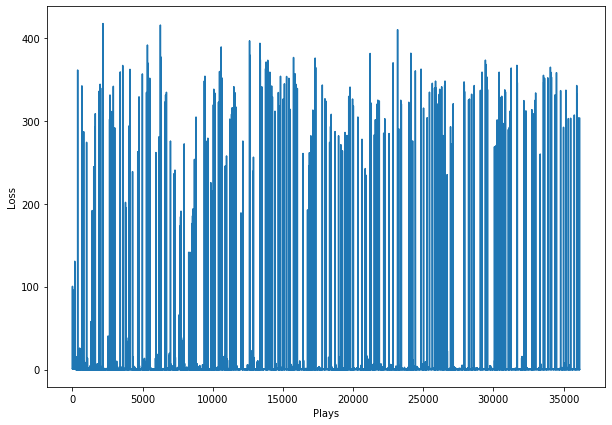

In [7]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Plays")
plt.ylabel("Loss")

In [10]:
len(action_map)

4

In [1]:


from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')



In [2]:
game.display()


array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.reward()

-1

In [5]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
4